In [10]:
%matplotlib inline

import ROOT, sys, os
from ROOT import std

from larcv import larcv
from larlite import larlite as ll
from larlite import larutil as lu

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib.patches as patches

from ROOT import geo2d,cv
from ROOT.cv import Point_ as Vector
DTYPE='float'

import root_numpy as rn
import pandas as pd

geoh=lu.GeometryHelper.GetME()
geo=lu.Geometry.GetME()
larp=lu.LArProperties.GetME()
pygeo = geo2d.PyDraw()

matplotlib.rcParams['font.size']=20
matplotlib.rcParams['font.family']='serif'


In [11]:
#INFILE="../rad6_p60/numu_ccqe_p00_p07_rad6_p60.root"
#INFILE="../numu_ccqe_p00_p07_rad6_test.root"
#INFILE="../rad6_p60_withxs_clean/numu_ccqe_p00_p07_rad6_updated.root"
#INFILE="../numu_ccqe_p00_p07_rad8_p60_LATEST_2.root"
#INFILE="../rad6_latest_update_qpt.root"
INFILE="../rad6_updated.root"

reco_event_df = pd.DataFrame(rn.root2array(INFILE,treename='EventTree'))
reco_event_df = reco_event_df.drop_duplicates(subset=['run','subrun','event'])

reco_vtx3d_df = pd.DataFrame(rn.root2array(INFILE,treename='Vtx3DTree'))
reco_particle_df = pd.DataFrame(rn.root2array(INFILE,treename='ParticleTree'))

mc_df = pd.DataFrame(rn.root2array(INFILE,treename='mctree'))
mc_df = mc_df.drop_duplicates(subset=['run','subrun','event'])


In [12]:
# check if there is a good vertex or not
def correct(reco_vtx3d_,group_,chosen_idx_):

    ### use projected vertex
    
    #recox = reco_vtx3d_.vtx2d_x_v.values[chosen_idx_]
    #recoy = reco_vtx3d_.vtx2d_y_v.values[chosen_idx_]

    ### use circle vertex
    
    recox = reco_vtx3d_.circle_vtx_x_v.values[chosen_idx_]
    recoy = reco_vtx3d_.circle_vtx_y_v.values[chosen_idx_]
    
    mcx = group_.vtx2d_t.values[0]
    mcy = group_.vtx2d_w.values[0]
    
    dist=np.sqrt(np.power(recox-mcx,2)+np.power(recoy-mcy,2))

    dist.sort()

    dist0_b = False
    dist1_b = False
    
    if dist[0] <=7 : dist0_b = True
    if dist[1] <=7 : dist1_b = True
    
    return (dist0_b==True and dist1_b==True)
    

def do_selection(mc_sdf,reco_event_df,reco_vtx3d_df):

    selected = []

    mc_gdf  = mc_sdf.set_index(['run','subrun','event'])
    groups_ = mc_gdf.groupby(mc_gdf.index)
    
    for name, group in groups_:

        nvtx_b  = False
        close_b = False

        query_='run=={}&subrun=={}&event=={}'.format(name[0],name[1],name[2])
        
        reco_event = reco_event_df.query(query_)

        if reco_event.n_vtx3d.values > 0: 
            nvtx_b = True
        
        if nvtx_b == False: 
            continue
            
        reco_vtx3d = reco_vtx3d_df.query(query_)

        if ( reco_event.n_vtx3d.values != reco_vtx3d.vtx3d_id.size ):
            pass
            #print query_

        good_reco = False
        for idx_ in xrange(reco_event.n_vtx3d):

            if good_reco==True : break
            good_reco = correct(reco_vtx3d,group,idx_)

        if good_reco==True: 
            close_b=True

        if nvtx_b==True and close_b==True:
            selected.append(mc_sdf.query(query_).index.values[0])

    return np.array(selected)

## Integrated Efficiency

In [13]:
# cut on mc_df for visibility -- must be lepton with 35 MeV

#ask for atleast 1 lepton
print "Total number of events NU [200,600]: ",mc_df.index.size
mc_sdf = mc_df.query("nlepton>0")
print "Events with atleast 1 lepton: ",mc_sdf.index.size
mc_sdf = mc_sdf.query("dep_sum_lep>35")
print "Events with atleast 35 MeV lep sum: ",mc_sdf.index.size
mc_sdf = mc_sdf.query("nproton>0")
print "Events with 1 proton: ",mc_sdf.index.size
mc_sdf = mc_sdf.query("dep_sum_proton>60")
print "Events with atleast 60 MeV proton: ",mc_sdf.index.size
n_primary_df=mc_sdf.query("nprimary>2")
print "Events with more than 2 primary particles",n_primary_df.index.size
tp_df=n_primary_df.query("nproton>=2")
print "Events with 2 or more protons",tp_df.index.size
ecut=60.0
def check_proton(row):
    proton_idx=np.where(row['daughterPdg_v']==2212)[0]
    proton_ptrack=row['daughterParentTrackid_v'][proton_idx]
    proton_track =row['daughterTrackid_v'][proton_idx]
    proton_idx=proton_idx[proton_ptrack==proton_track]
    return np.where(row['daughterEnergyDep_v'][proton_idx]>=ecut)[0].size

proton_vis=tp_df.apply(check_proton,axis=1)
dropidx=proton_vis[proton_vis>1].index
print "Number of events with more than 1 visible proton",dropidx.size
mc_sdf=mc_sdf.drop(dropidx)
n_reco_v = do_selection(mc_sdf,reco_event_df,reco_vtx3d_df)
print "Reco Efficiency is ", n_reco_v.size,"/",mc_sdf.index.size,"= ",float(n_reco_v.size)/float(mc_sdf.index.size)

mc_gdf  = mc_sdf.set_index(['run','subrun','event'])
groups_ = mc_gdf.groupby(mc_gdf.index)

Total number of events NU [200,600]:  8891
Events with atleast 1 lepton:  8860
Events with atleast 35 MeV lep sum:  8545
Events with 1 proton:  6736
Events with atleast 60 MeV proton:  3342
Events with more than 2 primary particles 320
Events with 2 or more protons 319
Number of events with more than 1 visible proton 54
Reco Efficiency is  2536 / 3288 =  0.771289537713


## Vertex Resolution

In [14]:
mc_cdf   = mc_sdf.ix[n_reco_v].set_index(['run','subrun','event'])

dw_v=[]
dt_v=[]

for name, row in mc_cdf.iterrows():  
    run,subrun,event=name
    reco_evt_rse = reco_event_df.query("run==@run&subrun==@subrun&event==@event")
    reco_vtx_rse = reco_vtx3d_df.query("run==@run&subrun==@subrun&event==@event")
    
    #2d resolution plots 
    #pick the best vertex
    mcx = row.vtx2d_t
    mcy = row.vtx2d_w
    
    dd=[]
    for vtx_idx in xrange(reco_evt_rse.n_vtx3d):
        recox = reco_vtx_rse.circle_vtx_x_v.values[vtx_idx]
        recoy = reco_vtx_rse.circle_vtx_y_v.values[vtx_idx]
        dist  = np.sqrt(np.power(recox-mcx,2)+np.power(recoy-mcy,2))
        dist.sort()
        dd.append(dist[0]+dist[1])

    dd=np.array(dd)
    cidx = np.argmin(dd)
    n_pars_v=reco_vtx_rse.circle_vtx_xs_v.values[cidx]
    dw_v.append(row.vtx2d_w - reco_vtx_rse.circle_vtx_y_v.values[cidx])
    dt_v.append(row.vtx2d_t - reco_vtx_rse.circle_vtx_x_v.values[cidx])

dw_v=np.vstack(dw_v)
dt_v=np.vstack(dt_v)

0 -0.737148669644 1.80615804731
1 -0.396455935547 1.83985399023
2 -1.11873770417 1.82260129864


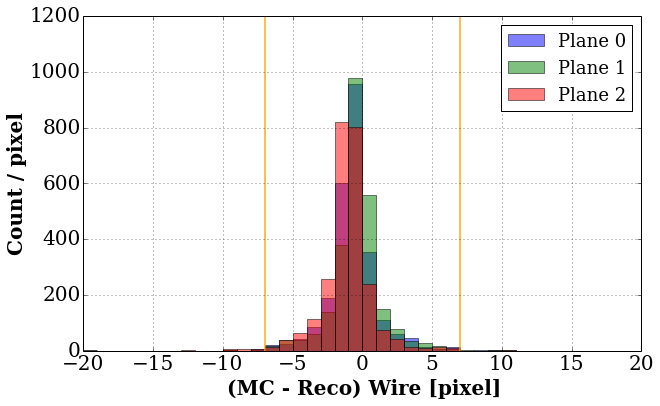

0 -0.0635021536065 1.30347680325
1 -0.640914027842 1.24411647283
2 -1.08029856651 1.19562631893


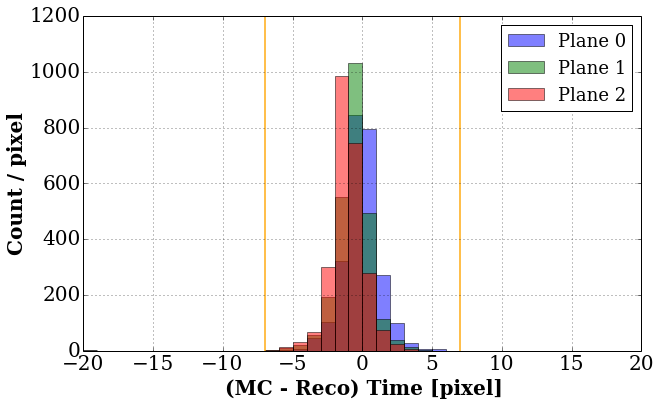

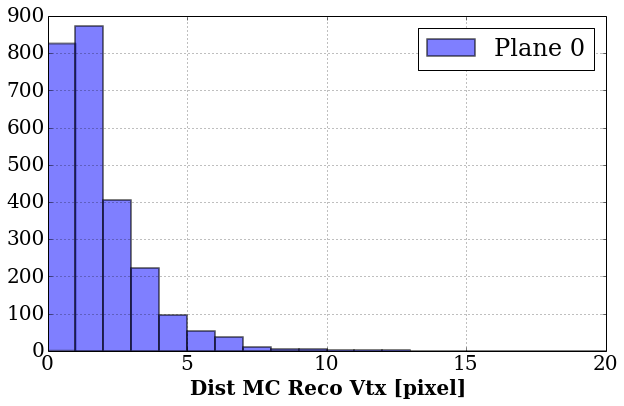

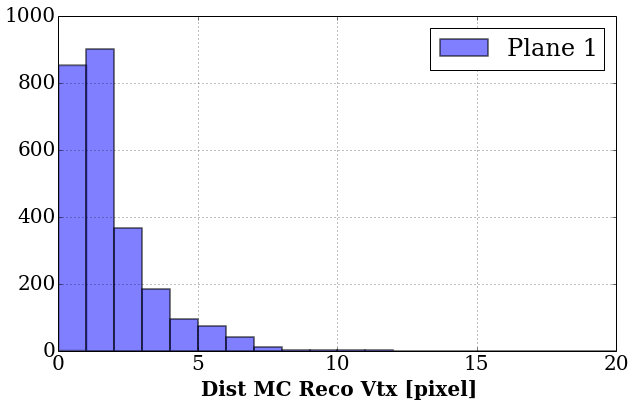

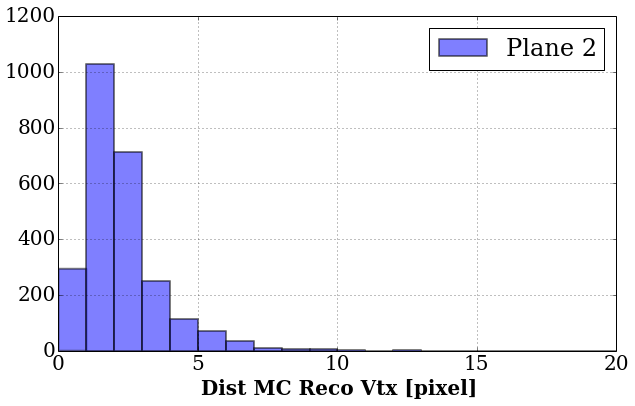

In [15]:
fig,ax=plt.subplots(figsize=(10,6))
for i in xrange(3):
    ax.hist(dw_v[:,i],
            label='Plane {}'.format(i),
            bins=np.arange(-20,20+1,1),
            alpha=0.5)
    print i,np.mean(dw_v[:,i]),np.std(dw_v[:,i])
ax.set_xlabel("(MC - Reco) Wire [pixel]",fontweight='bold')
#ax.set_ylim(0,45)
#ax.set_xticks(np.arange(-100,100,20))
#x.set_xlim(-100,100)
ax.set_ylim(0,1200)
ax.set_ylabel("Count / pixel",fontweight='bold')
ax.vlines(-7,0,1800,lw=2,color='orange',alpha=0.7)
ax.vlines(7,0,1800,lw=2,color='orange',alpha=0.7)
ax.legend(fontsize=18)
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))
for i in xrange(3):
    ax.hist(dt_v[:,i],
            label='Plane {}'.format(i),
            bins=np.arange(-20,20+1,1),
            alpha=0.5)
    print i,np.mean(dt_v[:,i]),np.std(dt_v[:,i])
ax.set_xlabel("(MC - Reco) Time [pixel]",fontweight='bold')
#ax.set_xticks(np.arange(-20,20,2))
#ax.set_ylim(0,45)
#ax.set_xlim(-100,100)
ax.set_ylim(0,1200)
ax.vlines(-7,0,1800,lw=2,color='orange',alpha=0.7)
ax.vlines(7,0,1800,lw=2,color='orange',alpha=0.7)
ax.legend(fontsize=18)
ax.set_ylabel("Count / pixel",fontweight='bold')
plt.grid()
plt.show()


for i in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(np.sqrt(np.power(dw_v[:,i],2)+np.power(dt_v[:,i],2)),
            label='Plane {}'.format(i),
            bins=np.arange(0,20+1,1),
            alpha=0.5,lw=2)
    ax.set_xlabel("Dist MC Reco Vtx [pixel]",fontweight='bold')
    #ax.set_ylim(0,30)
    ax.set_xlim(0,20)

    ax.legend()
    plt.grid()
    plt.show()

## Proton deposited energy

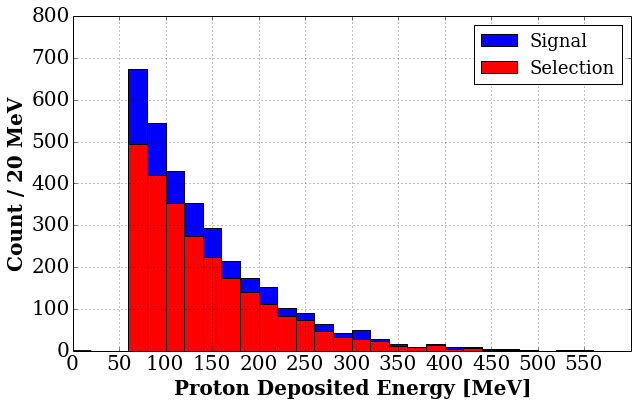

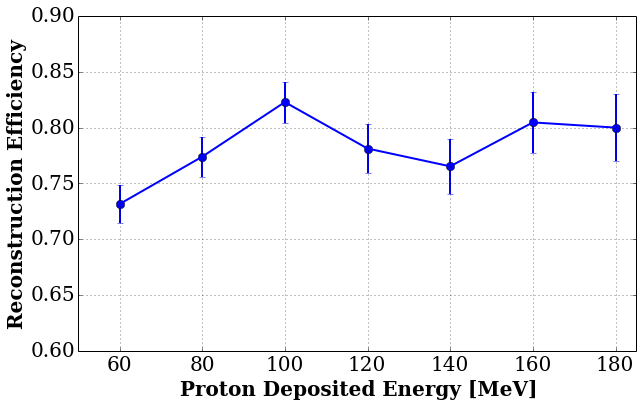

In [16]:
fig,ax=plt.subplots(figsize=(10,6))

bins=np.arange(0,600+20,20)

signal_h=ax.hist(mc_sdf.dep_sum_proton.values,
                 bins=bins,color='blue',label='Signal')
signal_v=signal_h[0]
energy_v=signal_h[1]

reco_h=ax.hist(mc_sdf.ix[n_reco_v].dep_sum_proton.values,
               bins=bins,color='red',label='Selection')
reco_v=reco_h[0]

ax.set_xticks(np.arange(0,600,50))
ax.set_ylim(0,800)
ax.set_xlabel("Proton Deposited Energy [MeV]",fontweight='bold')
ax.set_ylabel("Count / 20 MeV",fontweight='bold')
ax.legend(loc='best',fontsize=18)
plt.grid()
plt.show()
fig,ax=plt.subplots(figsize=(10,6))

eff_v=reco_v/signal_v

energy_v=energy_v[:10]
eff_v=eff_v[:10]
signal_v=signal_v[:10]
ax.plot(energy_v,eff_v,'o',
        color='blue',markersize=8)
ax.errorbar(energy_v,eff_v,
            yerr=np.sqrt(eff_v*(1-eff_v)/signal_v),
            lw=2,
            color='blue')

ax.set_xlim(50,185)
ax.set_ylim(0.6,0.9)
ax.set_xlabel("Proton Deposited Energy [MeV]",
              fontweight='bold')
ax.set_ylabel("Reconstruction Efficiency",
              fontweight='bold')
plt.grid()
plt.show()

## Proton kinetic energy

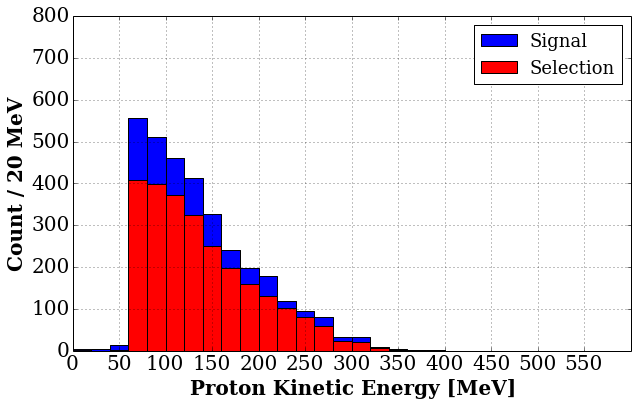

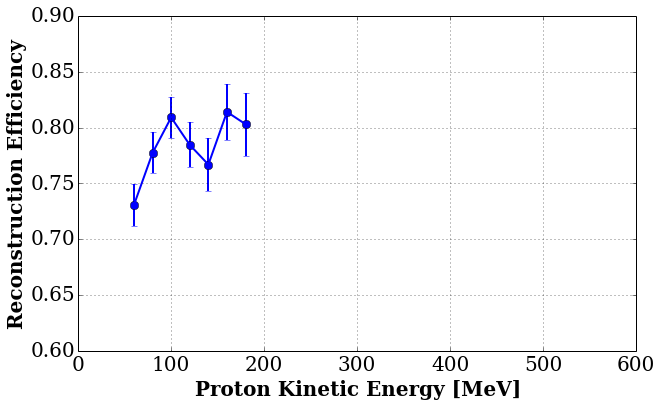

In [17]:
fig,ax=plt.subplots(figsize=(10,6))

bins=np.arange(0,600+20,20)

signal_h=ax.hist(mc_sdf.ke_sum_proton.values,
                 bins=bins,color='blue',label='Signal')
signal_v=signal_h[0]
energy_v=signal_h[1]

reco_h=ax.hist(mc_sdf.ix[n_reco_v].ke_sum_proton.values,
               bins=bins,color='red',label='Selection')
reco_v=reco_h[0]

ax.set_xticks(np.arange(0,600,50))
ax.set_ylim(0,800)
ax.set_xlabel("Proton Kinetic Energy [MeV]",fontweight='bold')
ax.set_ylabel("Count / 20 MeV",fontweight='bold')
ax.legend(loc='best',fontsize=18)
plt.grid()
plt.show()
fig,ax=plt.subplots(figsize=(10,6))

eff_v=reco_v/signal_v

energy_v=energy_v[3:10]
eff_v=eff_v[3:10]
signal_v=signal_v[3:10]

ax.plot(energy_v,eff_v,'o',
        color='blue',markersize=8)
ax.errorbar(energy_v,eff_v,
            yerr=np.sqrt(eff_v*(1-eff_v)/signal_v),
            lw=2,
            color='blue')

ax.set_xlim(0,600)
ax.set_ylim(0.6,0.9)
ax.set_xlabel("Proton Kinetic Energy [MeV]",
              fontweight='bold')
ax.set_ylabel("Reconstruction Efficiency",
              fontweight='bold')

plt.grid()
plt.show()

## Lepton kinetic energy

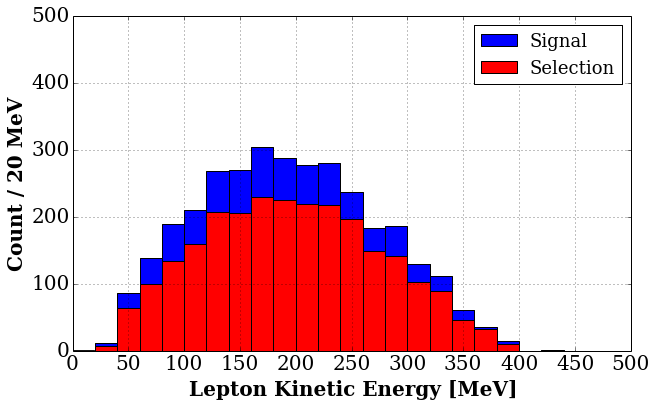

25 25 25 25


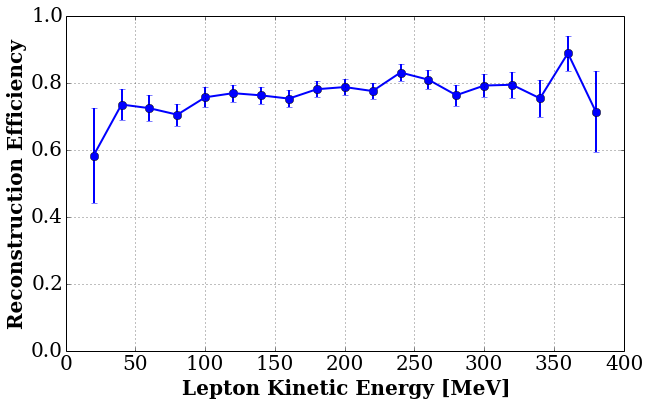

In [18]:
fig,ax=plt.subplots(figsize=(10,6))

bins=np.arange(0,500+20,20)

signal_h=ax.hist(mc_sdf.ke_sum_lep.values-105,
                 bins=bins,color='blue',label='Signal')
signal_v=signal_h[0]
energy_v=signal_h[1]

reco_h=ax.hist(mc_sdf.ix[n_reco_v].ke_sum_lep.values-105,
               bins=bins,color='red',label='Selection')
reco_v=reco_h[0]

ax.set_xticks(np.arange(0,550,50))
ax.set_ylim(0,500)
ax.set_xlabel("Lepton Kinetic Energy [MeV]",fontweight='bold')
ax.set_ylabel("Count / 20 MeV",fontweight='bold')
ax.legend(loc='best',fontsize=18)
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))

eff_v=reco_v/signal_v
print energy_v[:-1].size,eff_v.size,signal_v.size,reco_v.size
ax.plot(energy_v[:-1],eff_v,'o',
        color='blue',markersize=8)

ax.errorbar(energy_v[:-1],eff_v,
            yerr=np.sqrt(eff_v*(1-eff_v)/signal_v),
            lw=2,
            color='blue')

ax.set_xlim(0,400)
ax.set_ylim(0,1.0)
ax.set_xlabel("Lepton Kinetic Energy [MeV]",
              fontweight='bold')
ax.set_ylabel("Reconstruction Efficiency",
              fontweight='bold')
plt.grid()
plt.show()

## Lepton deposited energy

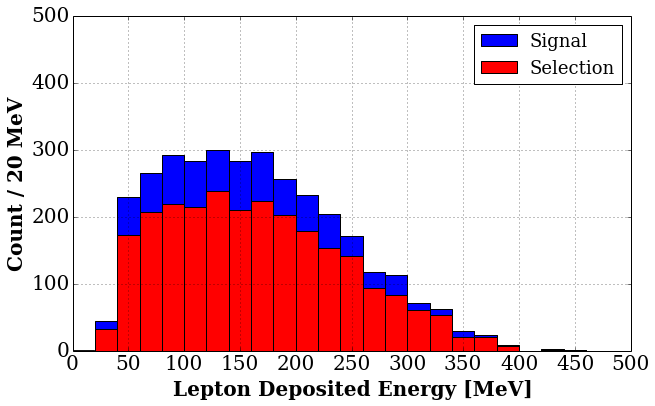

25 25 25 25


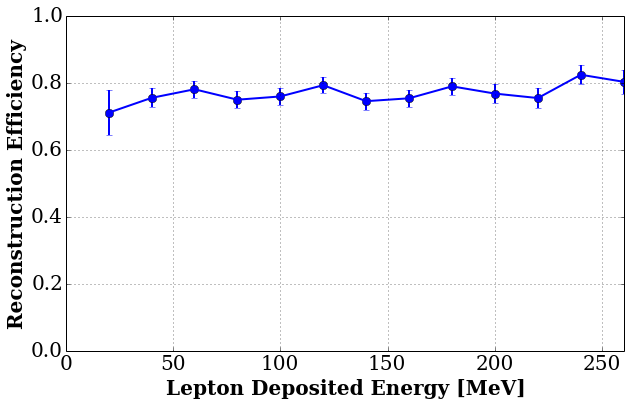

In [19]:
fig,ax=plt.subplots(figsize=(10,6))


bins=np.arange(0,500+20,20)

signal_h=ax.hist(mc_sdf.dep_sum_lep.values,
                 bins=bins,color='blue',label='Signal')
signal_v=signal_h[0]
energy_v=signal_h[1]

reco_h=ax.hist(mc_sdf.ix[n_reco_v].dep_sum_lep.values,
               bins=bins,color='red',label='Selection')
reco_v=reco_h[0]

ax.set_xticks(np.arange(0,550,50))
ax.set_ylim(0,500)
ax.set_xlabel("Lepton Deposited Energy [MeV]",fontweight='bold')
ax.set_ylabel("Count / 20 MeV",fontweight='bold')
ax.legend(loc='best',fontsize=18)
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))

eff_v=reco_v/signal_v
print energy_v[:-1].size,eff_v.size,signal_v.size,reco_v.size
ax.plot(energy_v[:-1],eff_v,'o',
        color='blue',markersize=8)

ax.errorbar(energy_v[:-1],eff_v,
            yerr=np.sqrt(eff_v*(1-eff_v)/signal_v),
            lw=2,
            color='blue')

ax.set_xlim(0,260)
ax.set_ylim(0,1.0)
ax.set_xlabel("Lepton Deposited Energy [MeV]",
              fontweight='bold')
ax.set_ylabel("Reconstruction Efficiency",
              fontweight='bold')
plt.grid()
plt.show()

## Lepton angle

In [40]:
def lepton_angle(row):
    pdg_v=row['daughterPdg_v']
    pdg_idx_v=np.where(pdg_v==13)[0]

    if pdg_idx_v.size==0: return np.nan

    pdg_idx = pdg_idx_v[0]
    
    cos_vv=row['daughter2DCosAngle_vv']
    p0=cos_vv[0][pdg_idx]
    p1=cos_vv[1][pdg_idx]
    p2=cos_vv[2][pdg_idx]
    return [p0,p1,p2]


cos_s=np.row_stack(np.nan_to_num(mc_sdf.apply(lepton_angle,axis=1)))
cos_r=np.row_stack(np.nan_to_num(mc_sdf.ix[n_reco_v].apply(lepton_angle,axis=1)))
bins=np.arange(-1.0,1.0+0.05,0.05)

plane2name=["U","V","Y"]

for plane in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(cos_s[:,plane],bins=bins,color='blue',label='Signal')
    ax.hist(cos_r[:,plane],bins=bins,color='red', label='Selection')
    ax=plt.gca()
    ax.text(-0.5,252,"Plane {}".format(plane2name[plane]),fontweight='bold')
    ax.set_xlabel("Lepton Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Events / 0.05",fontweight='bold')
    plt.grid()
    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(0,400)
    ax.legend(loc='best',fontsize=18)
    plt.show()
    
plt.show()


TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Proton angle

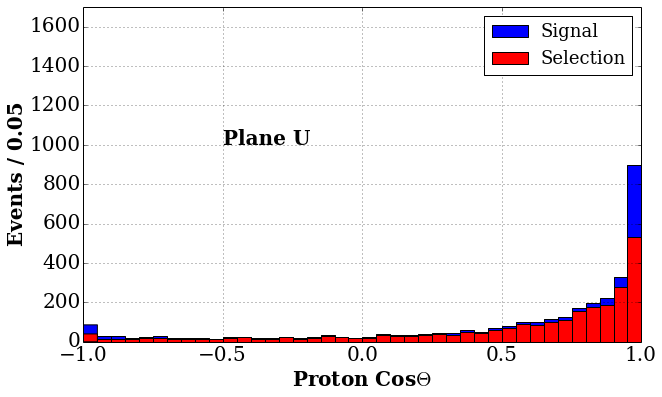

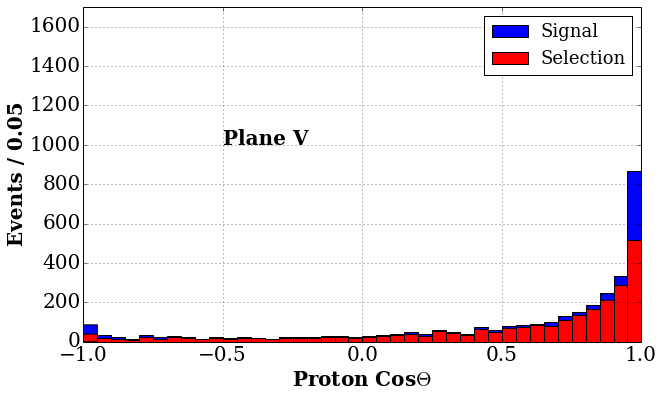

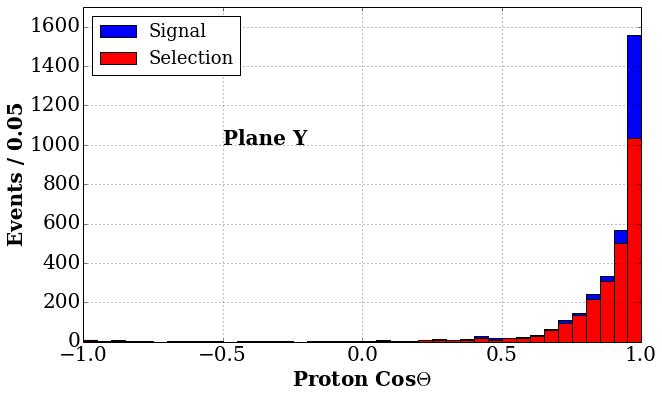

In [21]:
def proton_angle(row):
    pdg_v=row['daughterPdg_v']
    pdg_idx_v=np.where(pdg_v==2212)[0]

    if pdg_idx_v.size==0: return np.nan

    pdg_idx = pdg_idx_v[0]
    
    cos_vv=row['daughter2DCosAngle_vv']
    p0=cos_vv[0][pdg_idx]
    p1=cos_vv[1][pdg_idx]
    p2=cos_vv[2][pdg_idx]
    return [p0,p1,p2]


cos_s=np.row_stack(mc_sdf.apply(proton_angle,axis=1).dropna())
cos_r=np.row_stack(mc_sdf.ix[n_reco_v].apply(proton_angle,axis=1).dropna())
bins=np.arange(-1.0,1.0+0.05,0.05)

plane2name=["U","V","Y"]

for plane in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(cos_s[:,plane],bins=bins,color='blue',label='Signal')
    ax.hist(cos_r[:,plane],bins=bins,color='red', label='Selection')
    ax=plt.gca()
    ax.text(-0.5,1000,"Plane {}".format(plane2name[plane]),fontweight='bold')
    ax.set_xlabel("Proton Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Events / 0.05",fontweight='bold')
    plt.grid()
    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(0,1700)
    ax.legend(loc='best',fontsize=18)
    plt.show()
    
plt.show()


## Opening angle

3288


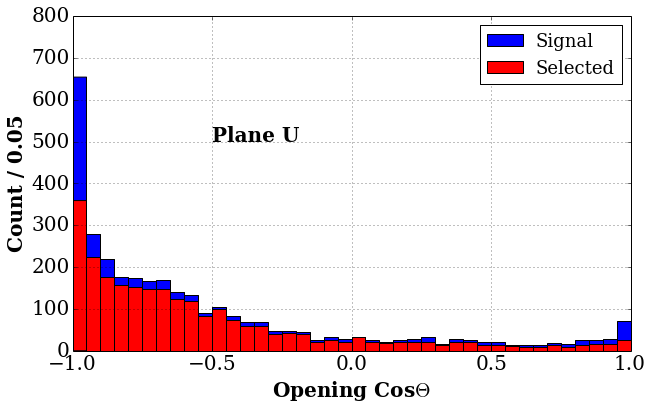

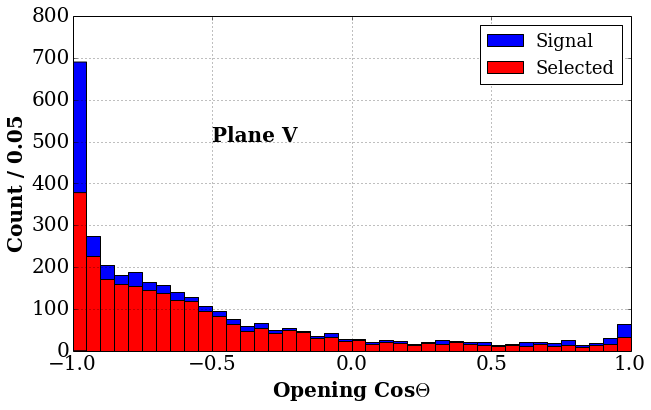

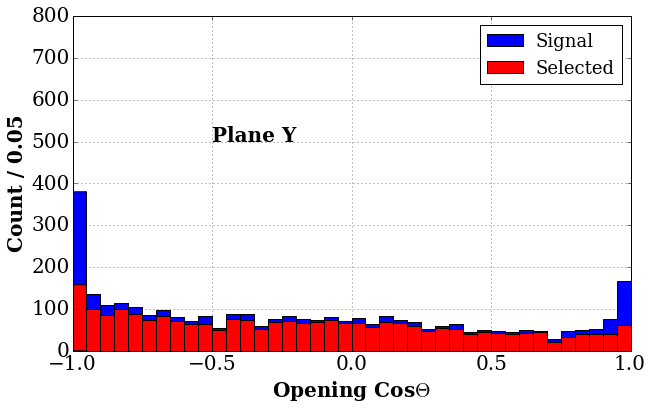

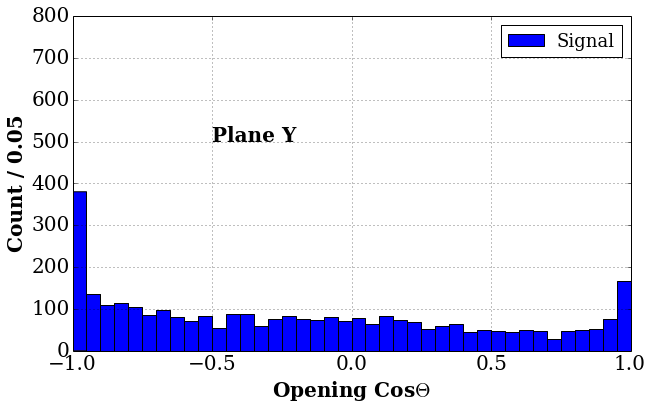

In [22]:
def dual_angle(row):
    pdg_v=row['daughterPdg_v']
    sx_vv=row['daughter2DStartX_vv']
    sy_vv=row['daughter2DStartY_vv']    
    ex_vv=row['daughter2DEndX_vv']
    ey_vv=row['daughter2DEndY_vv']
    
    pdg_idx_v=np.where(pdg_v==13)[0]

    if pdg_idx_v.size==0: return np.nan

    pdg_idx = pdg_idx_v[0]

    p0l_sx=sx_vv[0][pdg_idx]
    p0l_ex=ex_vv[0][pdg_idx]
    p0l_sy=sy_vv[0][pdg_idx]
    p0l_ey=ey_vv[0][pdg_idx]
    
    p1l_sx=sx_vv[1][pdg_idx]
    p1l_ex=ex_vv[1][pdg_idx]
    p1l_sy=sy_vv[1][pdg_idx]
    p1l_ey=ey_vv[1][pdg_idx]
    
    p2l_sx=sx_vv[2][pdg_idx]
    p2l_ex=ex_vv[2][pdg_idx]
    p2l_sy=sy_vv[2][pdg_idx]
    p2l_ey=ey_vv[2][pdg_idx]
    
    p0l=np.array([p0l_ex-p0l_sx,p0l_ey-p0l_sy])
    p1l=np.array([p1l_ex-p1l_sx,p1l_ey-p1l_sy])
    p2l=np.array([p2l_ex-p2l_sx,p2l_ey-p2l_sy])
    
    pdg_idx_v=np.where(pdg_v==2212)[0]

    if pdg_idx_v.size==0: return np.nan

    pdg_idx = pdg_idx_v[0]

    p0p_sx=sx_vv[0][pdg_idx]
    p0p_ex=ex_vv[0][pdg_idx]
    p0p_sy=sy_vv[0][pdg_idx]
    p0p_ey=ey_vv[0][pdg_idx]
    
    p1p_sx=sx_vv[1][pdg_idx]
    p1p_ex=ex_vv[1][pdg_idx]
    p1p_sy=sy_vv[1][pdg_idx]
    p1p_ey=ey_vv[1][pdg_idx]
    
    p2p_sx=sx_vv[2][pdg_idx]
    p2p_ex=ex_vv[2][pdg_idx]
    p2p_sy=sy_vv[2][pdg_idx]
    p2p_ey=ey_vv[2][pdg_idx]
    
    p0p=np.array([p0p_ex-p0p_sx,p0p_ey-p0p_sy])
    p1p=np.array([p1p_ex-p1p_sx,p1p_ey-p1p_sy])
    p2p=np.array([p2p_ex-p2p_sx,p2p_ey-p2p_sy])

    p0=np.dot(p0p,p0l) / (np.sqrt(np.dot(p0p,p0p))*np.sqrt(np.dot(p0l,p0l)))
    p1=np.dot(p1p,p1l) / (np.sqrt(np.dot(p1p,p1p))*np.sqrt(np.dot(p1l,p1l)))
    p2=np.dot(p2p,p2l) / (np.sqrt(np.dot(p2p,p2p))*np.sqrt(np.dot(p2l,p2l)))
    
    return [p0,p1,p2]

mc_cos_s=mc_sdf.apply(dual_angle,axis=1)
mc_cos_r=mc_sdf.ix[n_reco_v].apply(dual_angle,axis=1)

print mc_cos_s.size

cos_s=np.row_stack(mc_cos_s.dropna())
cos_r=np.row_stack(mc_cos_r.dropna())

bins=np.arange(-1.0,1.0+0.05,0.05)

plane2name=["U","V","Y"]

for plane in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(cos_s[:,plane],bins=bins,color='blue',label='Signal')
    ax.hist(cos_r[:,plane],bins=bins,color='red',label='Selected')
    ax=plt.gca()
    ax.text(-0.5,500,"Plane {}".format(plane2name[plane]),fontweight='bold')
    ax.set_xlabel("Opening Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Count / 0.05",fontweight='bold')
    plt.grid()
    ax.legend(fontsize=18)
    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(0,800)
    plt.show()

    
fig,ax=plt.subplots(figsize=(10,6))
ax.hist(cos_s[:,plane],bins=bins,color='blue',label='Signal')
#ax.hist(cos_r[:,plane],bins=bins,color='red',label='Selected')
ax=plt.gca()
ax.text(-0.5,500,"Plane {}".format(plane2name[plane]),fontweight='bold')
ax.set_xlabel("Opening Cos$\Theta$",fontweight='bold')
ax.set_ylabel("Count / 0.05",fontweight='bold')
plt.grid()
ax.legend(fontsize=18)
ax.set_xlim(-1.0,1.0)
ax.set_ylim(0,800)
plt.show()    
    

plt.show()


## Unit test of histogram

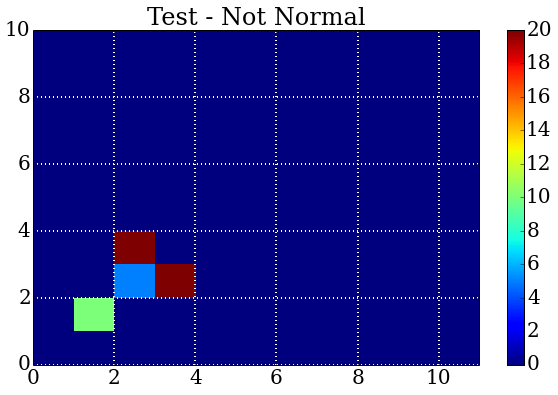

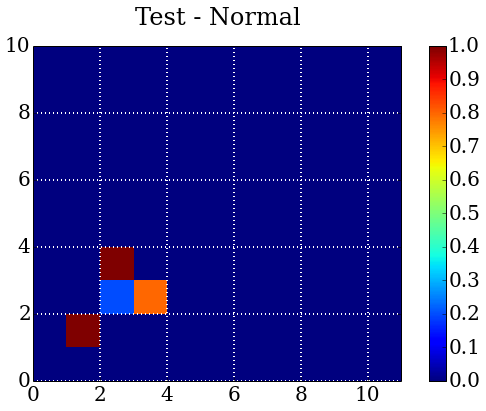

In [23]:
x=np.concatenate((np.ones(10),2*np.ones(5),2*np.ones(20),3*np.ones(20)))
y=np.concatenate((np.ones(10),2*np.ones(5),3*np.ones(20),2*np.ones(20)))


fig,ax=plt.subplots(figsize=(10,6))

om=ax.hist2d(x,y,
            bins=(np.arange(0,12,1),np.arange(0,11,1)))

plt.colorbar(om[3])
plt.grid(color='white',lw=2)
ax.set_title("Test - Not Normal")
plt.show()

im=np.histogram2d(x,y, bins=(np.arange(0,12,1),np.arange(0,11,1)))

imm=im[0] / np.sum(im[0],axis=0)
nn=np.nan_to_num(imm).astype(np.float32)
fig,ax=plt.subplots(figsize=(10,6))

om=ax.matshow(nn.T,origin='bottom',
              extent=[0,nn.shape[0],0,nn.shape[1]])

ax.xaxis.set_ticks_position('bottom')
plt.colorbar(om)
plt.grid(color='white',lw=2)
ax.set_title("Test - Normal")
plt.show()


## Neutrino Energy vs opening

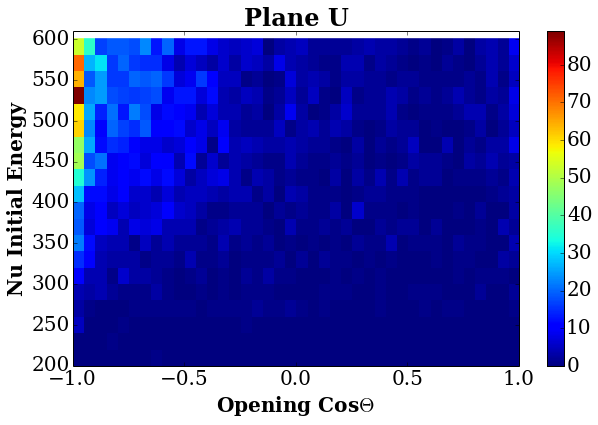

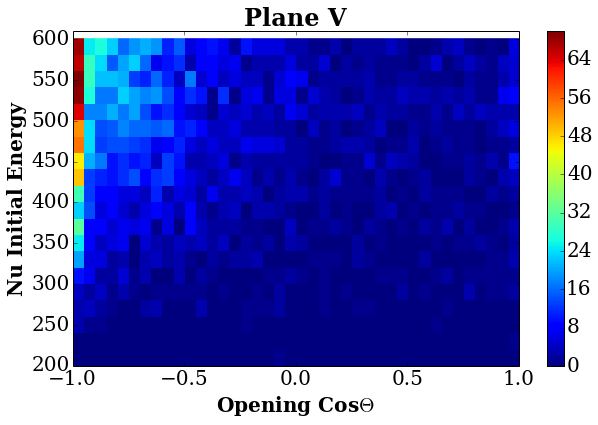

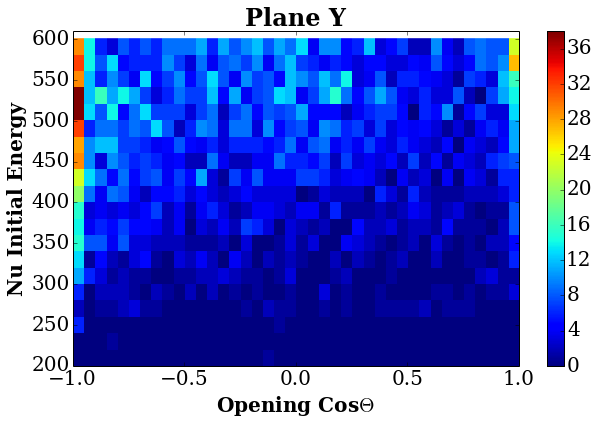

In [24]:
#normalize along the Y direction
#neutrino energy
for plane_id in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    costh   = np.nan_to_num(mc_cos_s.str[plane_id].values)
    energyI = mc_sdf.energyInit.values
    
    im=ax.hist2d(costh,
                 energyI,
                 bins=(np.arange(-1.0,1.0+0.05,0.05),
                       np.arange(200,600+20,20)))
                          
    plt.colorbar(im[3])
    ax.set_title("Plane {}".format(plane2name[plane_id]),fontweight='bold')
    ax.set_xlabel("Opening Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Nu Initial Energy",fontweight='bold')
    ax.set_ylim(200,610)
    plt.show()
    

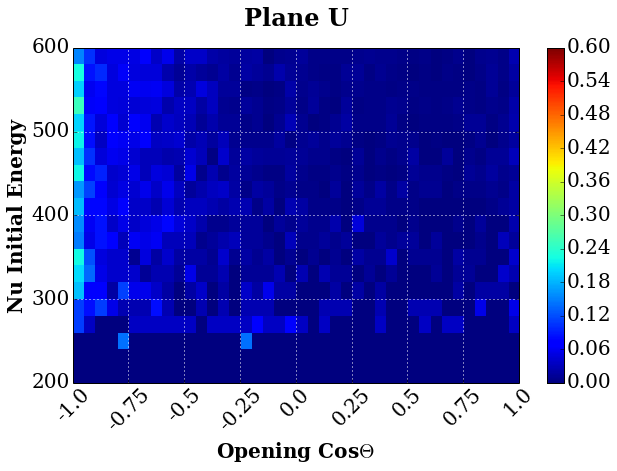

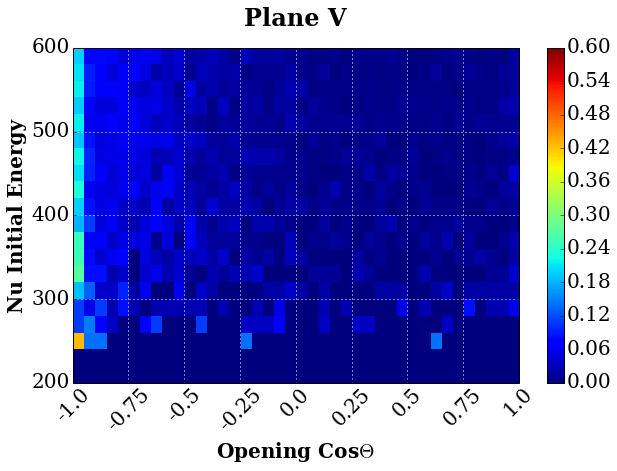

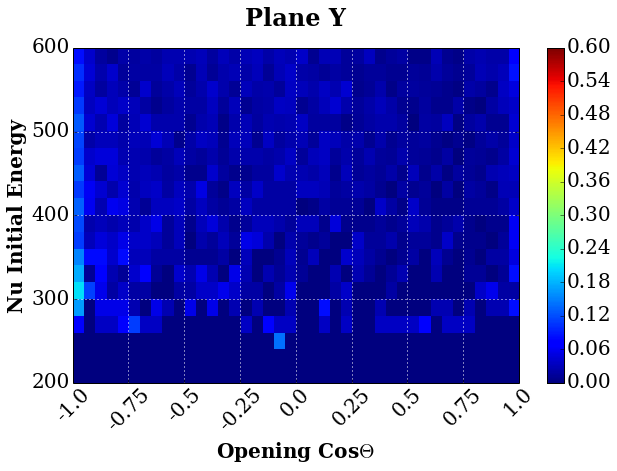

In [26]:
#normalize along the Y direction
#neutrino energy
for plane_id in xrange(3):

    costh   = np.nan_to_num(mc_cos_s.str[plane_id].values)
    energyI = mc_sdf.energyInit.values
    
    im=np.histogram2d(costh,
                      energyI,
                      bins=(np.arange(-1.0,1.0+0.05,0.05),
                            np.arange(200,600+20,20)))

    fig,ax=plt.subplots(figsize=(10,6))
    imm=im[0] / np.sum(im[0],axis=0)

    nn=np.nan_to_num(imm).astype(np.float32)
    om=ax.matshow(np.where(nn.T<0.6,nn.T,0),origin='bottom',
                 extent=[0,nn.shape[0],0,nn.shape[1]],
                 cmap='jet',vmin=0,vmax=0.6)
    ax.xaxis.set_ticks_position('bottom')
    

    plt.grid(color='white',lw=1)
    ax.set_xticklabels(np.arange(-1.0,1.0+2/8.0,2/8.0),rotation=45)
    ax.set_yticklabels(np.arange(200,600+400/4.0,400/4.0).astype(np.int))
    ax.set_title("Plane {}".format(plane2name[plane_id]),fontweight='bold')
    ax.set_xlabel("Opening Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Nu Initial Energy",fontweight='bold')
    ax.set_aspect(1.5)
    #ax.set_ylim(200,610)
    plt.colorbar(om)
    plt.show()
    

## Load data file

In [53]:
iom=larcv.IOManager(larcv.IOManager.kBOTH)        
iom.reset()
iom.set_verbosity(0)                                                                          
iom.add_in_file("/Users/vgenty/Desktop/numu_ccqe_p00_p07.root")
iom.set_out_file("/tmp/trash.root")
iom.initialize()

larbysimg=larcv.LArbysImage()
cfg=larcv.CreatePSetFromFile("empty.fcl","LArbysImage")
larbysimg.configure(cfg)
larbysimg.initialize()


In [ ]:
# y=np.array([ 0.68173862,0.70536756,0.68611435,.63623104,.50641774])
# x=np.array([5,6,8,10,14])
# fig,ax=plt.subplots(figsize=(10,6))
# ax.plot(x,y,'o',color='blue')
# ax.errorbar(x,y,yerr=np.sqrt(y*(1.0-y)/3428.),color='blue')
# ax.set_ylim(0.45,0.8)
# ax.set_xlim(4,15)
# ax.set_ylabel("Reconstruction Efficiency",fontweight='bold')
# ax.set_xlabel("Scanning Radius Size [pixel]",fontweight='bold')
# plt.grid()
# plt.show()

# # zoom
# # this is integrated from lower dep upward
# fig,ax=plt.subplots(figsize=(10,6))
# N_=[3956.,3488.,3109.,2767.,2456.,2190.]
# print np.sqrt(y*(1.-y)/N_)
# ax.errorbar(x,y,yerr=np.sqrt(y*(1.-y)/N_))
# ax=plt.gca()
# ax.set_xlabel("Min Proton Dep E")
# ax.set_ylabel("Reconstruction Efficiency")
# ax.set_ylim(0,1)
# plt.grid()
# plt.show()

# import os

# INDIR="/Volumes/AHO/radii_scan"
# dirs=[os.path.join(INDIR,dir_) for dir_ in os.listdir(INDIR)]

# effmap = {}

# for dir_ in dirs:
#     rad=int(os.path.basename(dir_).split("_")[0][3:])
#     if rad==15: continue
        
#     INFILE=[r for r in os.listdir(dir_) if r.endswith(".root")]
#     INFILE=os.path.join(dir_,INFILE[0])

#     reco_event_df = pd.DataFrame(rn.root2array(INFILE,treename='EventTree'))
#     reco_event_df = reco_event_df.drop_duplicates(subset=['run','subrun','event'])

#     reco_vtx3d_df = pd.DataFrame(rn.root2array(INFILE,treename='Vtx3DTree'))

#     mc_df = pd.DataFrame(rn.root2array(INFILE,treename='mctree'))
#     mc_df = mc_df.drop_duplicates(subset=['run','subrun','event'])

#     #the signal events

#     mc_sdf = mc_df.query("nlepton>0")
#     mc_sdf = mc_sdf.query("ke_sum_lep>35")
#     mc_sdf = mc_sdf.query("nproton>0")

#     e_dep=[]
#     numer=[]
#     denom=[]
    
#     for xx in np.arange(0,300+10,10):
#         mc_edf = mc_sdf.query("dep_sum_proton>{}".format(xx))
#         n_reco_v = do_selection(mc_edf,reco_event_df,reco_vtx3d_df)
#         e_dep.append(xx)
#         numer.append(float(n_reco_v.size))
#         denom.append(float(mc_edf.index.size))
    
    
#     effmap[rad] = [np.array(e_dep),np.array(numer),np.array(denom)]
#     break
# print effmap

# plt.errorbar(e_dep,numer/denom,yerr=np.sqrt(numer/denom*(1-numer/denom)/numer))

## Cutting out back to back and very forward going daughter

In [41]:
mc_cos_s=mc_sdf.apply(dual_angle,axis=1)
mc_cos_r=mc_sdf.ix[n_reco_v].apply(dual_angle,axis=1)

mc_drop=mc_sdf.drop(mc_sdf.ix[n_reco_v].index)
mc_cos_d=mc_drop.apply(dual_angle,axis=1)

p0_s=np.nan_to_num(mc_cos_s.str[0].values)
p1_s=np.nan_to_num(mc_cos_s.str[1].values)
p2_s=np.nan_to_num(mc_cos_s.str[2].values)

p0_r=np.nan_to_num(mc_cos_r.str[0].values)
p1_r=np.nan_to_num(mc_cos_r.str[1].values)
p2_r=np.nan_to_num(mc_cos_r.str[2].values)

p0_d=np.nan_to_num(mc_cos_d.str[0].values)
p1_d=np.nan_to_num(mc_cos_d.str[1].values)
p2_d=np.nan_to_num(mc_cos_d.str[2].values)


In [42]:
up=0.95
lo=-0.95
p0_sl_=np.where((p0_s<up) & (p0_s>lo))[0]
p1_sl_=np.where((p1_s<up) & (p1_s>lo))[0]

p2_sl_=np.where((p2_s<up) & (p2_s>lo))[0]
#p2_sl_=np.where(p2_s>up)[0]


p0_rl_=np.where((p0_r<up) & (p0_r>lo))[0]
p1_rl_=np.where((p1_r<up) & (p1_r>lo))[0]
p2_rl_=np.where((p2_r<up) & (p2_r>lo))[0]
p0_dl_=np.where((p0_d<up) & (p0_d>lo))[0]
p1_dl_=np.where((p1_d<up) & (p1_d>lo))[0]
p2_dl_=np.where((p2_d<up) & (p2_d>lo))[0]


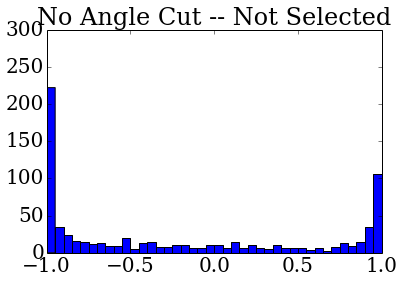

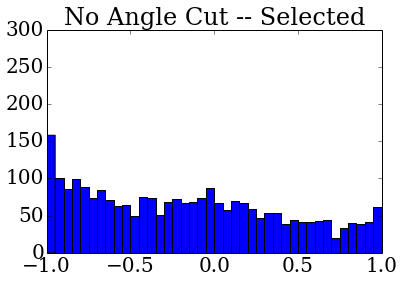

In [43]:
plt.hist(p2_d,bins=np.arange(-1.0,1.0+0.05,0.05))
ax=plt.gca()
ax.set_xlim(-1.0,1.0)
ax.set_ylim(0,300)
ax.set_title("No Angle Cut -- Not Selected")
plt.show()


plt.hist(p2_r,bins=np.arange(-1.0,1.0+0.05,0.05))
ax=plt.gca()
ax.set_xlim(-1.0,1.0)
ax.set_ylim(0,300)
ax.set_title("No Angle Cut -- Selected")
plt.show()


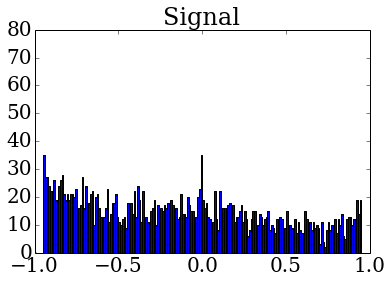

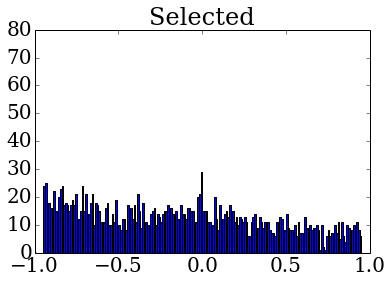

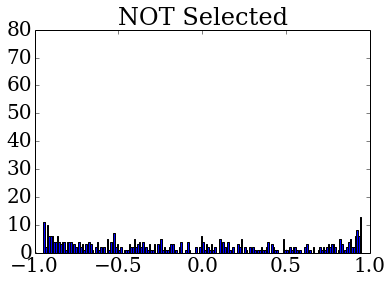

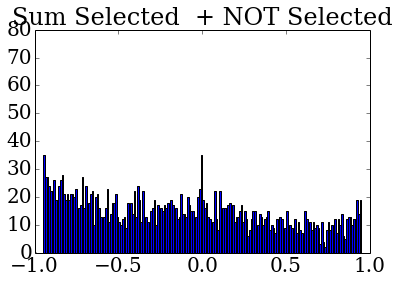

In [44]:
plt.hist(p2_s[p2_sl_],bins=np.arange(-1.0,1.0+0.01,0.01))
ax=plt.gca()
ax.set_xlim(-1.0,1.0)
ax.set_title("Signal")
ax.set_ylim(0,80)
plt.show()


plt.hist(p2_r[p2_rl_],bins=np.arange(-1.0,1.0+0.01,0.01))
ax=plt.gca()
ax.set_xlim(-1.0,1.0)
ax.set_title("Selected")
ax.set_ylim(0,80)
plt.show()


plt.hist(p2_d[p2_dl_],bins=np.arange(-1.0,1.0+0.01,0.01))
ax=plt.gca()
ax.set_xlim(-1.0,1.0)
ax.set_title("NOT Selected")
ax.set_ylim(0,80)
plt.show()

plt.hist(np.concatenate((p2_d[p2_dl_],p2_r[p2_rl_])),
         bins=np.arange(-1.0,1.0+0.01,0.01))
ax=plt.gca()
ax.set_xlim(-1.0,1.0)
ax.set_title("Sum Selected  + NOT Selected")
ax.set_ylim(0,80)
plt.show()


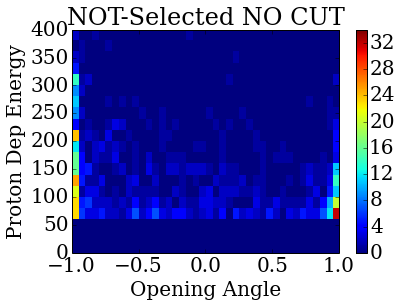

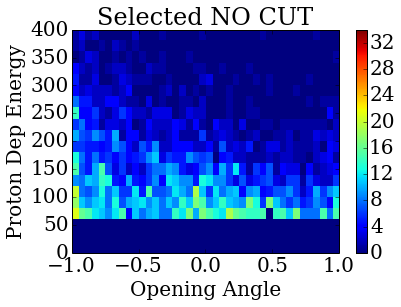

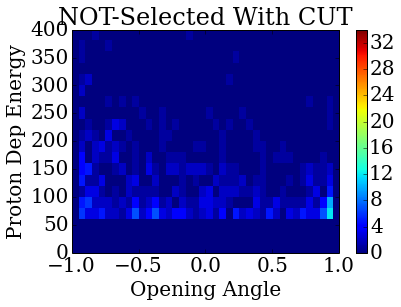

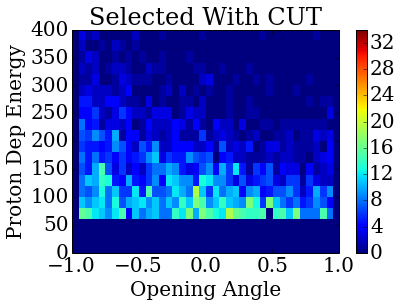

In [45]:
ii=plt.hist2d(p2_d,
              mc_drop.dep_sum_proton.values,
              bins=(np.arange(-1.0,1.0+0.05,0.05),np.arange(0,400+20,20)),vmax=34)

plt.colorbar(ii[3])
ax=plt.gca()
ax.set_xlabel("Opening Angle")
ax.set_ylabel("Proton Dep Energy")
ax.set_title("NOT-Selected NO CUT")
plt.show()

rdf=mc_sdf.ix[n_reco_v]
ii=plt.hist2d(p2_r,
              rdf.dep_sum_proton.values,
              bins=(np.arange(-1.0,1.0+0.05,0.05),np.arange(0,400+20,20)),vmax=34)

plt.colorbar(ii[3])
ax=plt.gca()
ax.set_xlabel("Opening Angle")
ax.set_ylabel("Proton Dep Energy")
ax.set_title("Selected NO CUT")
plt.show()

ii=plt.hist2d(p2_d[p2_dl_],
              mc_drop.iloc[p2_dl_].dep_sum_proton.values,
              bins=(np.arange(-1.0,1.0+0.05,0.05),np.arange(0,400+20,20)),vmax=34)

plt.colorbar(ii[3])
ax=plt.gca()
ax.set_xlabel("Opening Angle")
ax.set_ylabel("Proton Dep Energy")
ax.set_title("NOT-Selected With CUT")
plt.show()

rdf=mc_sdf.ix[n_reco_v]
ii=plt.hist2d(p2_r[p2_rl_],
              rdf.iloc[p2_rl_].dep_sum_proton.values,
              bins=(np.arange(-1.0,1.0+0.05,0.05),np.arange(0,400+20,20)),vmax=34)

plt.colorbar(ii[3])
ax=plt.gca()
ax.set_xlabel("Opening Angle")
ax.set_ylabel("Proton Dep Energy")
ax.set_title("Selected With CUT")
plt.show()


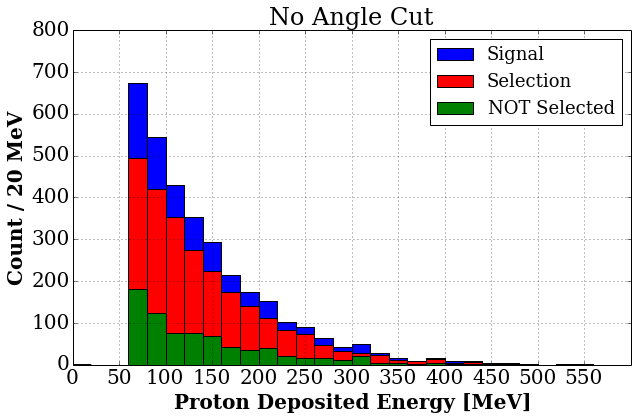

________________
0.771454656117
________________


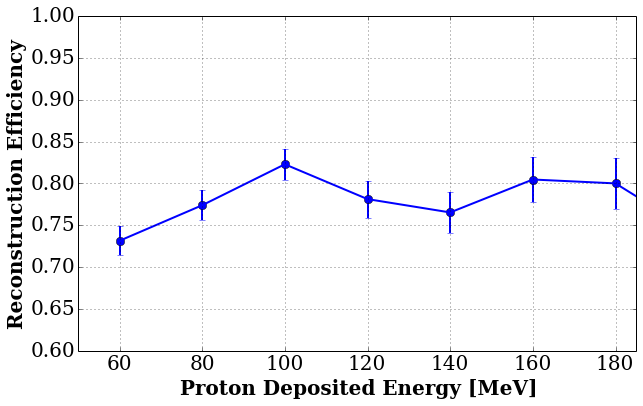

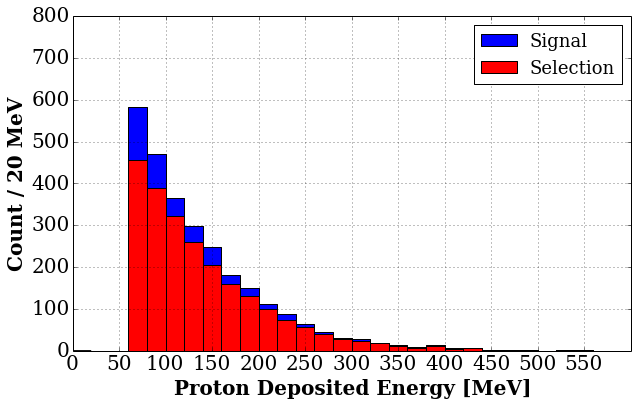

________________
0.845255474453
________________


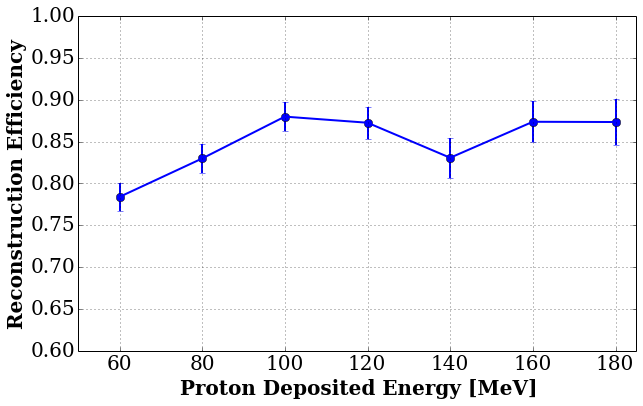

In [46]:
fig,ax=plt.subplots(figsize=(10,6))

bins=np.arange(0,600+20,20)
mc_zdf=mc_sdf

signal_h=ax.hist(mc_zdf.dep_sum_proton.values,
                 bins=bins,color='blue',label='Signal')
signal_v=signal_h[0]
energy_v=signal_h[1]

reco_h=ax.hist(mc_sdf.ix[n_reco_v].dep_sum_proton.values,
               bins=bins,color='red',label='Selection')
reco_v=reco_h[0]

g0=ax.hist(mc_drop.dep_sum_proton.values,
        bins=bins,color='green',label='NOT Selected')
ax.set_xticks(np.arange(0,600,50))
ax.set_ylim(0,800)
ax.set_xlabel("Proton Deposited Energy [MeV]",fontweight='bold')
ax.set_ylabel("Count / 20 MeV",fontweight='bold')
ax.set_title("No Angle Cut")
ax.legend(loc='best',fontsize=18)
plt.grid()
plt.show()
fig,ax=plt.subplots(figsize=(10,6))

eff_v=reco_v/signal_v
print "________________"
print reco_v.sum()/signal_v.sum()
print "________________"
energy_v = energy_v[:12]
eff_v    = eff_v[:12]
signal_v = signal_v[:12]

ax.plot(energy_v,eff_v,'o',
        color='blue',markersize=8)
ax.errorbar(energy_v,eff_v,
            yerr=np.sqrt(eff_v*(1-eff_v)/signal_v),
            lw=2,
            color='blue')

ax.set_xlim(50,185)
ax.set_ylim(0.6,1.0)
ax.set_xlabel("Proton Deposited Energy [MeV]",
              fontweight='bold')
ax.set_ylabel("Reconstruction Efficiency",
              fontweight='bold')
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))

bins=np.arange(0,600+20,20)
mc_zdf=mc_sdf.iloc[p2_sl_]

signal_h=ax.hist(mc_zdf.dep_sum_proton.values,
                 bins=bins,color='blue',label='Signal')
signal_v=signal_h[0]
energy_v=signal_h[1]

reco_h=ax.hist(mc_sdf.ix[n_reco_v].iloc[p2_rl_].dep_sum_proton.values,
               bins=bins,color='red',label='Selection')
reco_v=reco_h[0]


#g1=ax.hist(mc_drop.iloc[p2_dl_].dep_sum_proton.values,
#        bins=bins,color='green',label='NOT Selected')
ax.set_xticks(np.arange(0,600,50))
ax.set_ylim(0,800)
ax.set_xlabel("Proton Deposited Energy [MeV]",fontweight='bold')
ax.set_ylabel("Count / 20 MeV",fontweight='bold')
#ax.set_title("With Angle Cut")
ax.legend(loc='best',fontsize=18)
plt.grid()
plt.show()
fig,ax=plt.subplots(figsize=(10,6))

eff_v=reco_v/signal_v
print "________________"
print reco_v.sum()/signal_v.sum()
print "________________"
energy_v = energy_v[:10]
eff_v    = eff_v[:10]
signal_v = signal_v[:10]

ax.plot(energy_v,eff_v,'o',
        color='blue',markersize=8)
ax.errorbar(energy_v,eff_v,
            yerr=np.sqrt(eff_v*(1-eff_v)/signal_v),
            lw=2,
            color='blue')

ax.set_xlim(50,185)
ax.set_ylim(0.6,1.0)
ax.set_xlabel("Proton Deposited Energy [MeV]",
              fontweight='bold')
ax.set_ylabel("Reconstruction Efficiency",
              fontweight='bold')
plt.grid()
plt.show()


## Get the index number of NON back to back events with vert forward going proton

In [51]:
dump_idx=mc_sdf.iloc[p2_sl_][mc_sdf.iloc[p2_sl_].apply(proton_angle,axis=1).str[2]>0.975].index
dump_idx=mc_sdf.ix[dump_idx].index.values[~np.in1d(mc_sdf.ix[dump_idx].index.values,n_reco_v)]
print dump_idx


[ 126  236  241  278  281  298  344  421  438  442  453  473  492  509  539
  556  587  610  724  757  868  869  875 1012 1036 1053 1098 1144 1175 1212
 1227 1255 1285 1324 1343 1345 1368 1417 1420 1448 1507 1535 1564 1570 1583
 1635 1669 1749 1827 1839 1864 1908 1986 2073 2091 2111 2198 2255 2316 2345
 2536 2552 2669 2698 2741 2822 2889 2919 3056 3095 3121 3133 3168 3185 3204
 3263 3267 3304 3328 3335 3411 3470 3530 3536 3538 3560 3630 3756 3803 3845
 3854 3903 3938 4030 4067 4096 4167 4232 4298 4345 4380 4442 4468 4571 4590
 4647 4688 4706 4711 4745 4782 4784 4797 4889 4983 5023 5093 5134 5264 5355
 5481 5498 5528 5668 5702 5748 5822 5876 5914 6085 6128 6250 6257 6340 6388
 6398 6516 6527 6557 6618 6717 6719 6739 6781 6813 6837 6946 6959 6977 6980
 7098 7105 7168 7213 7250 7257 7336 7354 7463 7481 7522 7622 7624 7633 7743
 7790 7817 7931 8024 8027 8117 8128 8161 8244 8257 8356 8382 8460 8479 8518
 8531 8564 8580 8609 8635 8662 8666 8693 8719 9093 9915]


matched r/s/e  4 , 30 , 584 ... to  4 , 30 , 584
132    0
Name: vtx3d_type, dtype: uint32


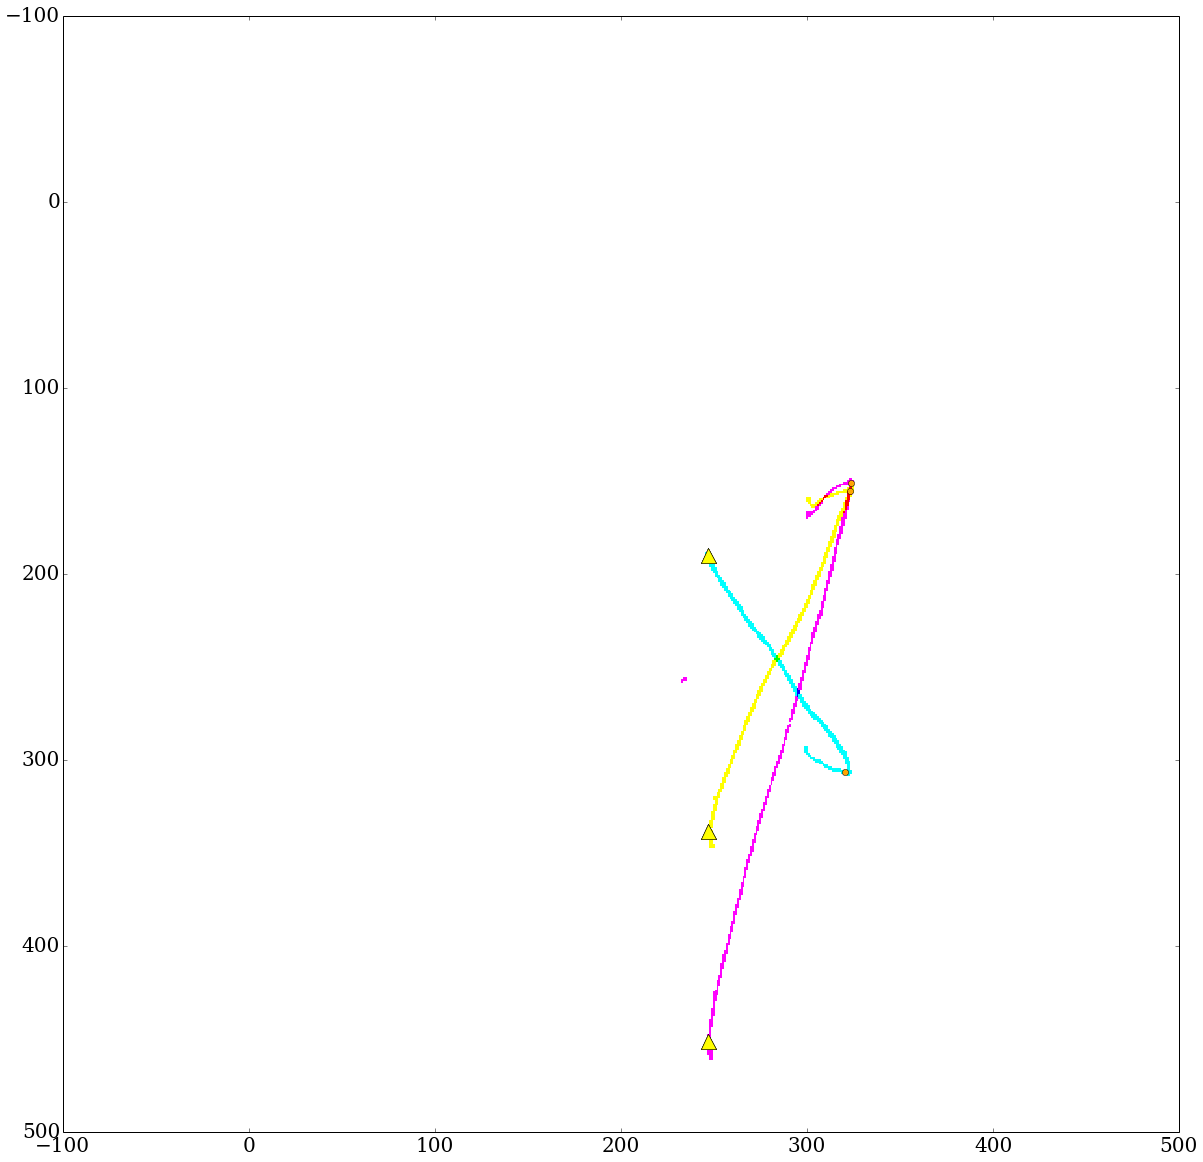

matched r/s/e  4 , 703 , 14050 ... to  4 , 703 , 14050
261    0
Name: vtx3d_type, dtype: uint32


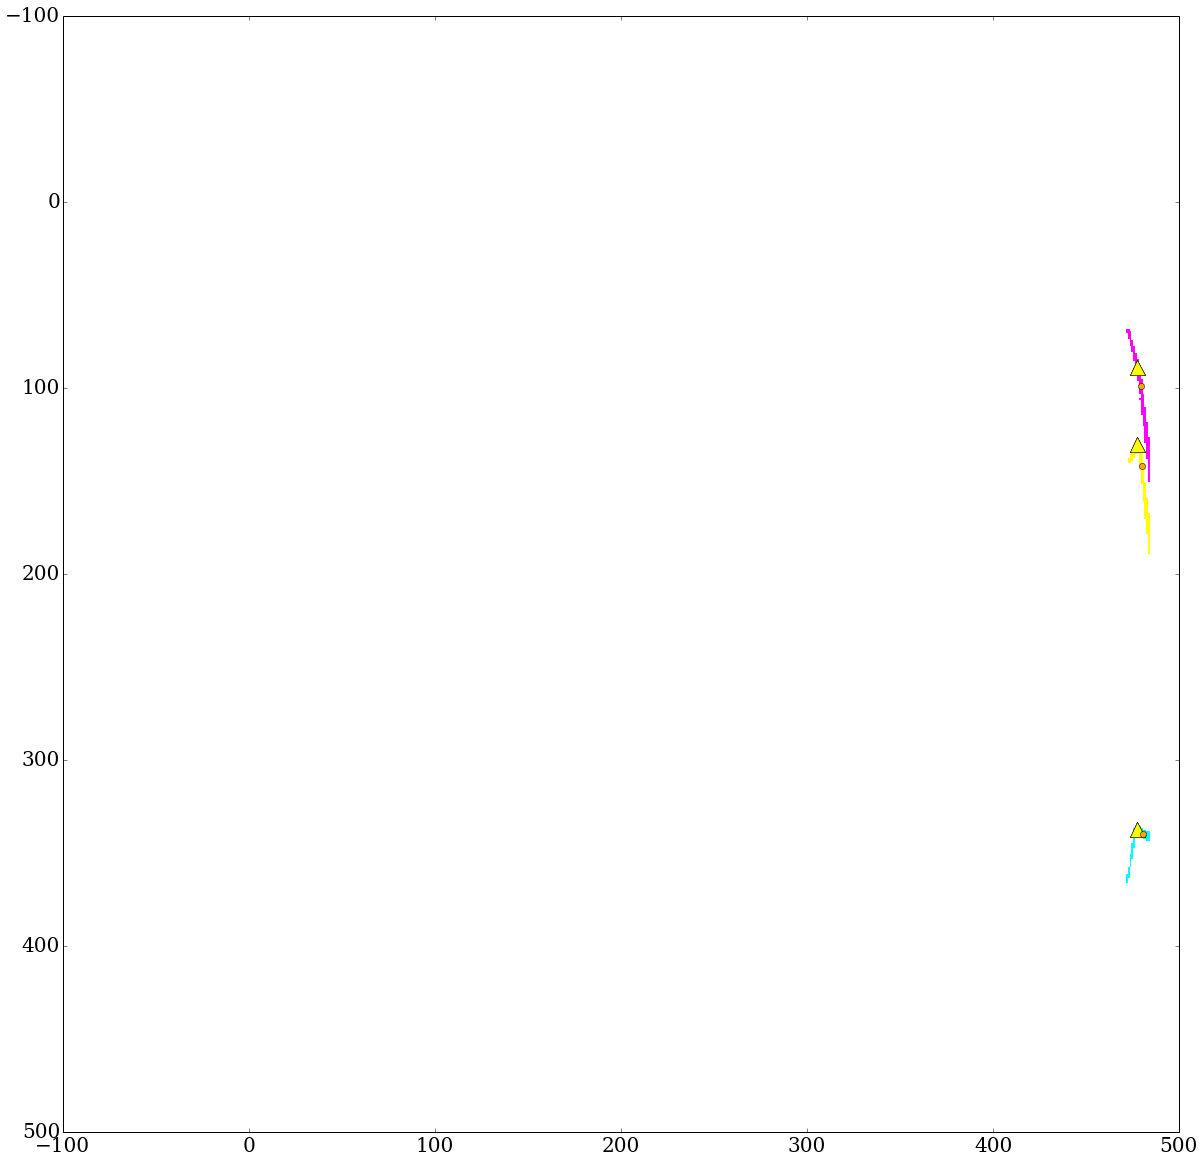

matched r/s/e  4 , 604 , 12066 ... to  4 , 604 , 12066
274    0
Name: vtx3d_type, dtype: uint32


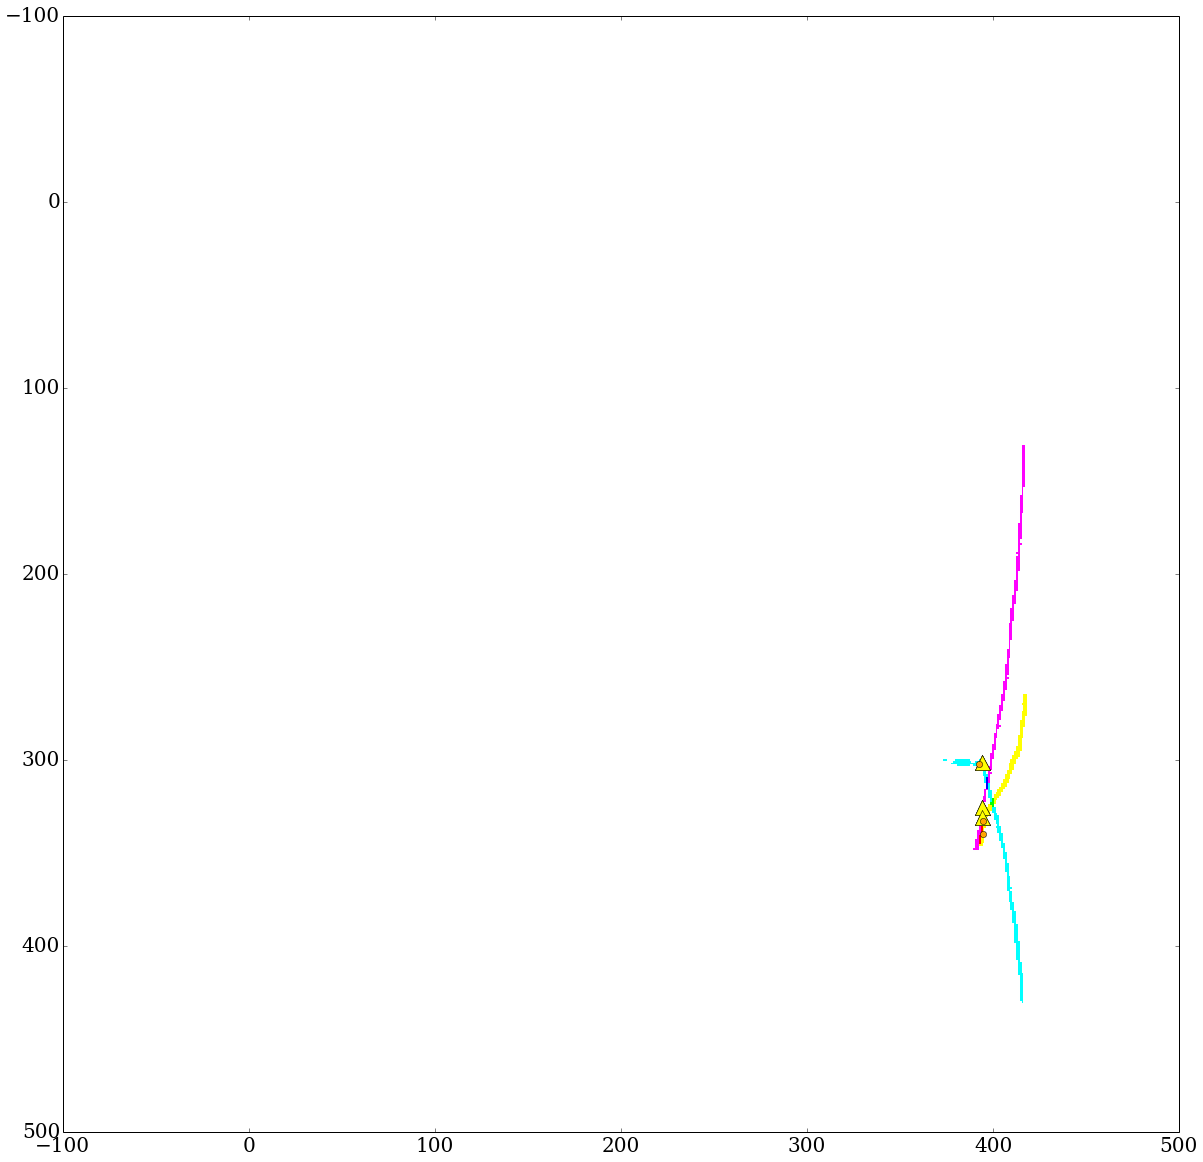

matched r/s/e  4 , 1790 , 35786 ... to  4 , 1790 , 35786
303    0
304    0
Name: vtx3d_type, dtype: uint32
303    0
304    0
Name: vtx3d_type, dtype: uint32


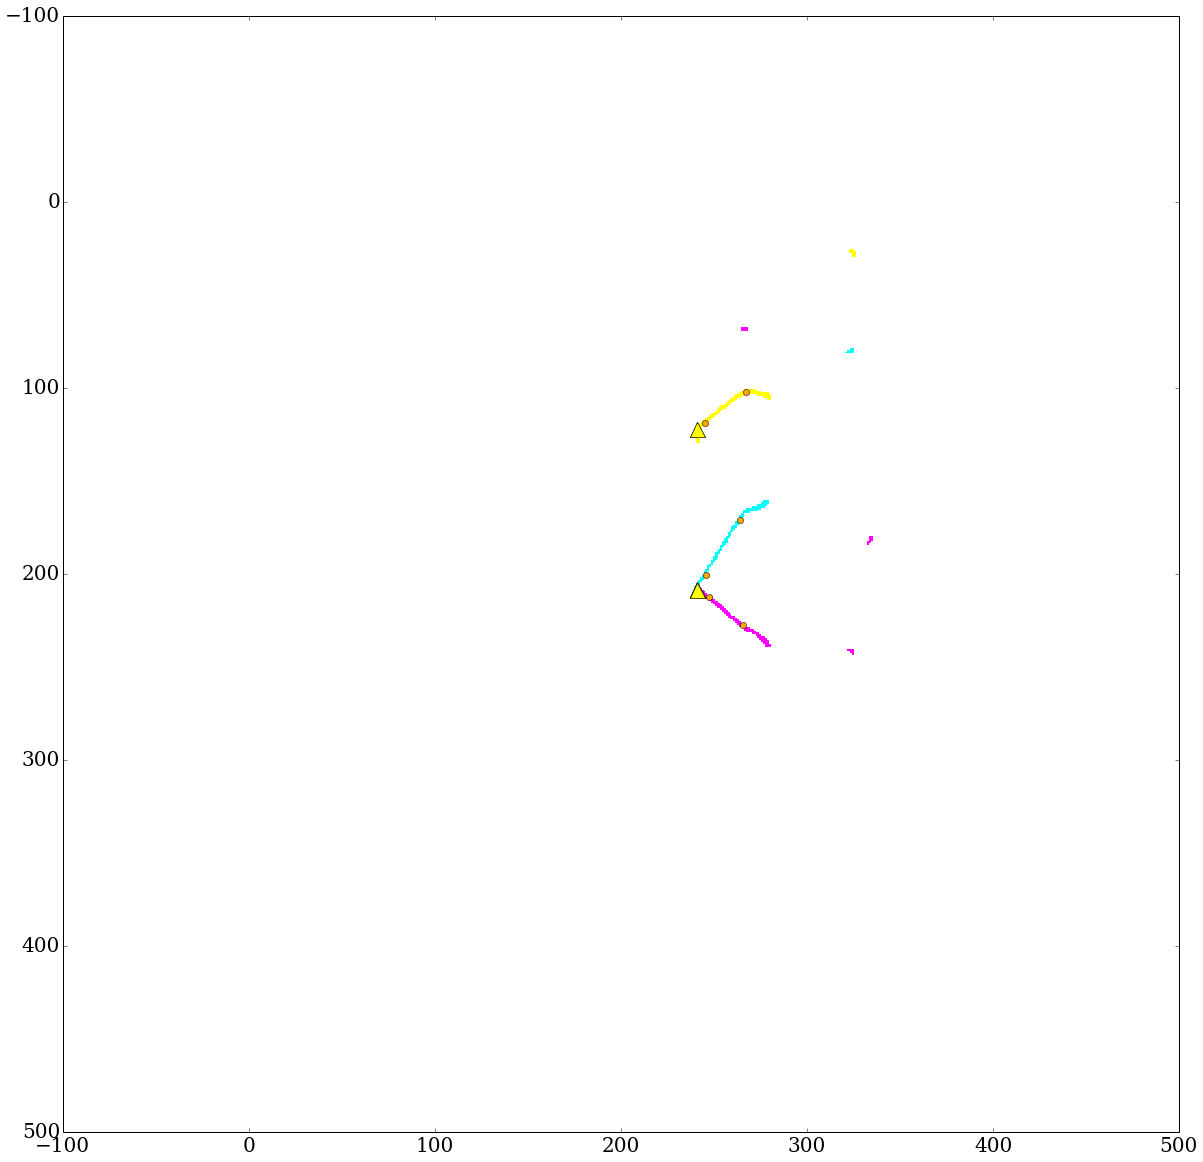

matched r/s/e  4 , 428 , 8543 ... to  4 , 428 , 8543


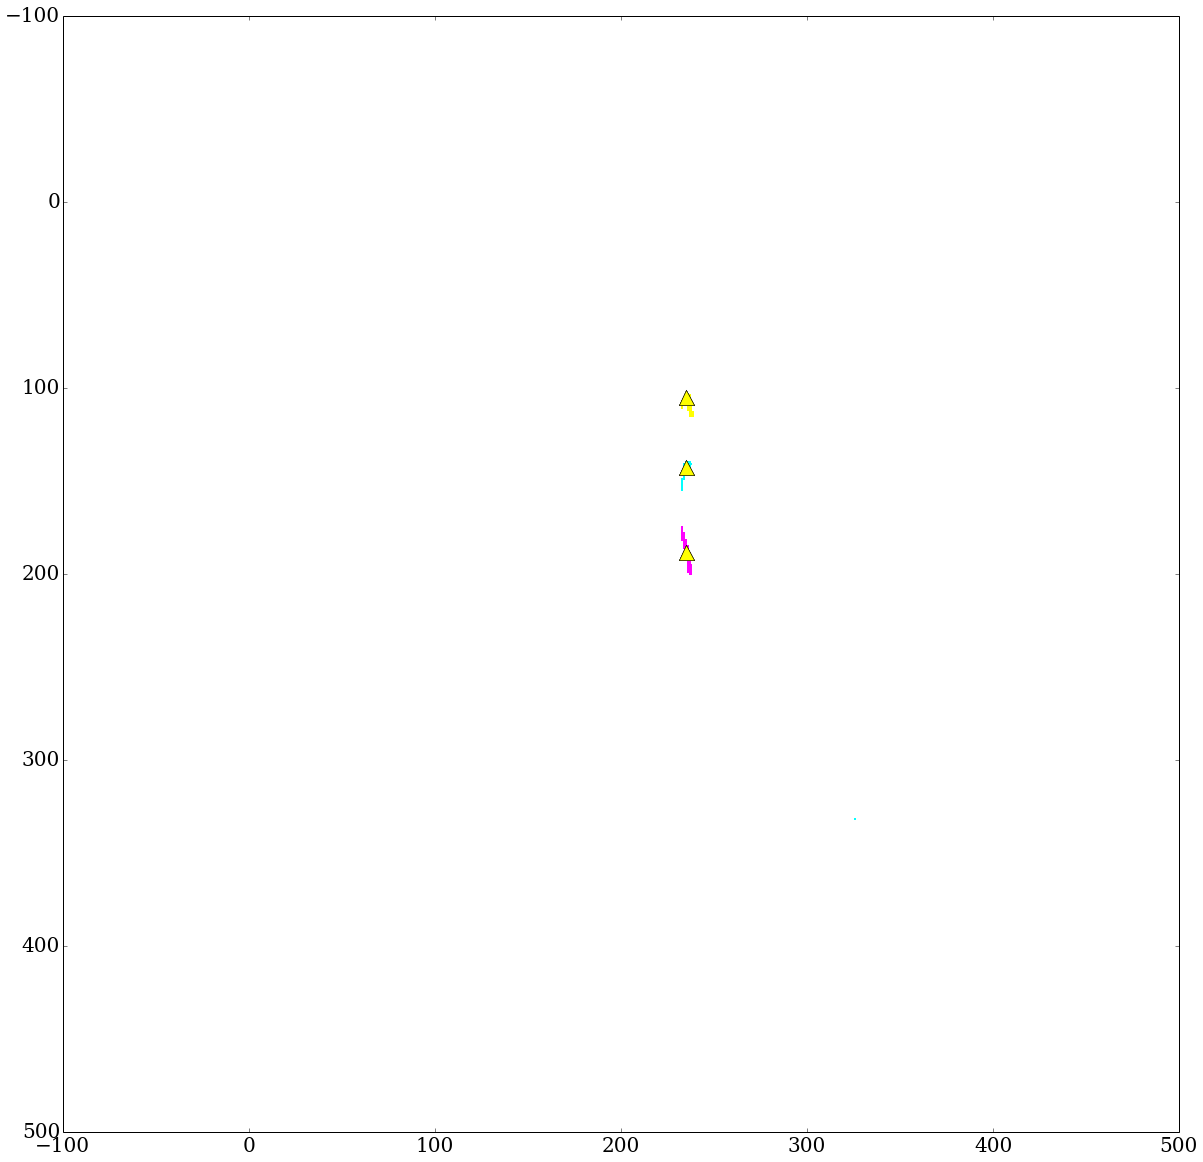

matched r/s/e  4 , 9 , 178 ... to  4 , 9 , 178


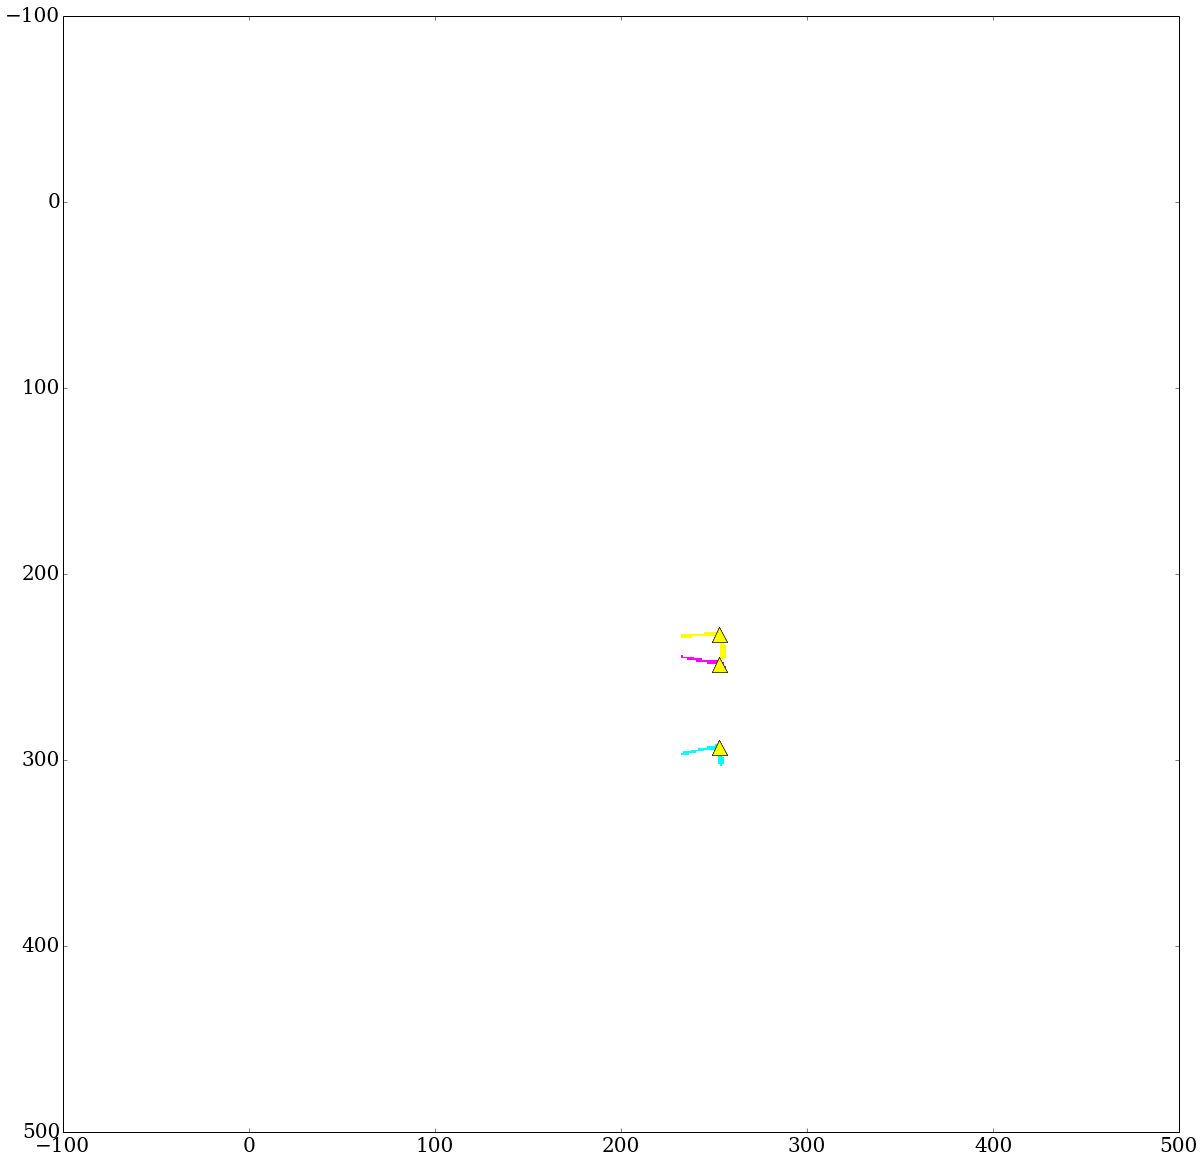

matched r/s/e  4 , 50 , 999 ... to  4 , 50 , 999


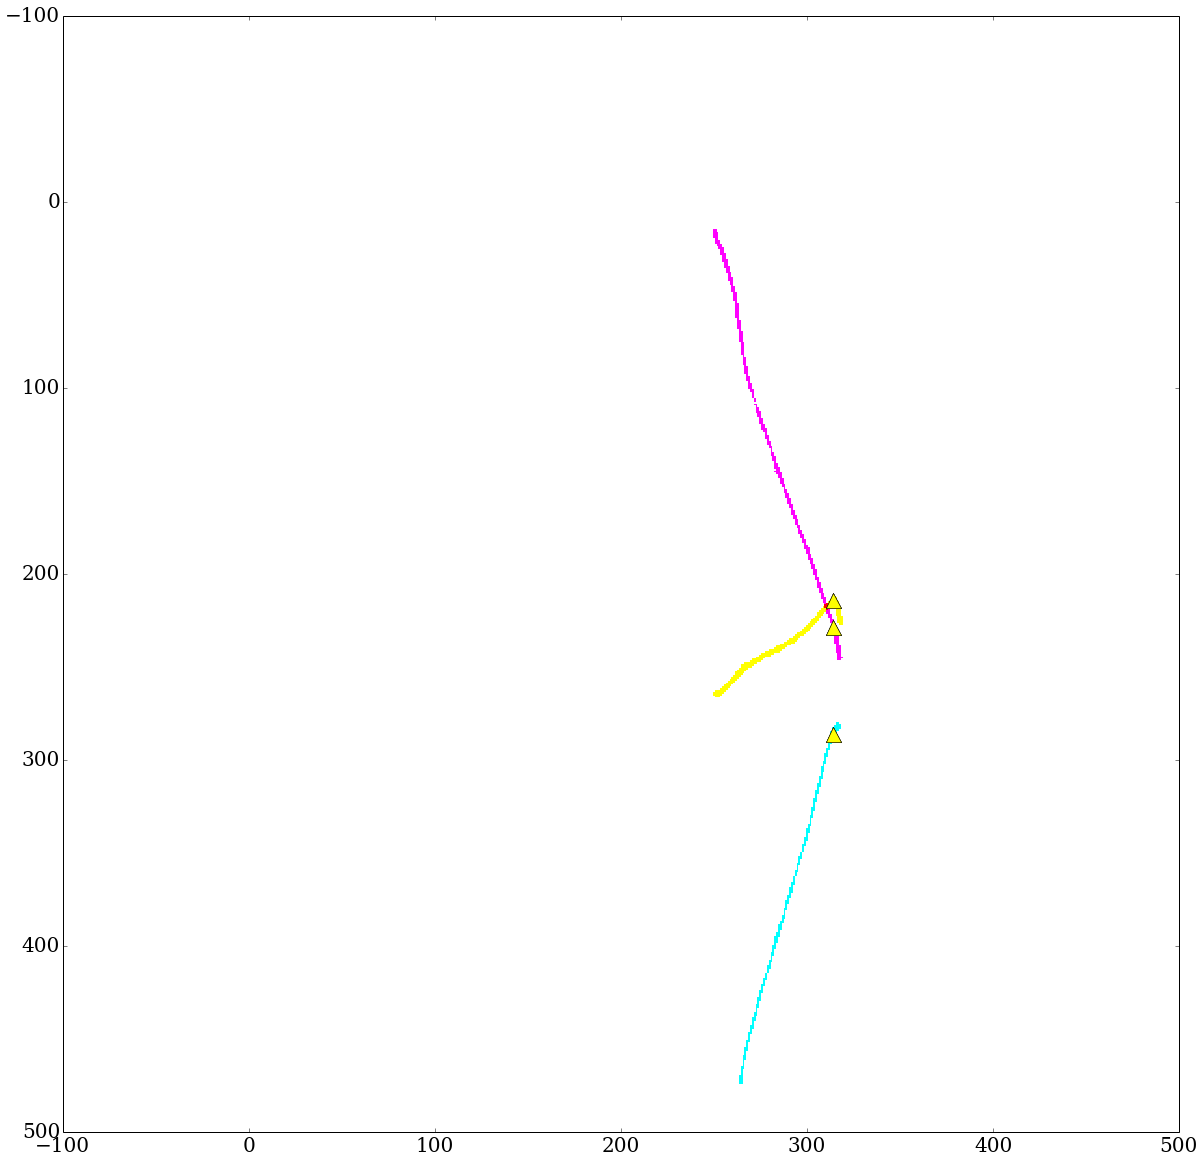

matched r/s/e  4 , 20 , 381 ... to  4 , 20 , 381


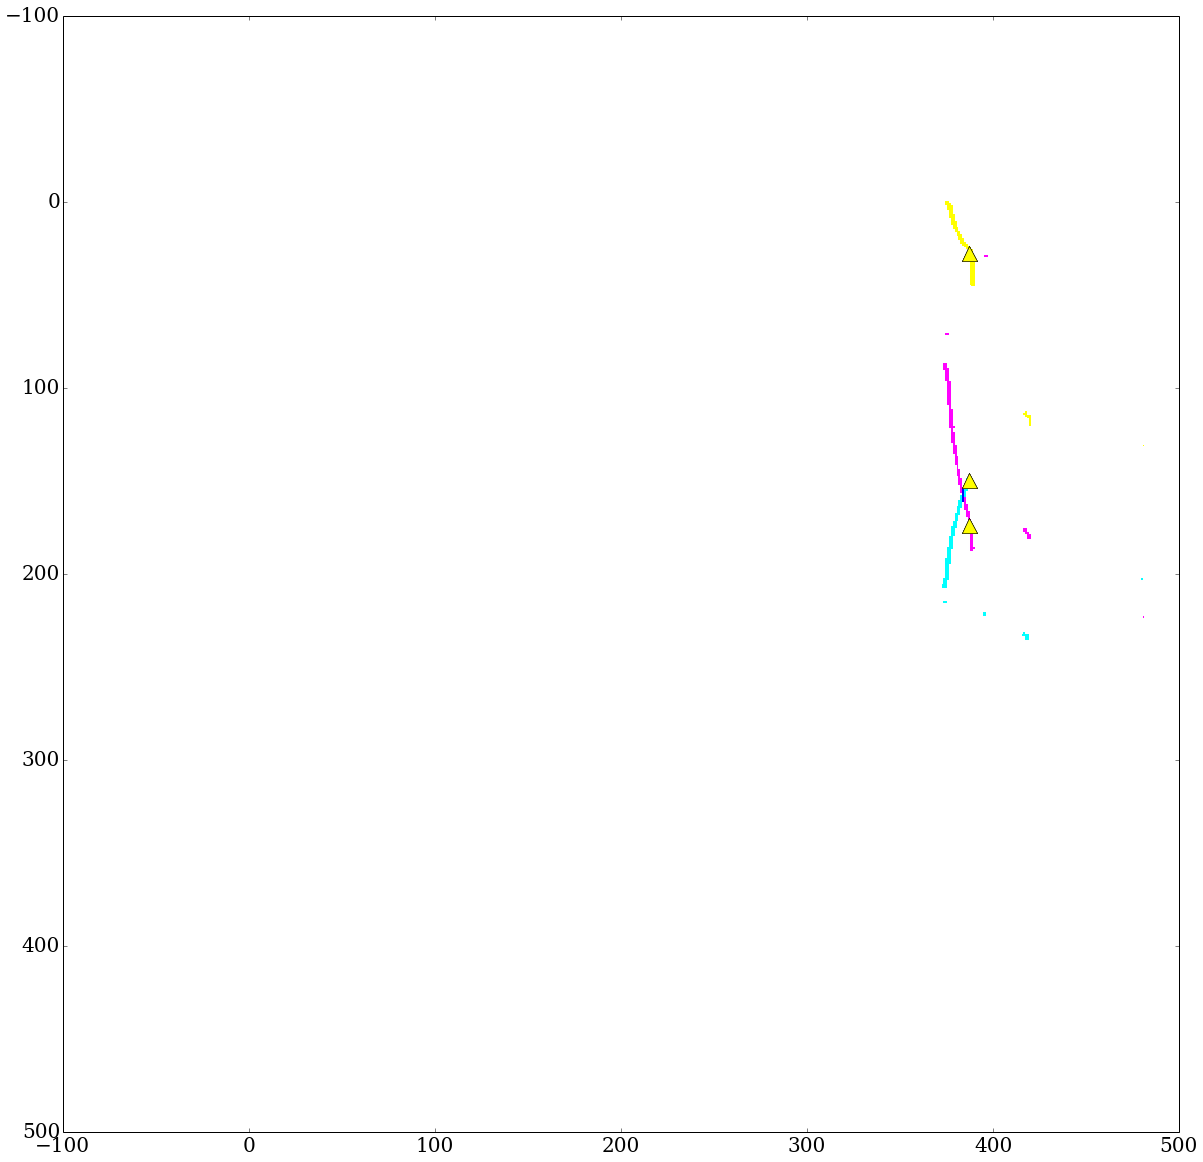

matched r/s/e  4 , 720 , 14393 ... to  4 , 720 , 14393
441    0
442    0
443    1
Name: vtx3d_type, dtype: uint32
441    0
442    0
443    1
Name: vtx3d_type, dtype: uint32
441    0
442    0
443    1
Name: vtx3d_type, dtype: uint32


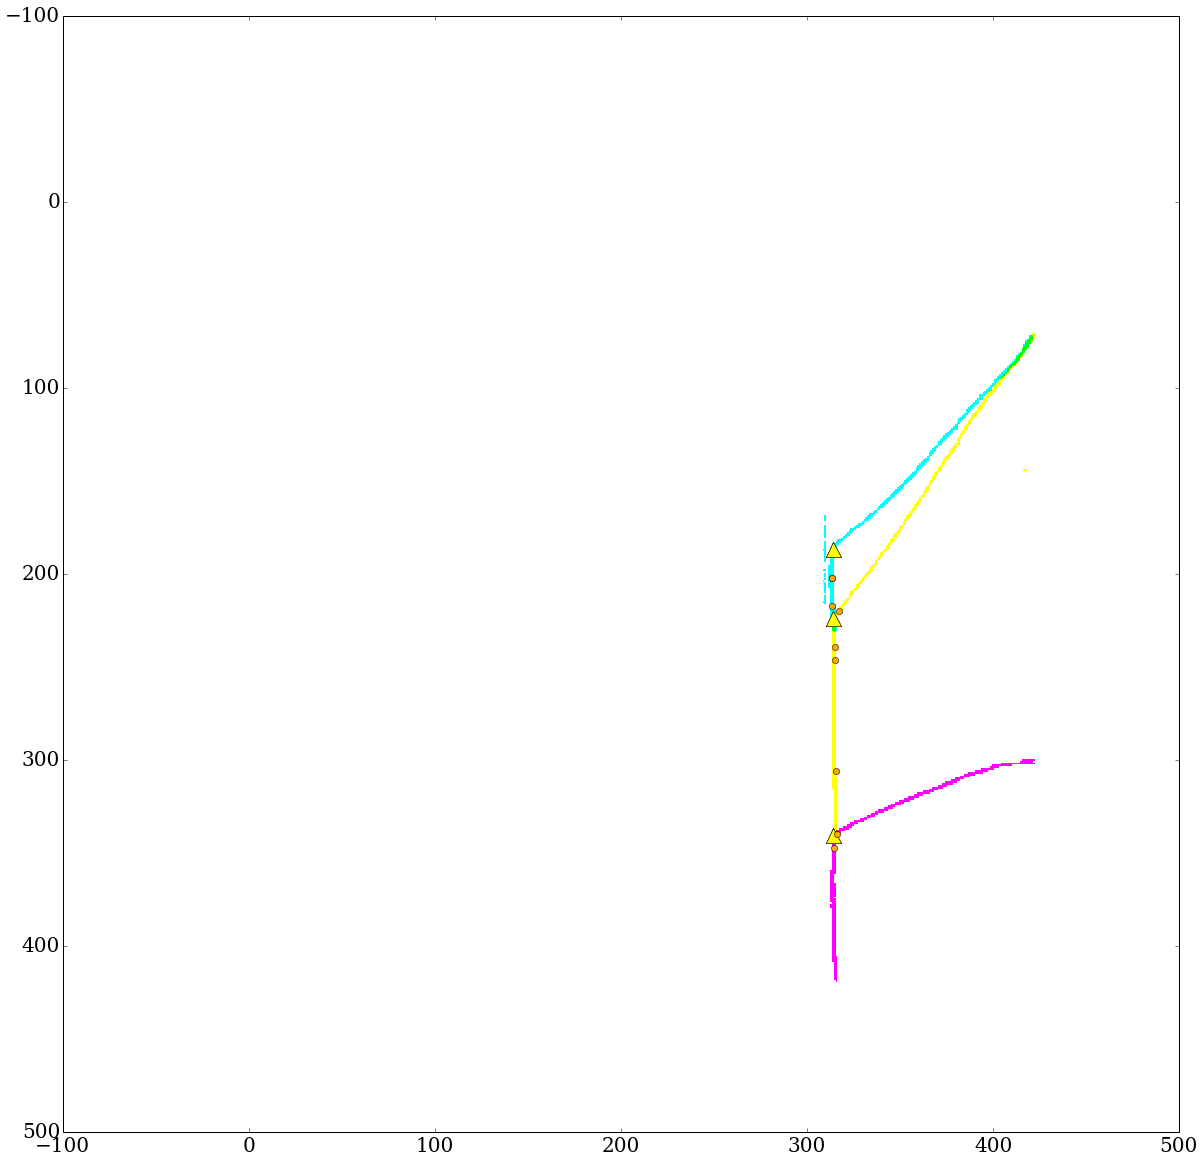

matched r/s/e  4 , 699 , 13973 ... to  4 , 699 , 13973
445    1
Name: vtx3d_type, dtype: uint32


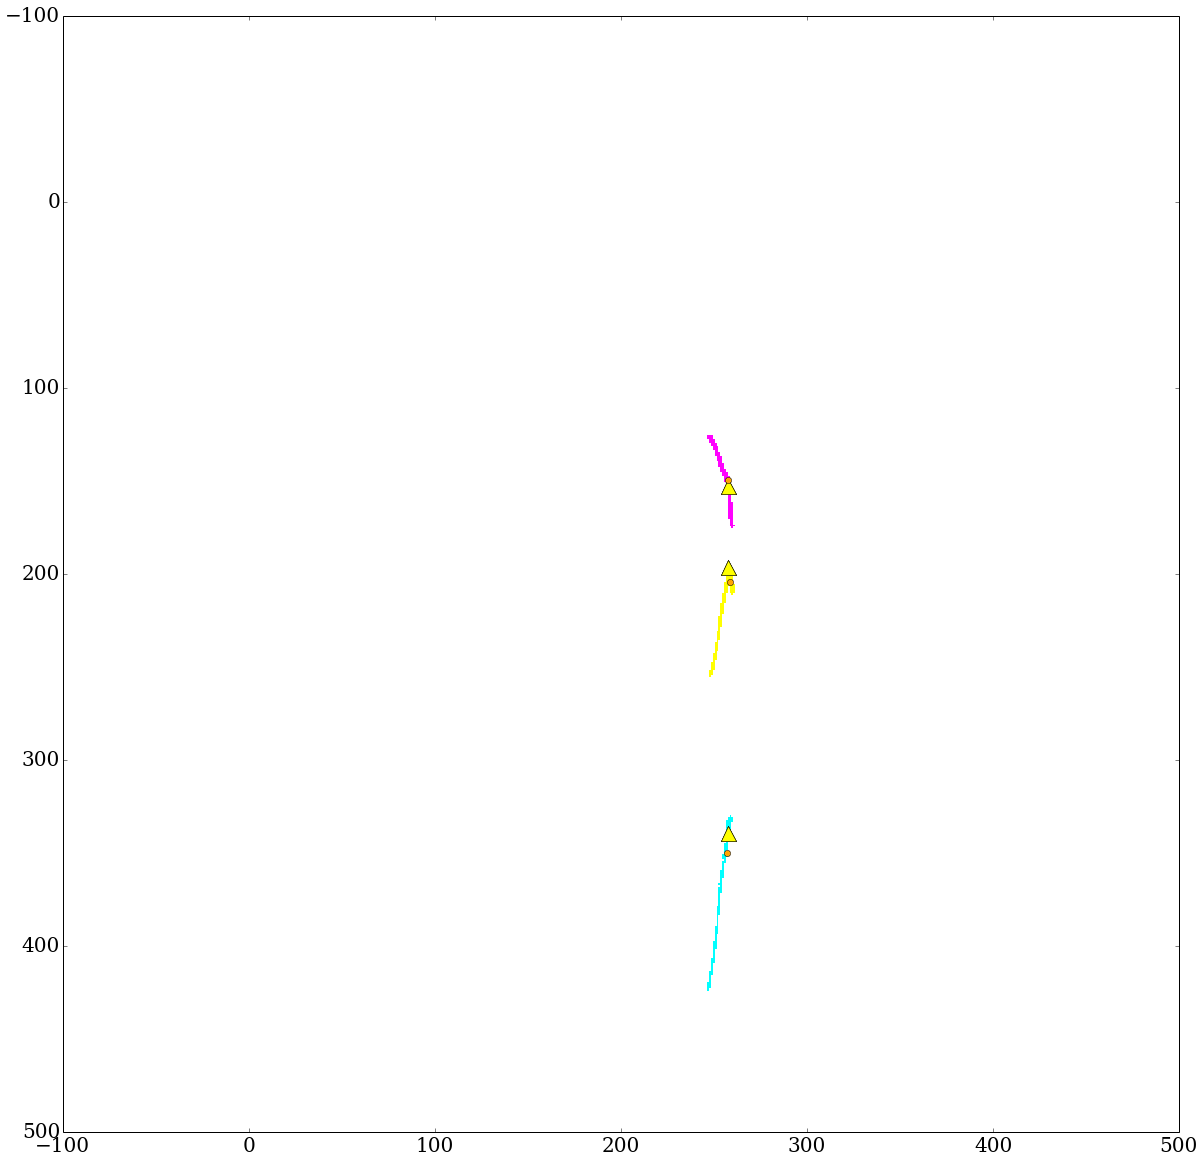

matched r/s/e  4 , 119 , 2372 ... to  4 , 119 , 2372


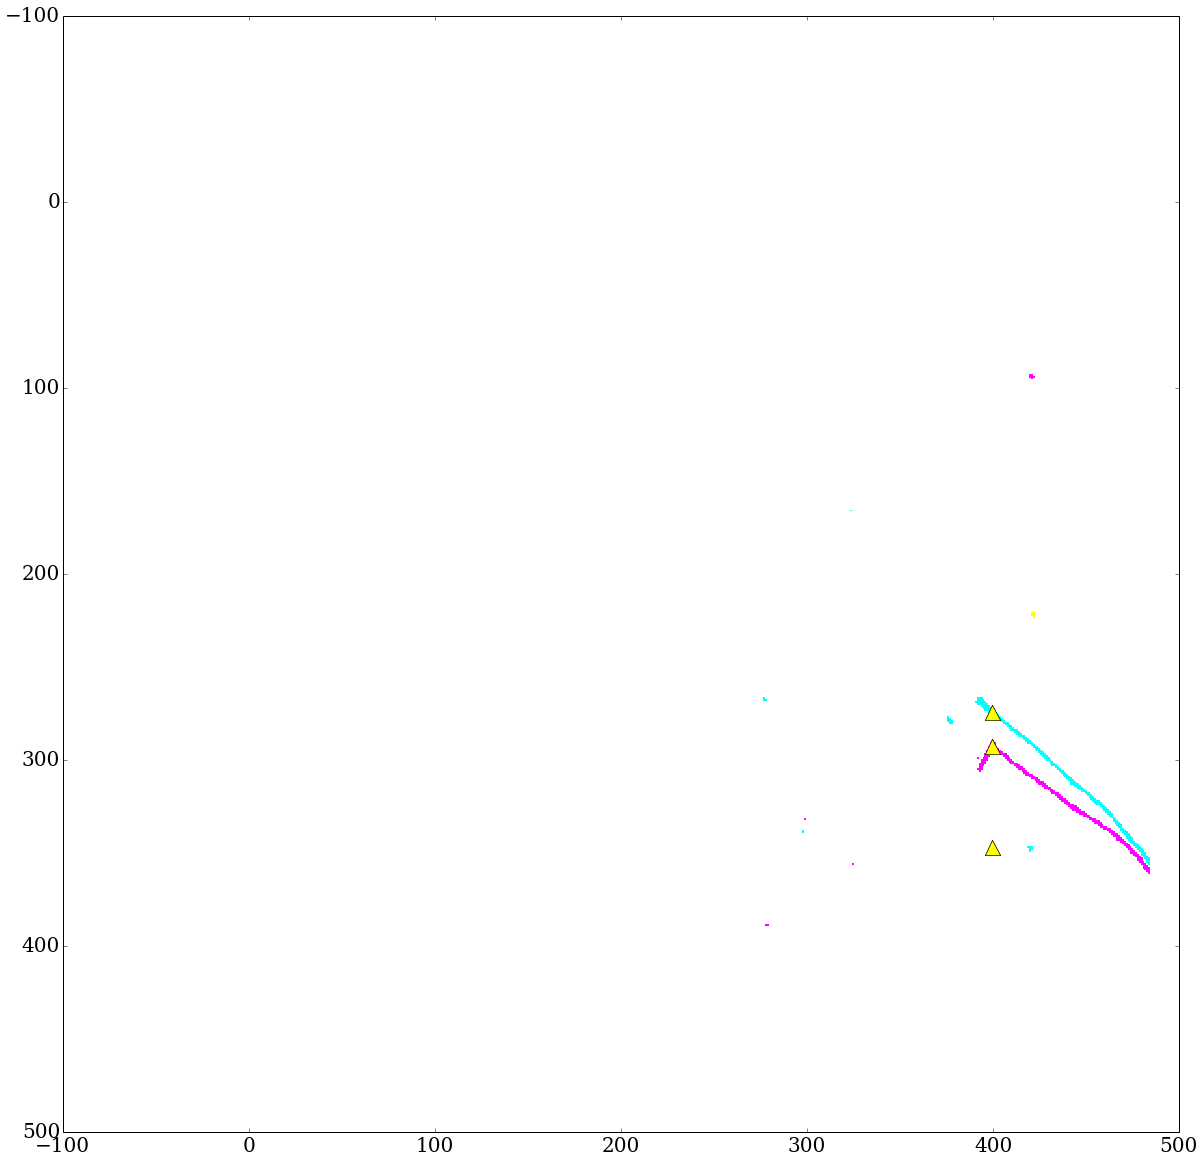

matched r/s/e  4 , 854 , 17080 ... to  4 , 854 , 17080


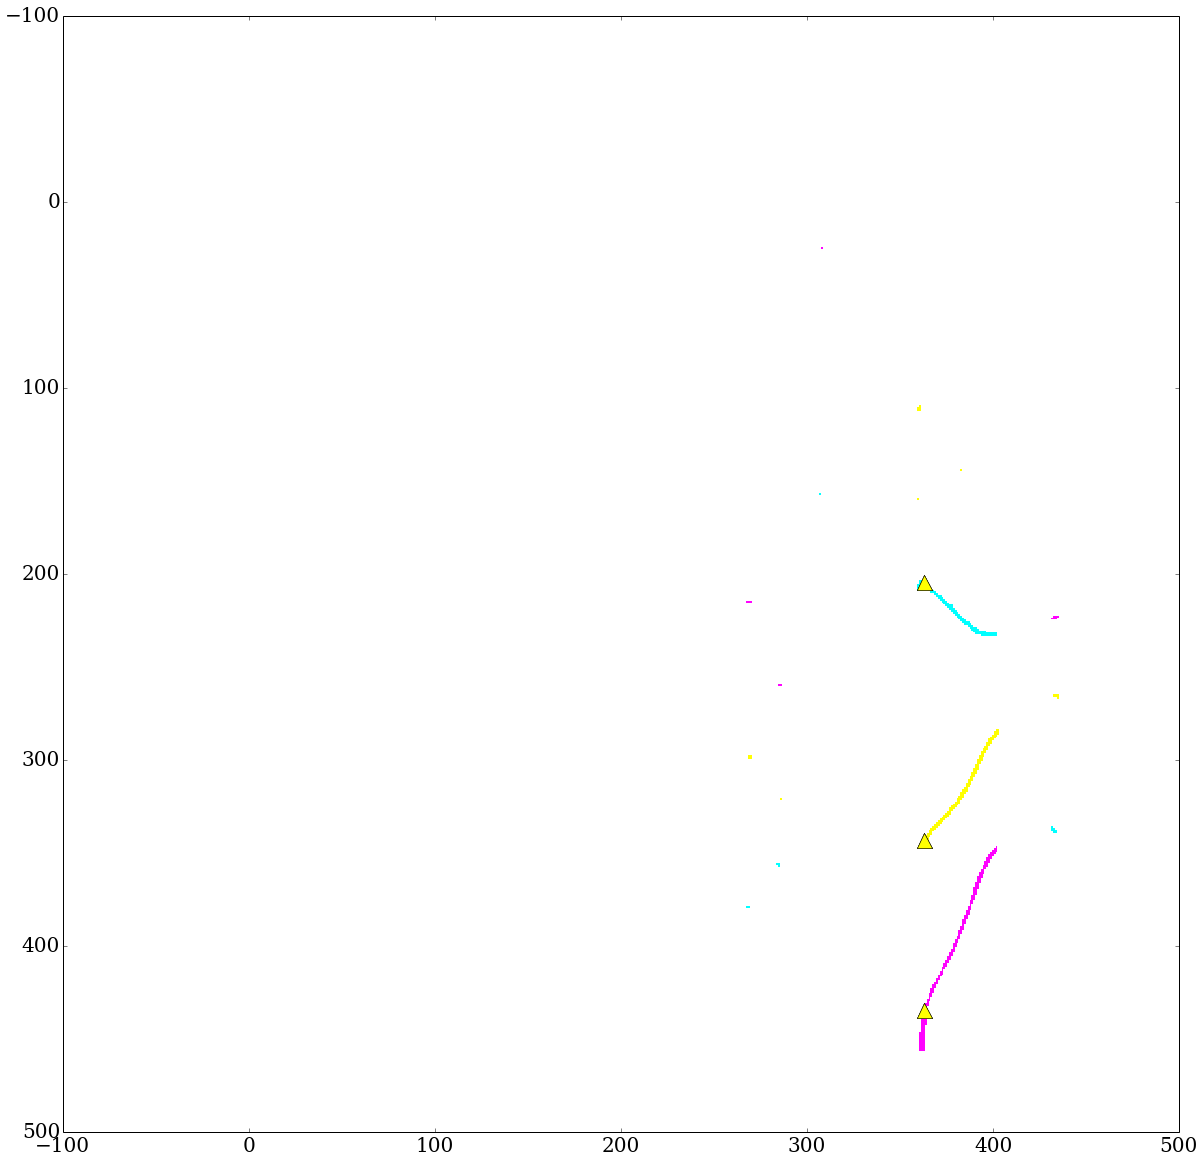

matched r/s/e  4 , 1060 , 21194 ... to  4 , 1060 , 21194
512    0
513    0
514    0
515    1
Name: vtx3d_type, dtype: uint32
512    0
513    0
514    0
515    1
Name: vtx3d_type, dtype: uint32
512    0
513    0
514    0
515    1
Name: vtx3d_type, dtype: uint32
512    0
513    0
514    0
515    1
Name: vtx3d_type, dtype: uint32


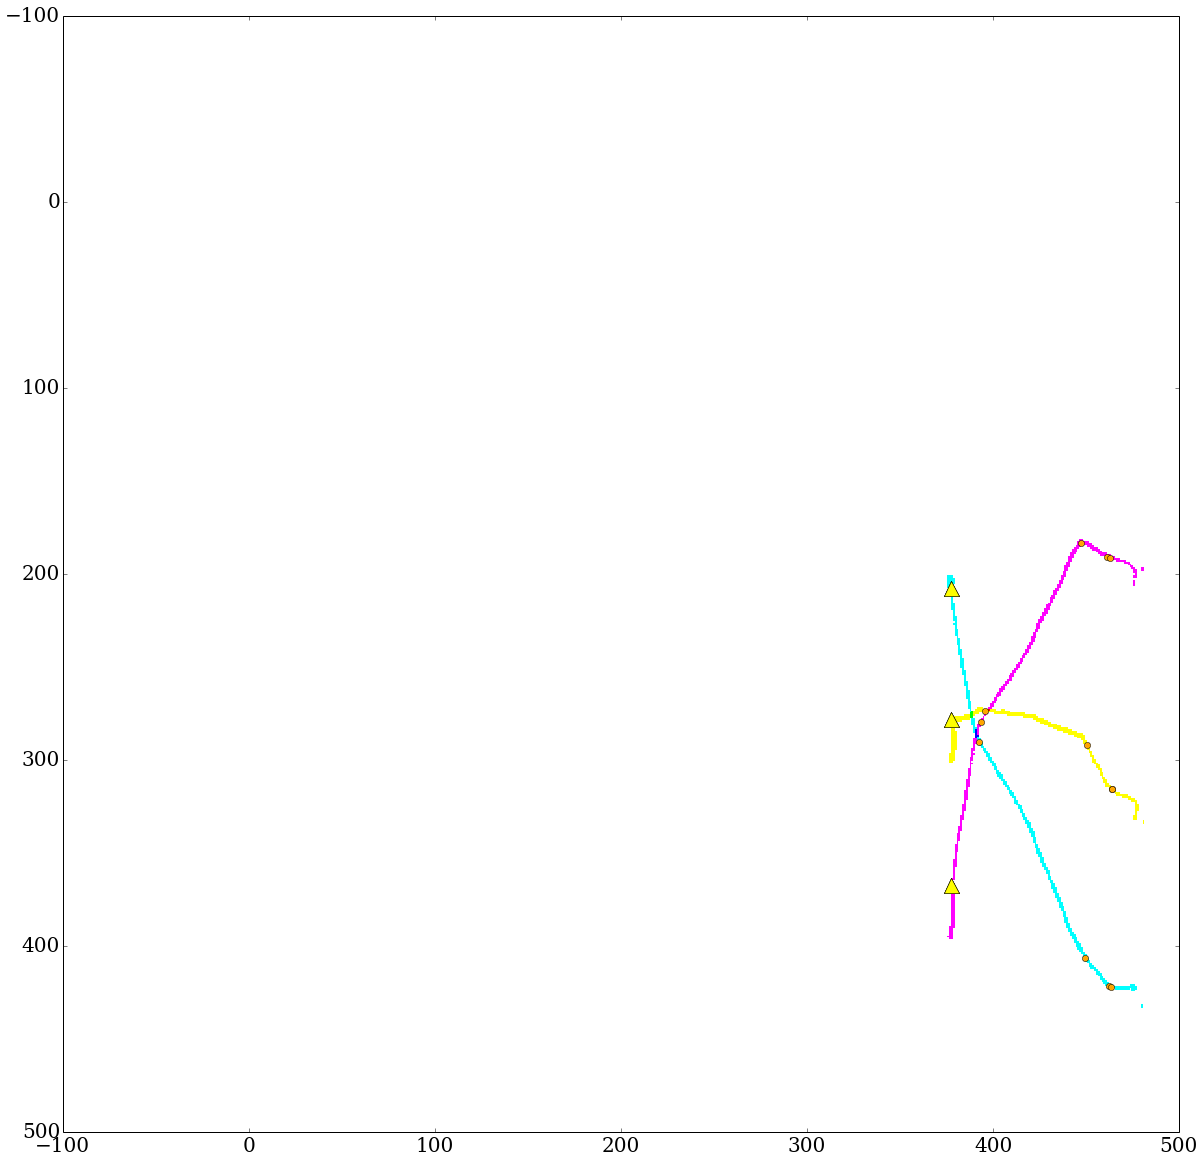

matched r/s/e  4 , 549 , 10979 ... to  4 , 549 , 10979


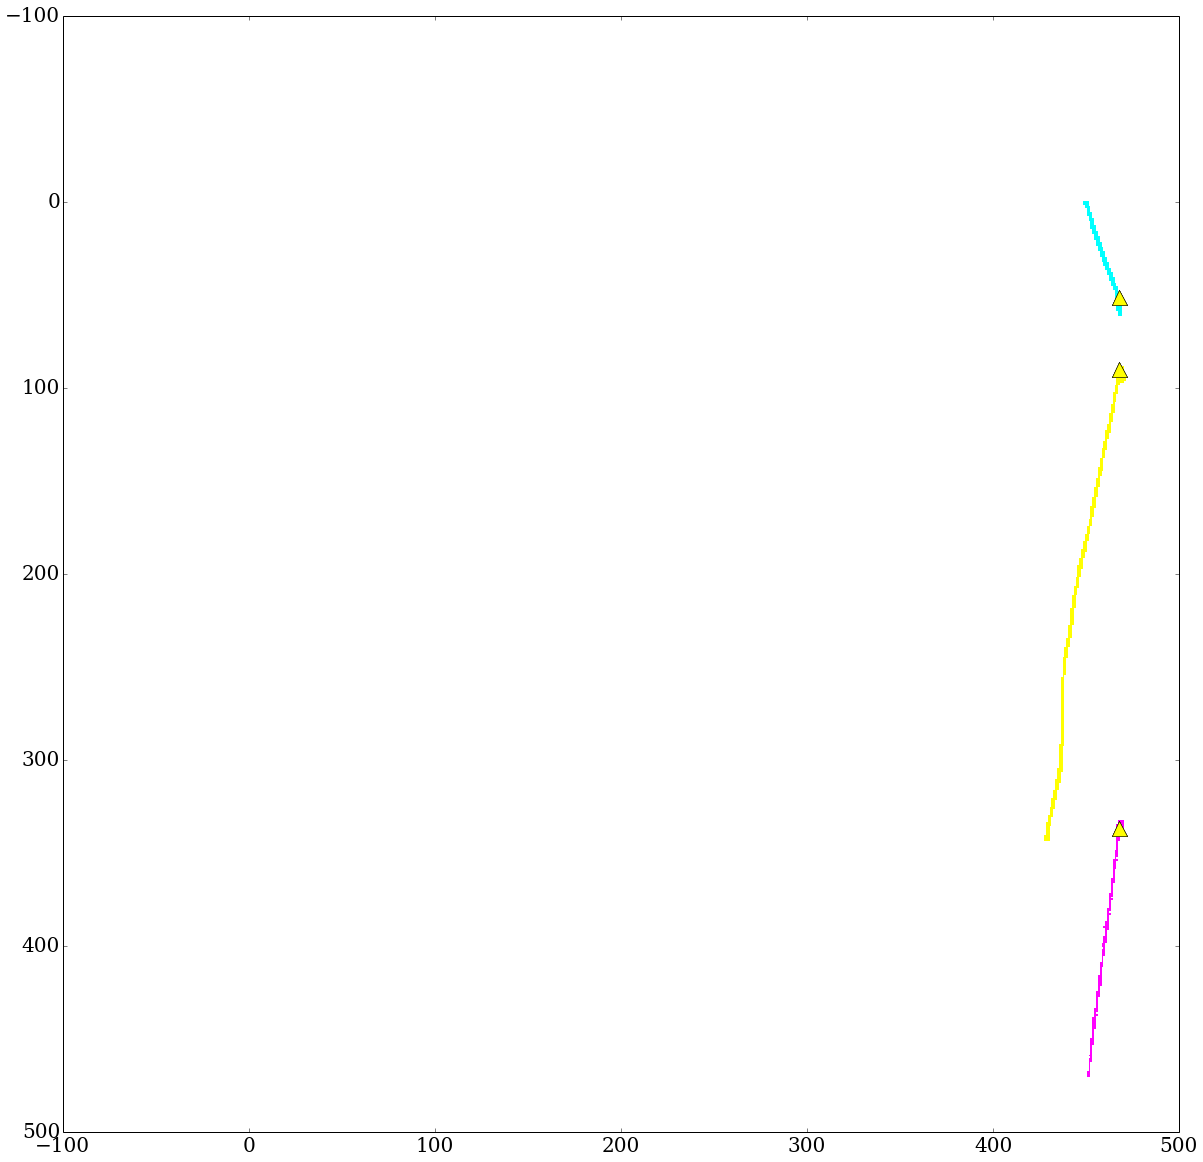

matched r/s/e  4 , 1598 , 31952 ... to  4 , 1598 , 31952
572    0
573    0
Name: vtx3d_type, dtype: uint32
572    0
573    0
Name: vtx3d_type, dtype: uint32


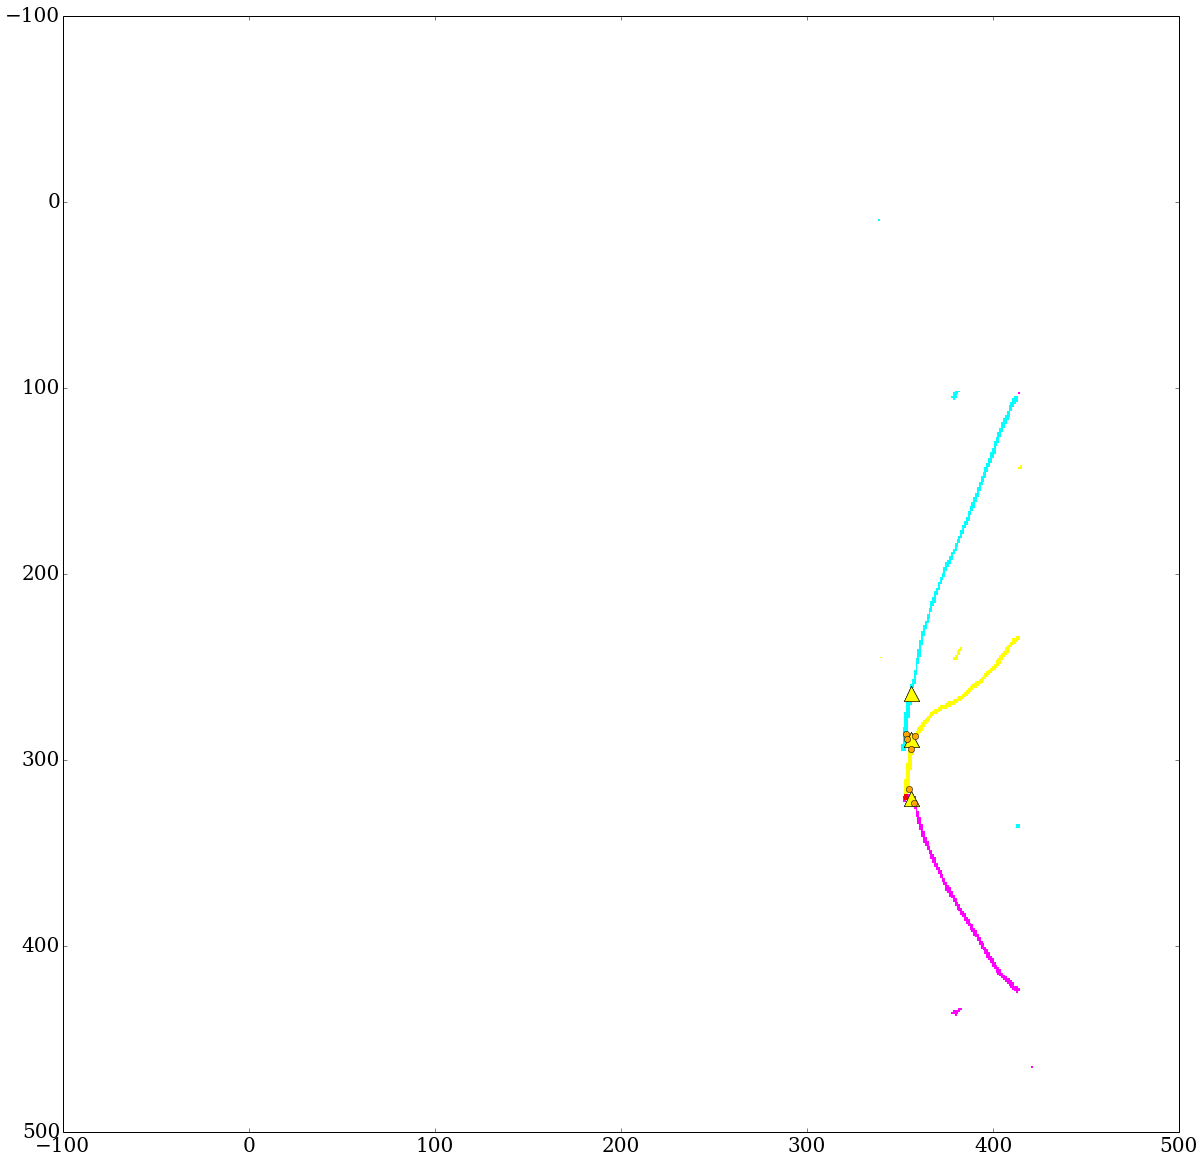

matched r/s/e  4 , 558 , 11159 ... to  4 , 558 , 11159


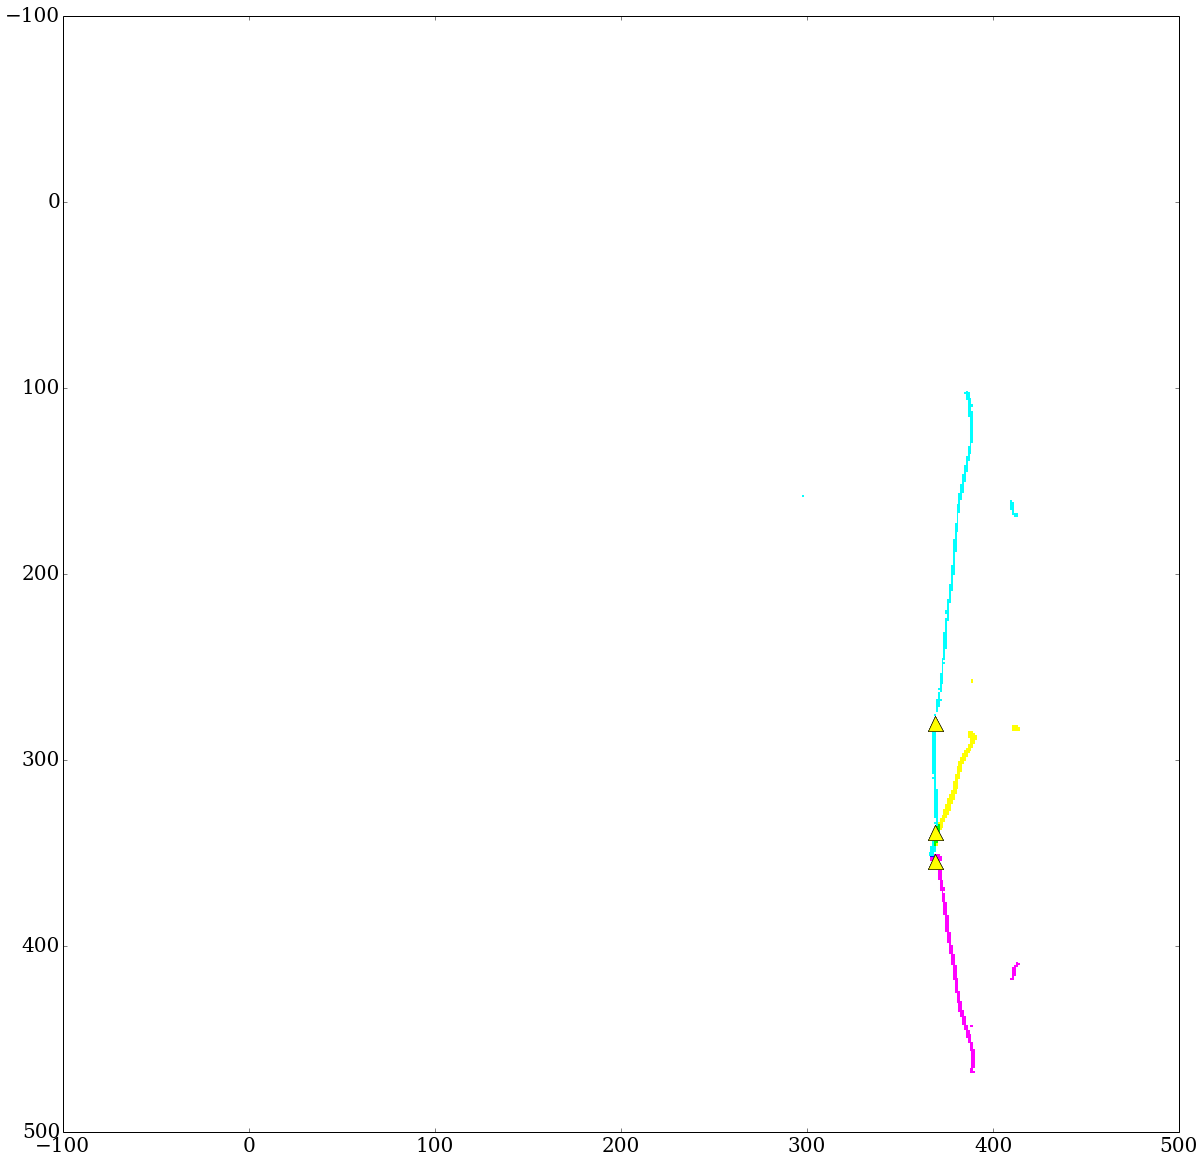

matched r/s/e  4 , 1607 , 32123 ... to  4 , 1607 , 32123


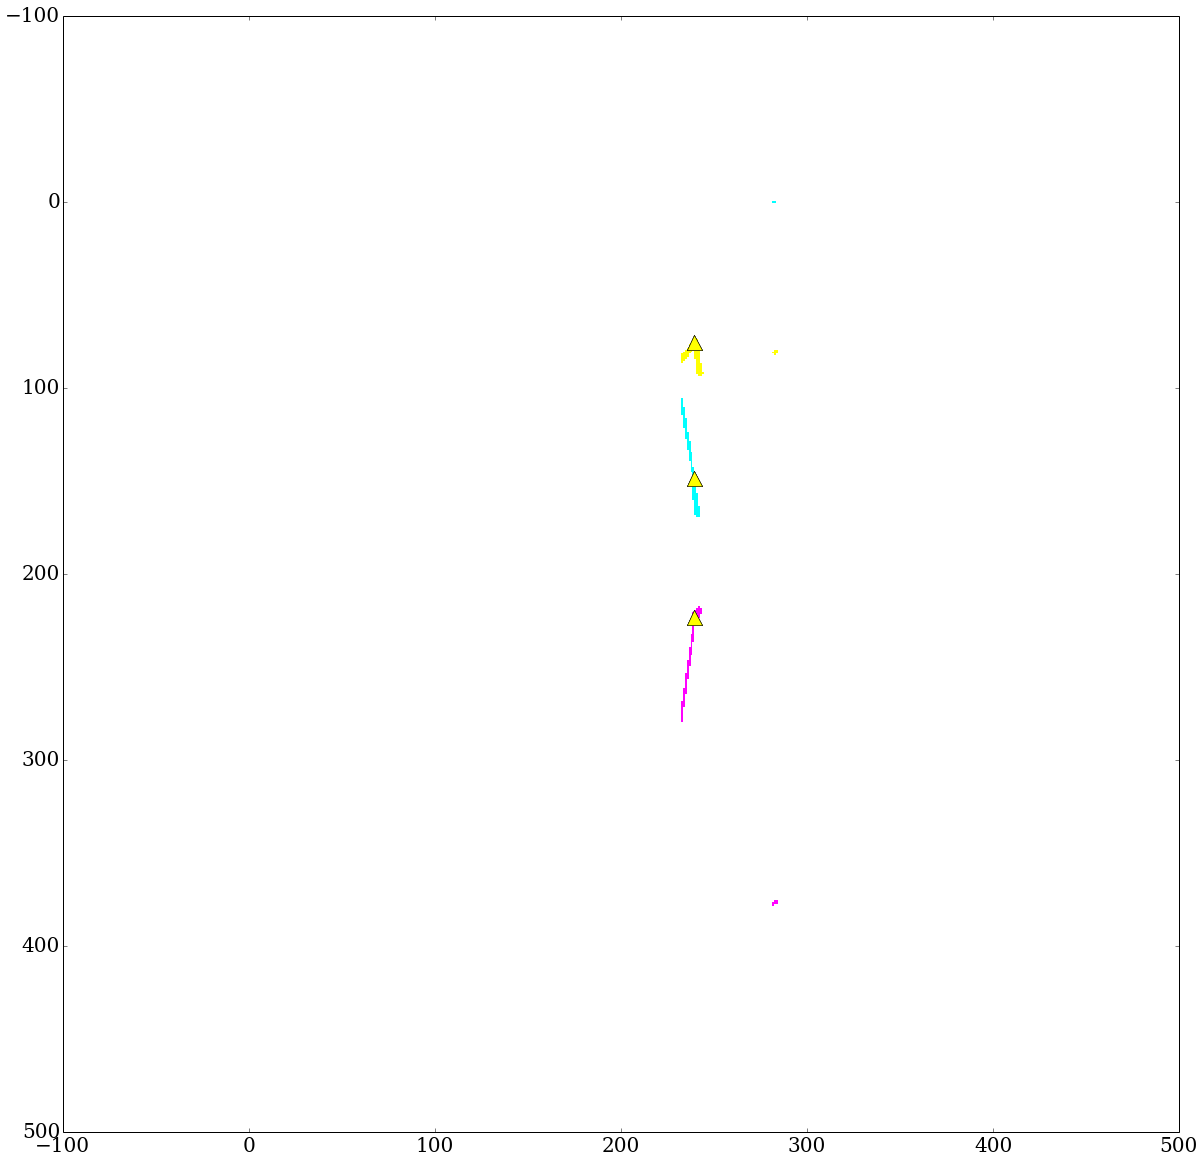

matched r/s/e  4 , 1259 , 25175 ... to  4 , 1259 , 25175
635    0
636    0
637    0
638    0
639    0
640    1
641    1
Name: vtx3d_type, dtype: uint32
635    0
636    0
637    0
638    0
639    0
640    1
641    1
Name: vtx3d_type, dtype: uint32
635    0
636    0
637    0
638    0
639    0
640    1
641    1
Name: vtx3d_type, dtype: uint32
635    0
636    0
637    0
638    0
639    0
640    1
641    1
Name: vtx3d_type, dtype: uint32
635    0
636    0
637    0
638    0
639    0
640    1
641    1
Name: vtx3d_type, dtype: uint32
635    0
636    0
637    0
638    0
639    0
640    1
641    1
Name: vtx3d_type, dtype: uint32
635    0
636    0
637    0
638    0
639    0
640    1
641    1
Name: vtx3d_type, dtype: uint32


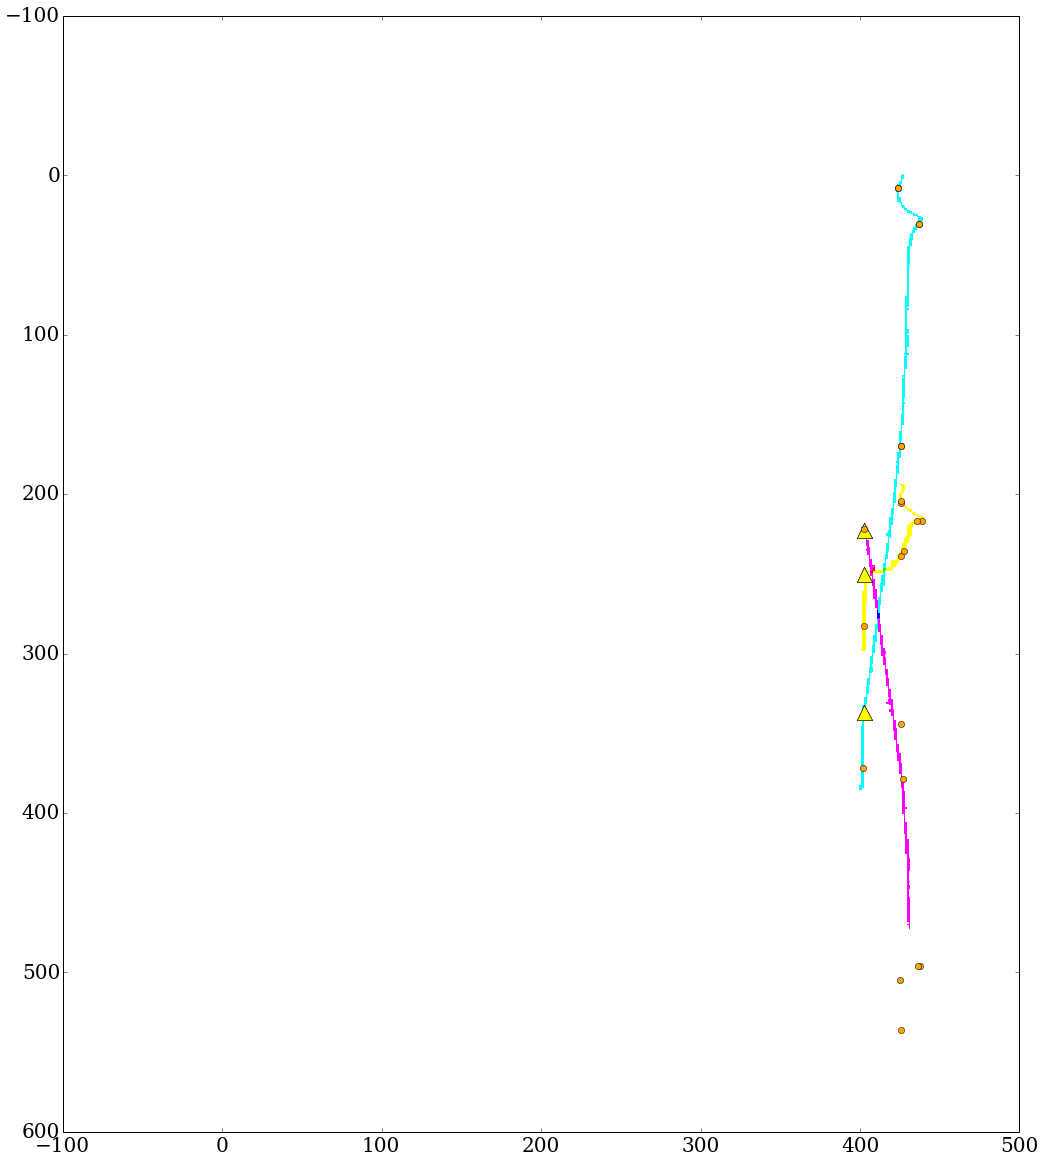

matched r/s/e  4 , 830 , 16597 ... to  4 , 830 , 16597


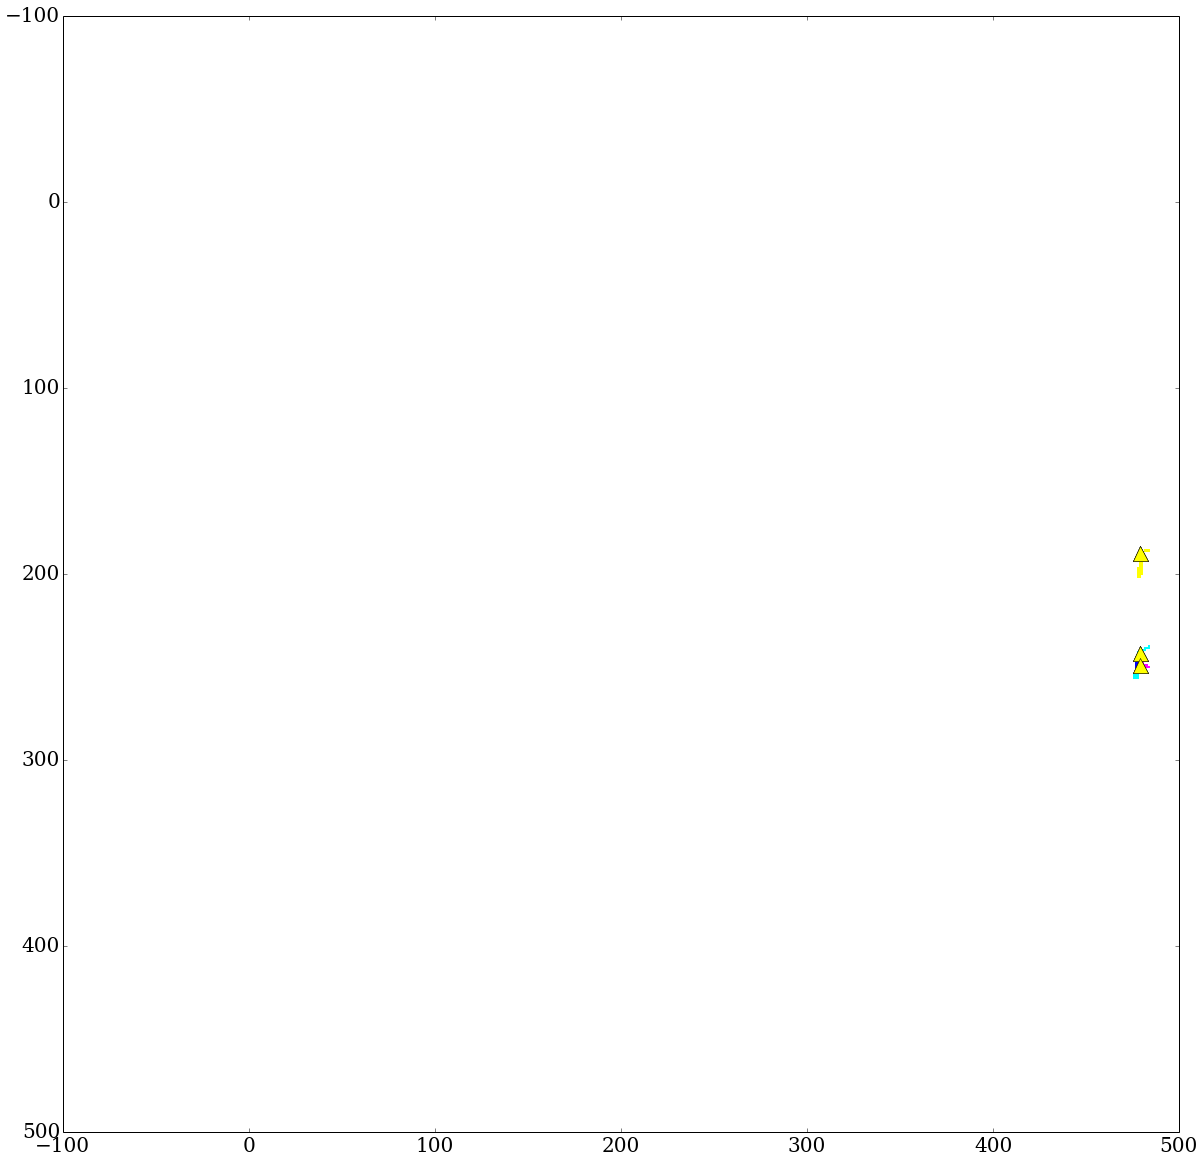

matched r/s/e  4 , 1886 , 37714 ... to  4 , 1886 , 37714
789    0
Name: vtx3d_type, dtype: uint32


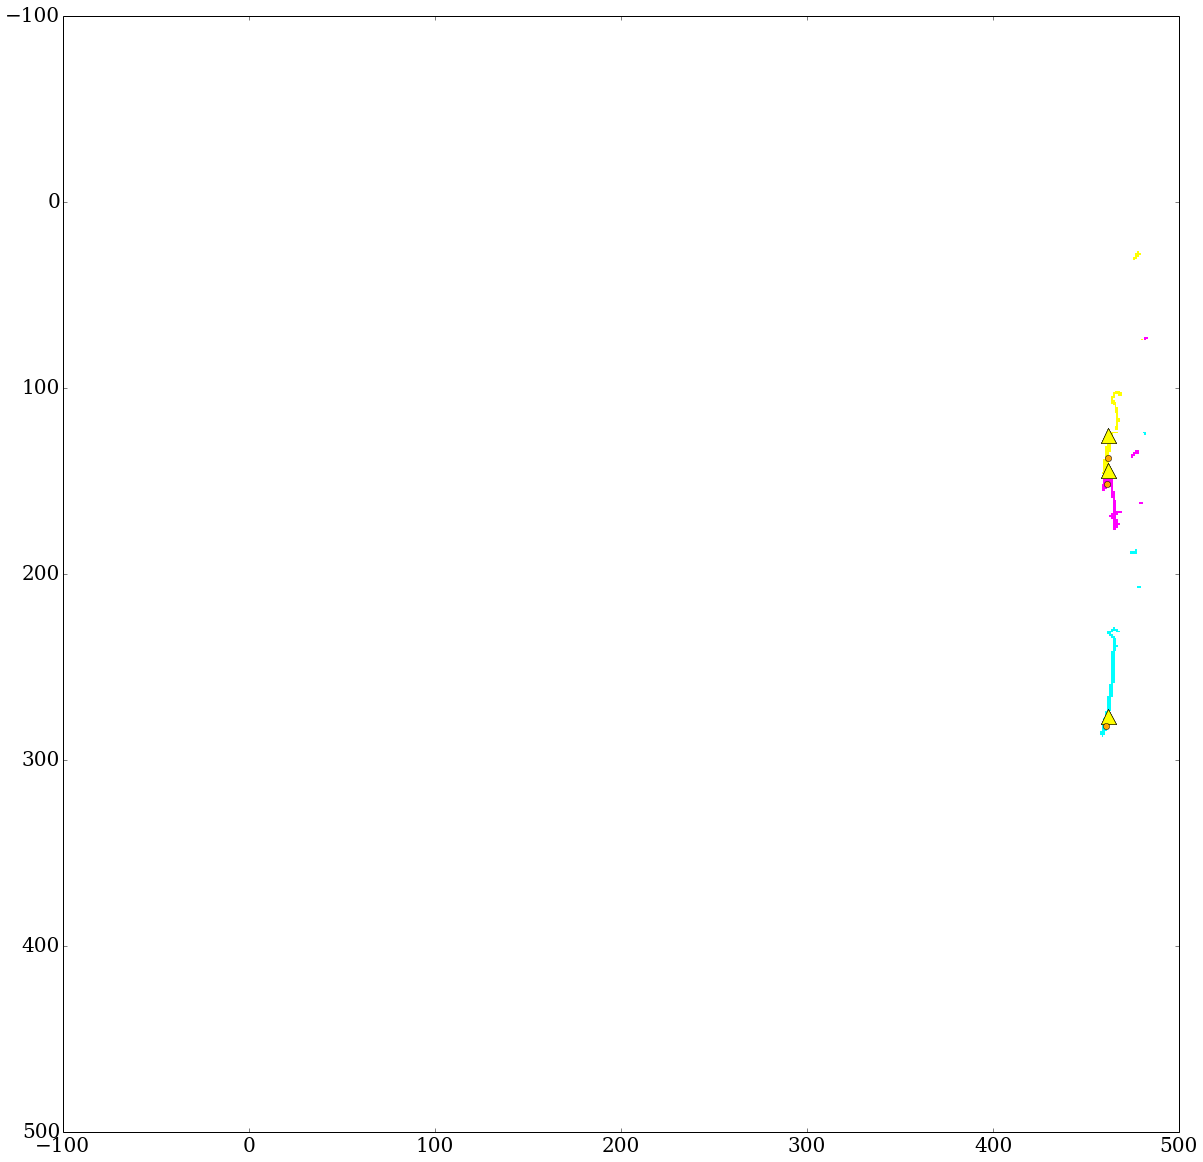

matched r/s/e  4 , 808 , 16146 ... to  4 , 808 , 16146


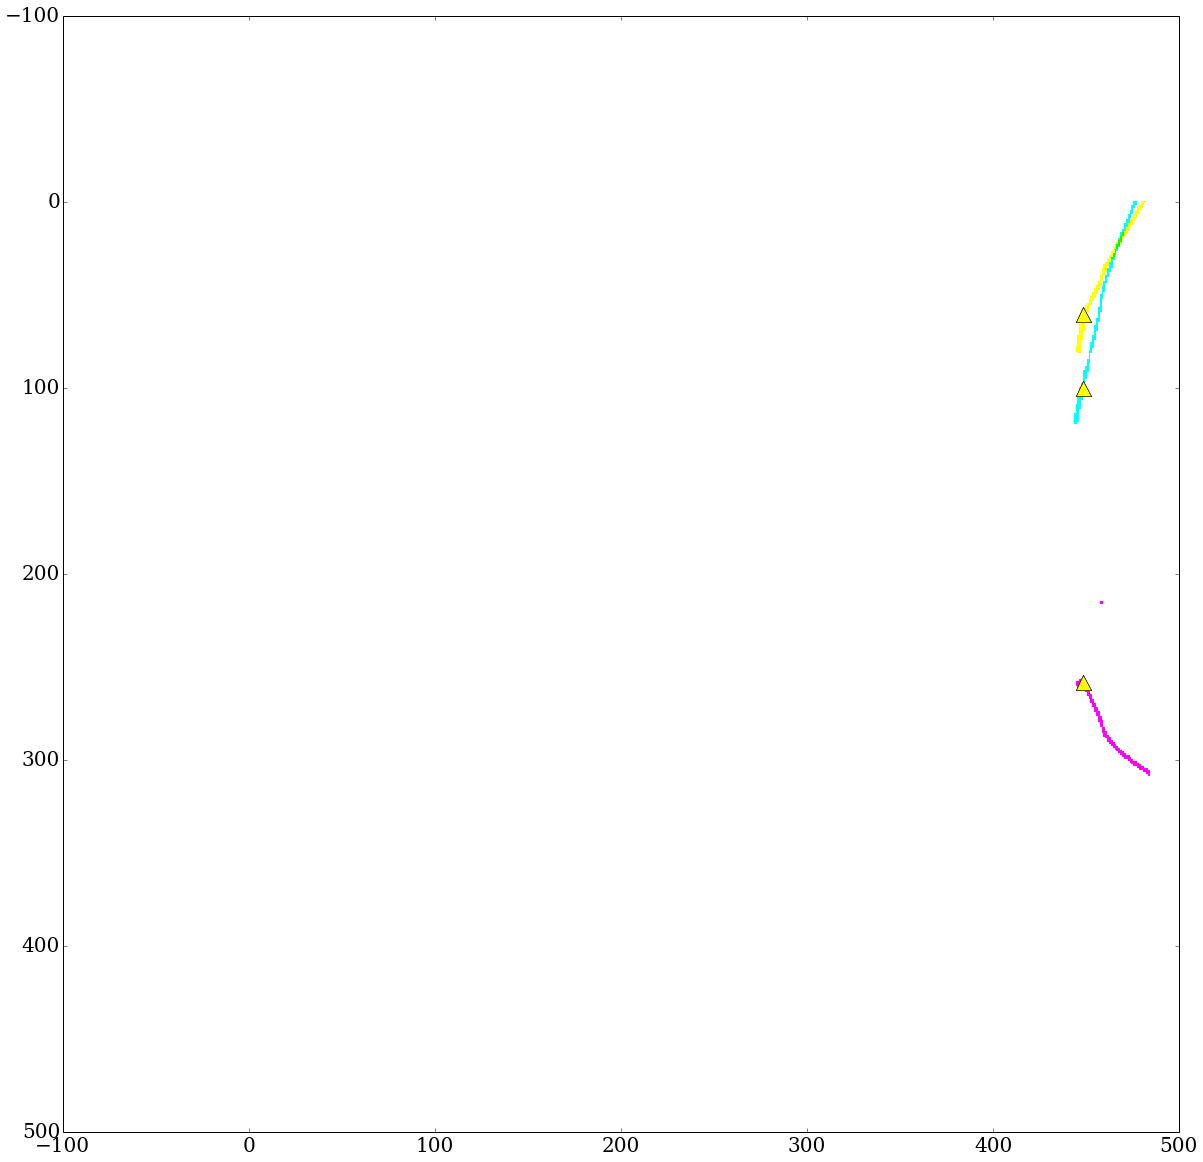

matched r/s/e  4 , 661 , 13203 ... to  4 , 661 , 13203
897    0
898    0
899    1
Name: vtx3d_type, dtype: uint32
897    0
898    0
899    1
Name: vtx3d_type, dtype: uint32
897    0
898    0
899    1
Name: vtx3d_type, dtype: uint32


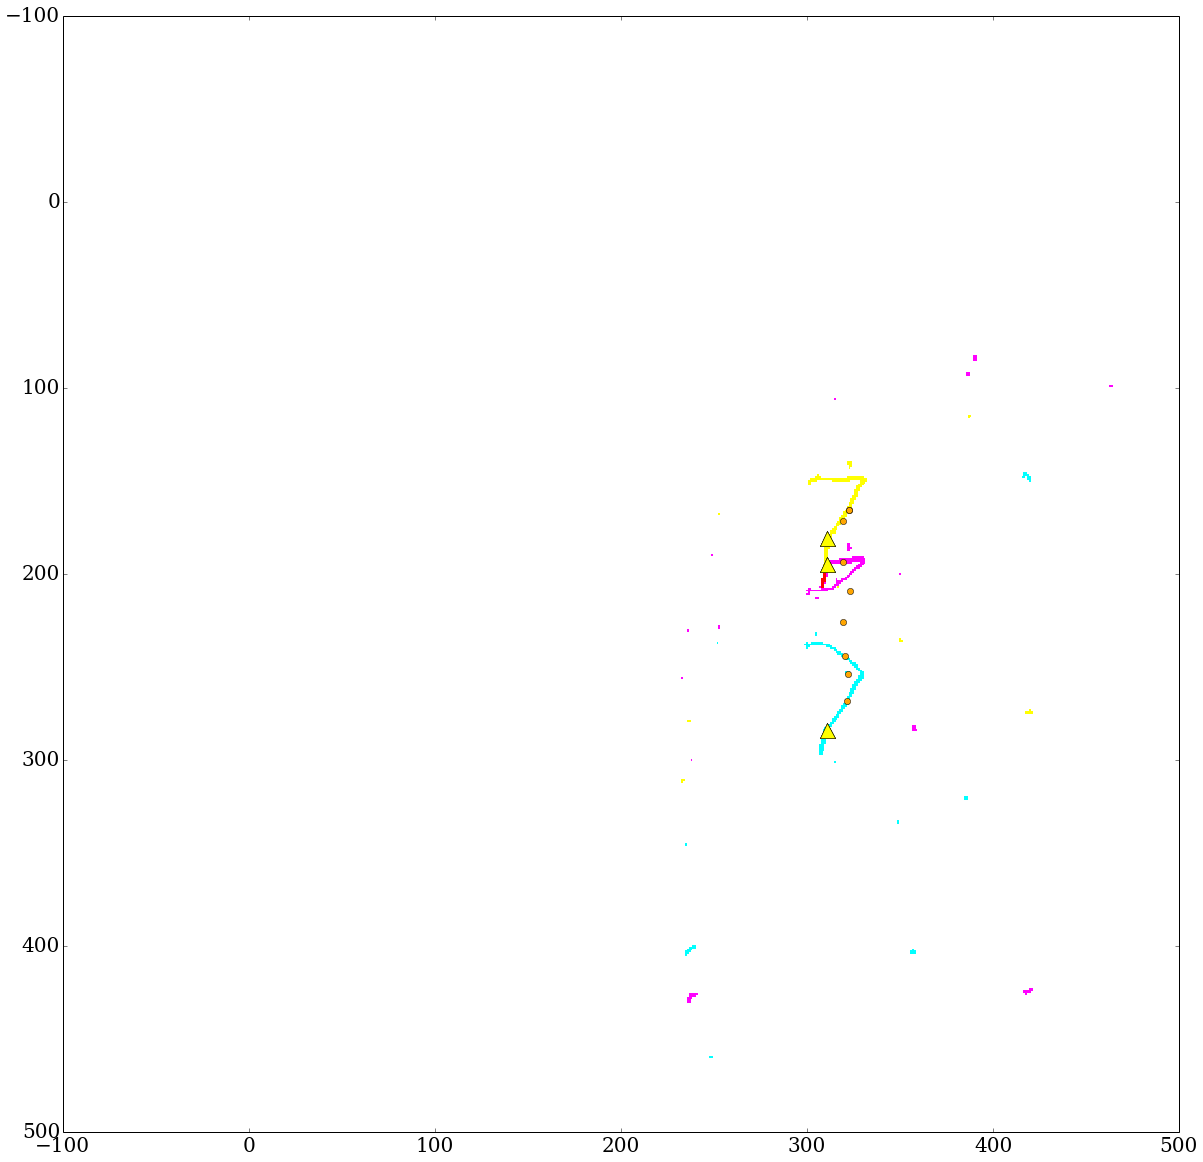

matched r/s/e  4 , 1608 , 32141 ... to  4 , 1608 , 32141
905    0
Name: vtx3d_type, dtype: uint32


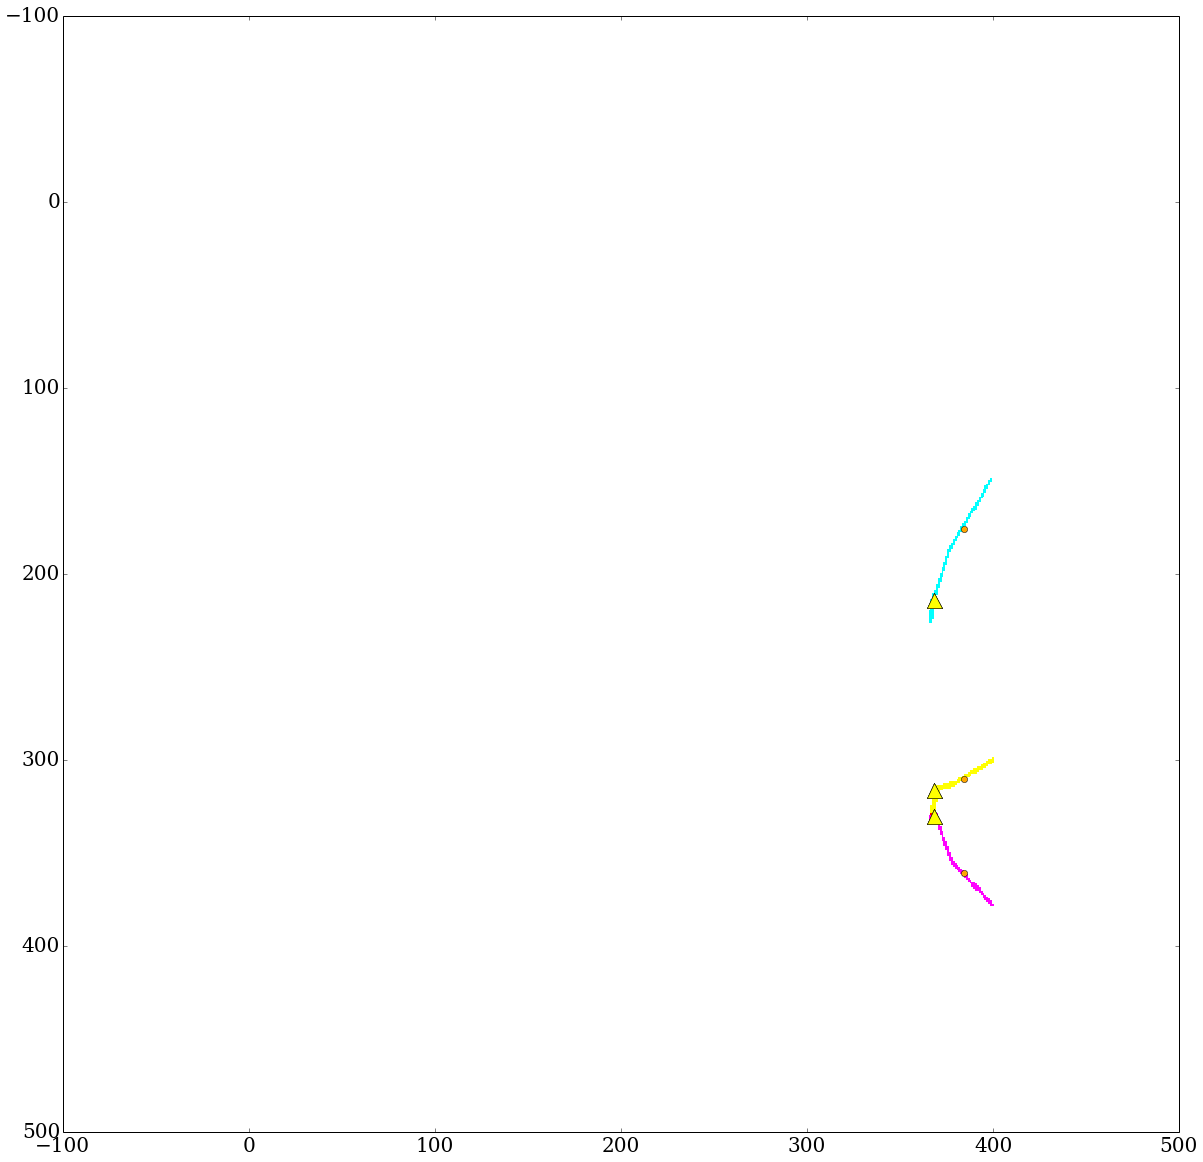

matched r/s/e  4 , 1674 , 33463 ... to  4 , 1674 , 33463


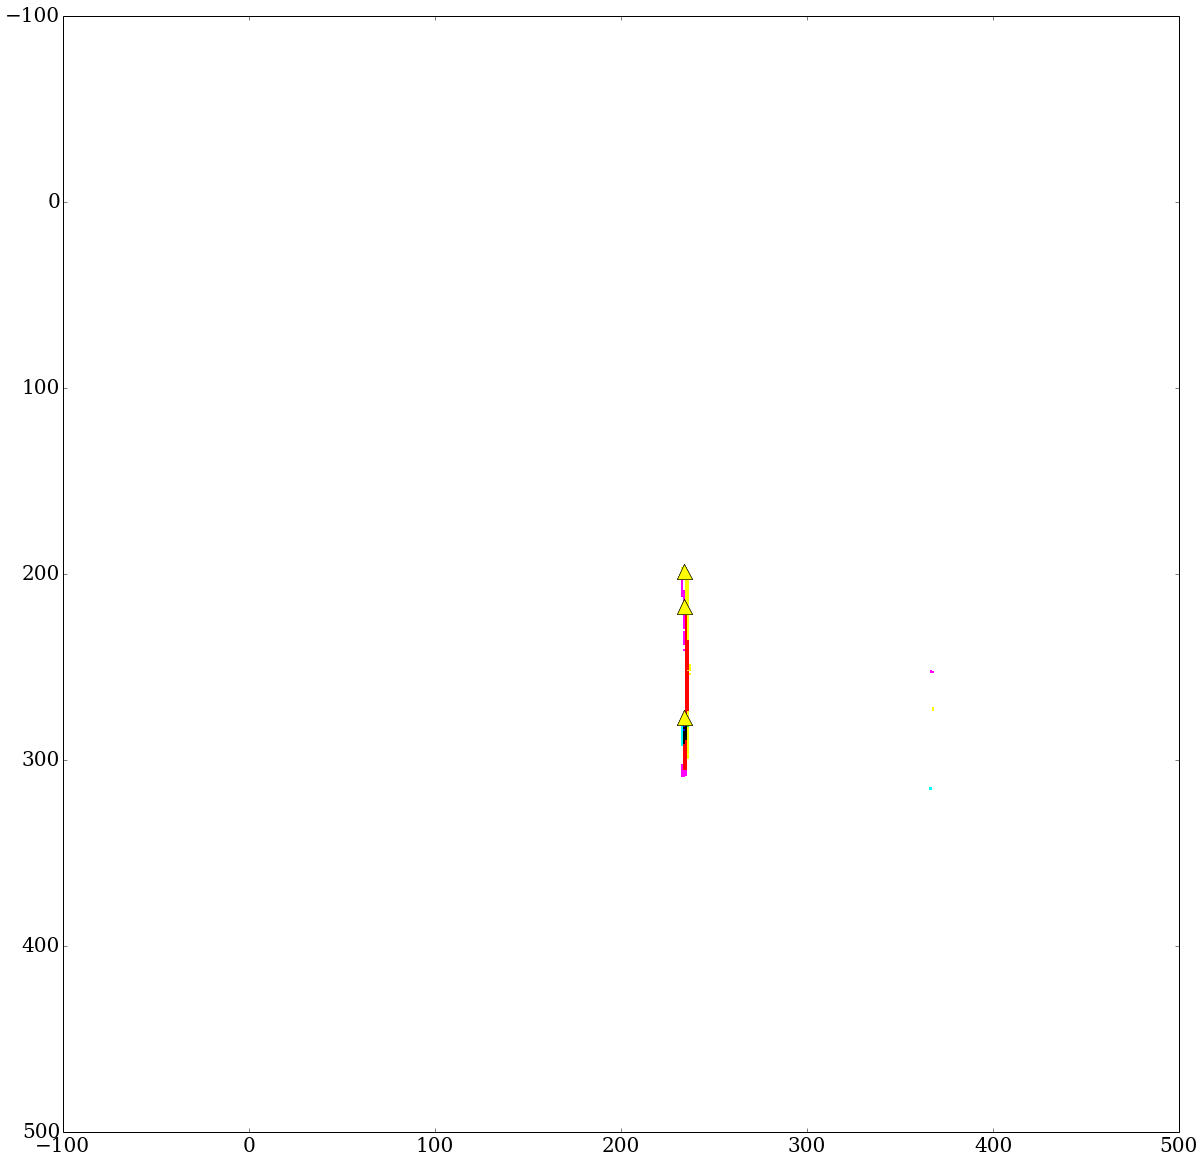

matched r/s/e  4 , 626 , 12503 ... to  4 , 626 , 12503


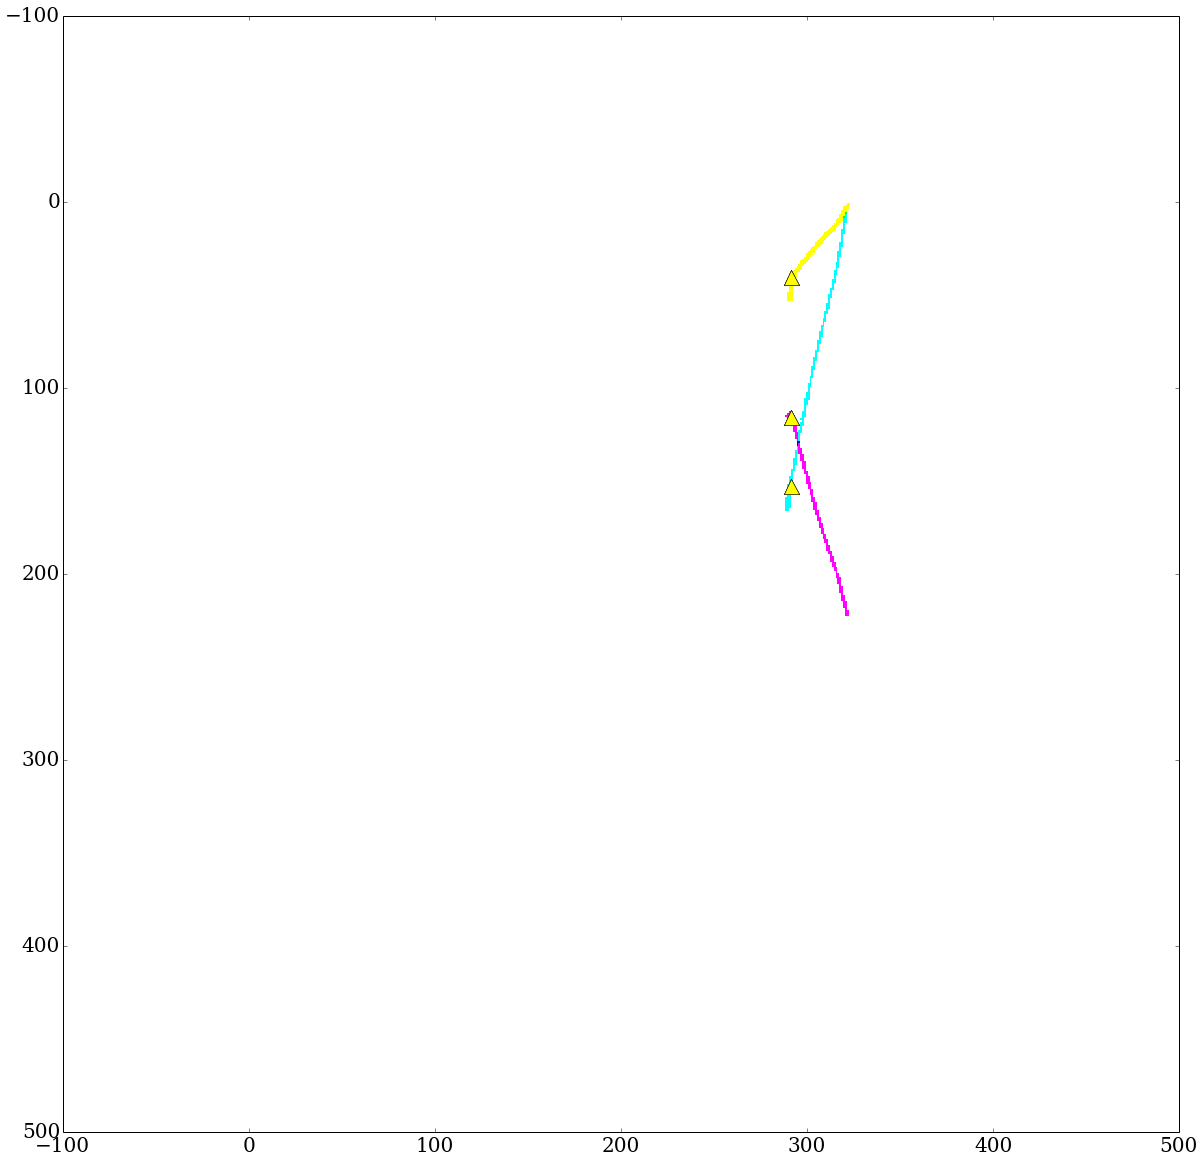

matched r/s/e  4 , 594 , 11862 ... to  4 , 594 , 11862
1098    0
Name: vtx3d_type, dtype: uint32


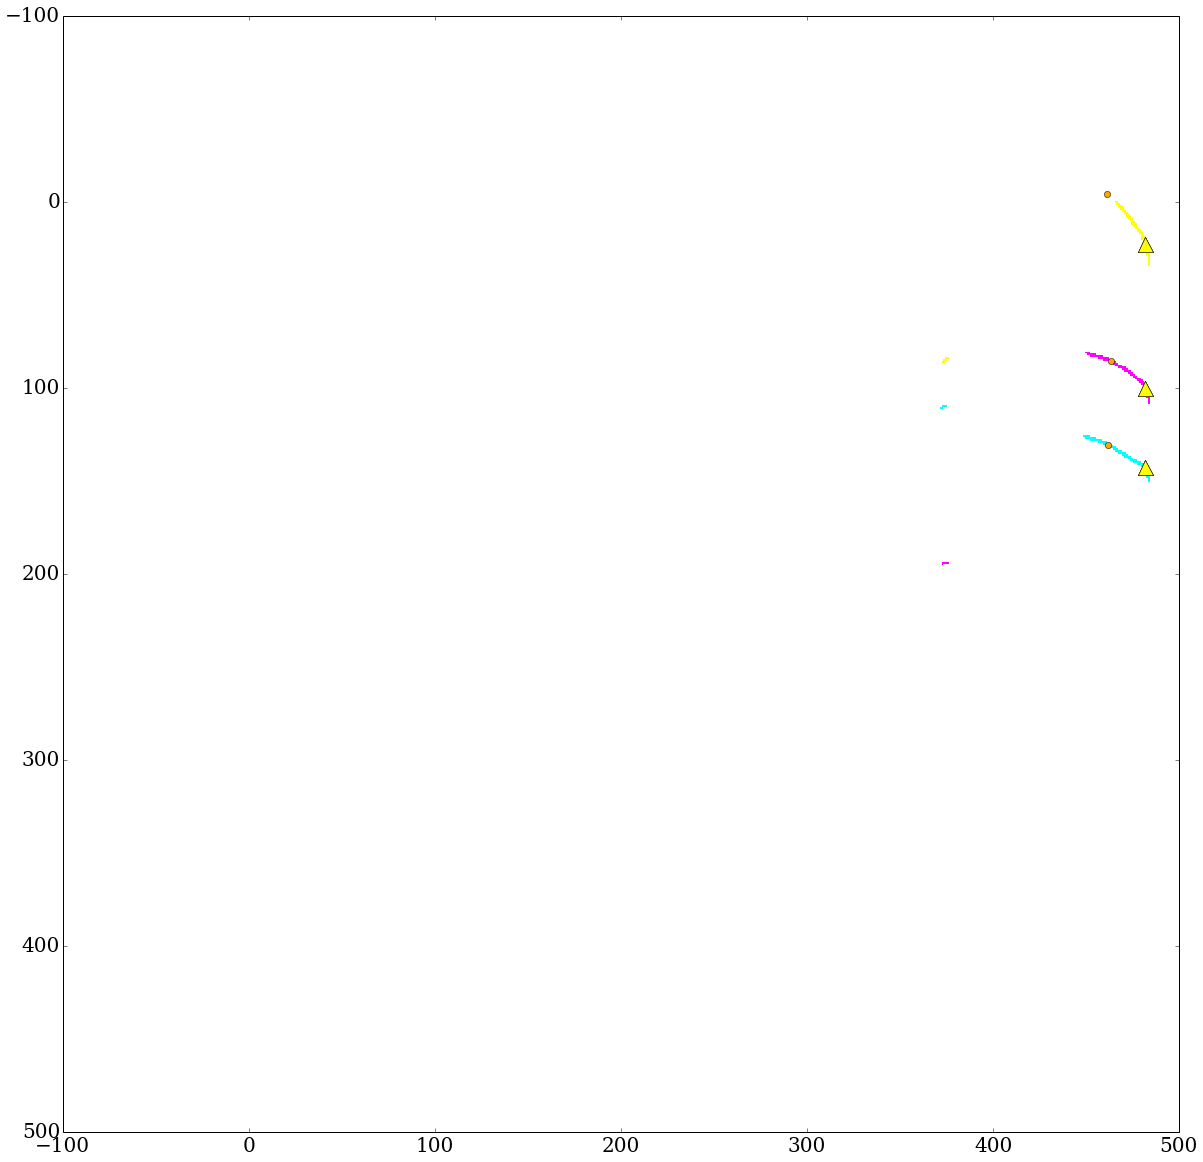

matched r/s/e  4 , 2437 , 48732 ... to  4 , 2437 , 48732


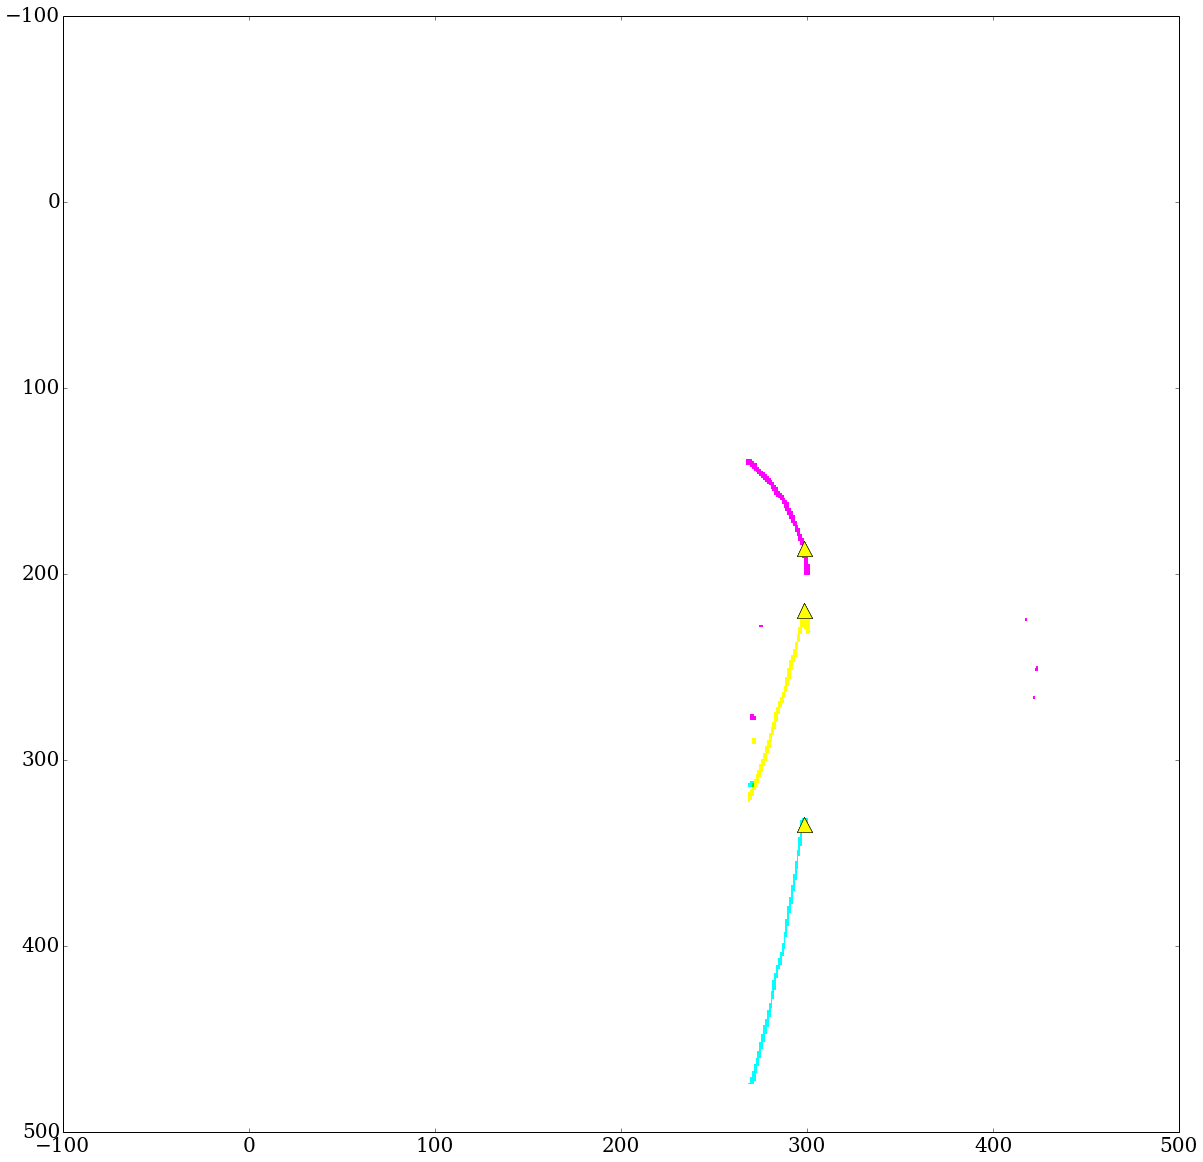

matched r/s/e  4 , 3330 , 66590 ... to  4 , 3330 , 66590


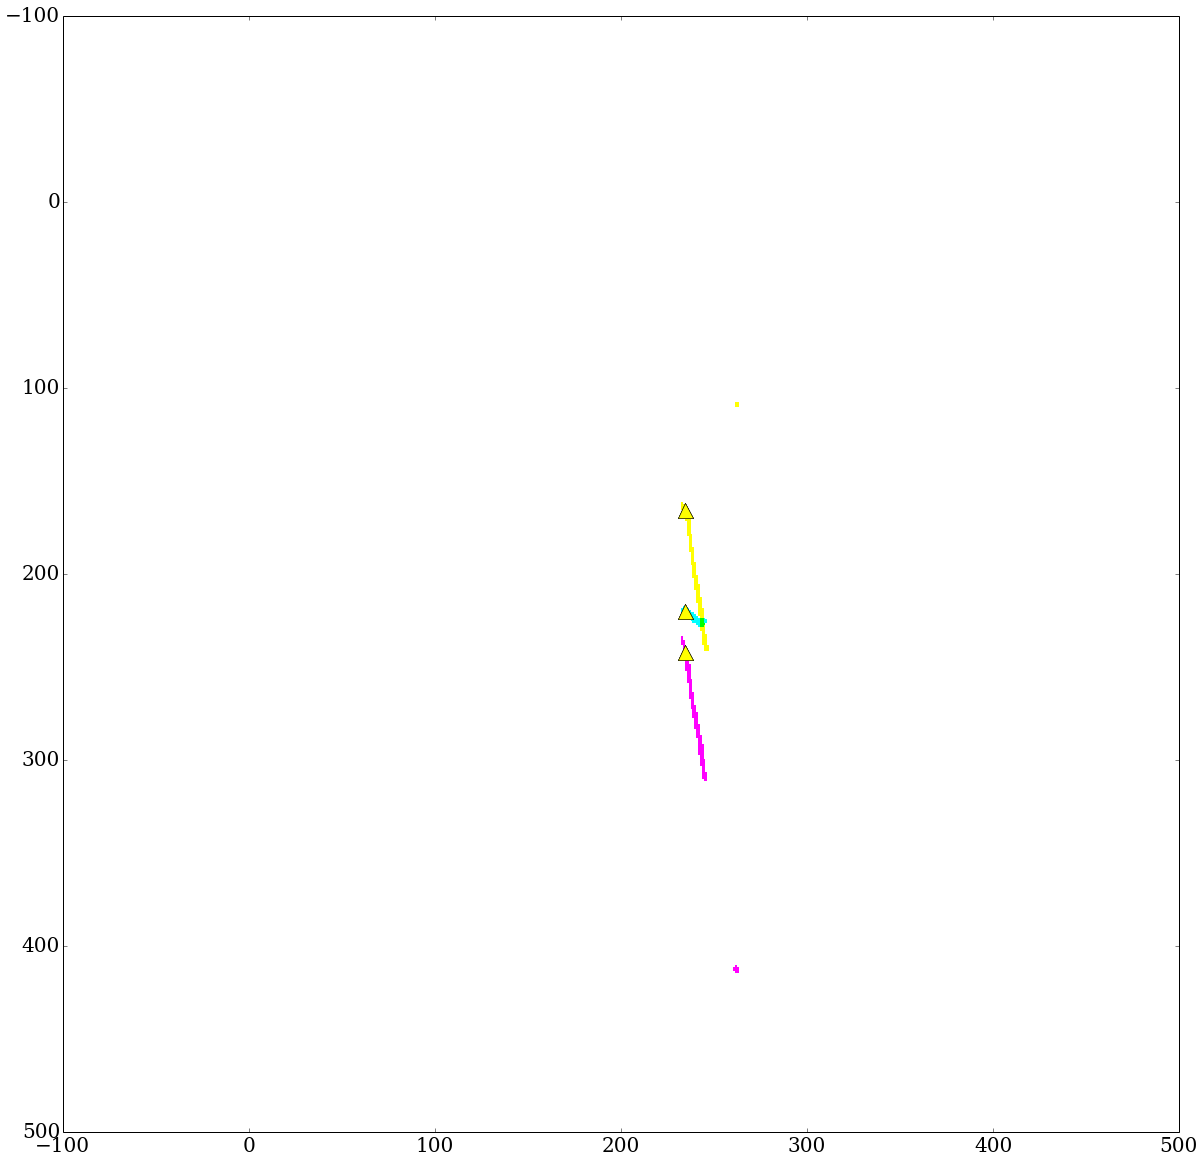

matched r/s/e  4 , 3920 , 78389 ... to  4 , 3920 , 78389
1233    0
Name: vtx3d_type, dtype: uint32


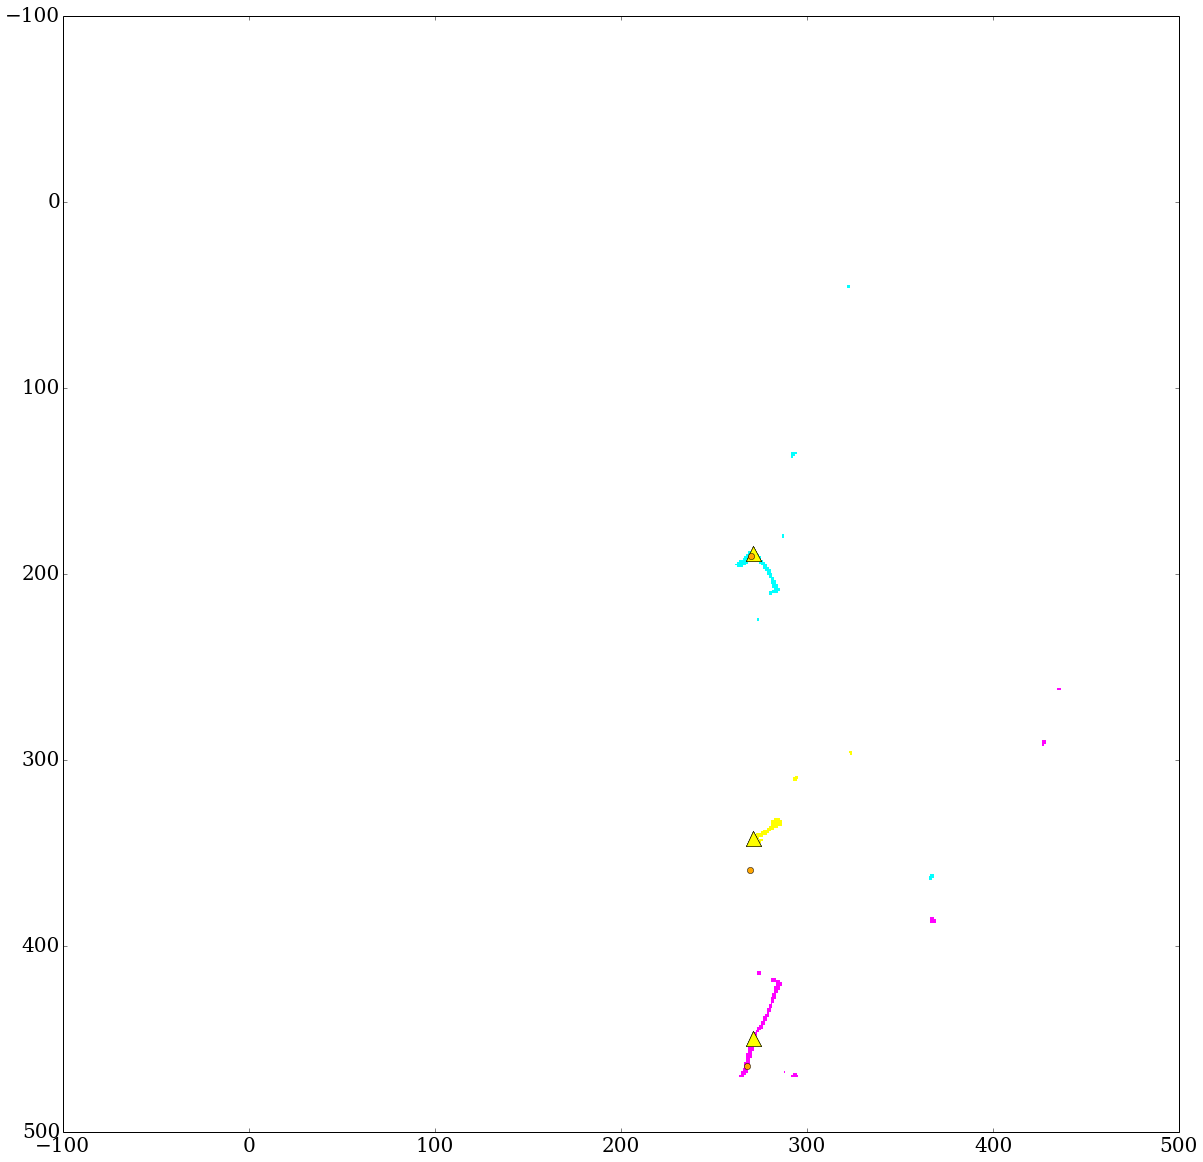

matched r/s/e  4 , 2507 , 50140 ... to  4 , 2507 , 50140
1274    0
Name: vtx3d_type, dtype: uint32


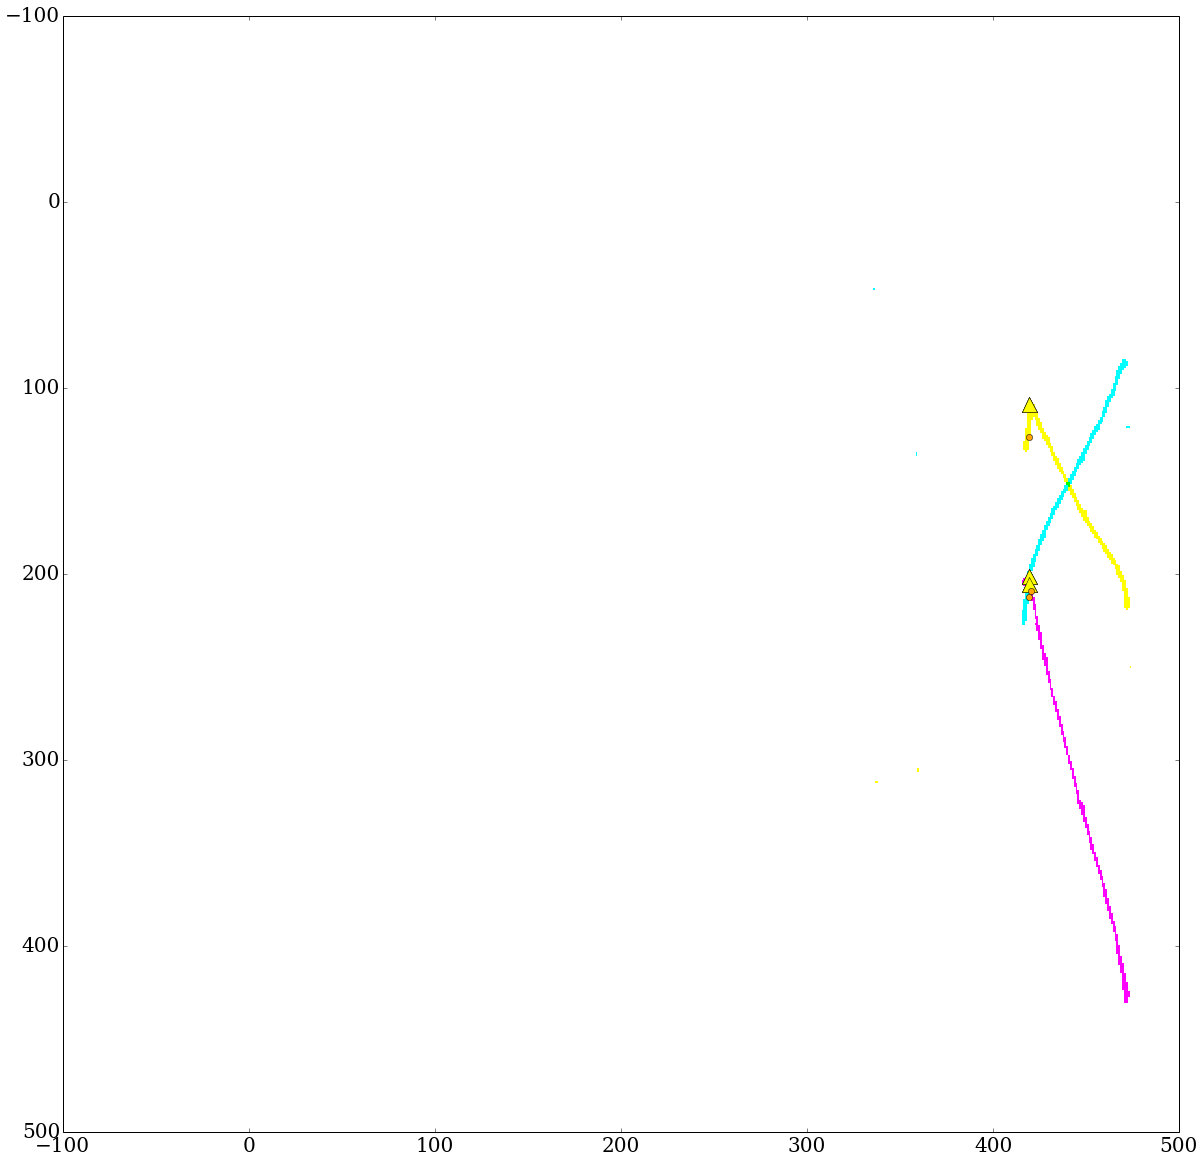

matched r/s/e  4 , 3859 , 77161 ... to  4 , 3859 , 77161
1291    0
1292    0
1293    0
1294    0
1295    0
1296    1
Name: vtx3d_type, dtype: uint32
1291    0
1292    0
1293    0
1294    0
1295    0
1296    1
Name: vtx3d_type, dtype: uint32
1291    0
1292    0
1293    0
1294    0
1295    0
1296    1
Name: vtx3d_type, dtype: uint32
1291    0
1292    0
1293    0
1294    0
1295    0
1296    1
Name: vtx3d_type, dtype: uint32
1291    0
1292    0
1293    0
1294    0
1295    0
1296    1
Name: vtx3d_type, dtype: uint32
1291    0
1292    0
1293    0
1294    0
1295    0
1296    1
Name: vtx3d_type, dtype: uint32


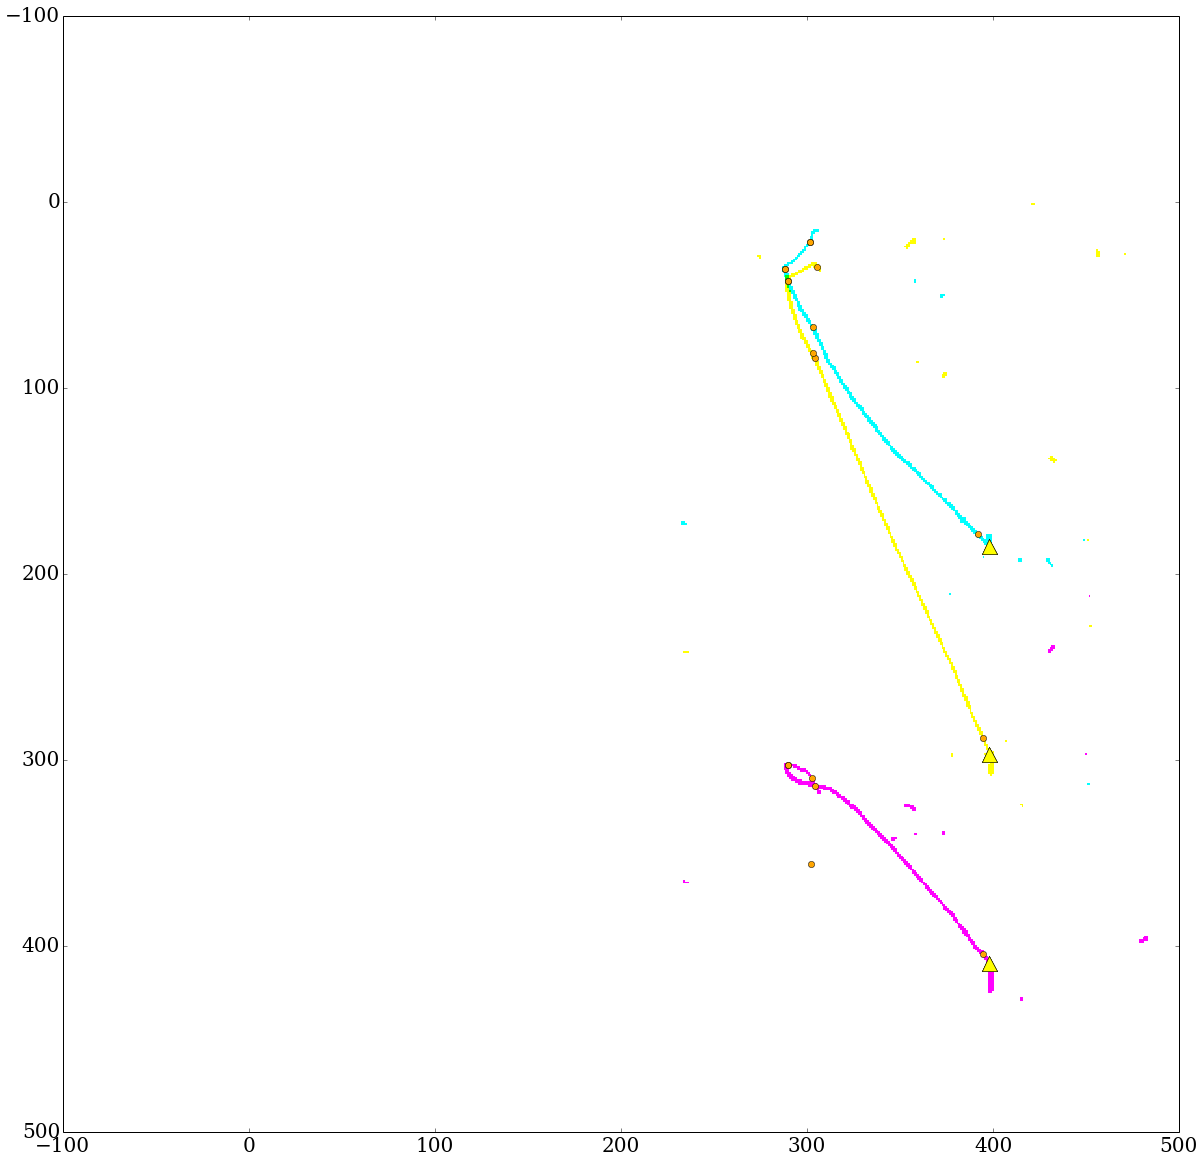

matched r/s/e  4 , 2053 , 41045 ... to  4 , 2053 , 41045
1341    0
1342    0
1343    0
1344    1
Name: vtx3d_type, dtype: uint32
1341    0
1342    0
1343    0
1344    1
Name: vtx3d_type, dtype: uint32
1341    0
1342    0
1343    0
1344    1
Name: vtx3d_type, dtype: uint32
1341    0
1342    0
1343    0
1344    1
Name: vtx3d_type, dtype: uint32


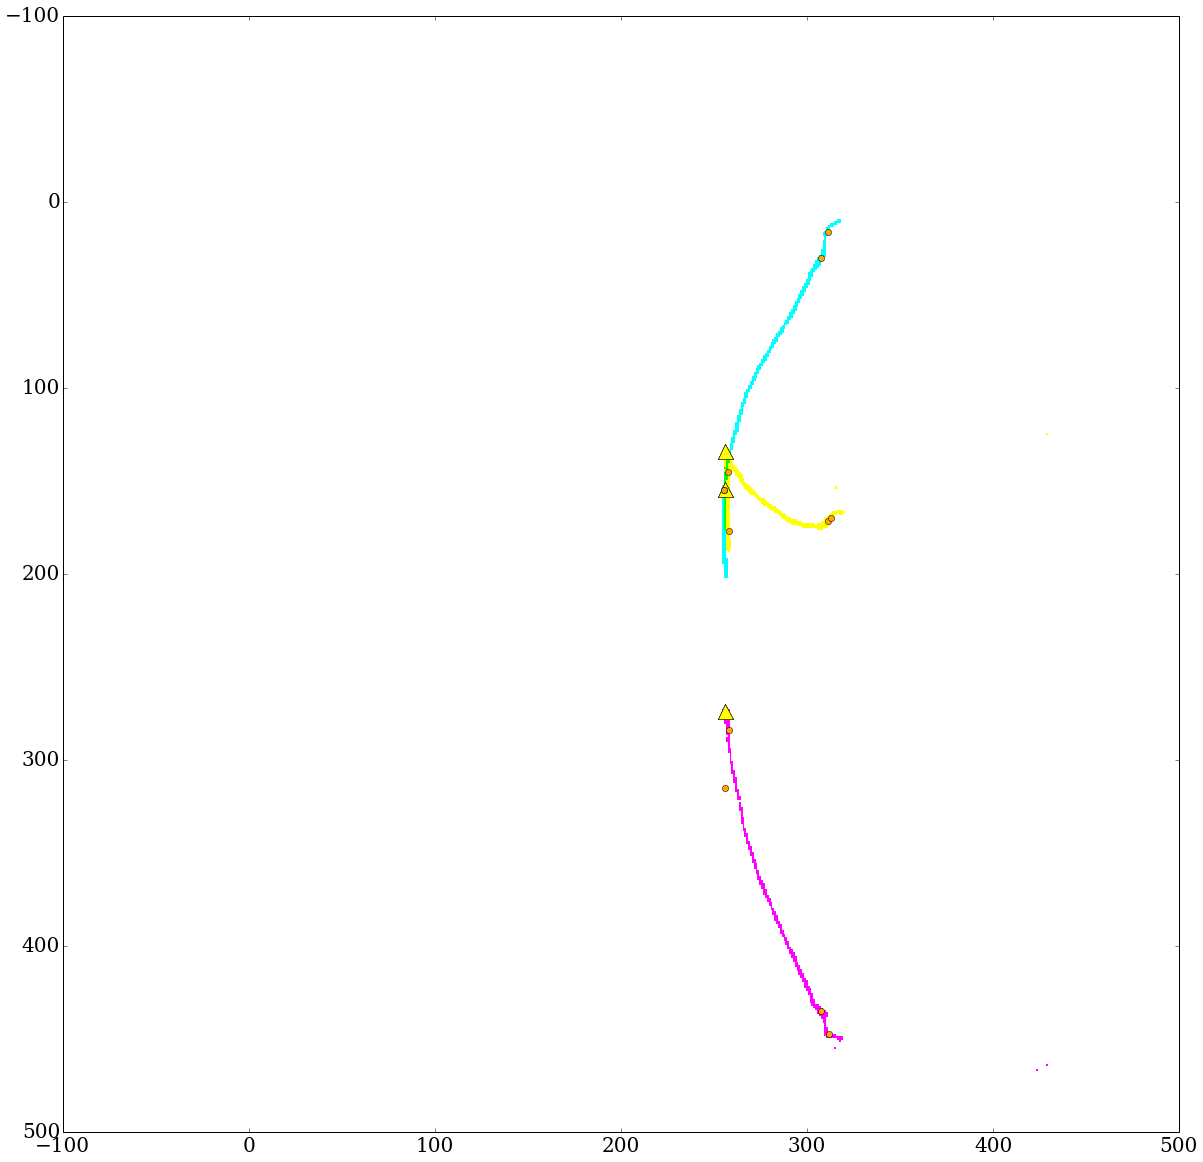

matched r/s/e  4 , 3415 , 68293 ... to  4 , 3415 , 68293
1382    0
1383    0
Name: vtx3d_type, dtype: uint32
1382    0
1383    0
Name: vtx3d_type, dtype: uint32


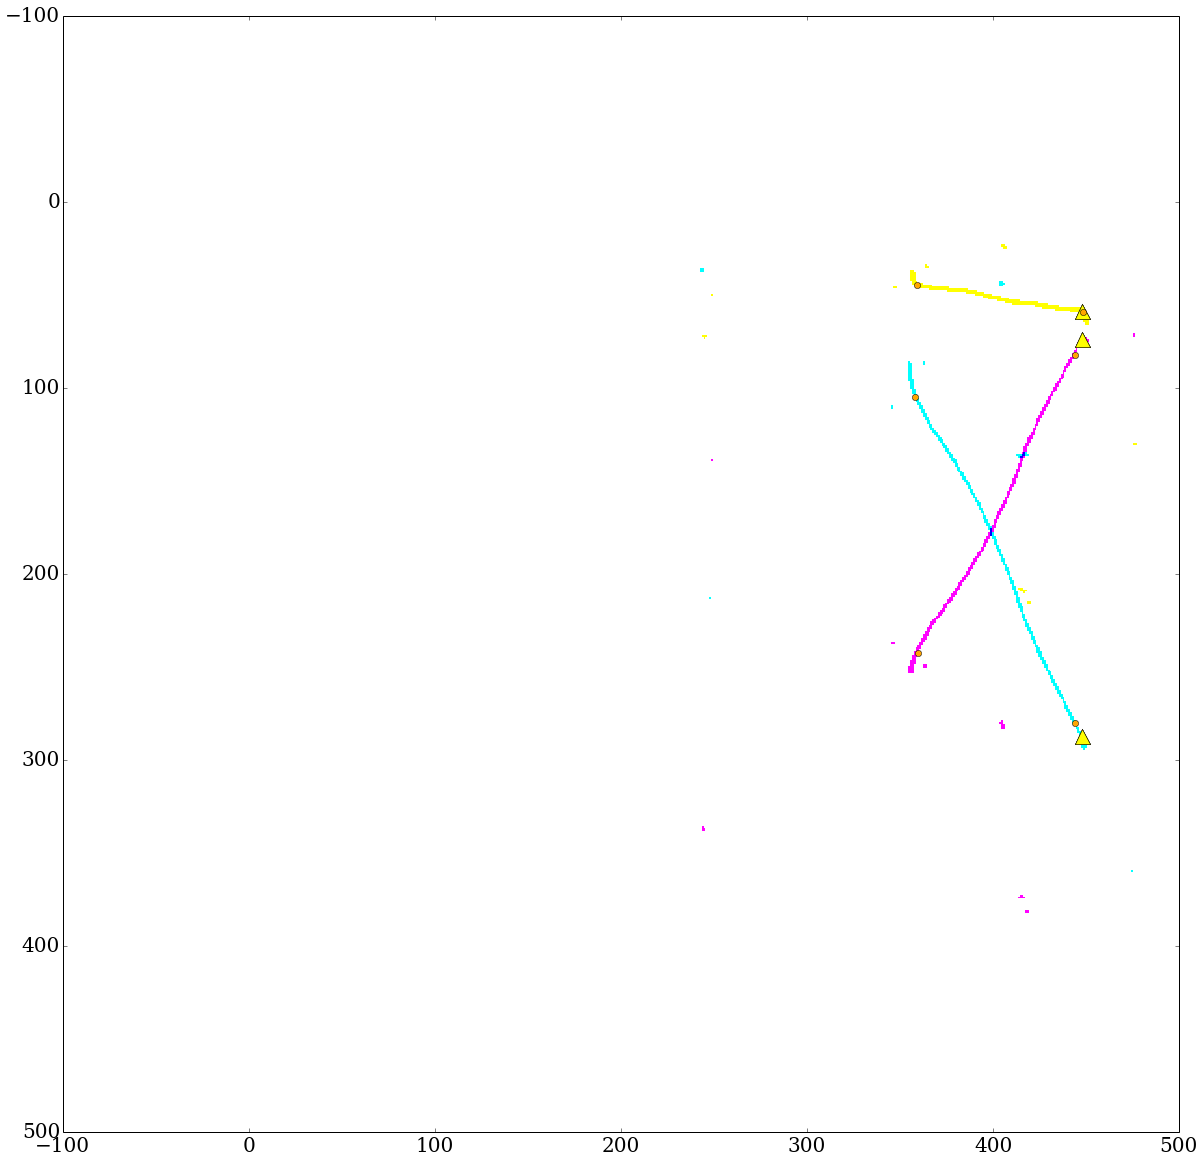

matched r/s/e  4 , 3695 , 73893 ... to  4 , 3695 , 73893
1424    0
1425    1
Name: vtx3d_type, dtype: uint32
1424    0
1425    1
Name: vtx3d_type, dtype: uint32


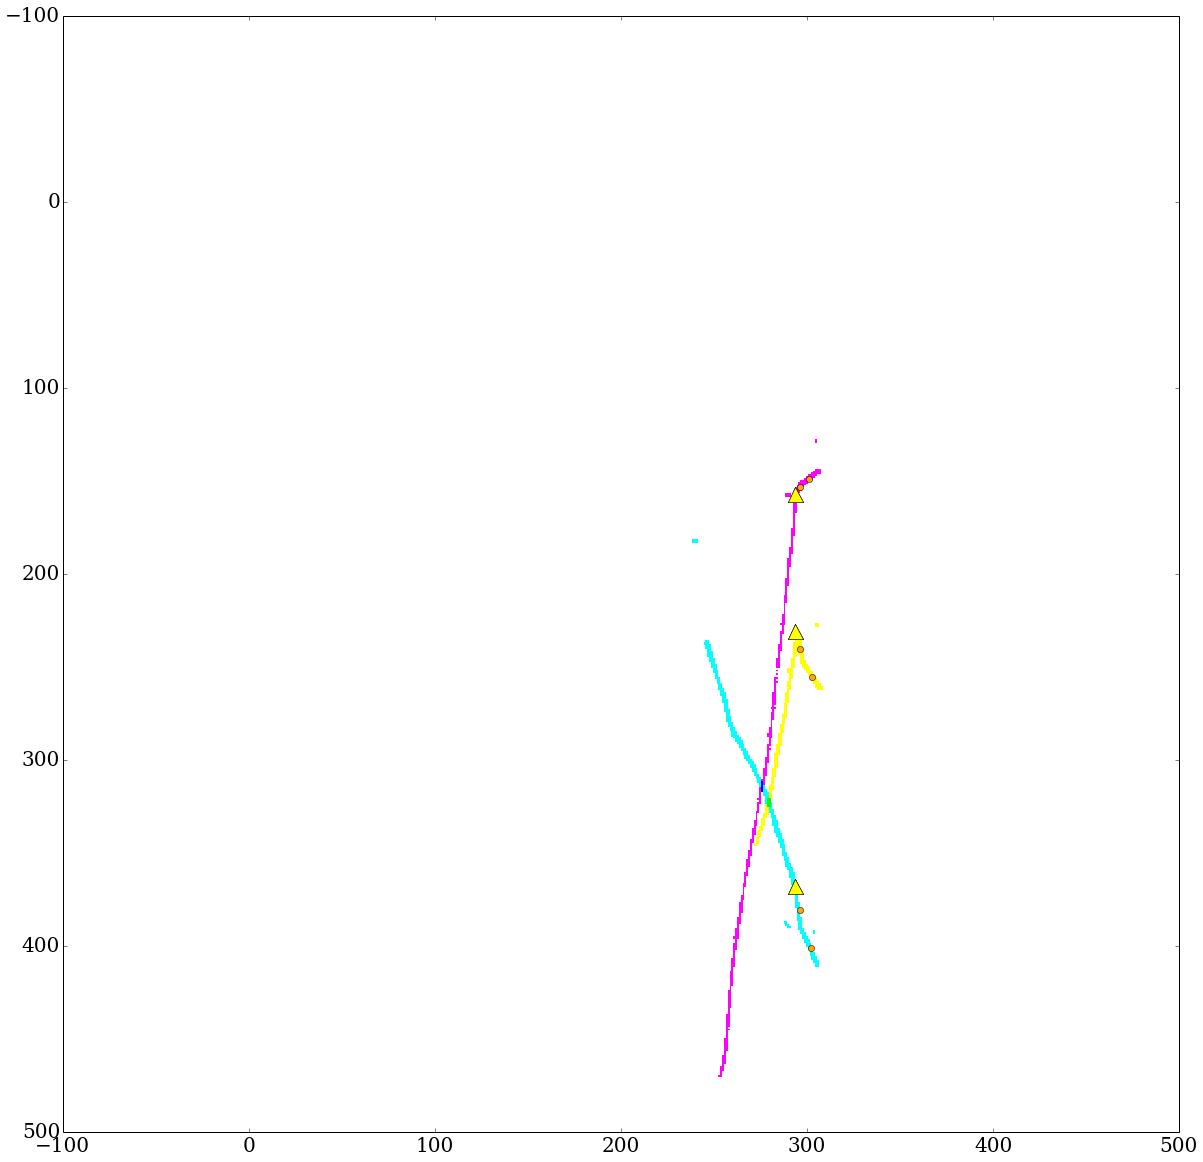

matched r/s/e  4 , 3874 , 77467 ... to  4 , 3874 , 77467
1446    1
Name: vtx3d_type, dtype: uint32


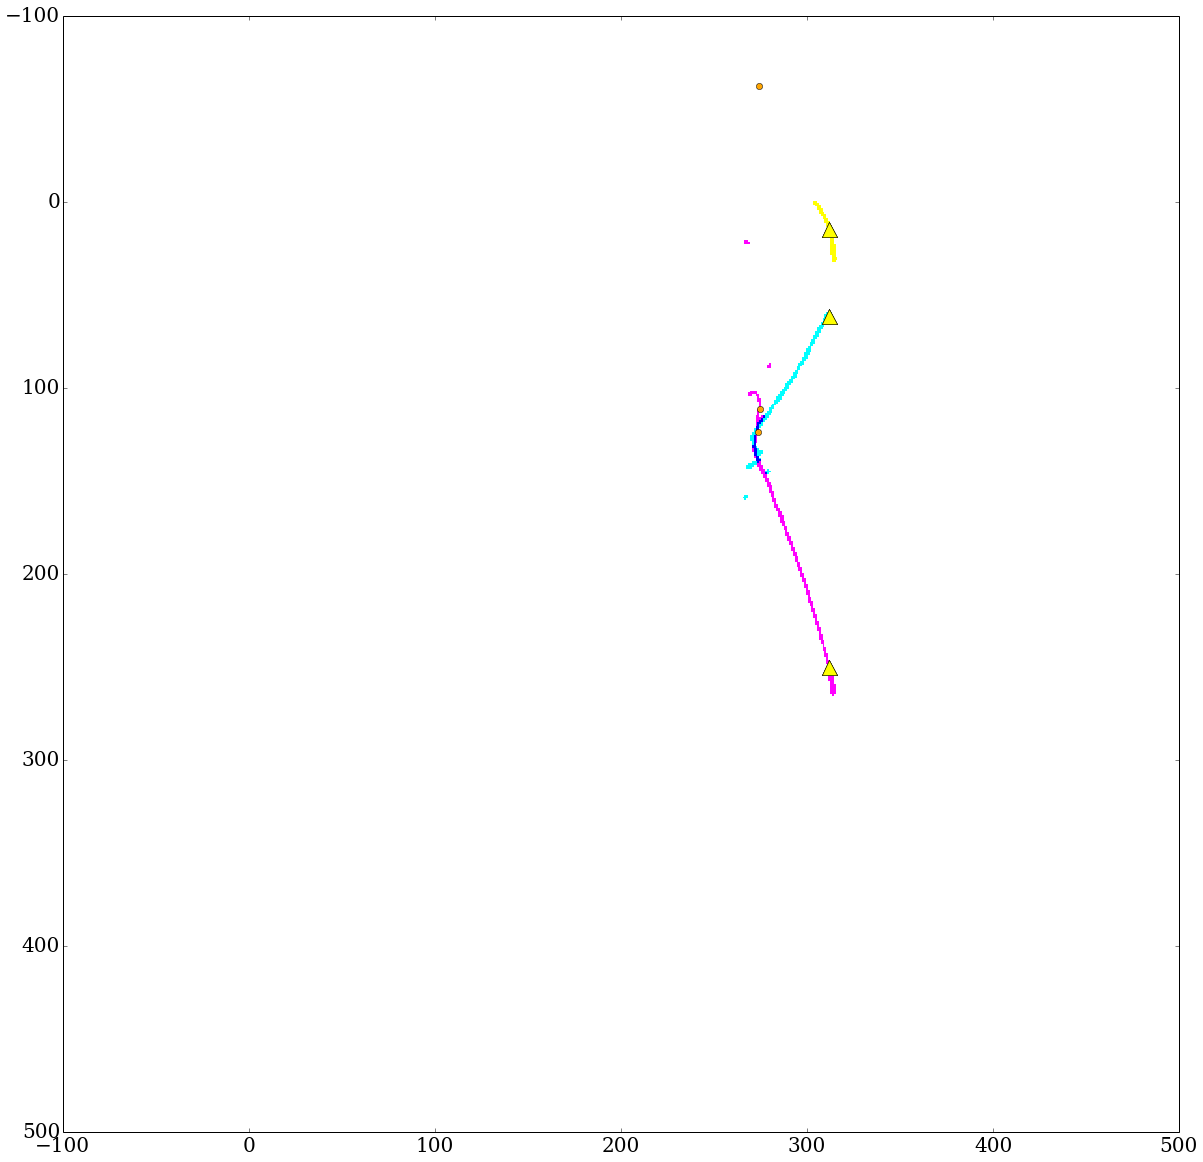

matched r/s/e  4 , 3825 , 76488 ... to  4 , 3825 , 76488


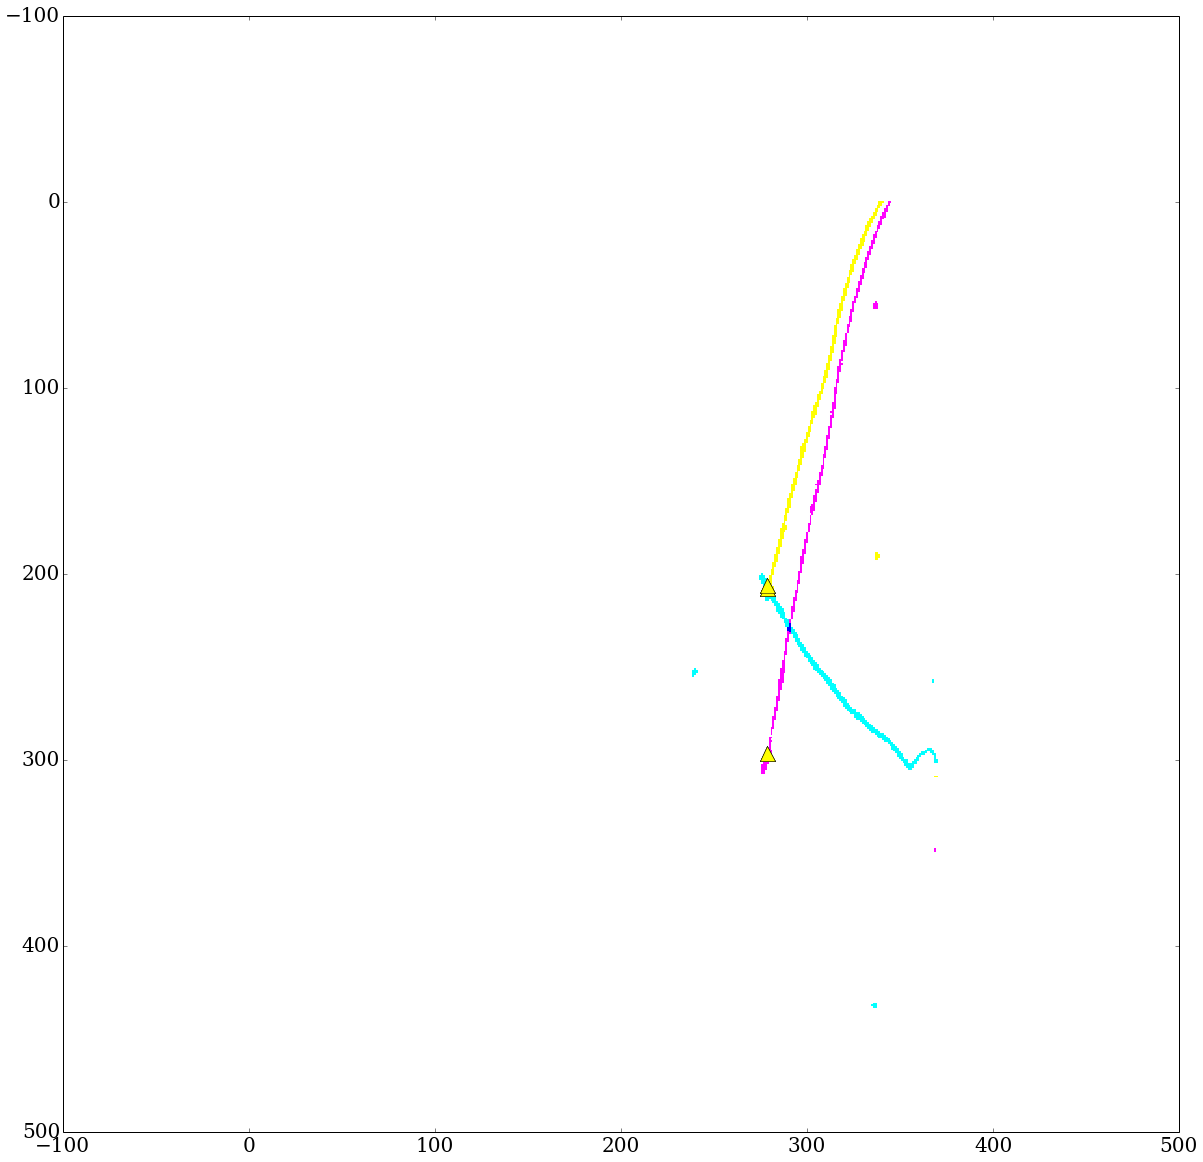

matched r/s/e  4 , 2058 , 41156 ... to  4 , 2058 , 41156
1467    0
1468    1
Name: vtx3d_type, dtype: uint32
1467    0
1468    1
Name: vtx3d_type, dtype: uint32


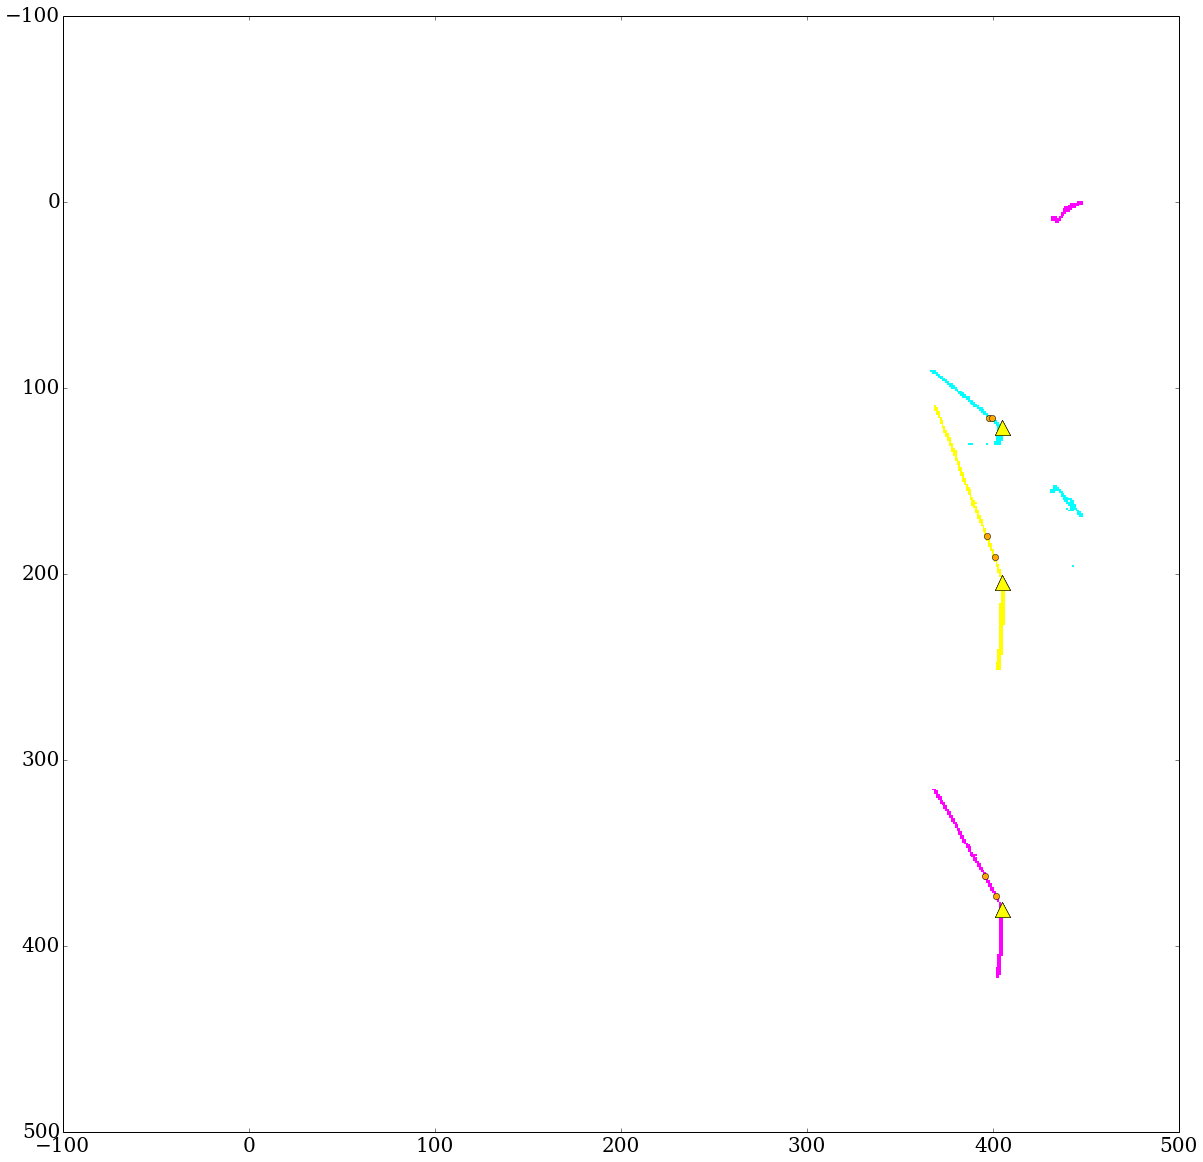

matched r/s/e  4 , 3310 , 66197 ... to  4 , 3310 , 66197
1535    0
1536    0
Name: vtx3d_type, dtype: uint32
1535    0
1536    0
Name: vtx3d_type, dtype: uint32


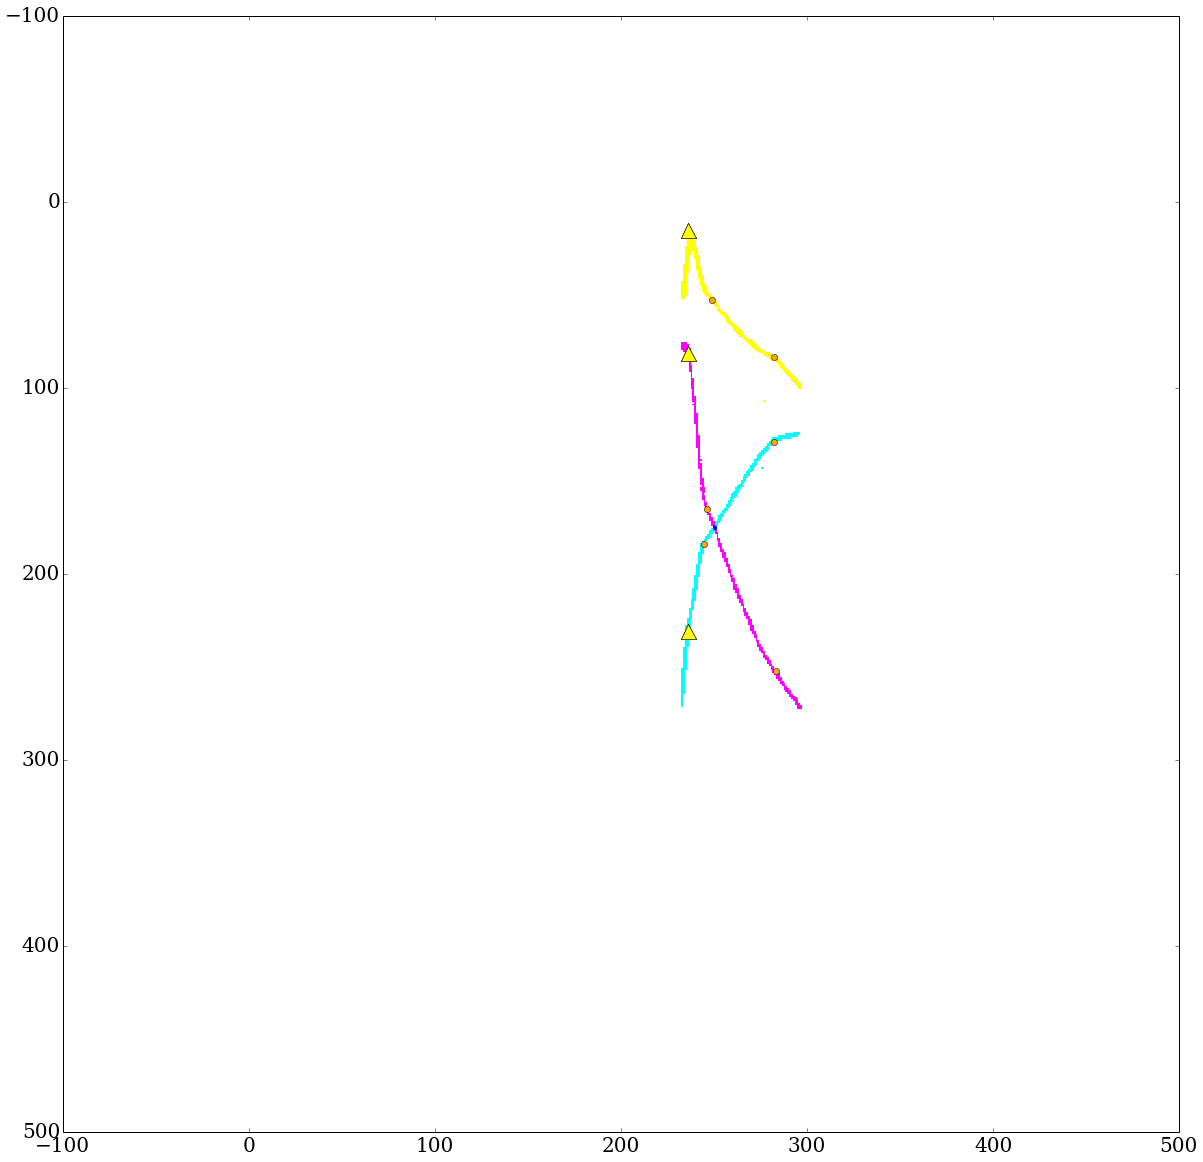

matched r/s/e  4 , 2341 , 46817 ... to  4 , 2341 , 46817


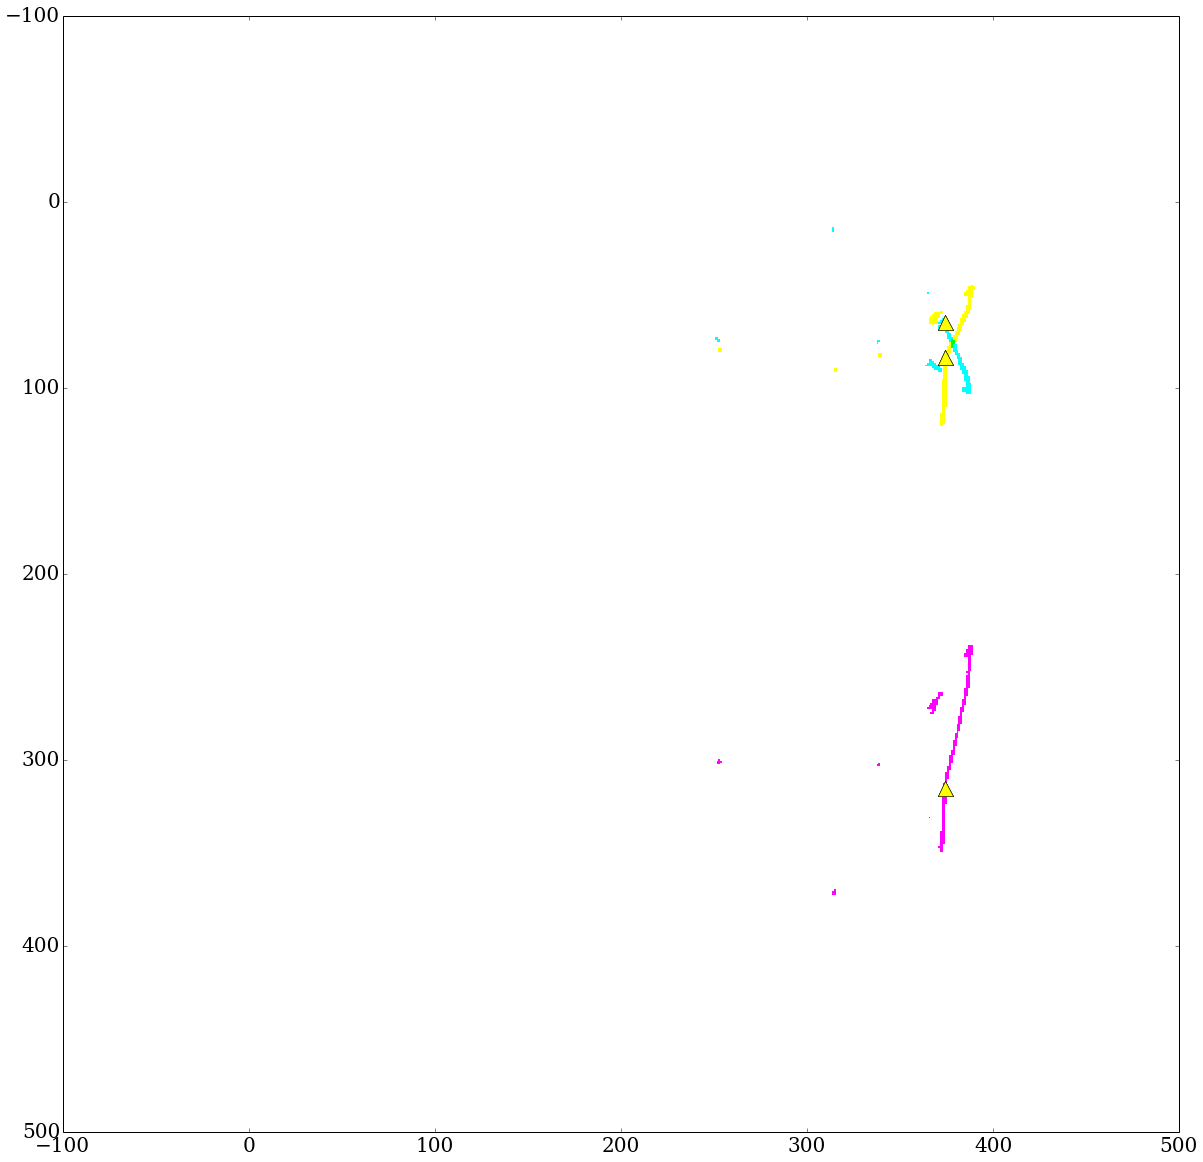

matched r/s/e  4 , 3474 , 69479 ... to  4 , 3474 , 69479
1583    1
1584    1
Name: vtx3d_type, dtype: uint32
1583    1
1584    1
Name: vtx3d_type, dtype: uint32


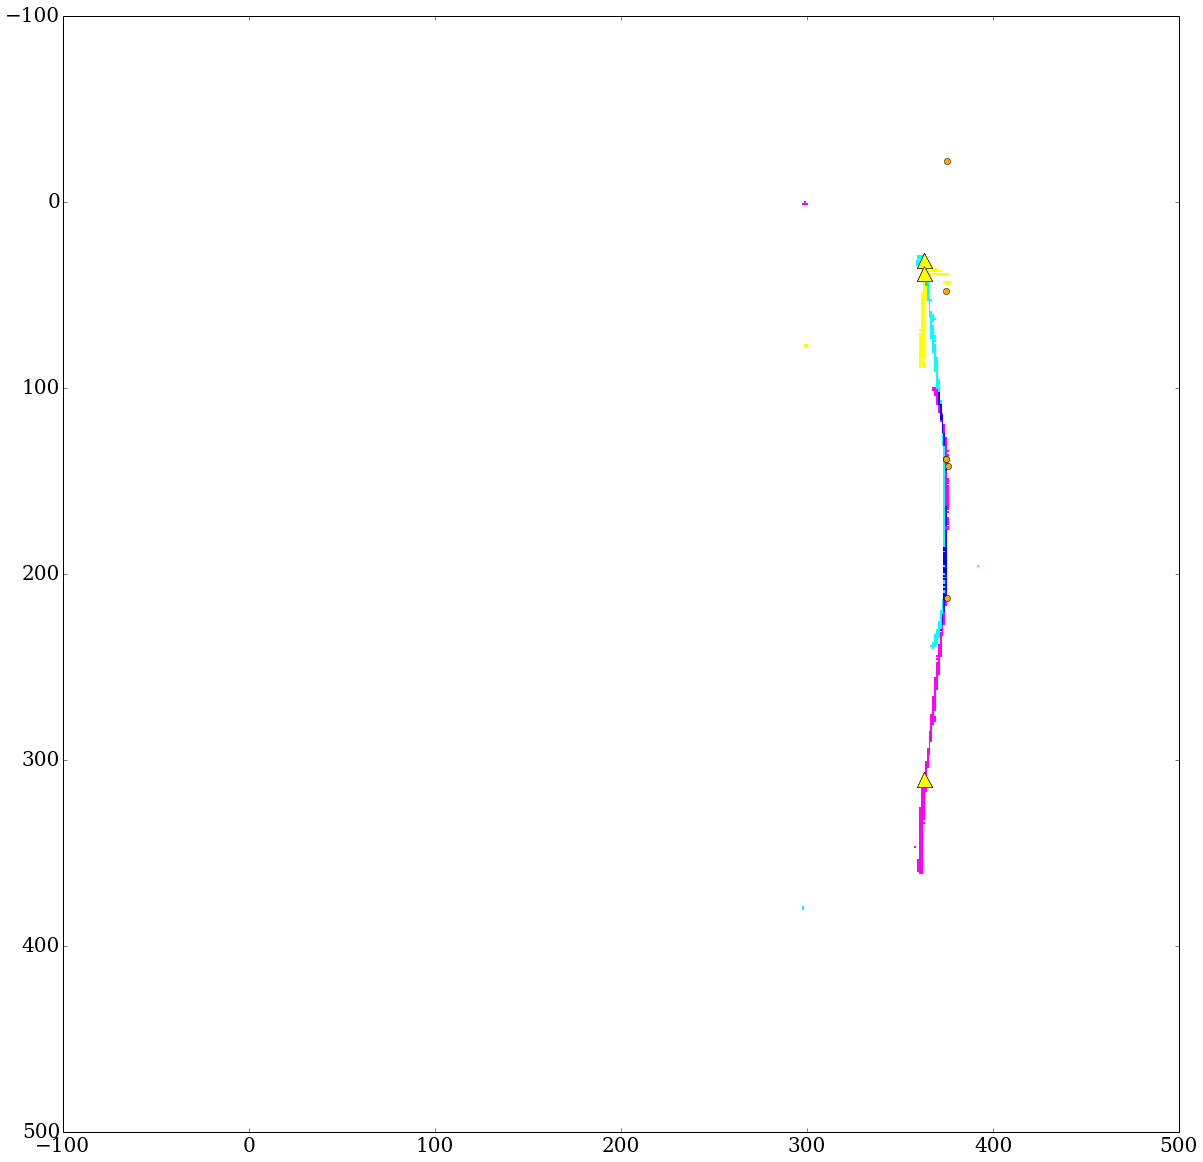

matched r/s/e  4 , 2066 , 41319 ... to  4 , 2066 , 41319


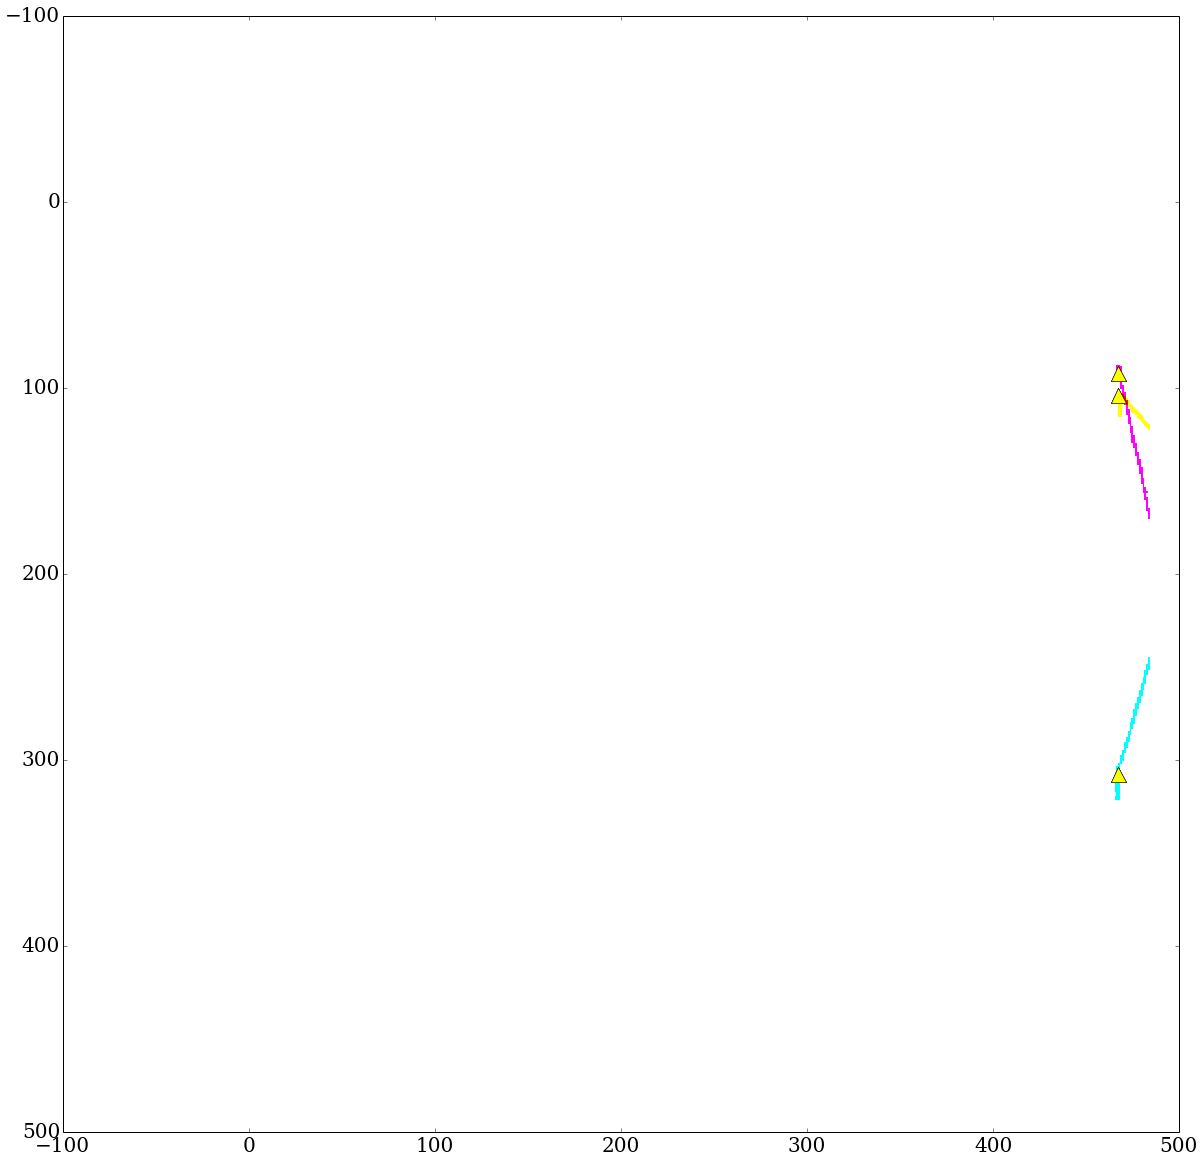

matched r/s/e  4 , 3925 , 78498 ... to  4 , 3925 , 78498


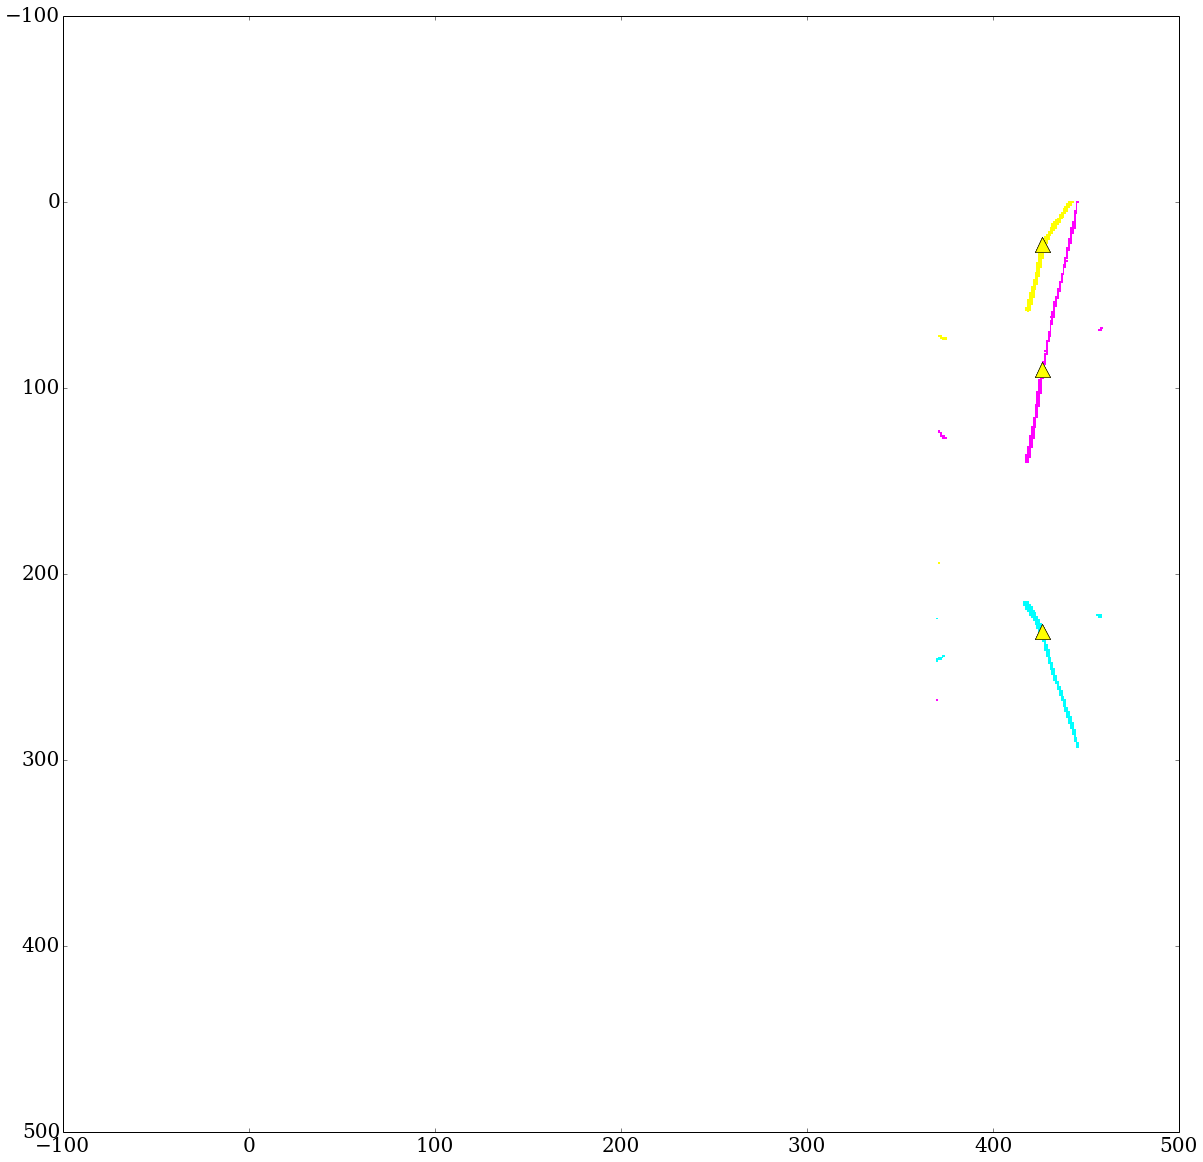

matched r/s/e  4 , 3976 , 79505 ... to  4 , 3976 , 79505
1697    0
Name: vtx3d_type, dtype: uint32


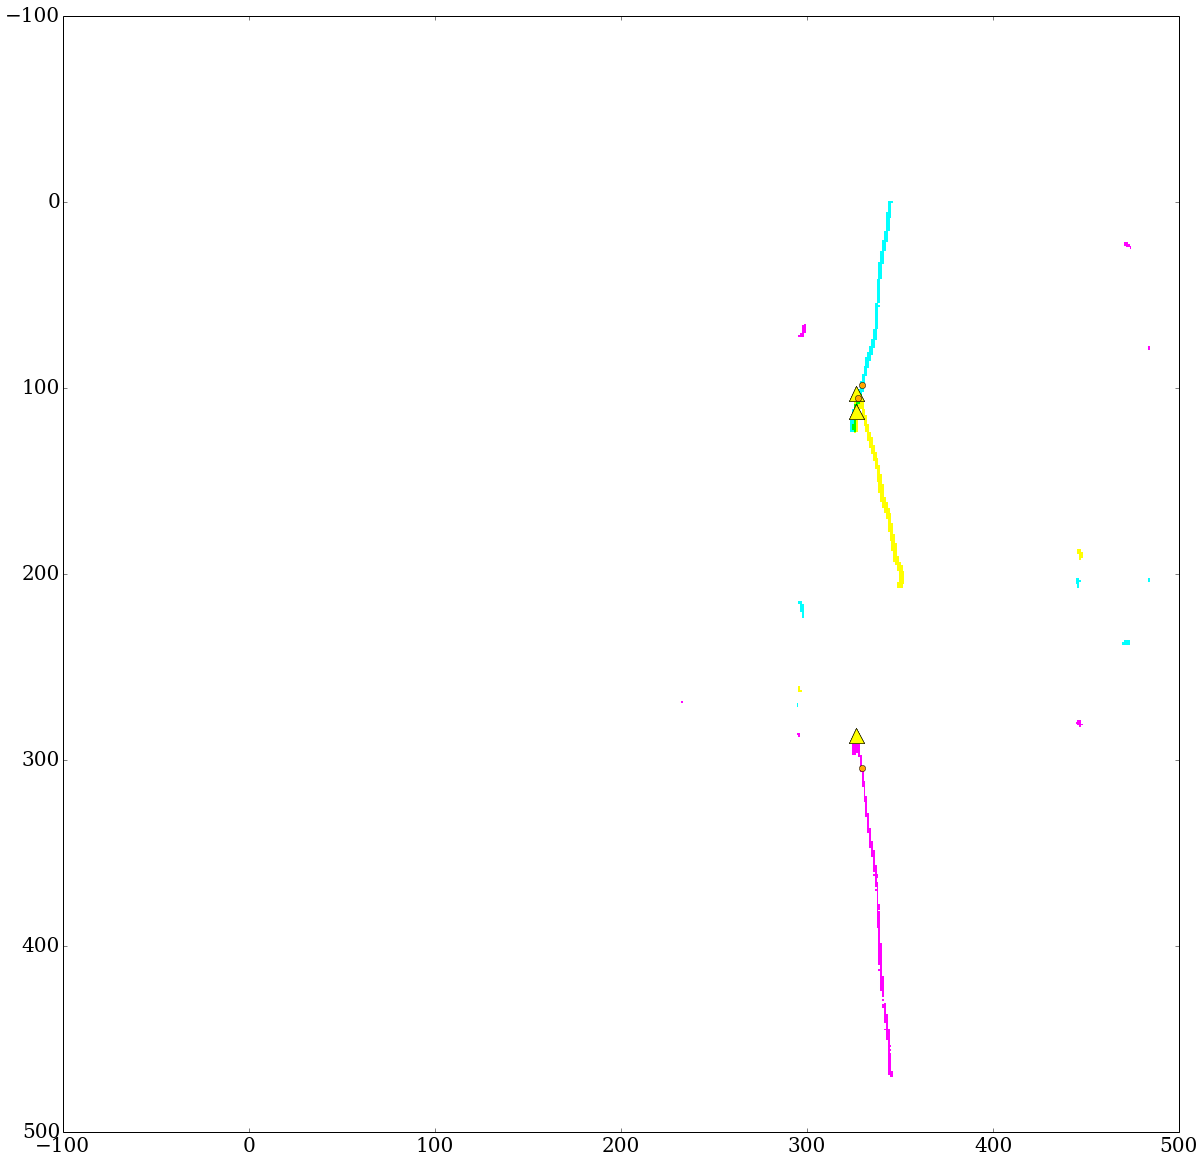

matched r/s/e  4 , 3178 , 63546 ... to  4 , 3178 , 63546


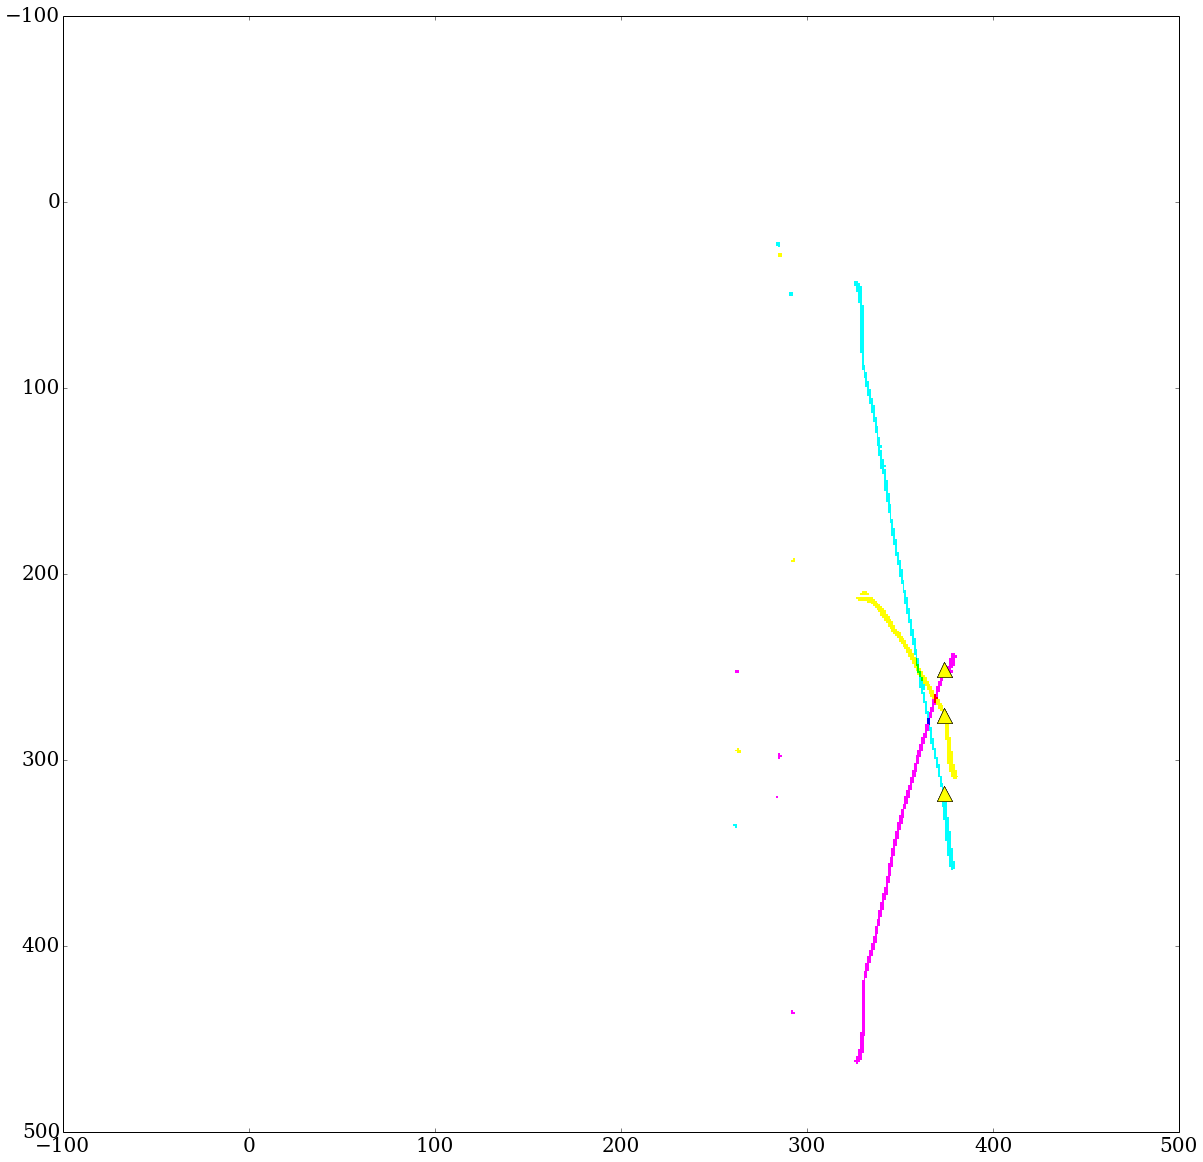

matched r/s/e  4 , 2261 , 45205 ... to  4 , 2261 , 45205
1716    0
Name: vtx3d_type, dtype: uint32


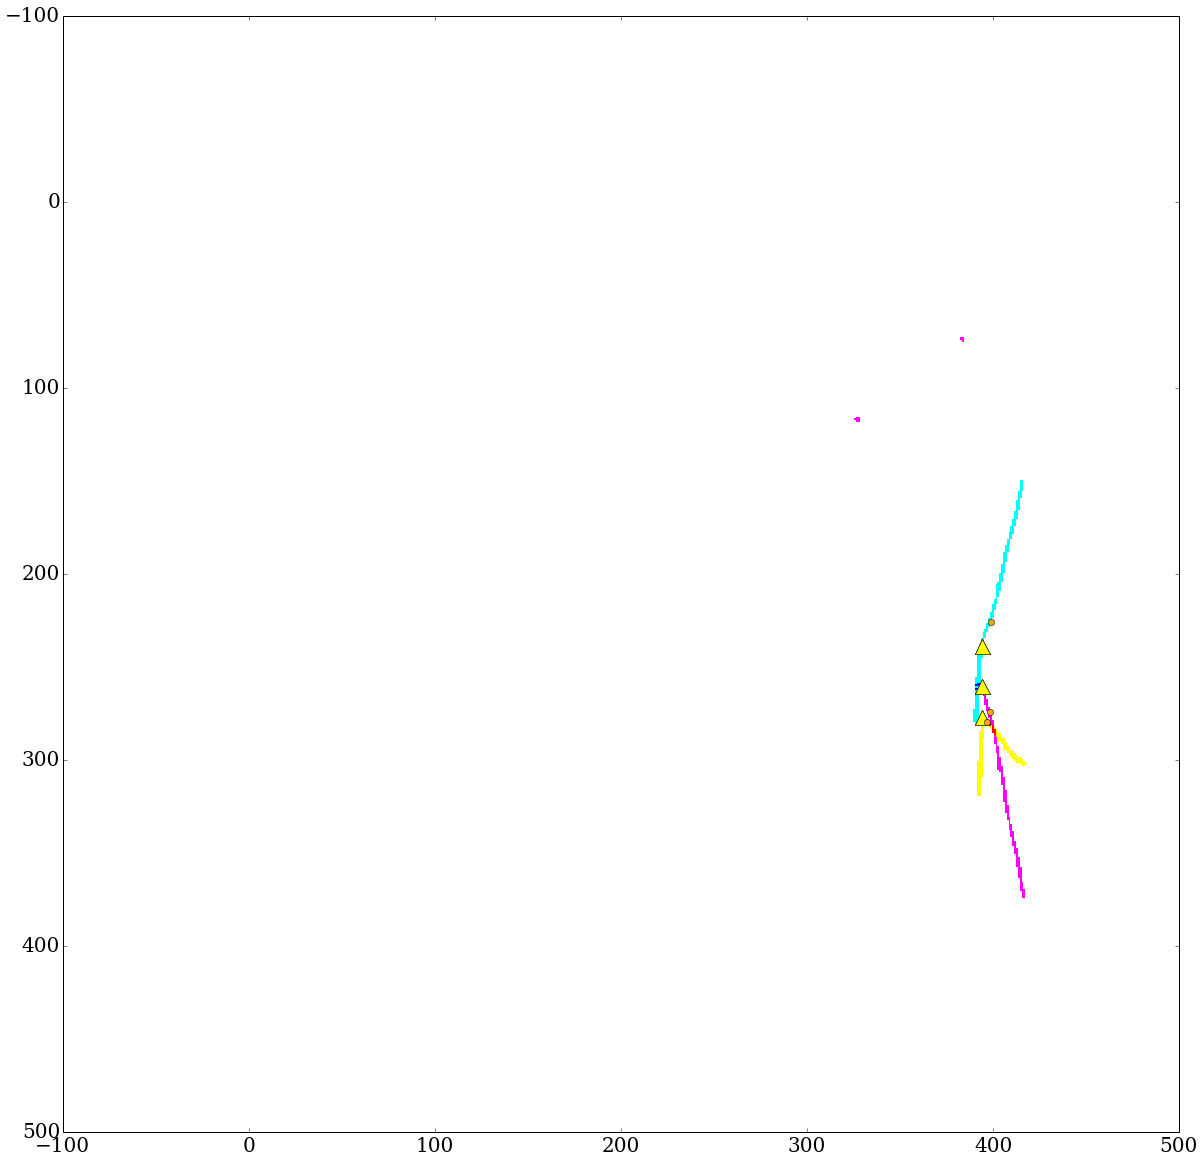

matched r/s/e  4 , 3221 , 64404 ... to  4 , 3221 , 64404


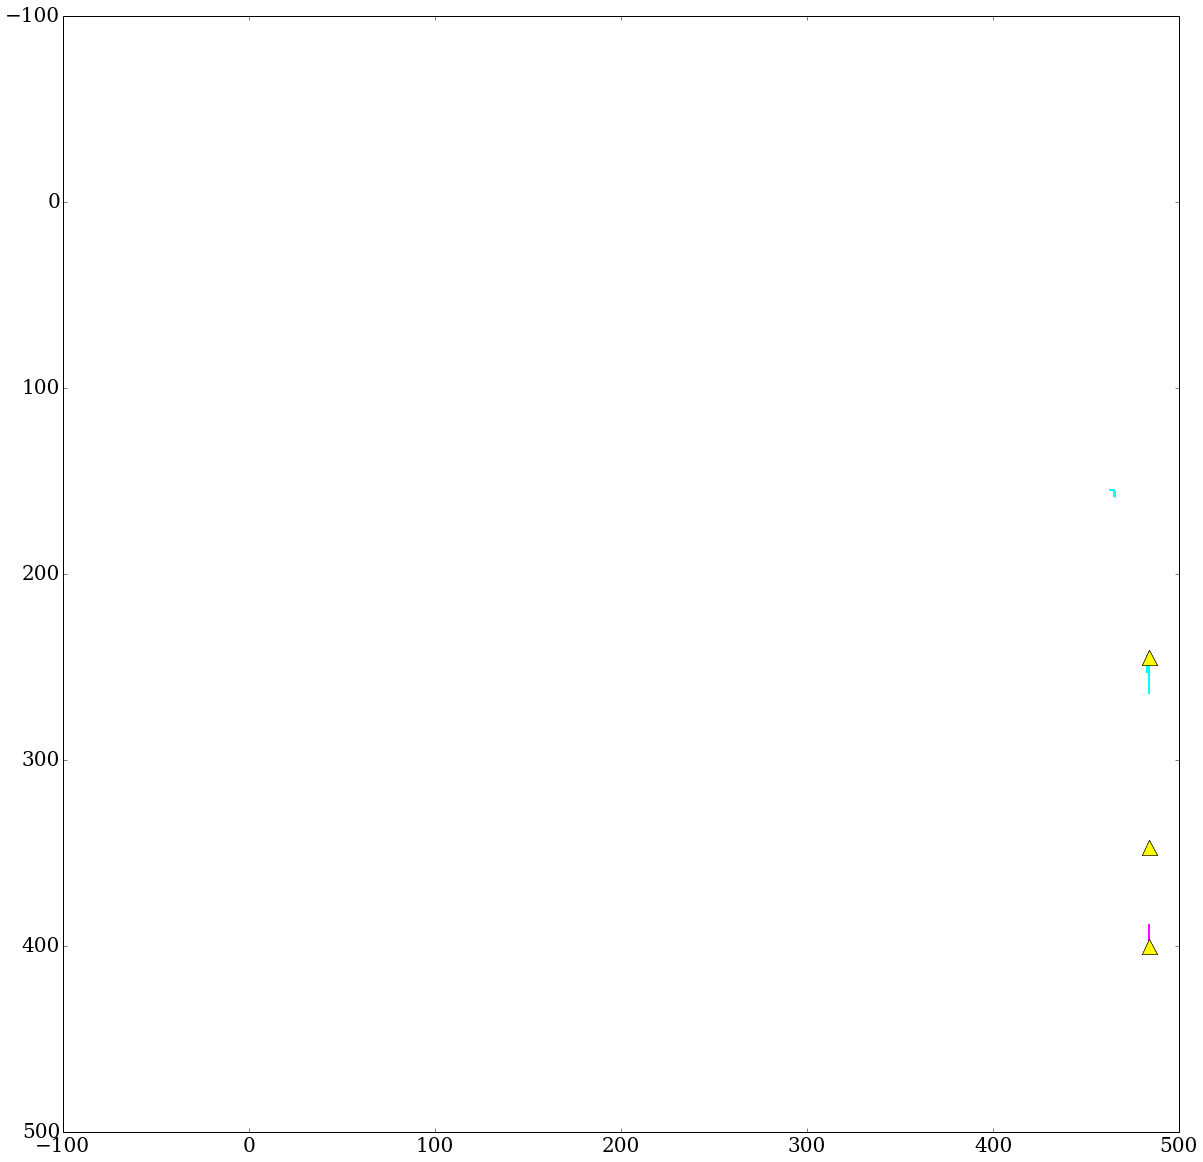

matched r/s/e  4 , 3964 , 79275 ... to  4 , 3964 , 79275


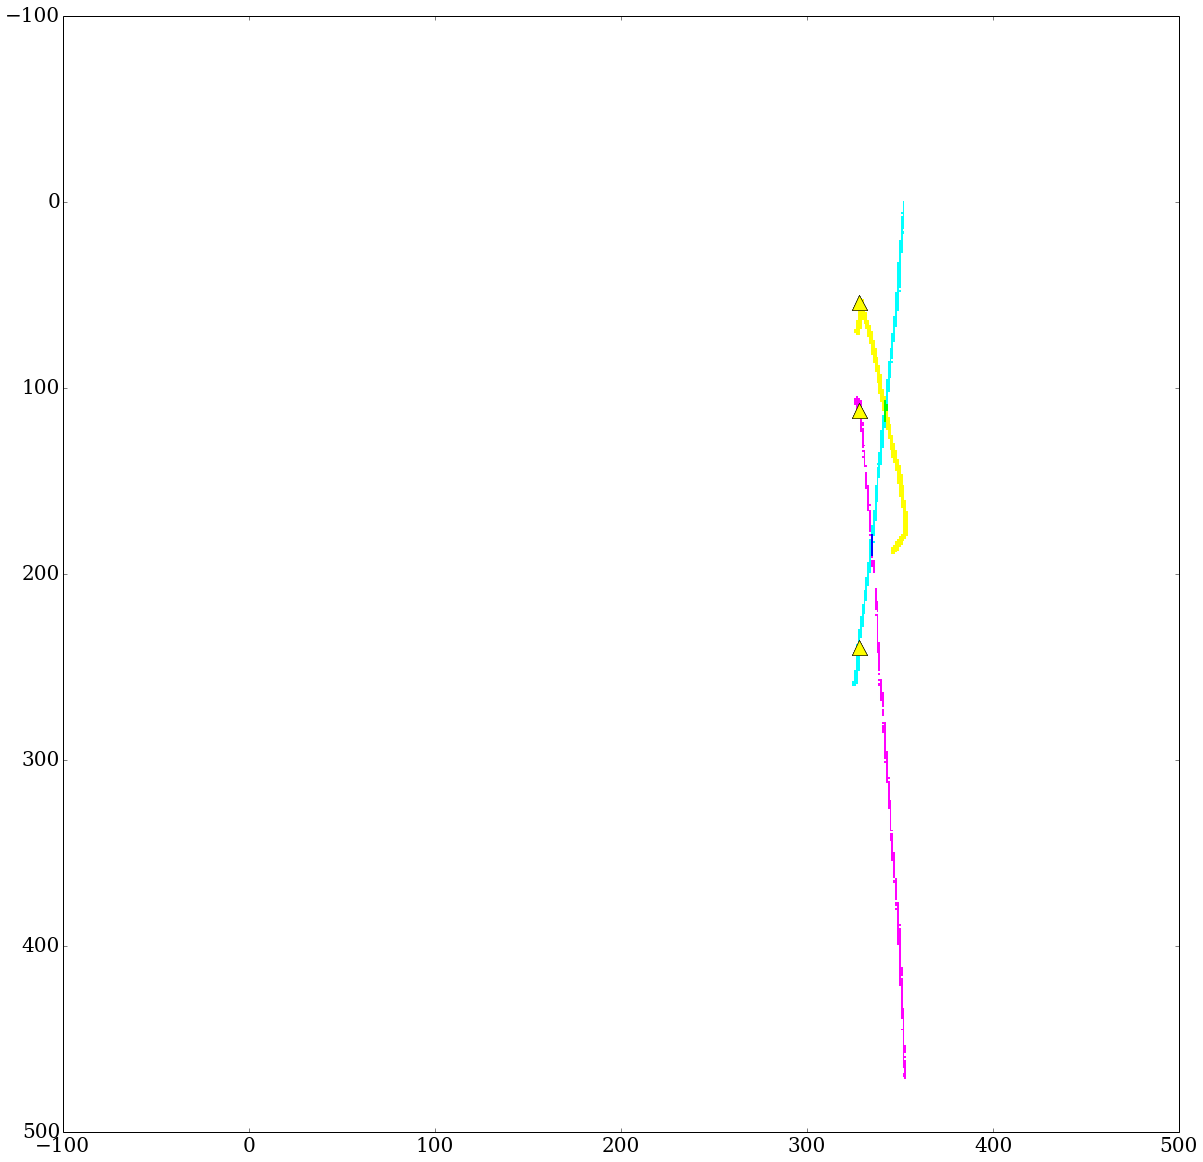

matched r/s/e  4 , 3443 , 68843 ... to  4 , 3443 , 68843


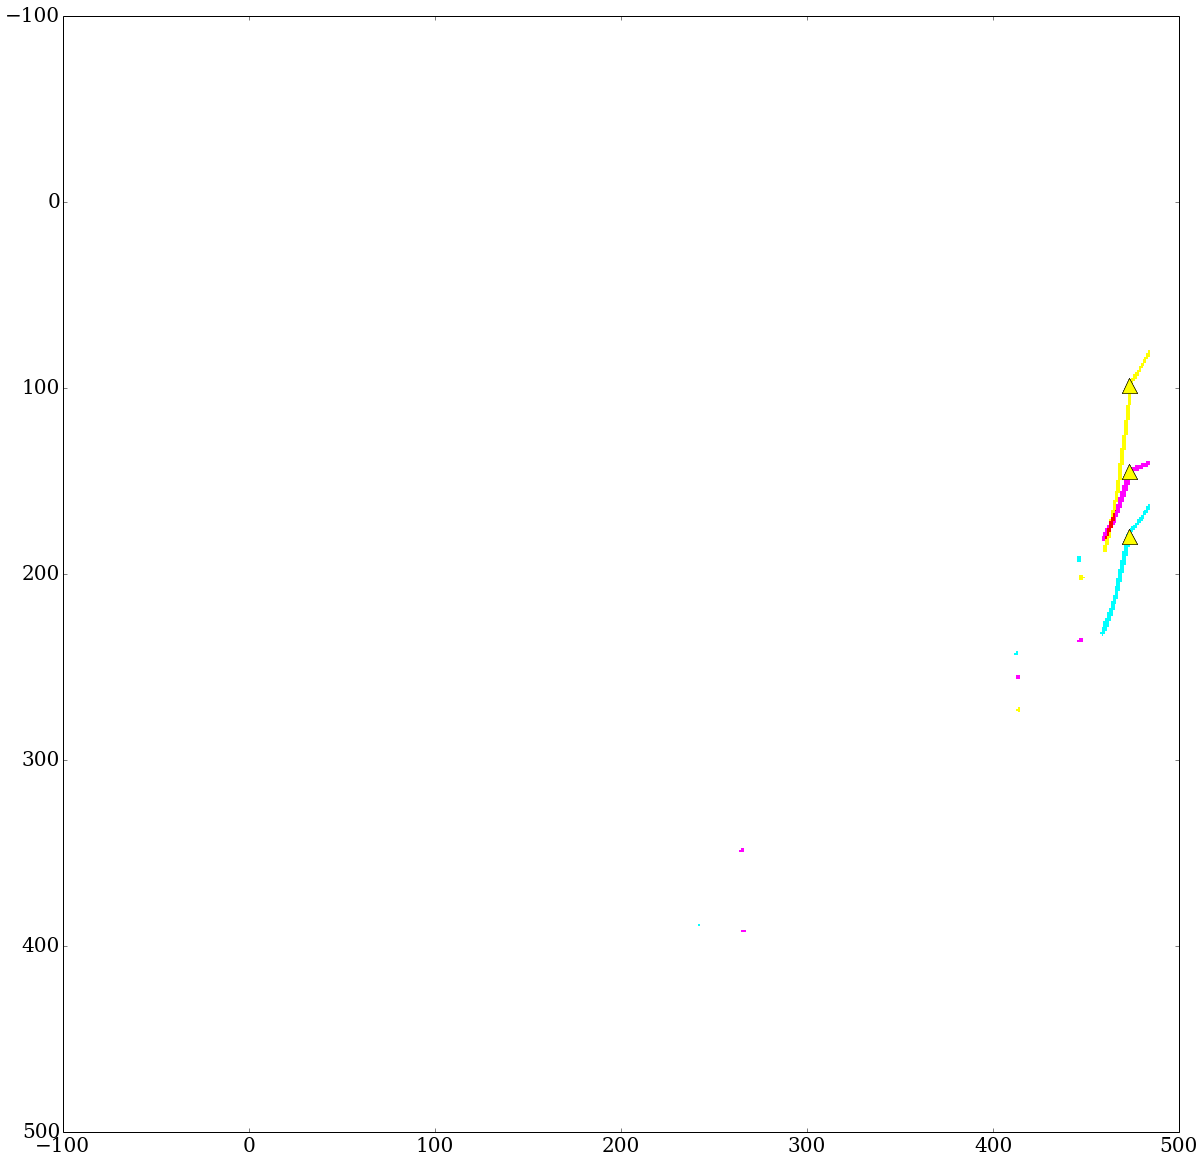

matched r/s/e  4 , 2544 , 50864 ... to  4 , 2544 , 50864
1992    0
Name: vtx3d_type, dtype: uint32


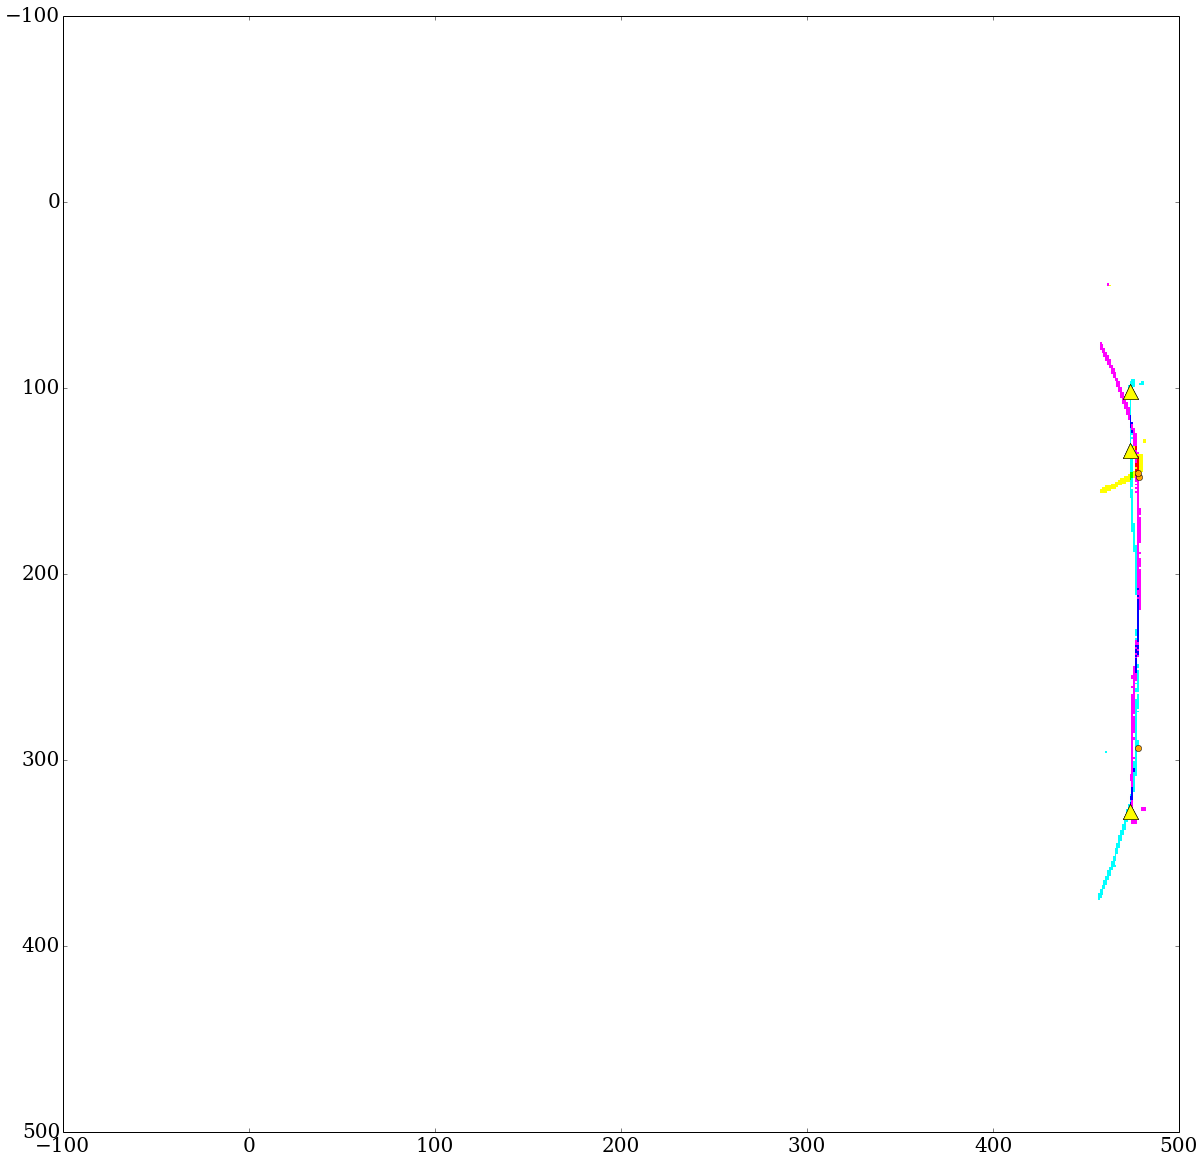

matched r/s/e  4 , 2693 , 53859 ... to  4 , 2693 , 53859
2008    1
Name: vtx3d_type, dtype: uint32


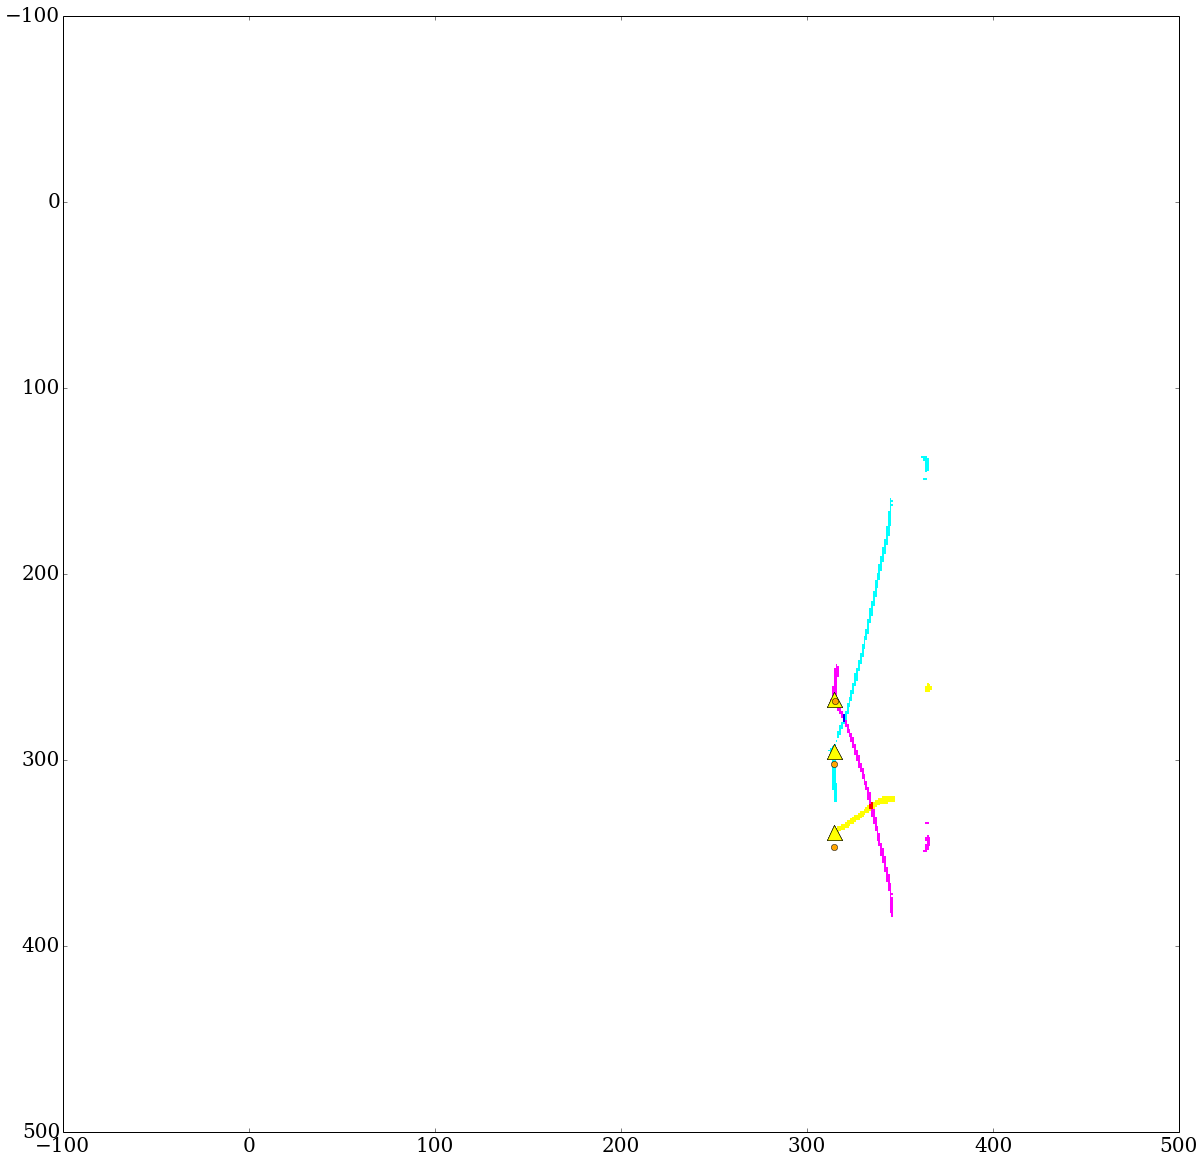

matched r/s/e  4 , 2384 , 47674 ... to  4 , 2384 , 47674


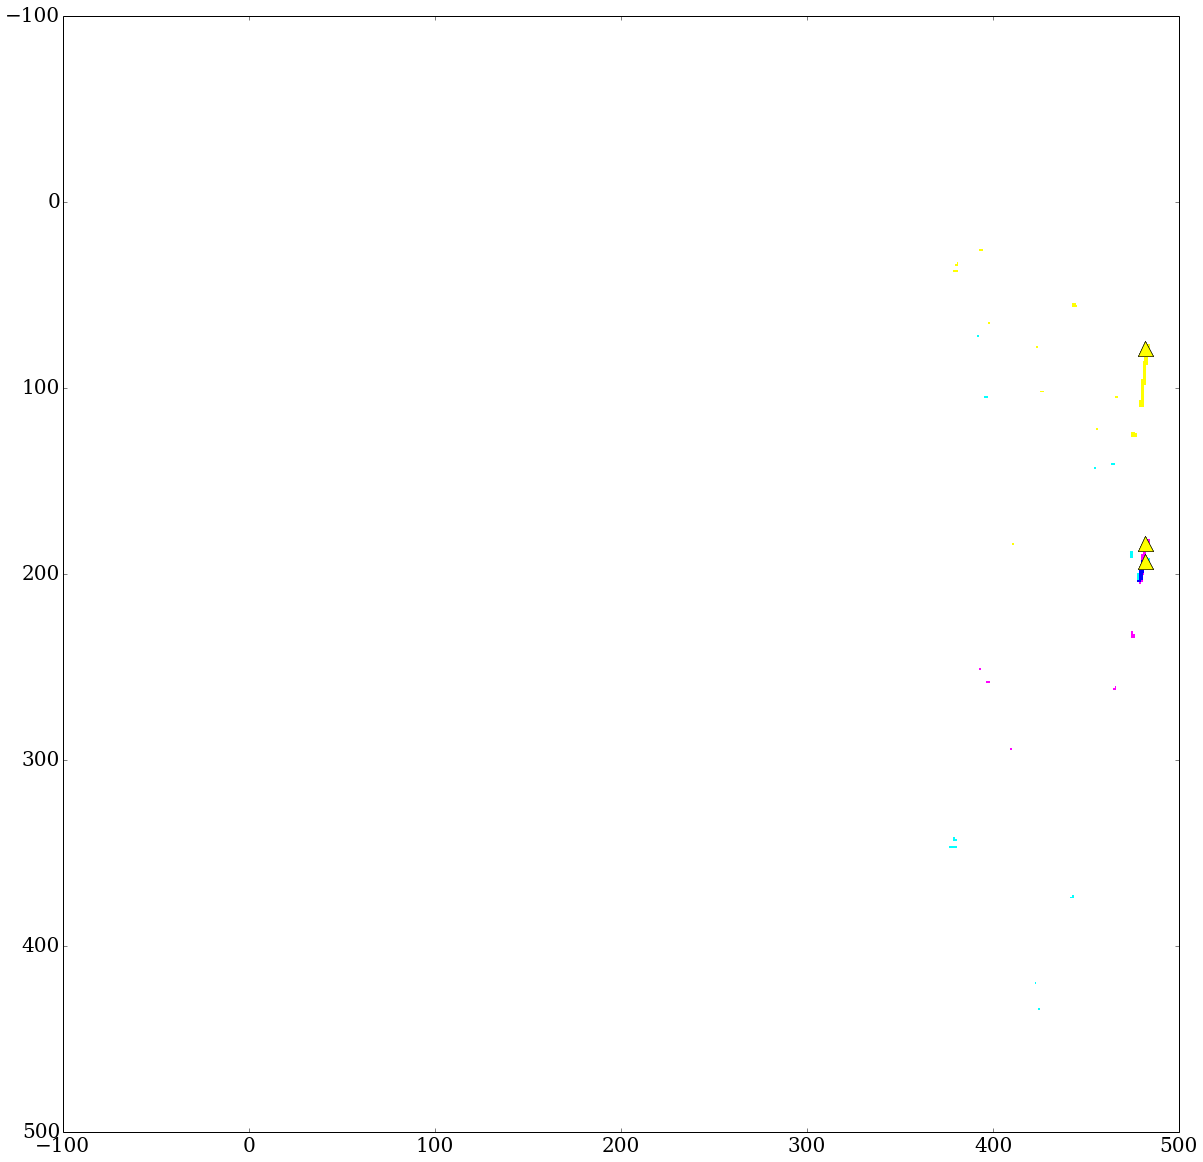

matched r/s/e  4 , 2516 , 50318 ... to  4 , 2516 , 50318


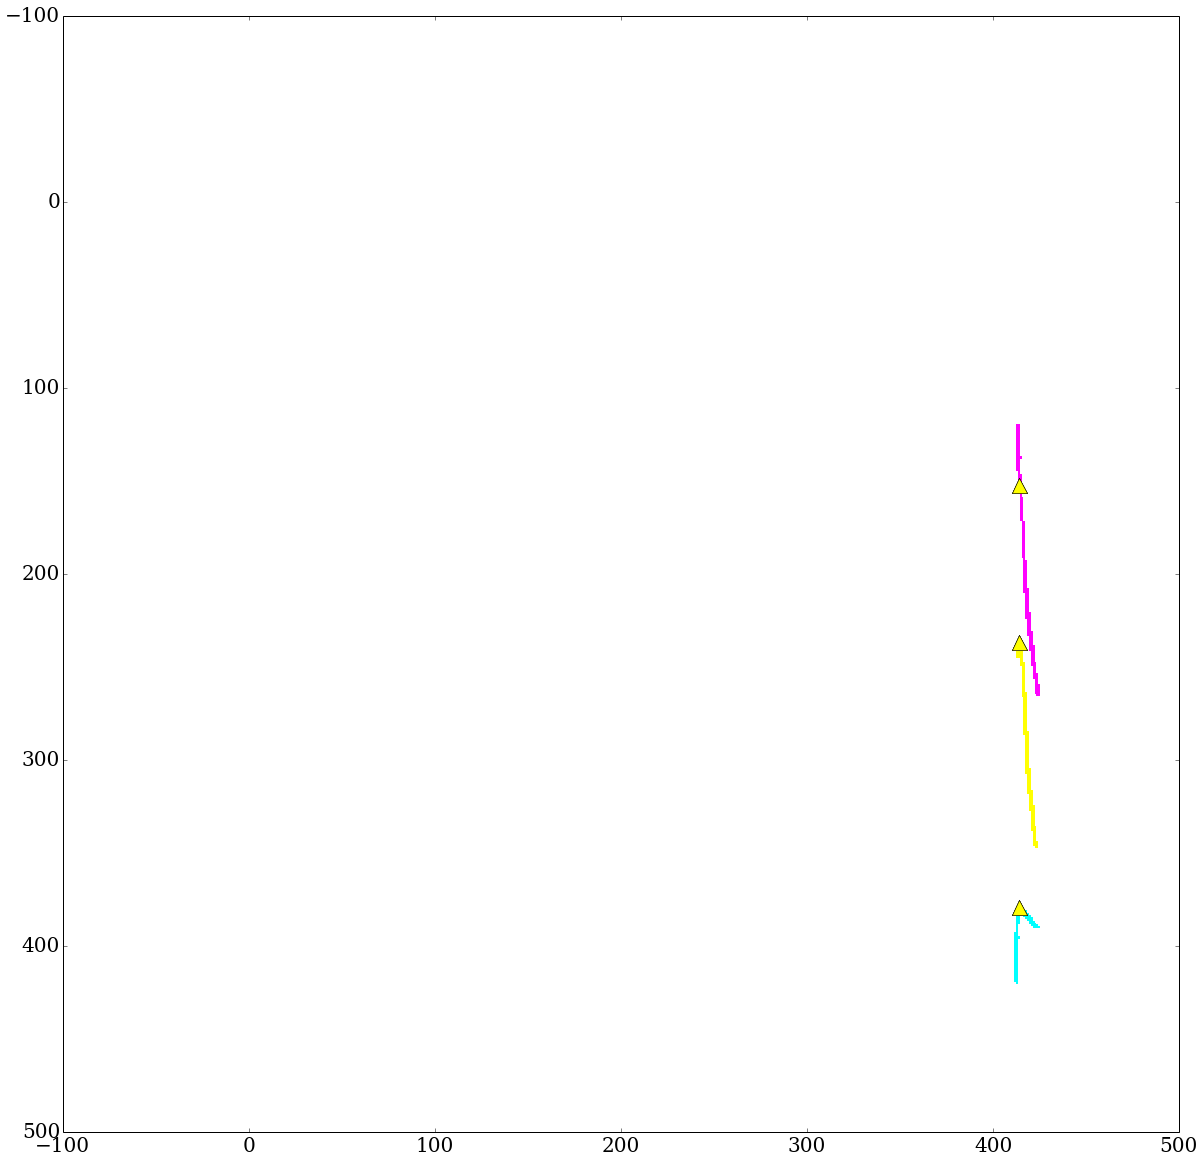

matched r/s/e  4 , 3262 , 65231 ... to  4 , 3262 , 65231
2183    0
2184    0
Name: vtx3d_type, dtype: uint32
2183    0
2184    0
Name: vtx3d_type, dtype: uint32


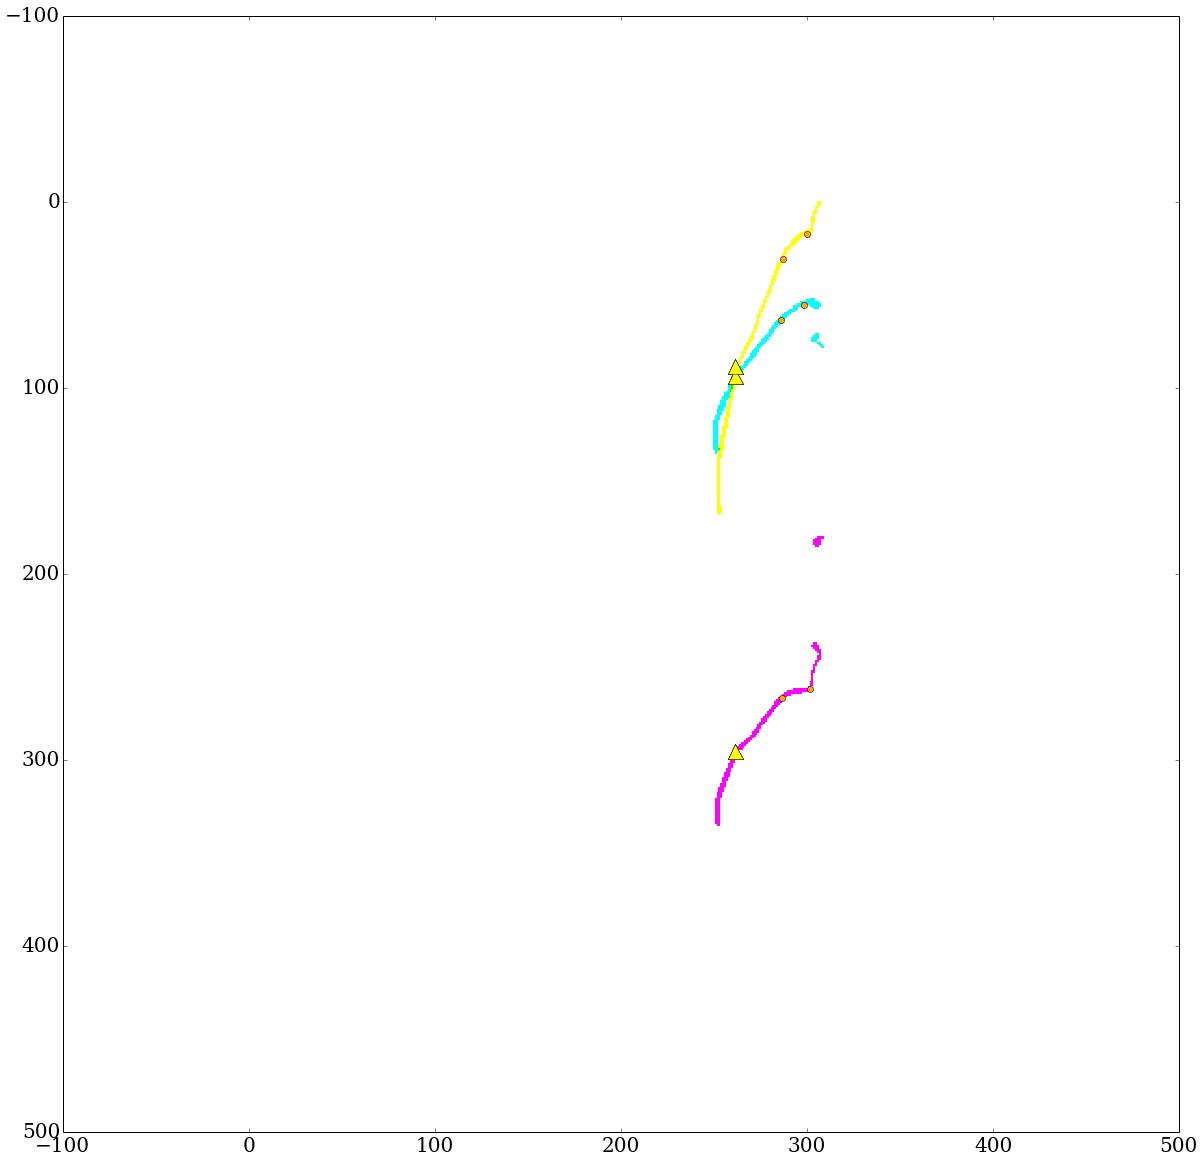

matched r/s/e  4 , 2572 , 51433 ... to  4 , 2572 , 51433


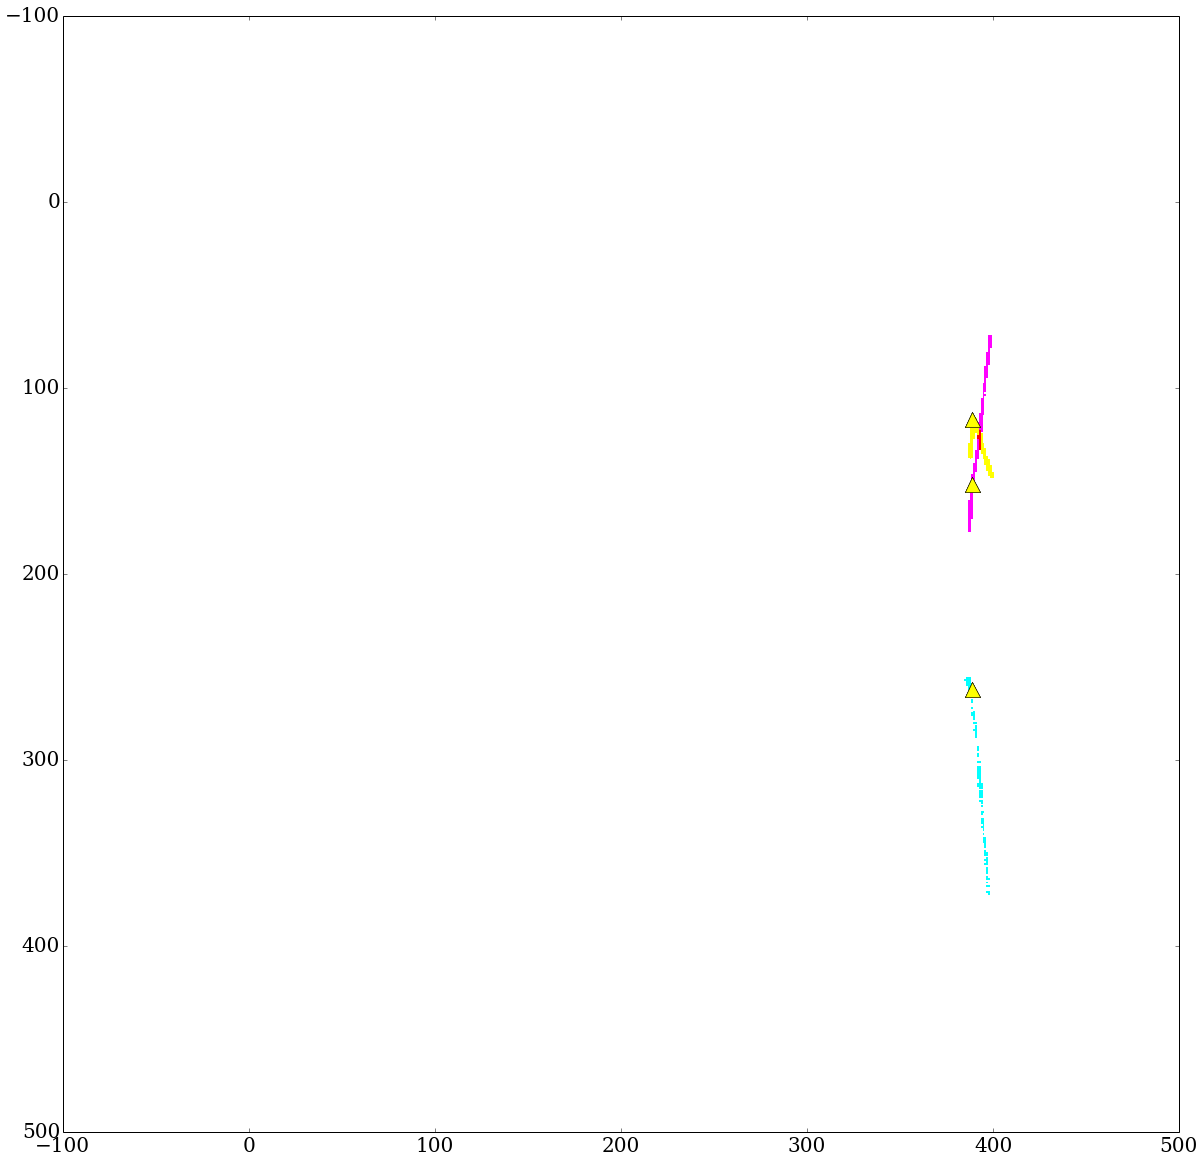

matched r/s/e  4 , 3949 , 78966 ... to  4 , 3949 , 78966
2303    0
Name: vtx3d_type, dtype: uint32


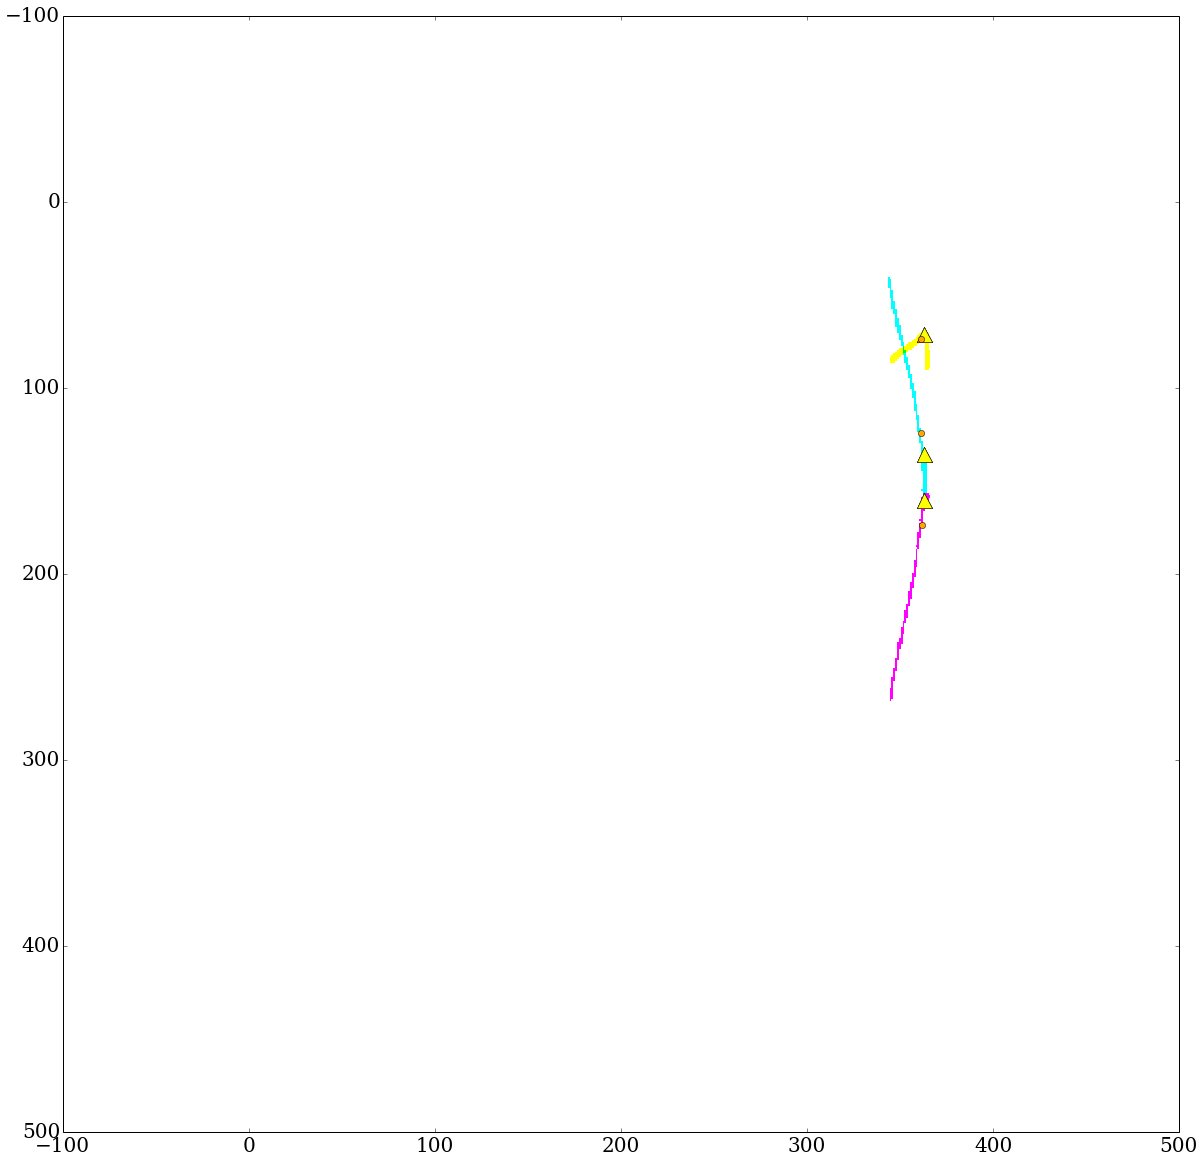

matched r/s/e  4 , 3231 , 64611 ... to  4 , 3231 , 64611
2333    0
Name: vtx3d_type, dtype: uint32


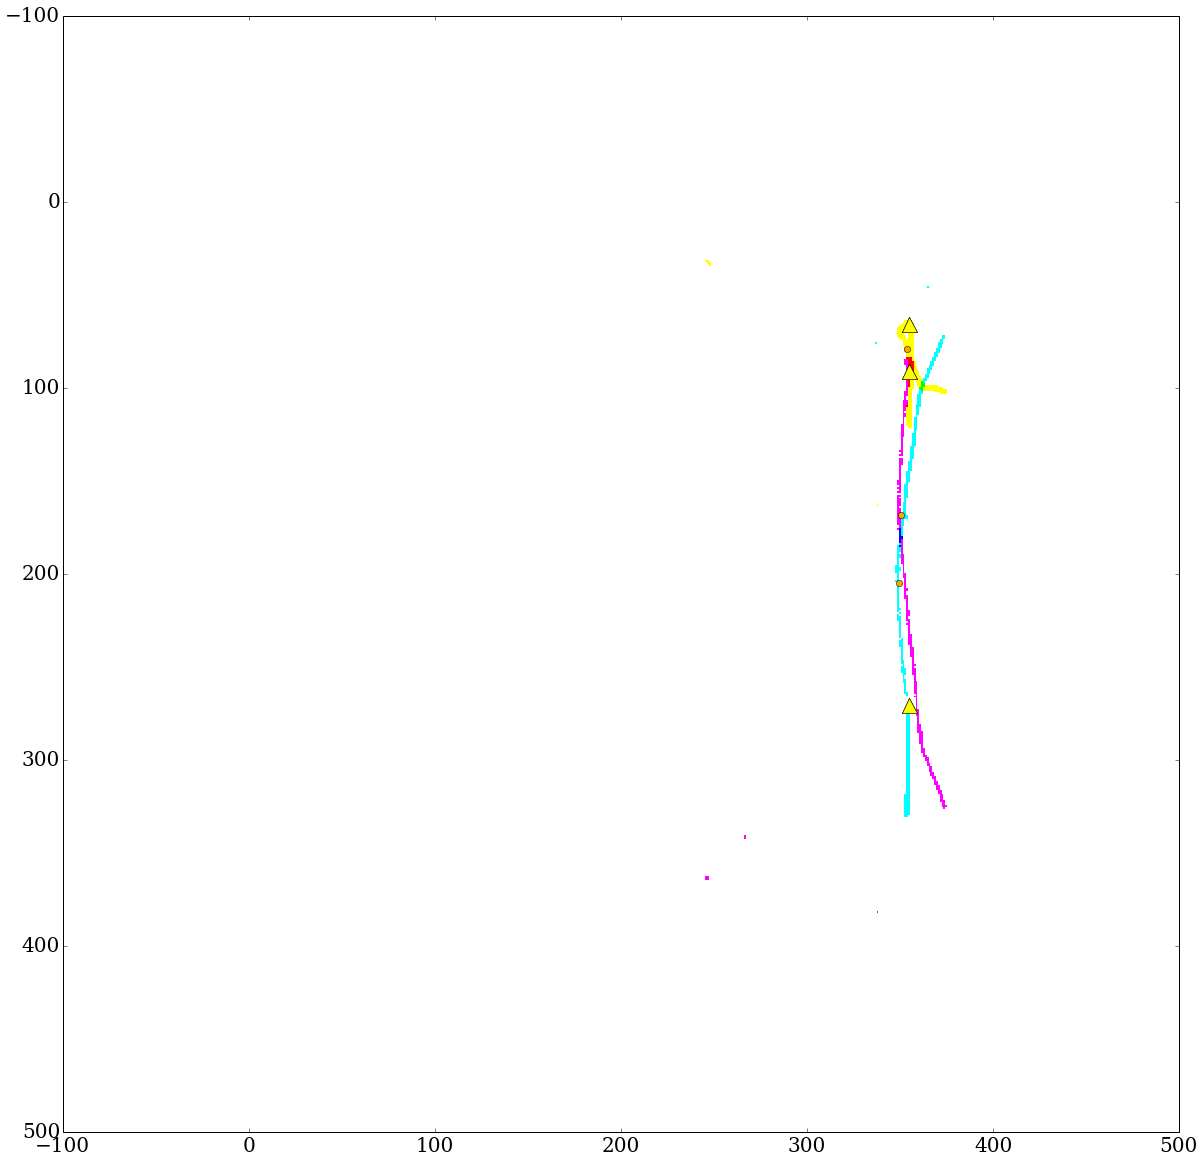

matched r/s/e  4 , 2819 , 56371 ... to  4 , 2819 , 56371
2485    0
Name: vtx3d_type, dtype: uint32


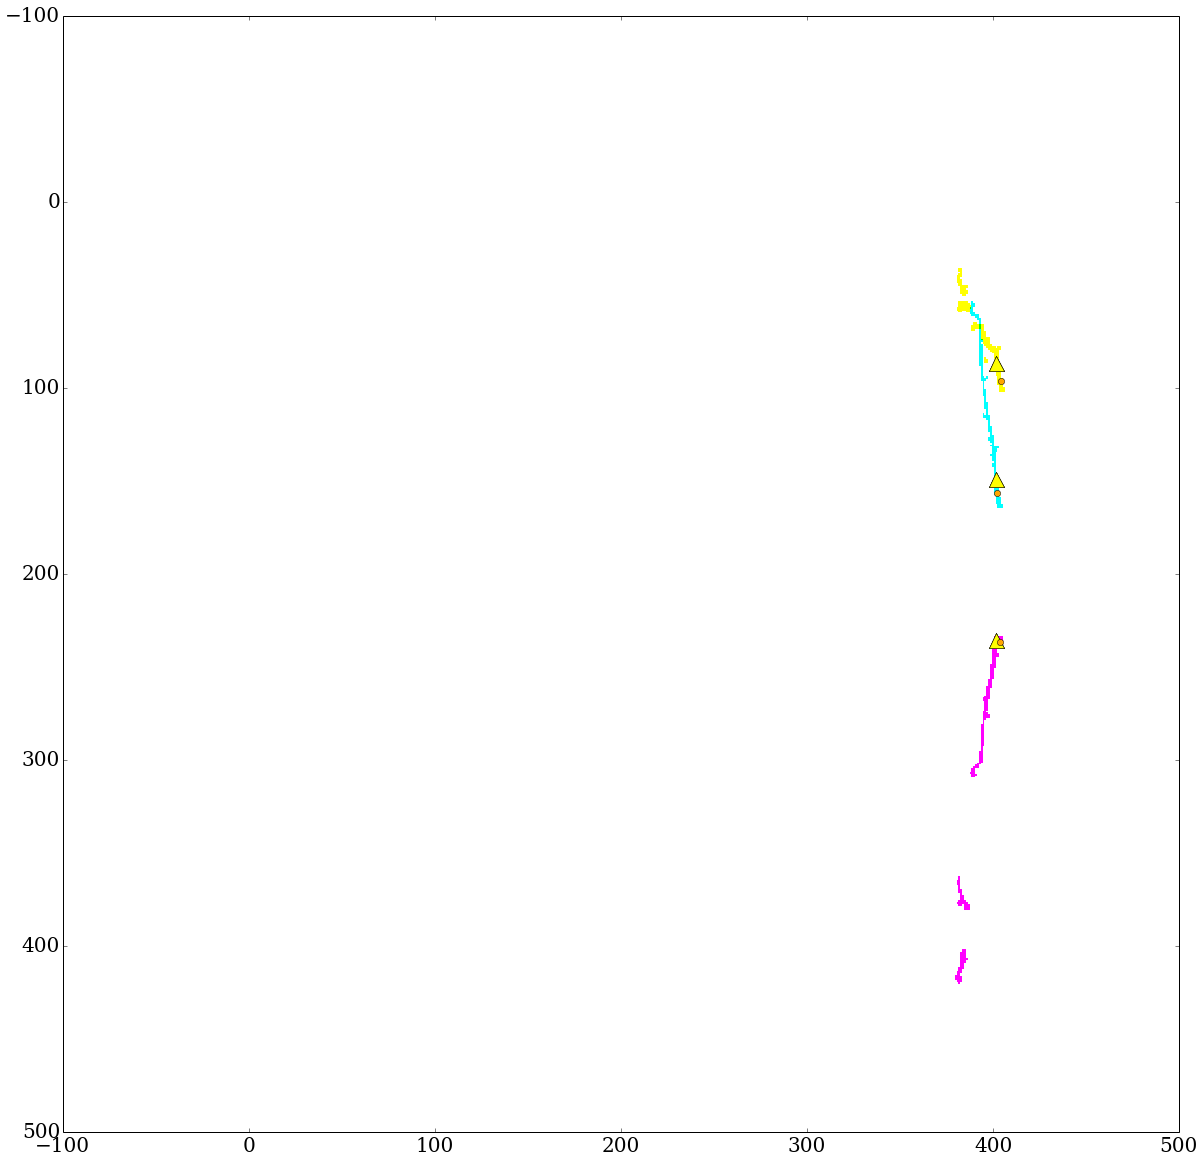

matched r/s/e  4 , 2875 , 57491 ... to  4 , 2875 , 57491


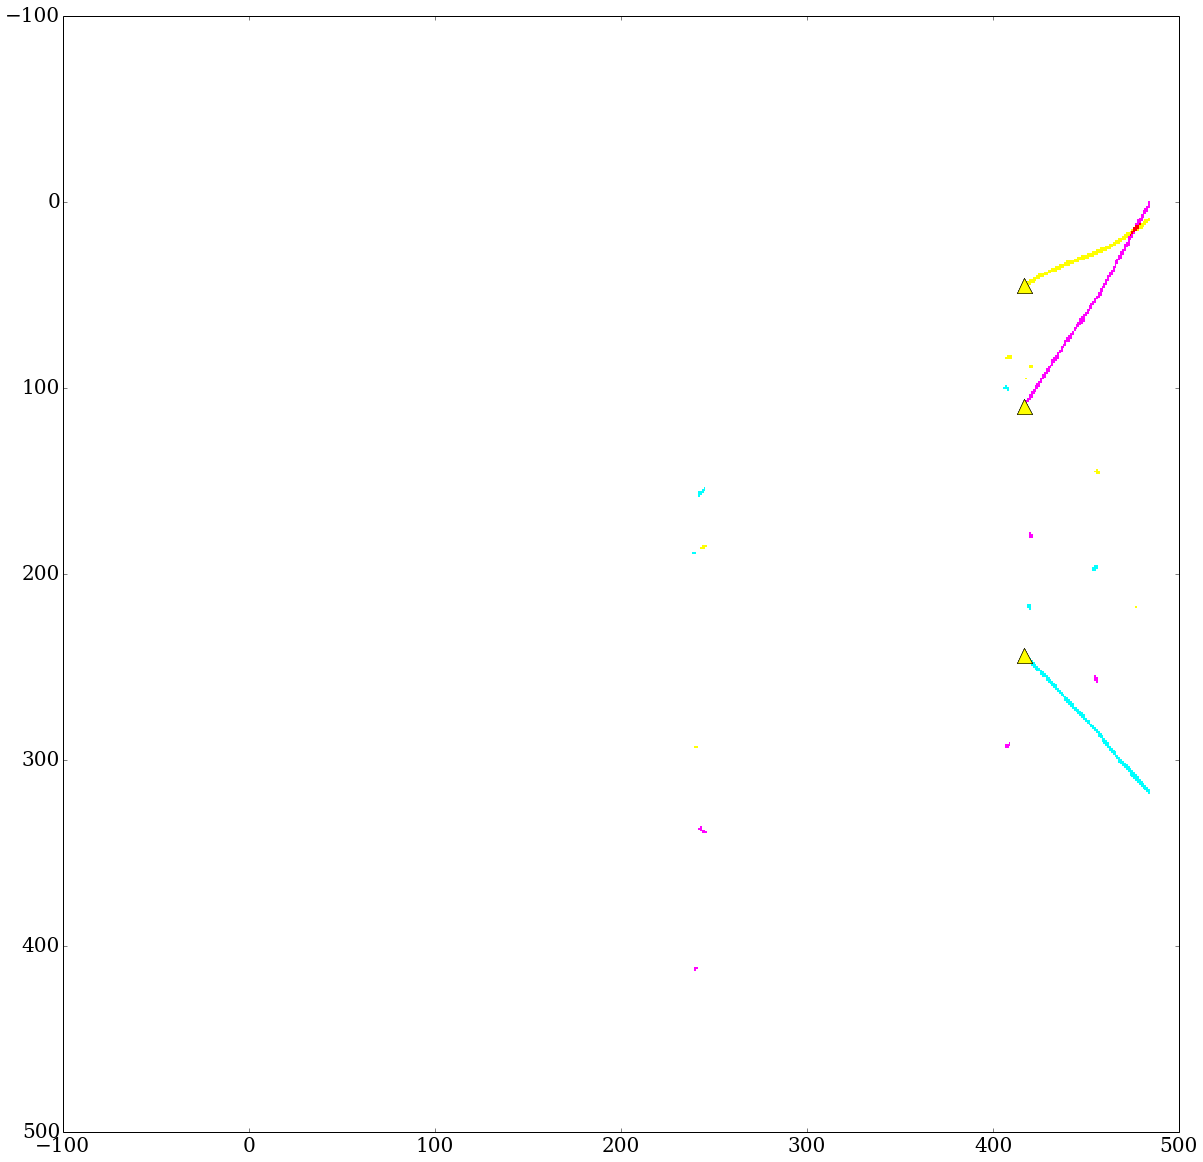

matched r/s/e  4 , 2464 , 49271 ... to  4 , 2464 , 49271
2574    0
2575    1
Name: vtx3d_type, dtype: uint32
2574    0
2575    1
Name: vtx3d_type, dtype: uint32


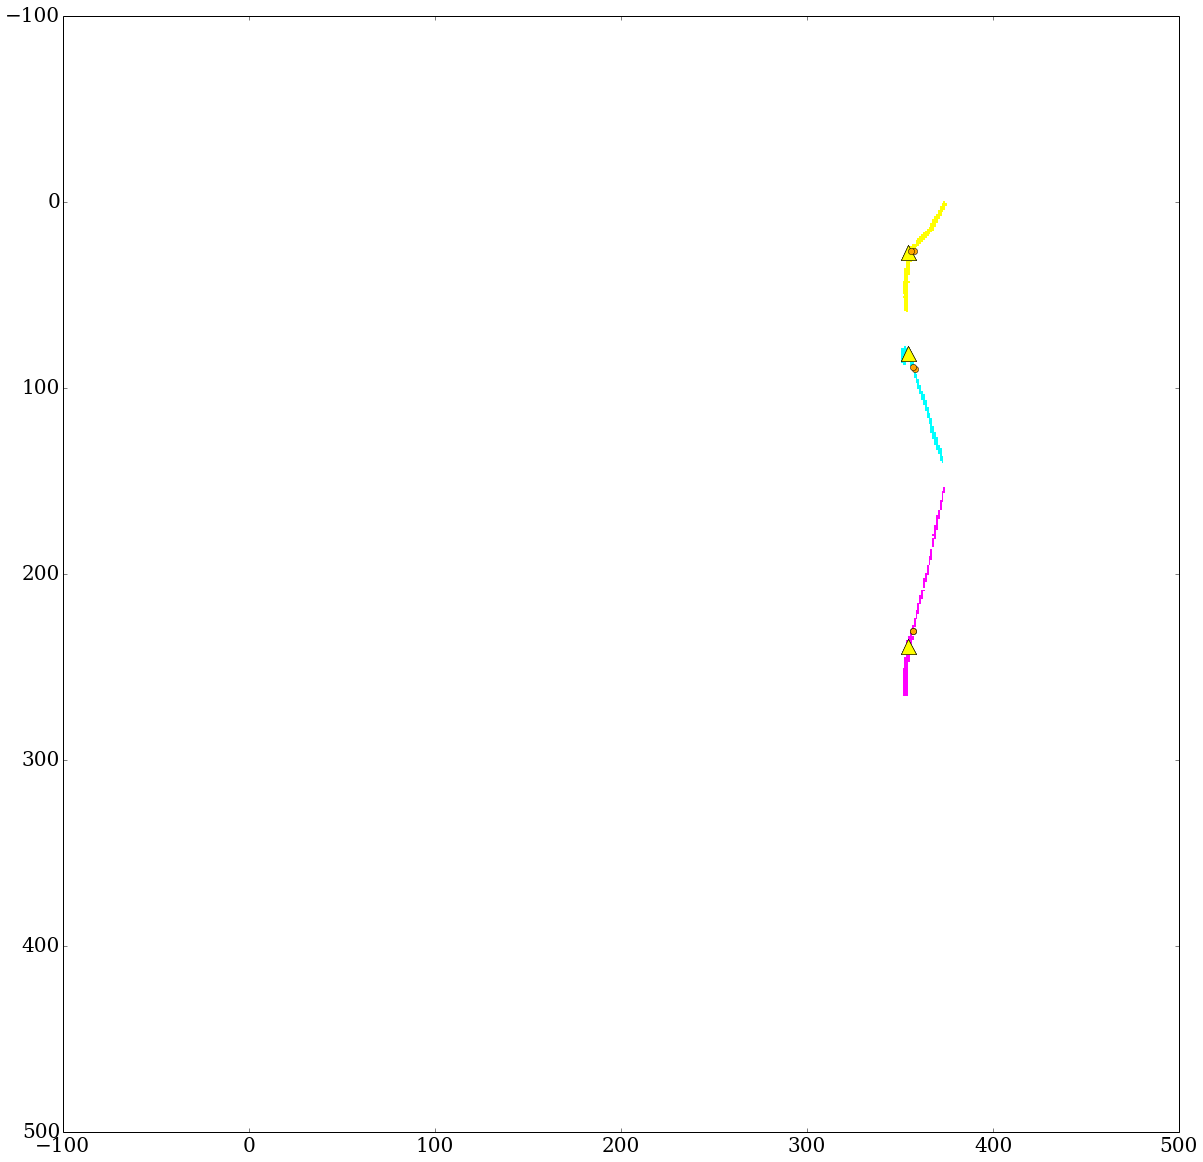

matched r/s/e  4 , 4030 , 80593 ... to  4 , 4030 , 80593
2765    0
2766    0
2767    1
Name: vtx3d_type, dtype: uint32
2765    0
2766    0
2767    1
Name: vtx3d_type, dtype: uint32
2765    0
2766    0
2767    1
Name: vtx3d_type, dtype: uint32


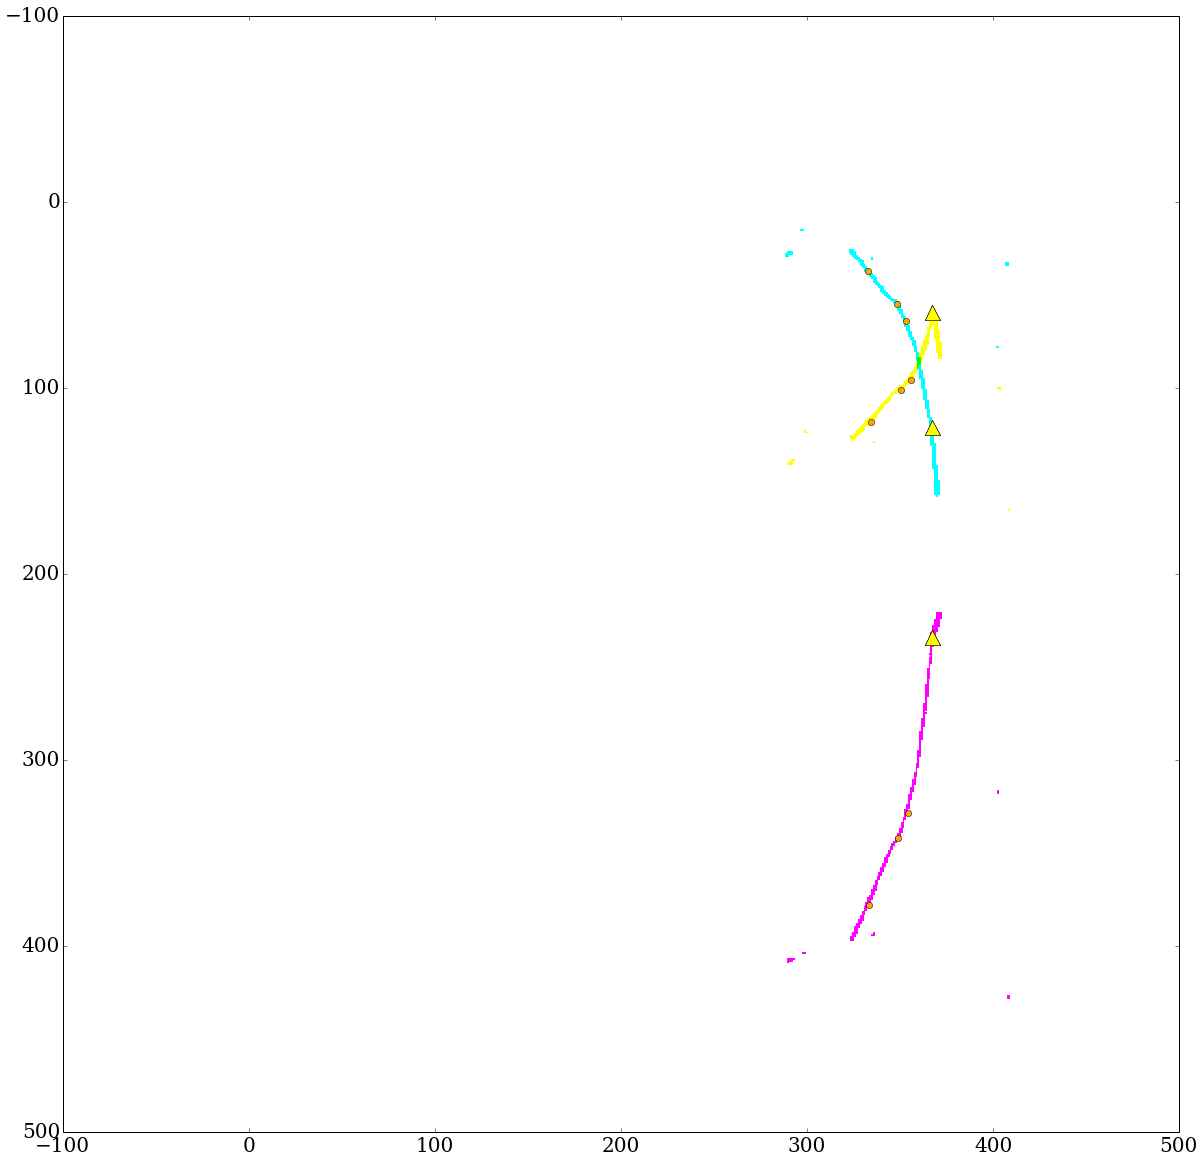

matched r/s/e  4 , 5266 , 105318 ... to  4 , 5266 , 105318


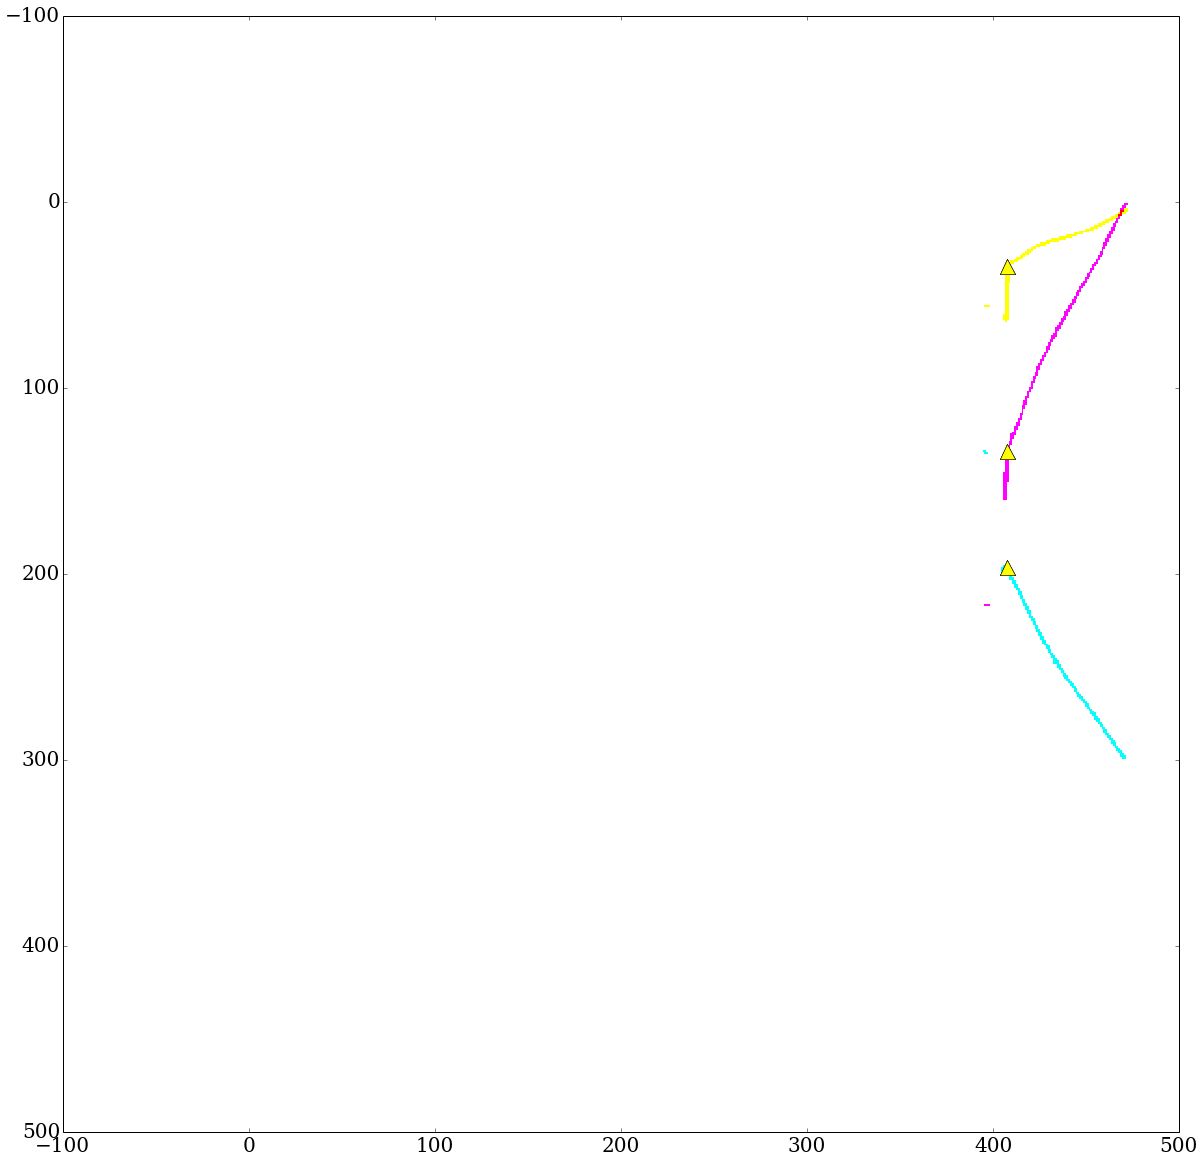

matched r/s/e  4 , 5592 , 111840 ... to  4 , 5592 , 111840
2908    0
Name: vtx3d_type, dtype: uint32


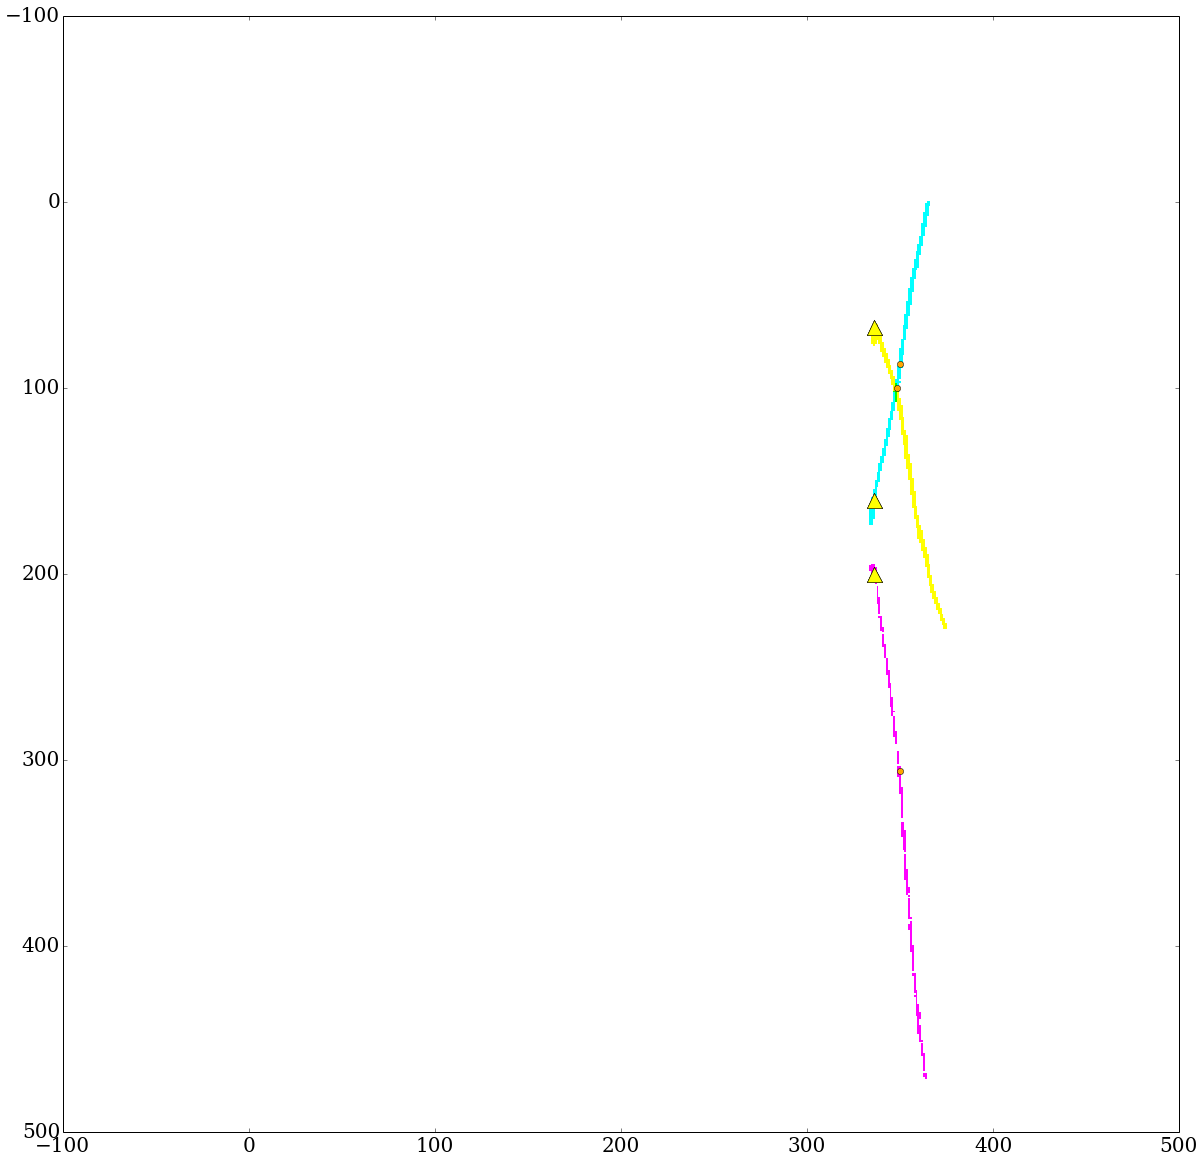

matched r/s/e  4 , 5199 , 103974 ... to  4 , 5199 , 103974
2960    0
2961    0
2962    0
2963    0
2964    1
Name: vtx3d_type, dtype: uint32
2960    0
2961    0
2962    0
2963    0
2964    1
Name: vtx3d_type, dtype: uint32
2960    0
2961    0
2962    0
2963    0
2964    1
Name: vtx3d_type, dtype: uint32
2960    0
2961    0
2962    0
2963    0
2964    1
Name: vtx3d_type, dtype: uint32
2960    0
2961    0
2962    0
2963    0
2964    1
Name: vtx3d_type, dtype: uint32


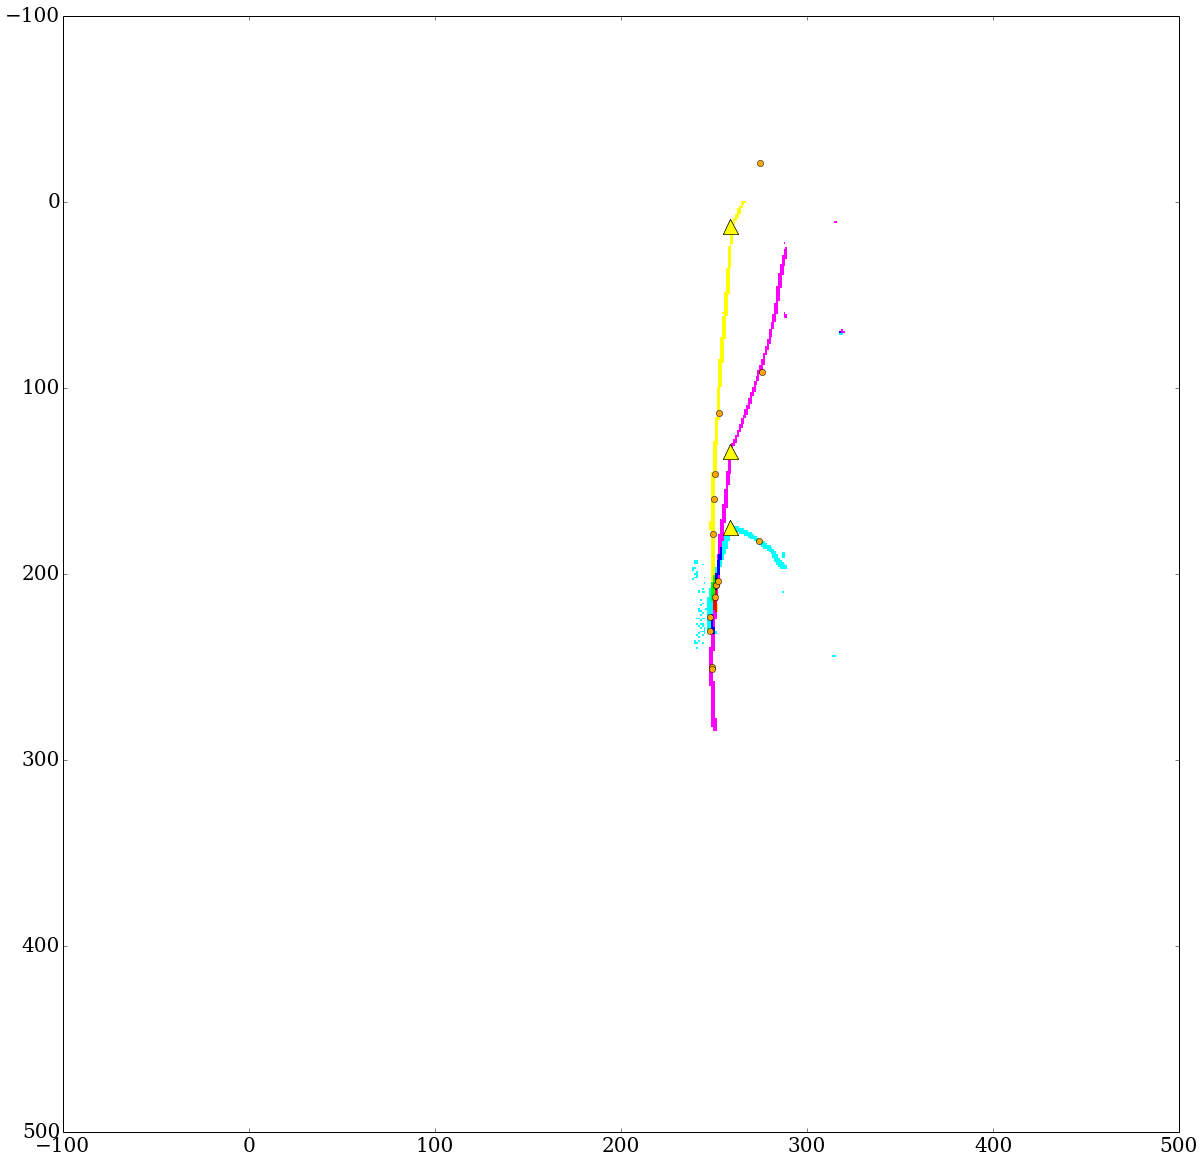

matched r/s/e  4 , 5909 , 118161 ... to  4 , 5909 , 118161


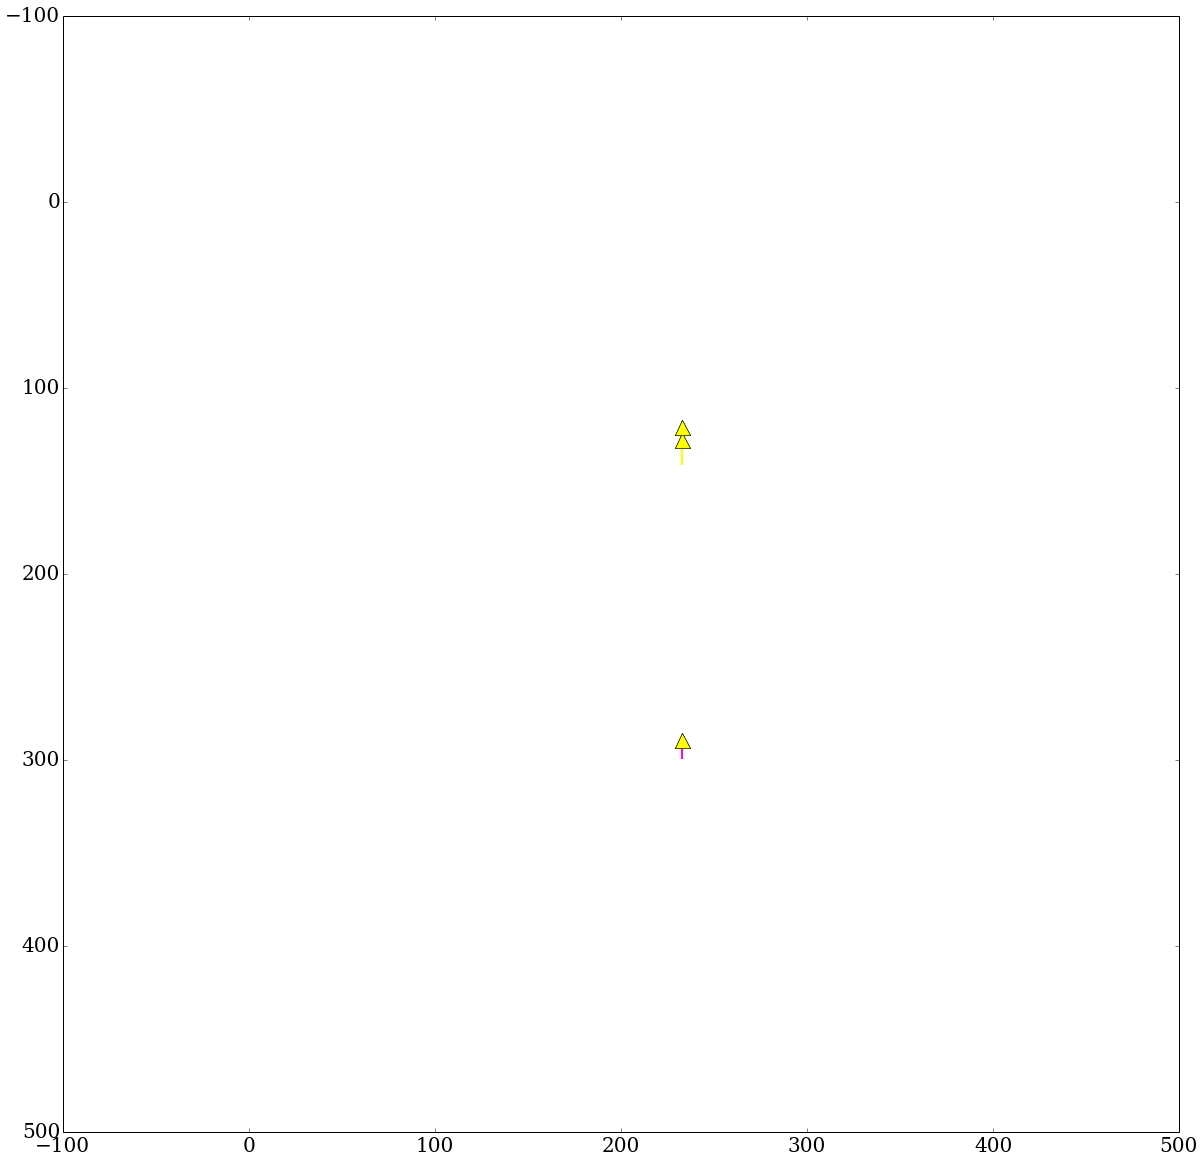

matched r/s/e  4 , 4297 , 85936 ... to  4 , 4297 , 85936


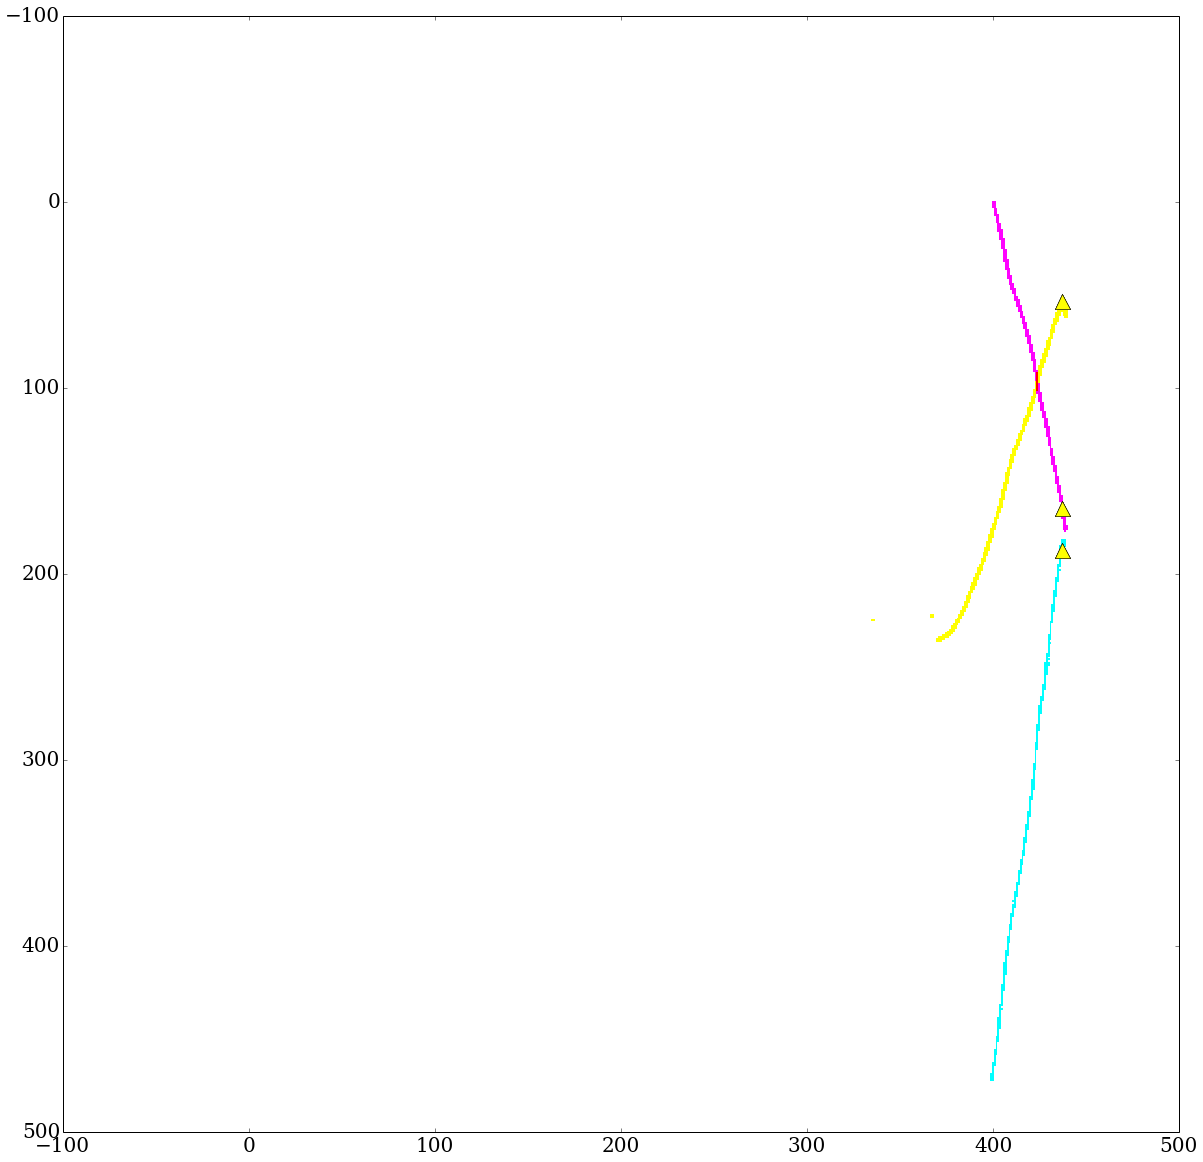

matched r/s/e  4 , 4550 , 90993 ... to  4 , 4550 , 90993
3167    0
Name: vtx3d_type, dtype: uint32


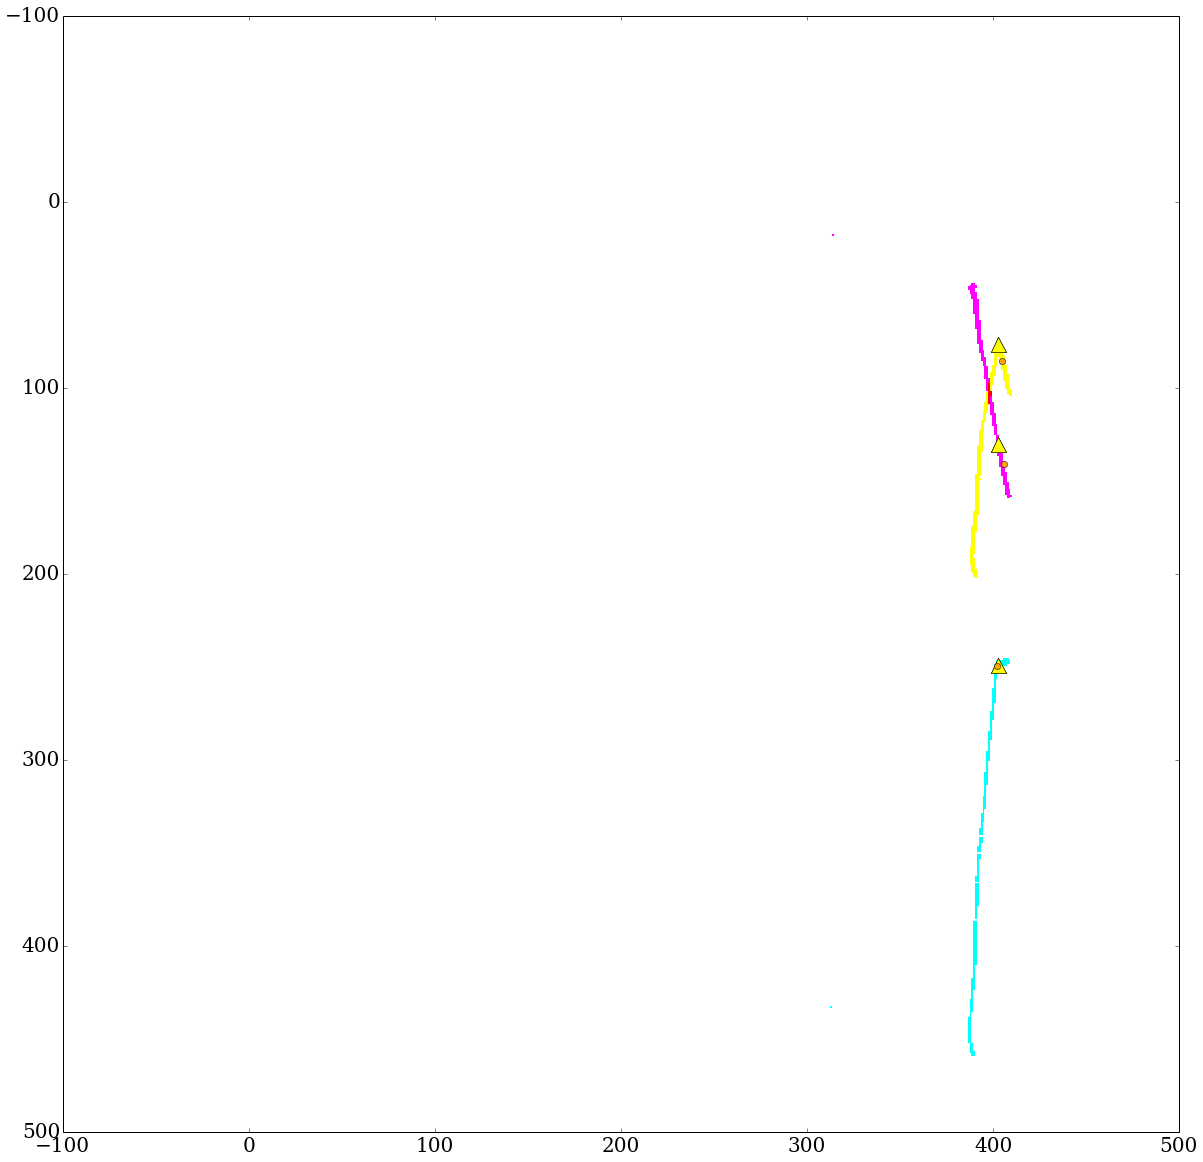

matched r/s/e  4 , 5284 , 105667 ... to  4 , 5284 , 105667
3197    0
Name: vtx3d_type, dtype: uint32


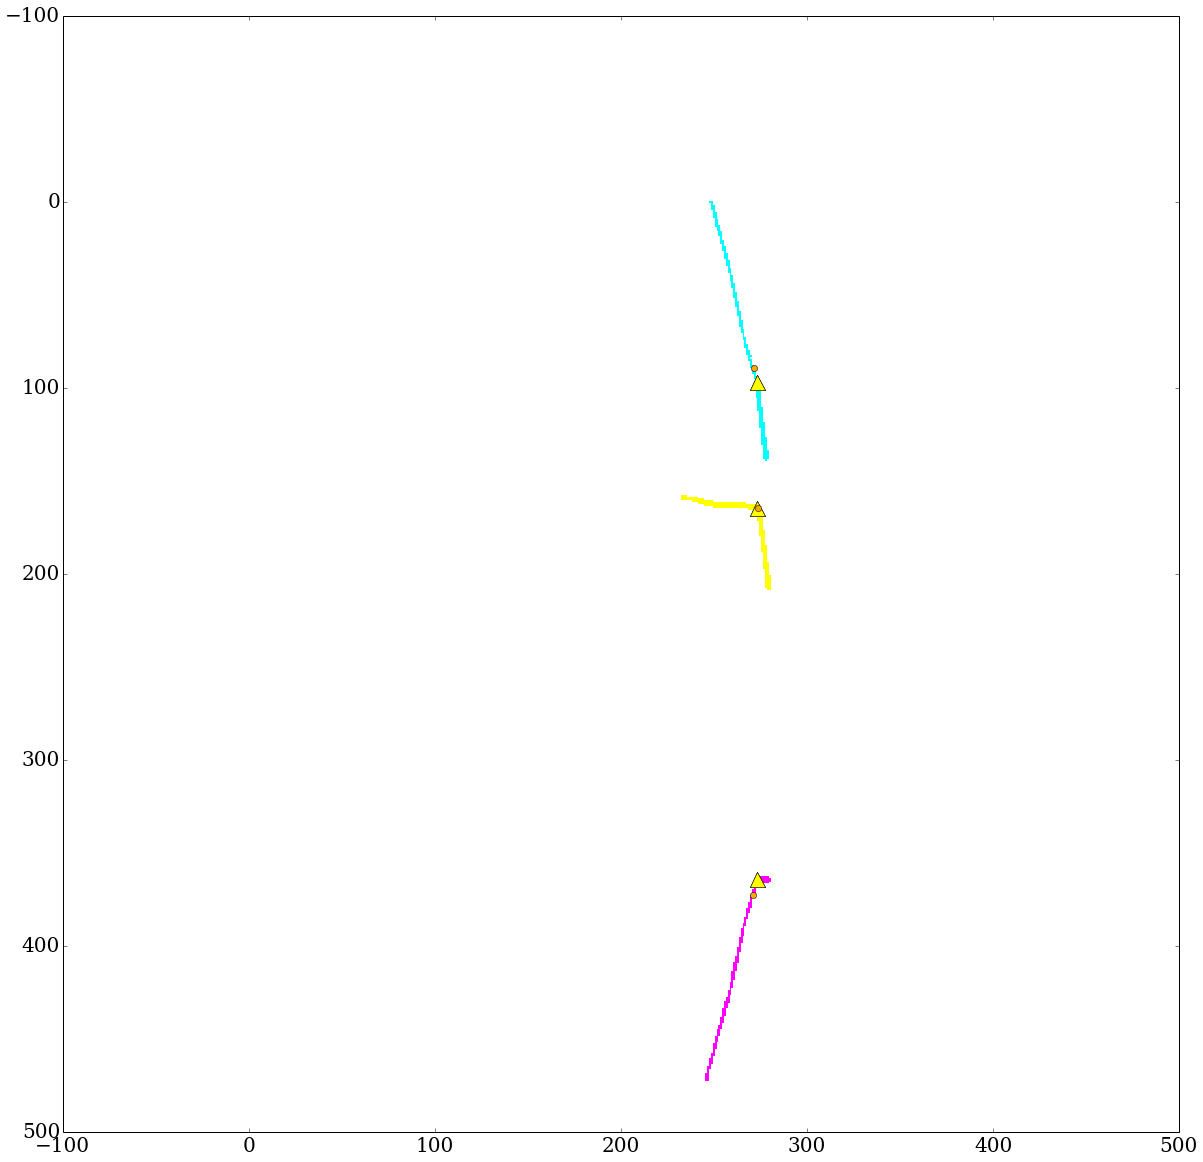

matched r/s/e  4 , 4599 , 91973 ... to  4 , 4599 , 91973


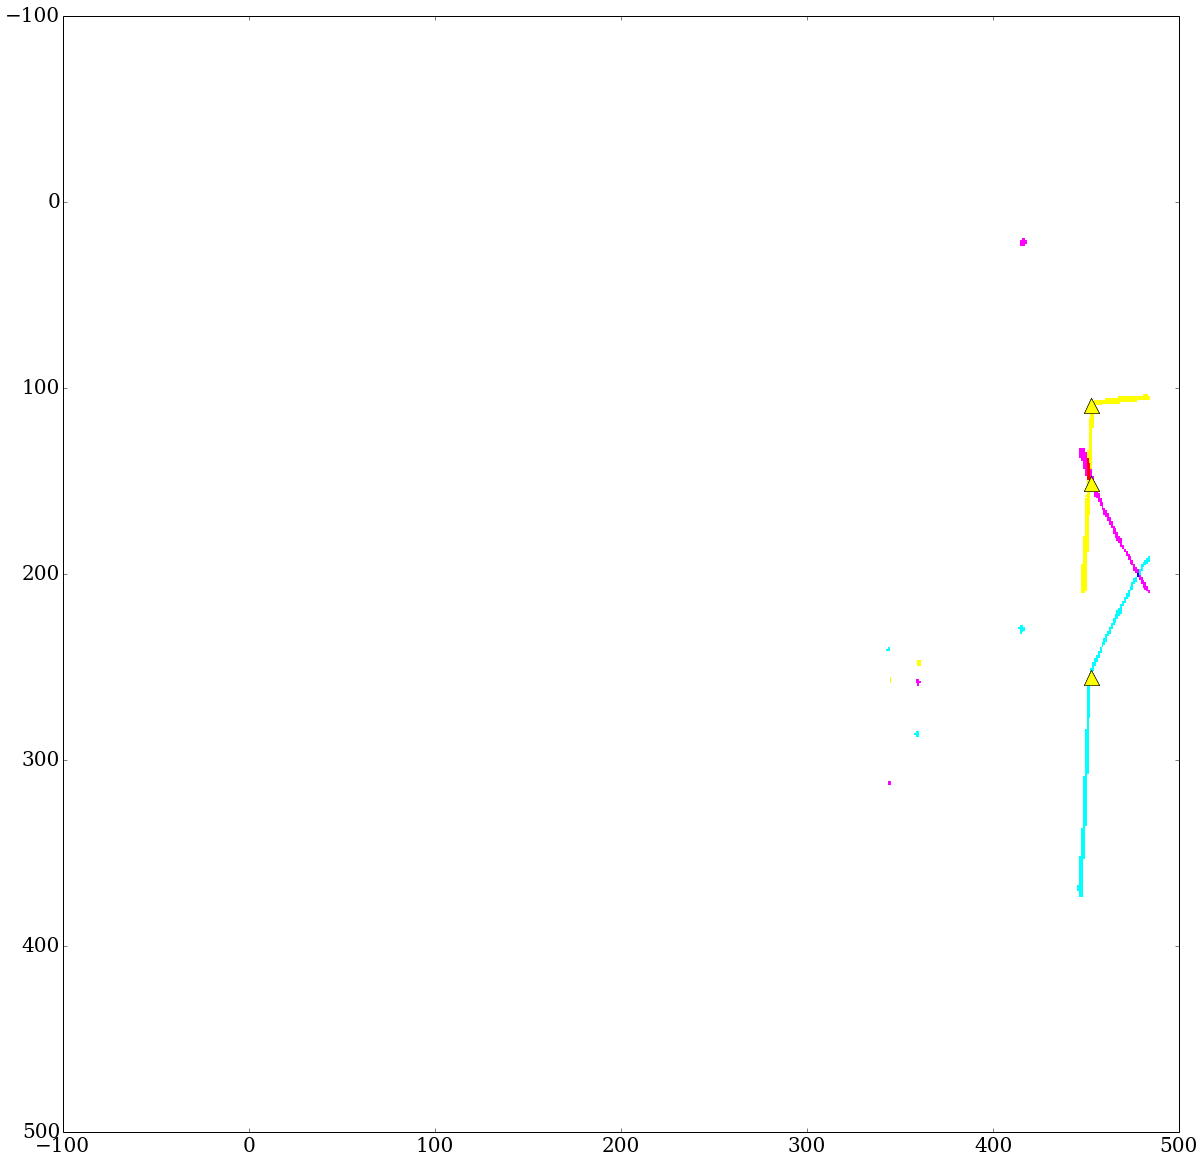

matched r/s/e  4 , 5188 , 103759 ... to  4 , 5188 , 103759
3363    0
Name: vtx3d_type, dtype: uint32


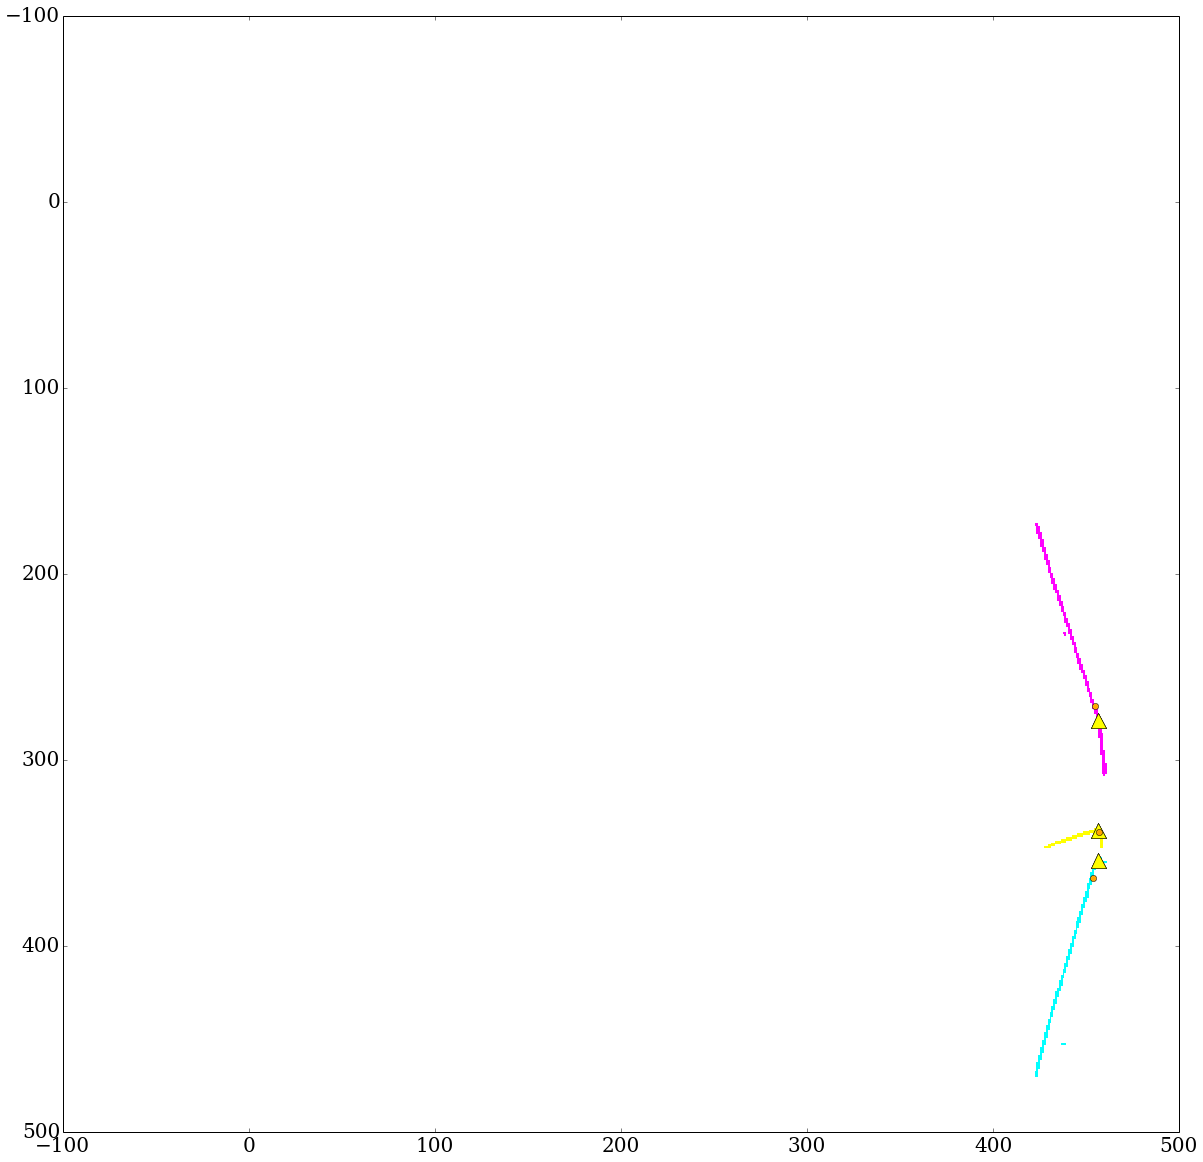

matched r/s/e  4 , 4804 , 96076 ... to  4 , 4804 , 96076
3391    0
Name: vtx3d_type, dtype: uint32


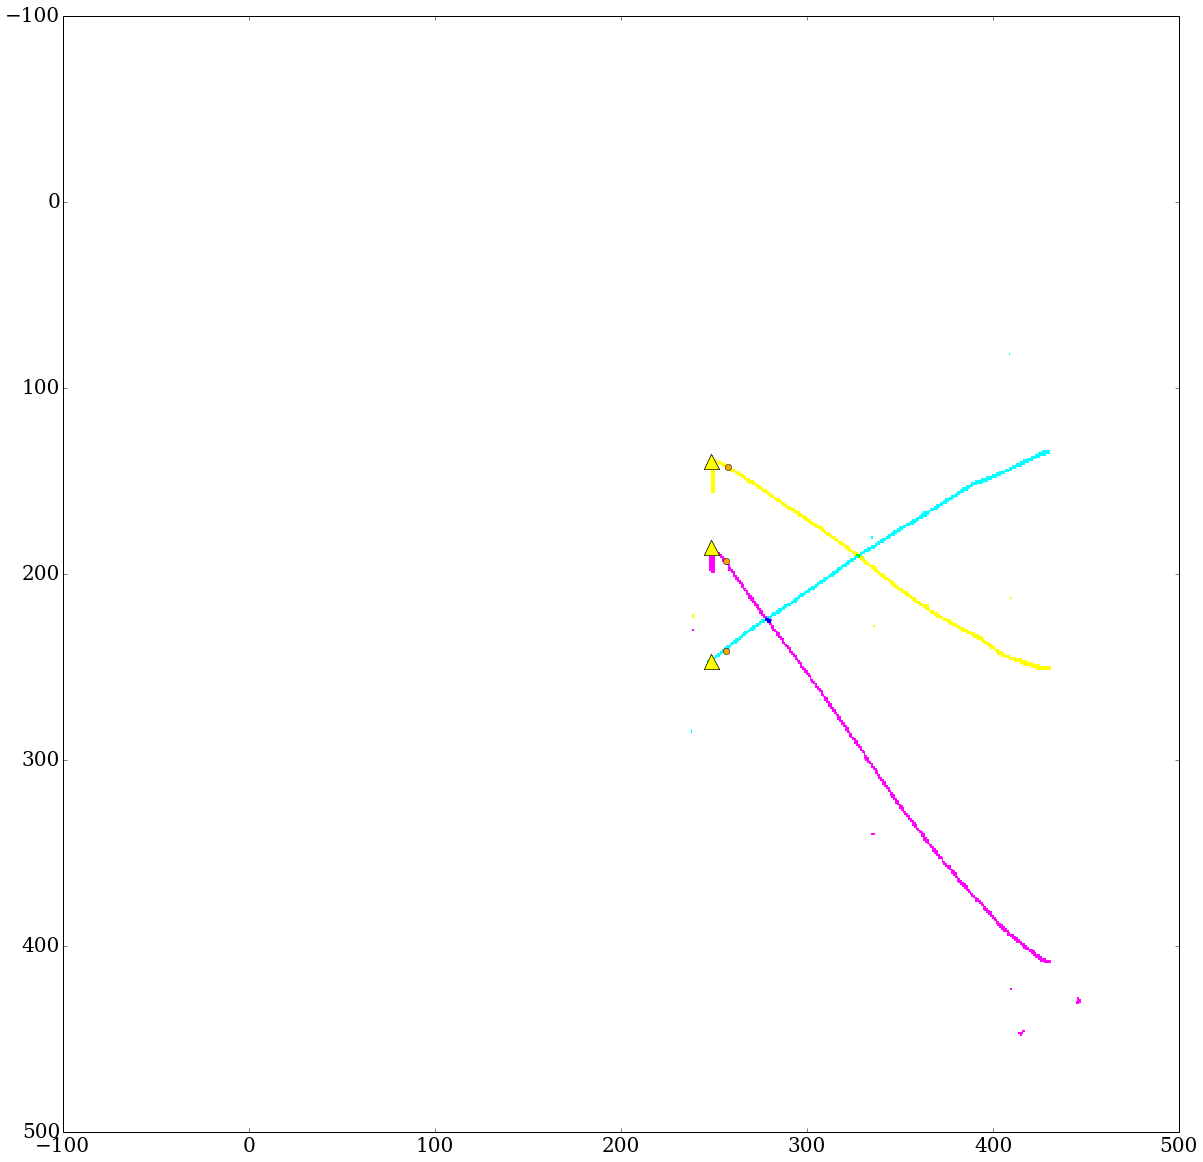

matched r/s/e  4 , 5195 , 103900 ... to  4 , 5195 , 103900


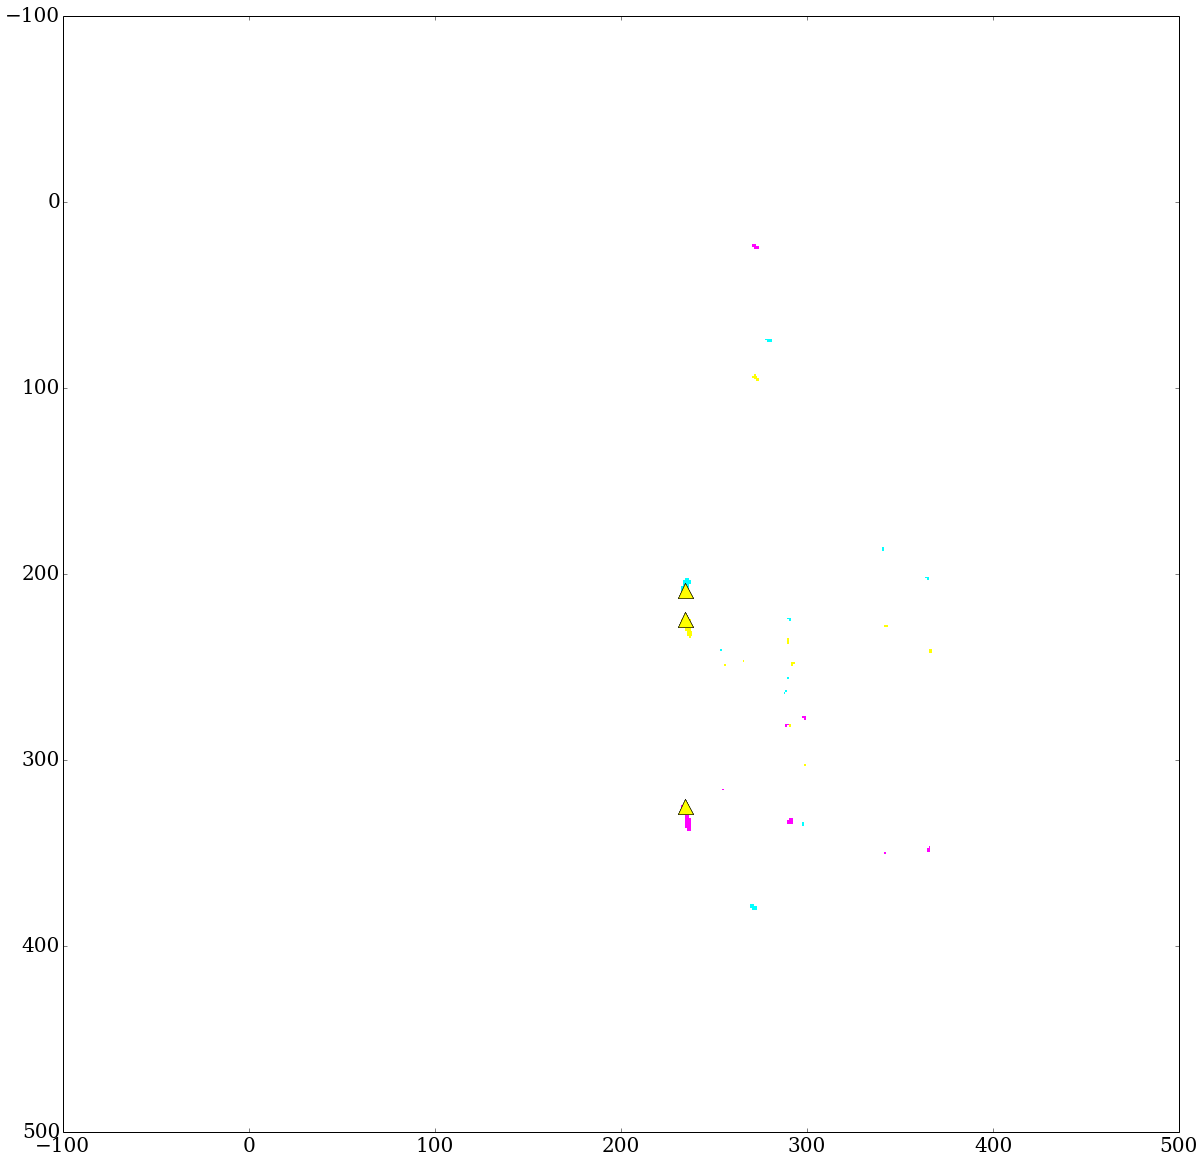

matched r/s/e  4 , 4562 , 91229 ... to  4 , 4562 , 91229


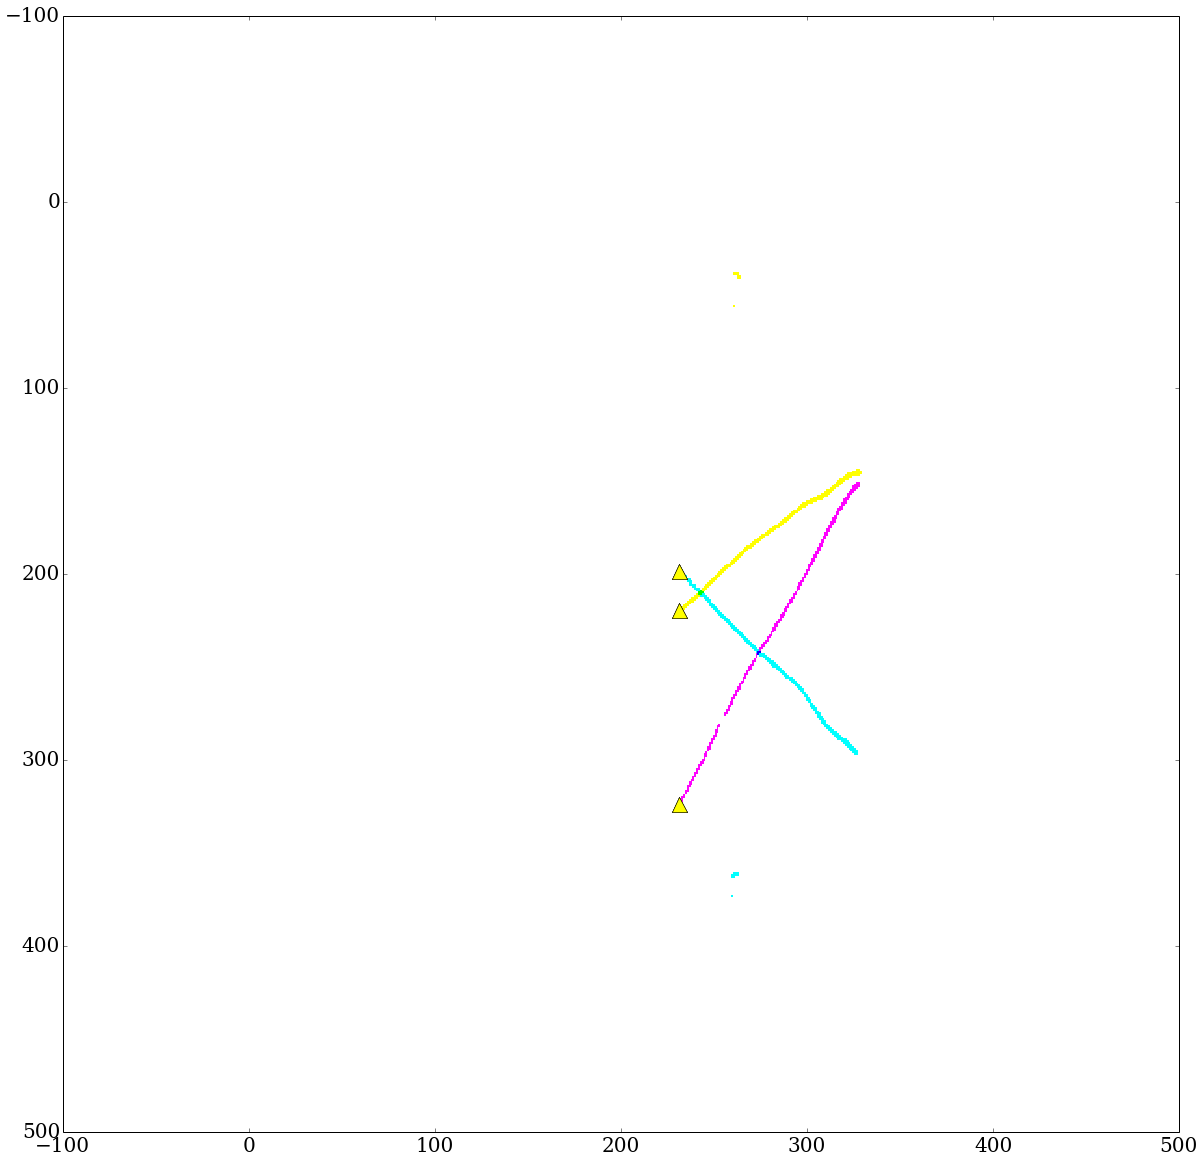

matched r/s/e  4 , 4049 , 80978 ... to  4 , 4049 , 80978


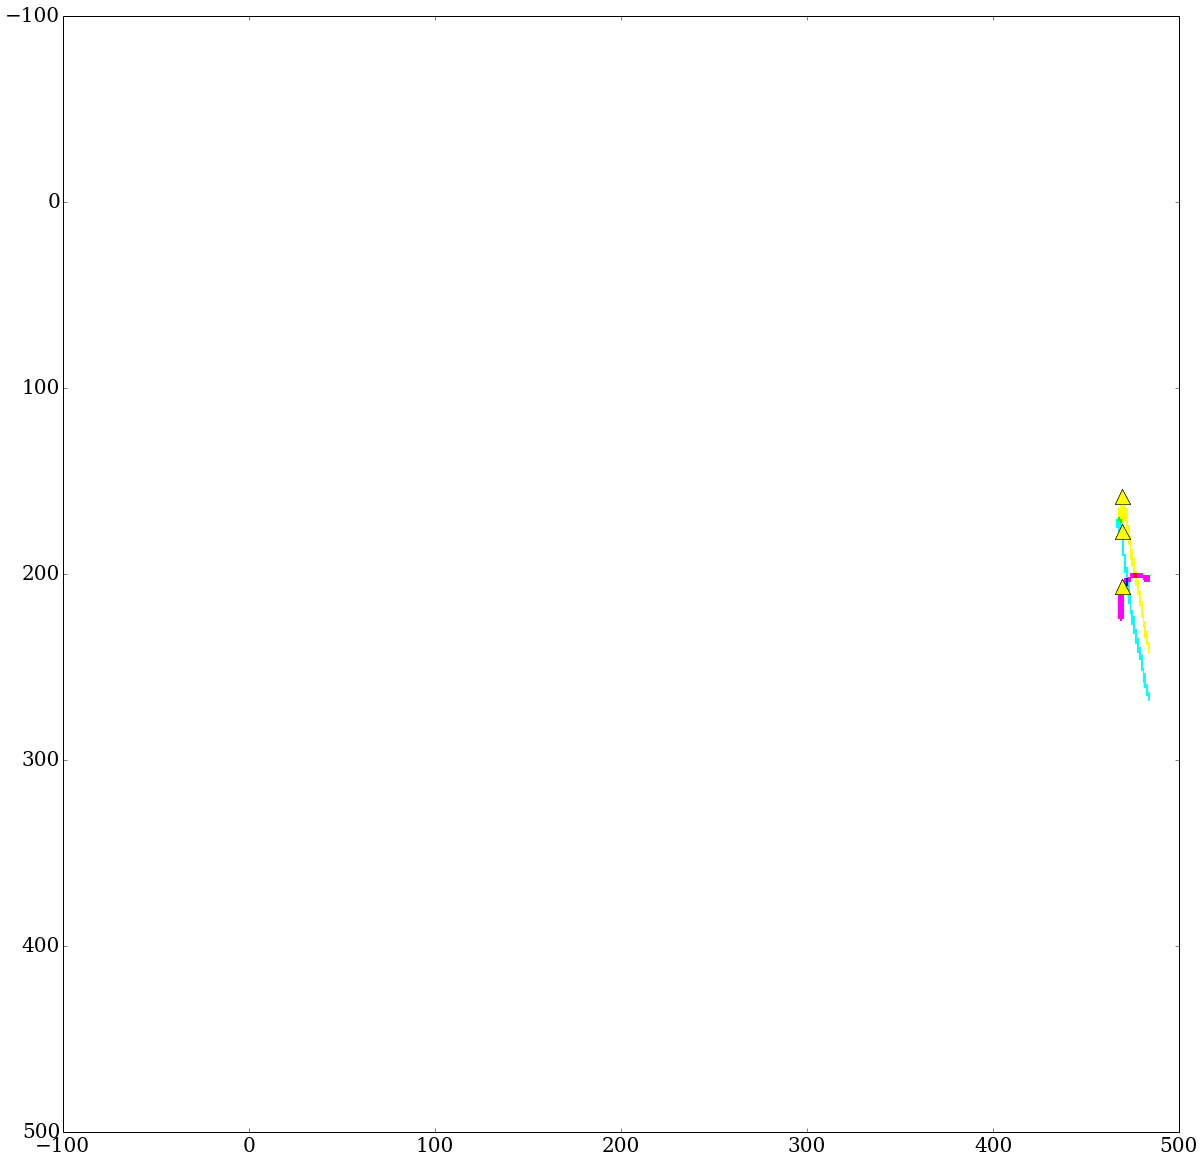

matched r/s/e  4 , 4596 , 91916 ... to  4 , 4596 , 91916


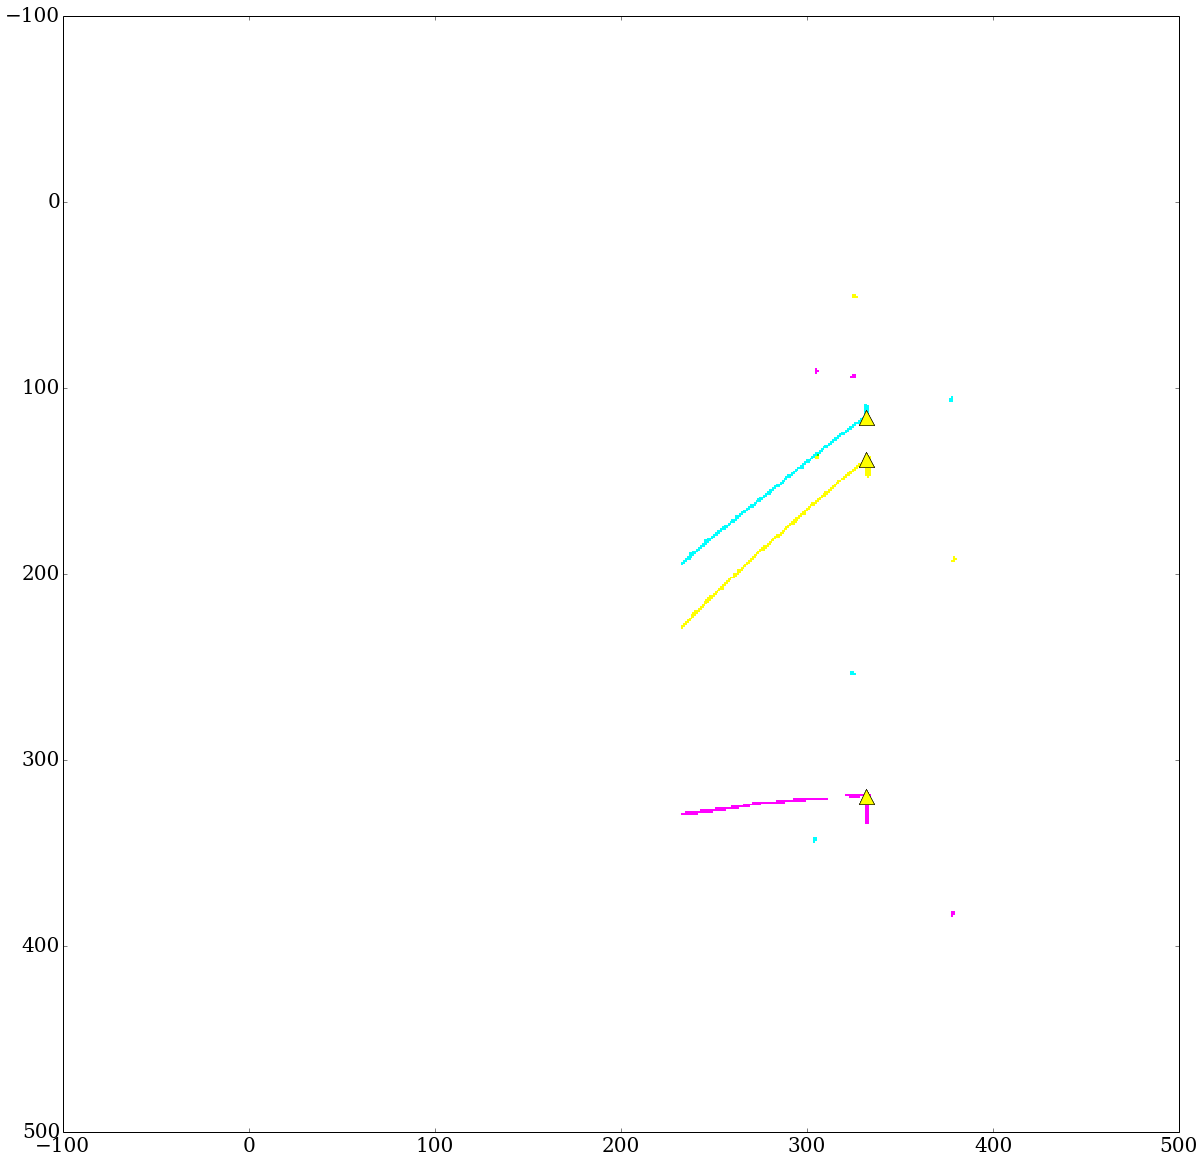

matched r/s/e  4 , 4342 , 86829 ... to  4 , 4342 , 86829
3560    0
3561    0
3562    0
3563    1
3564    1
3565    1
Name: vtx3d_type, dtype: uint32
3560    0
3561    0
3562    0
3563    1
3564    1
3565    1
Name: vtx3d_type, dtype: uint32
3560    0
3561    0
3562    0
3563    1
3564    1
3565    1
Name: vtx3d_type, dtype: uint32
3560    0
3561    0
3562    0
3563    1
3564    1
3565    1
Name: vtx3d_type, dtype: uint32
3560    0
3561    0
3562    0
3563    1
3564    1
3565    1
Name: vtx3d_type, dtype: uint32
3560    0
3561    0
3562    0
3563    1
3564    1
3565    1
Name: vtx3d_type, dtype: uint32


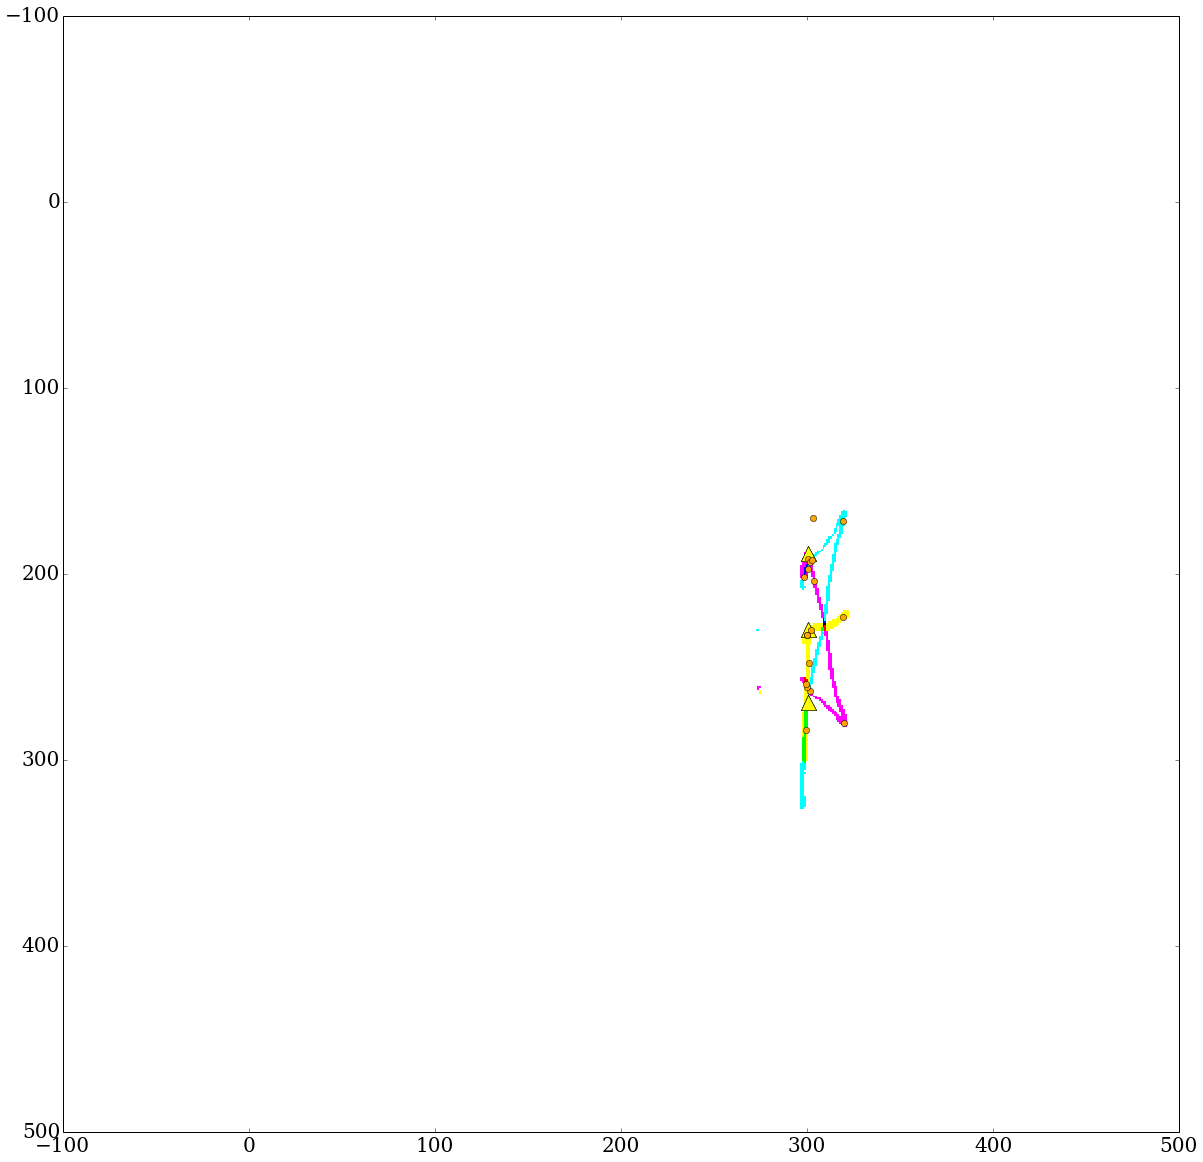

matched r/s/e  4 , 4015 , 80295 ... to  4 , 4015 , 80295


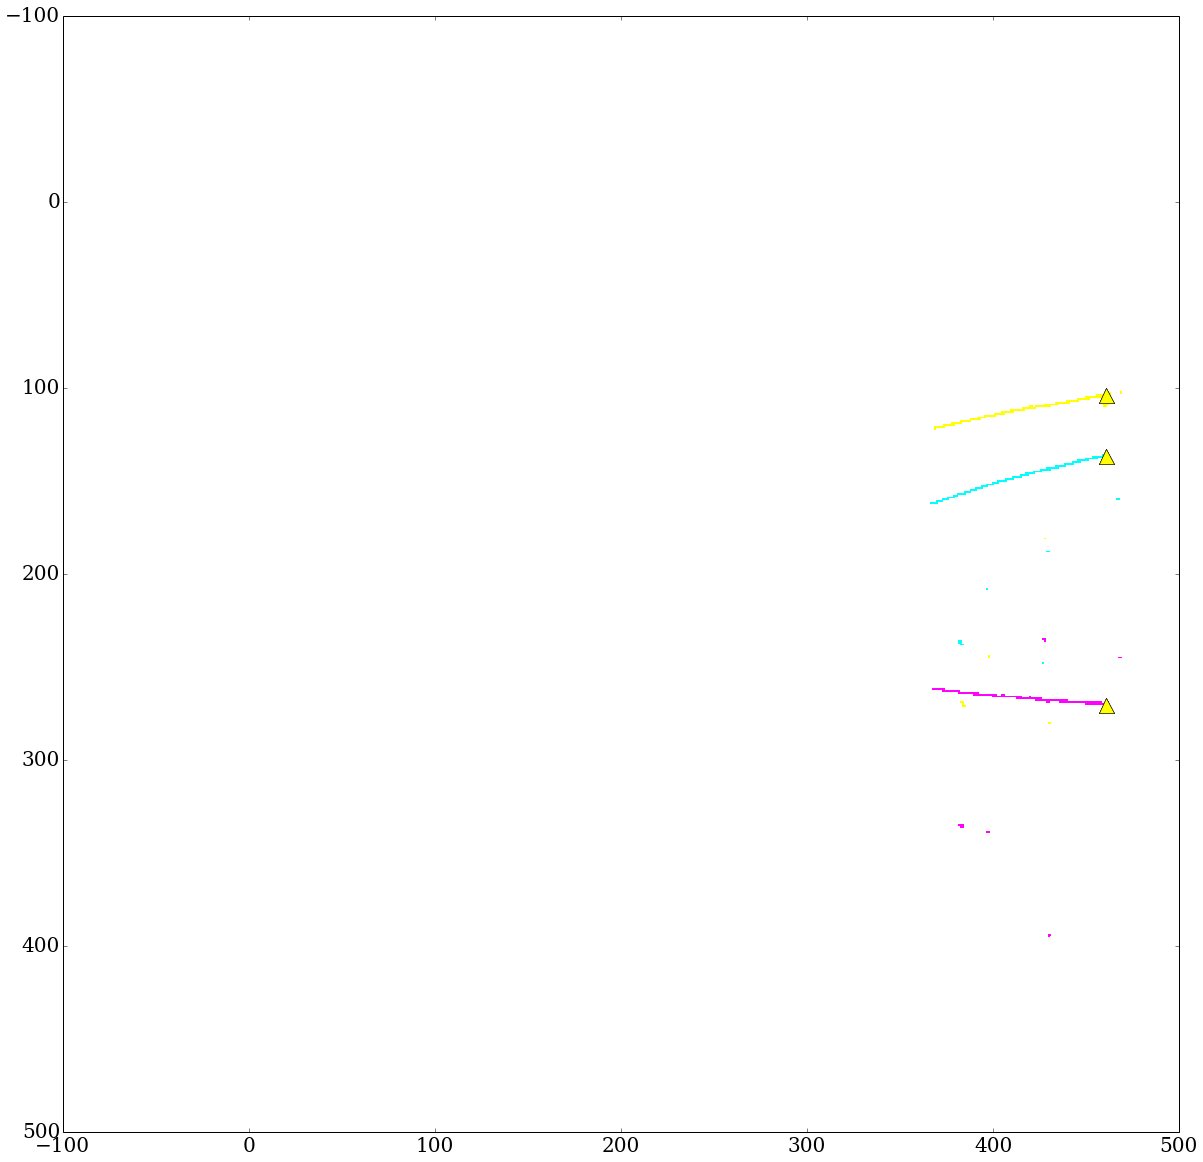

matched r/s/e  4 , 5944 , 118866 ... to  4 , 5944 , 118866
3594    0
Name: vtx3d_type, dtype: uint32


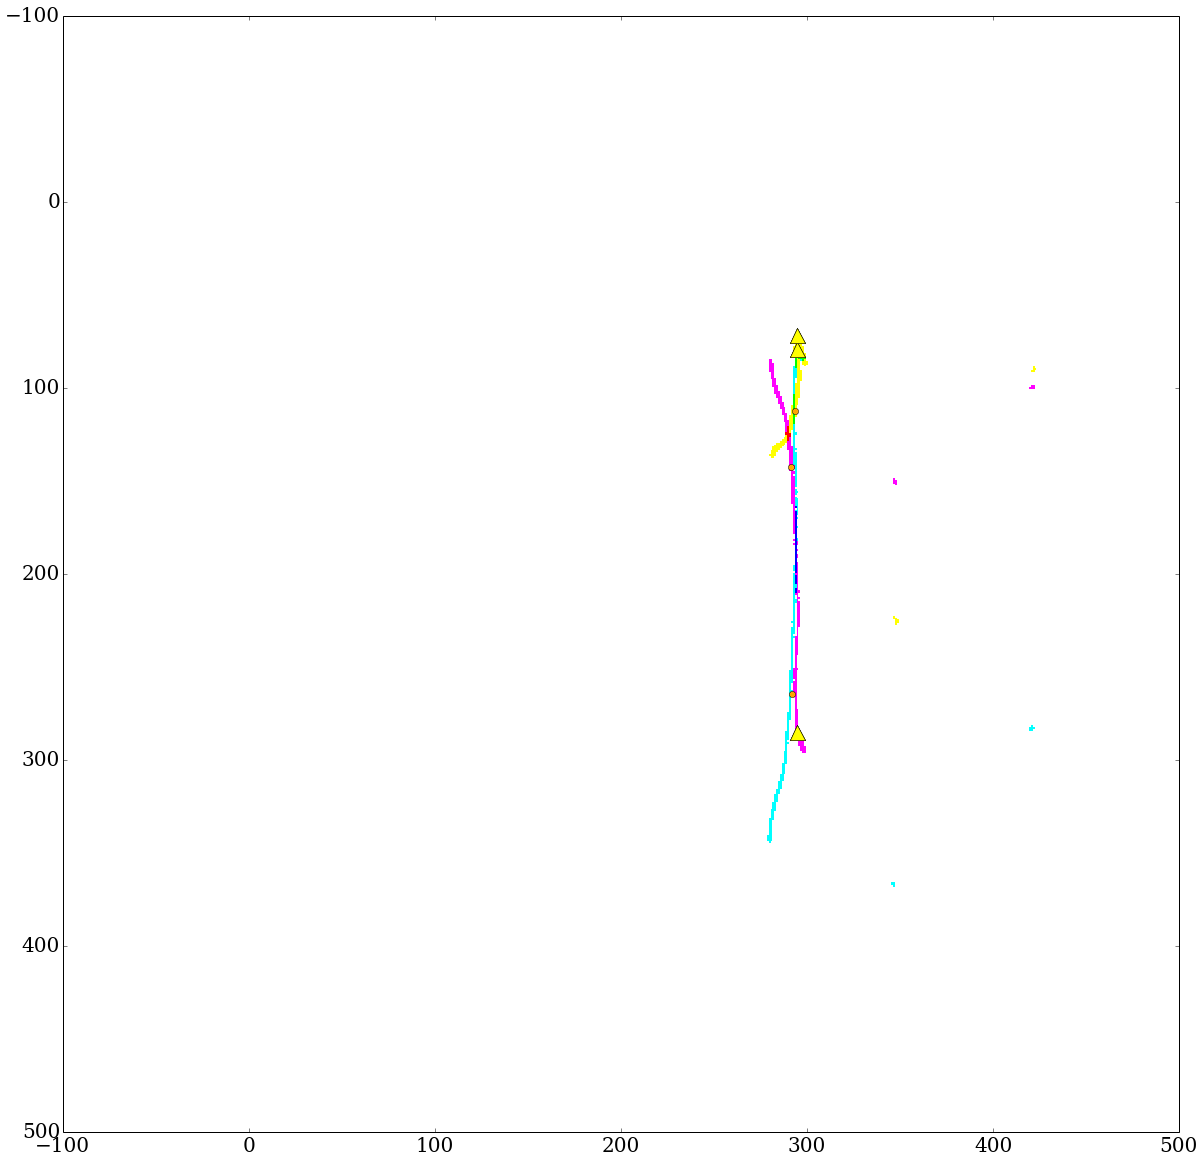

matched r/s/e  4 , 5727 , 114540 ... to  4 , 5727 , 114540
3614    0
3615    1
Name: vtx3d_type, dtype: uint32
3614    0
3615    1
Name: vtx3d_type, dtype: uint32


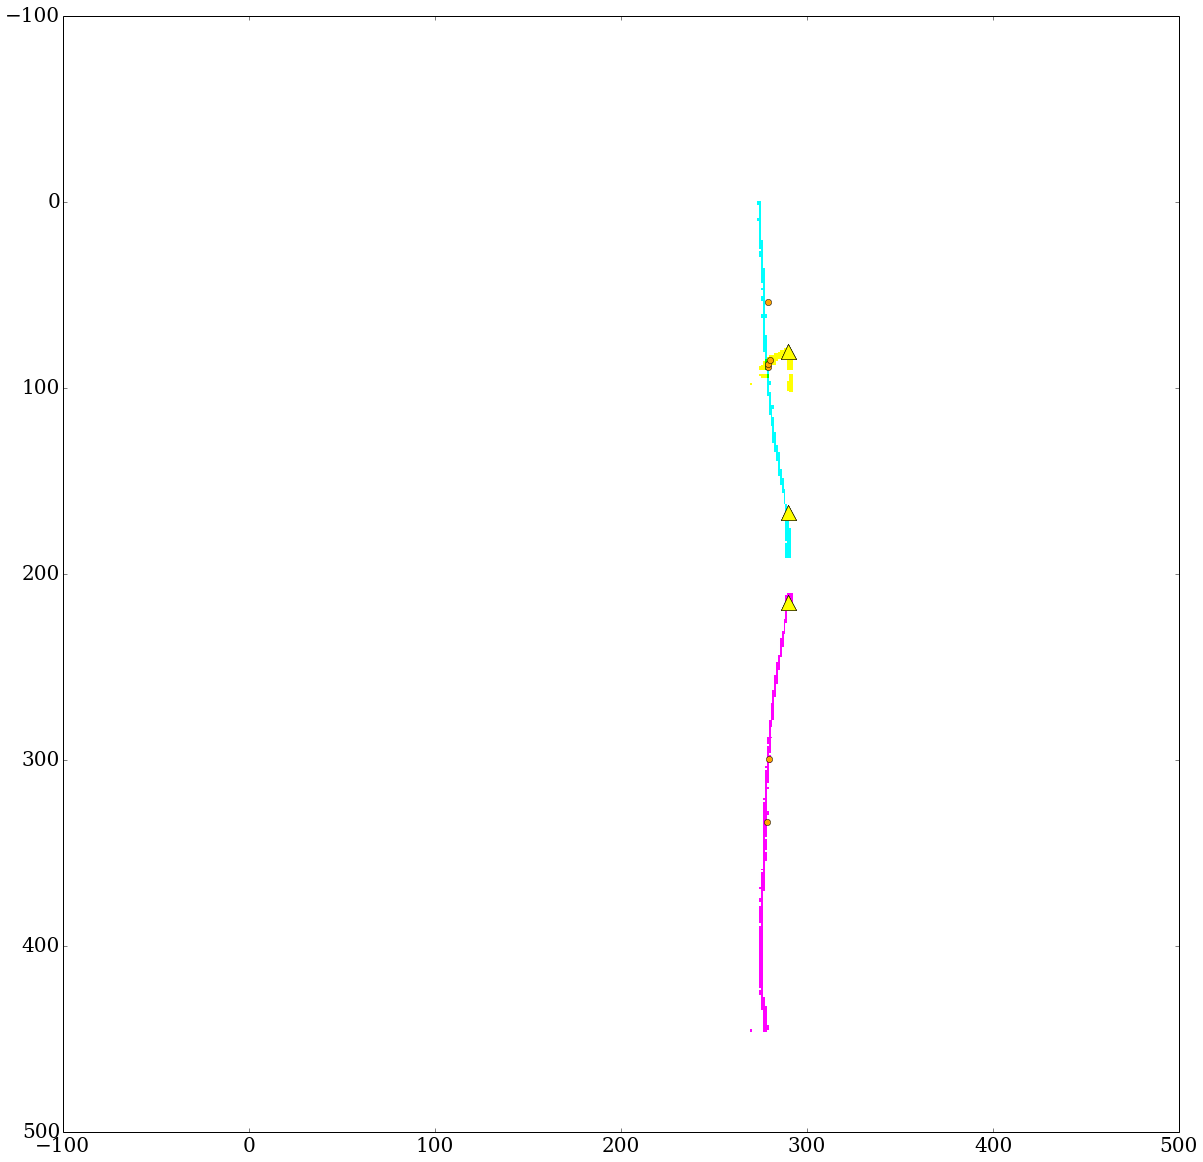

matched r/s/e  4 , 5398 , 107943 ... to  4 , 5398 , 107943


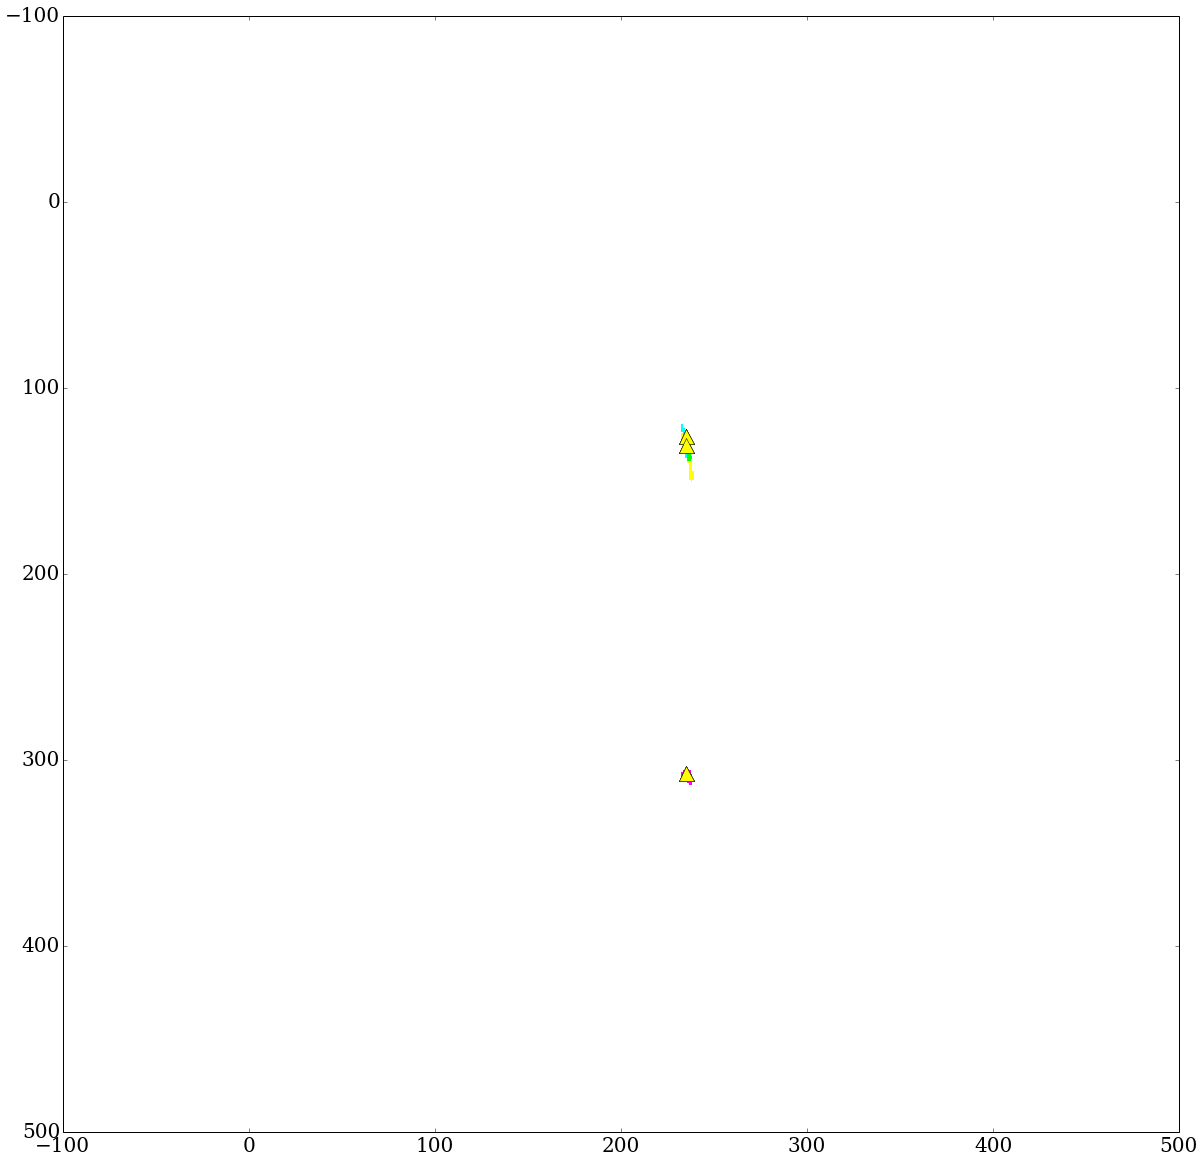

matched r/s/e  4 , 5530 , 110584 ... to  4 , 5530 , 110584


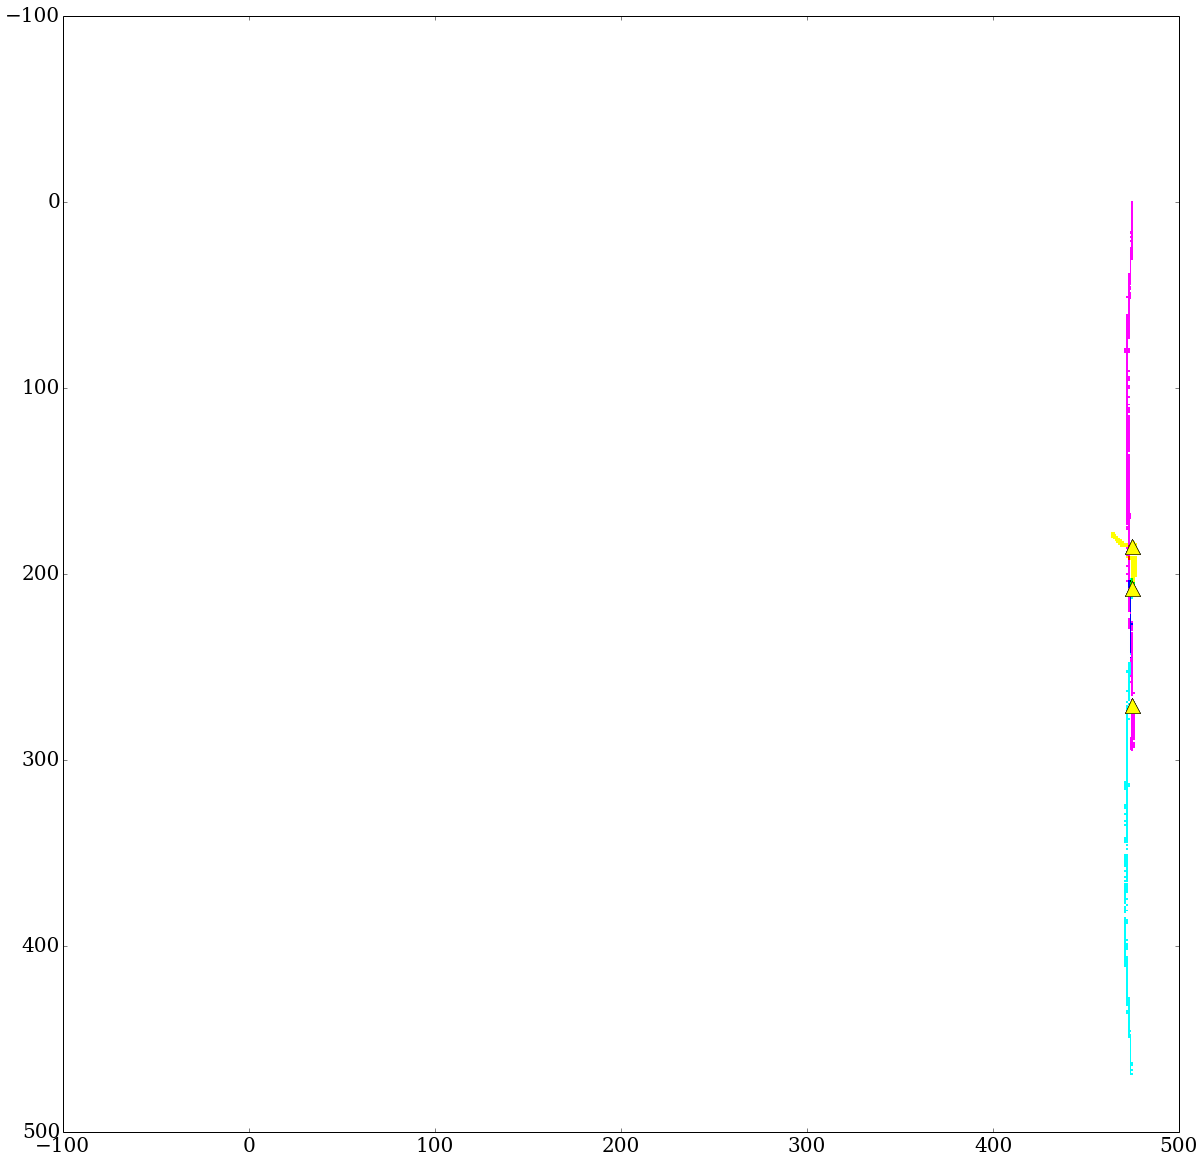

matched r/s/e  4 , 4066 , 81304 ... to  4 , 4066 , 81304
3810    0
3811    0
3812    1
Name: vtx3d_type, dtype: uint32
3810    0
3811    0
3812    1
Name: vtx3d_type, dtype: uint32
3810    0
3811    0
3812    1
Name: vtx3d_type, dtype: uint32


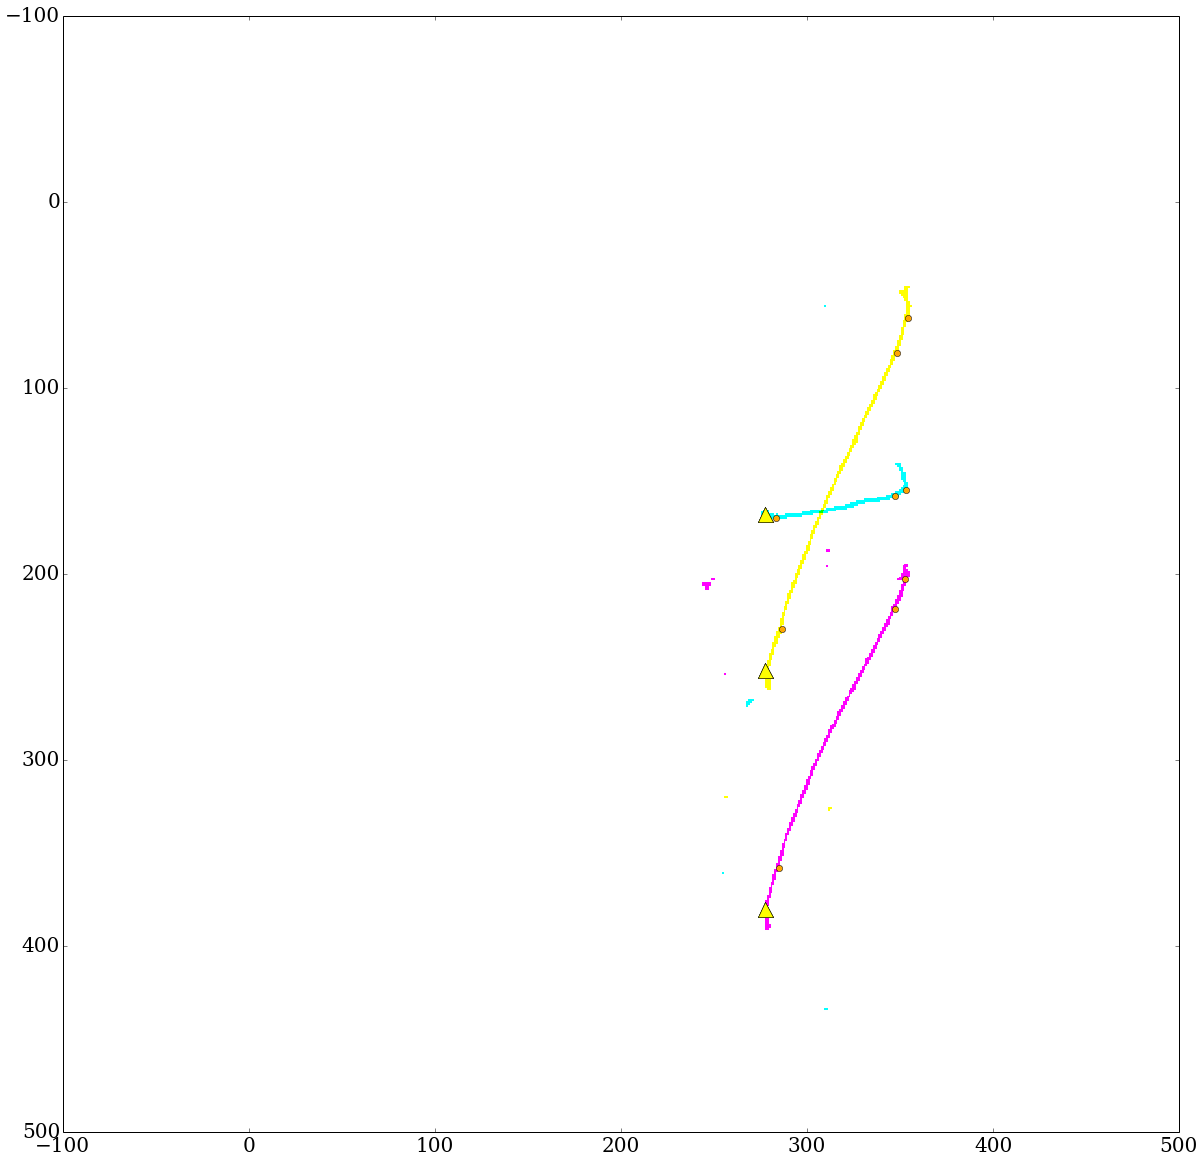

matched r/s/e  4 , 4759 , 95169 ... to  4 , 4759 , 95169
3865    0
3866    0
3867    0
3868    0
3869    1
Name: vtx3d_type, dtype: uint32
3865    0
3866    0
3867    0
3868    0
3869    1
Name: vtx3d_type, dtype: uint32
3865    0
3866    0
3867    0
3868    0
3869    1
Name: vtx3d_type, dtype: uint32
3865    0
3866    0
3867    0
3868    0
3869    1
Name: vtx3d_type, dtype: uint32
3865    0
3866    0
3867    0
3868    0
3869    1
Name: vtx3d_type, dtype: uint32


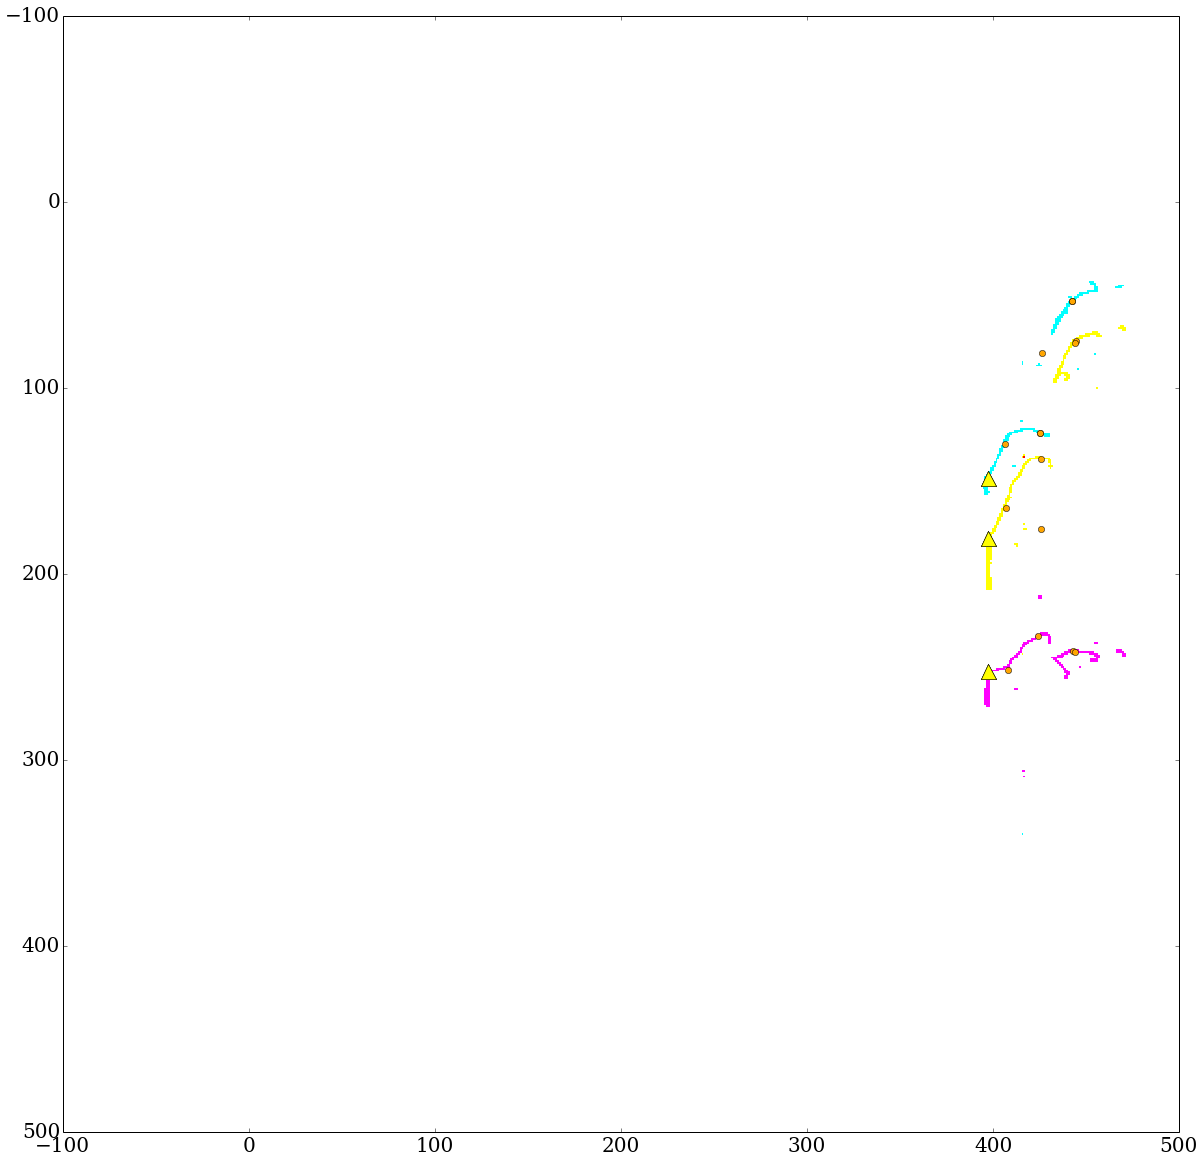

matched r/s/e  4 , 5477 , 109526 ... to  4 , 5477 , 109526


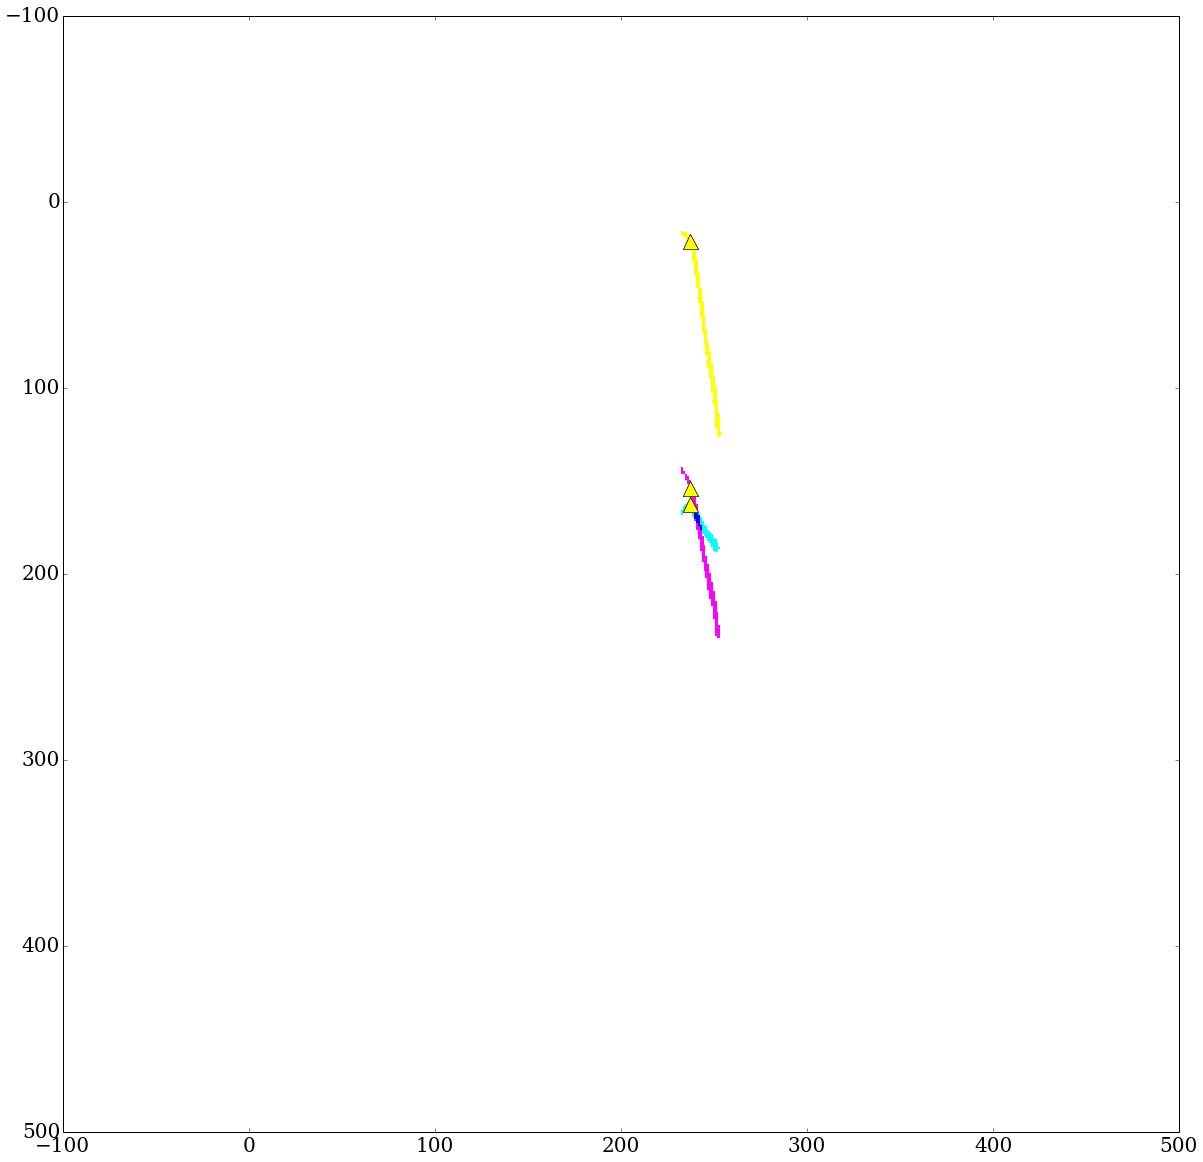

matched r/s/e  4 , 5062 , 101229 ... to  4 , 5062 , 101229


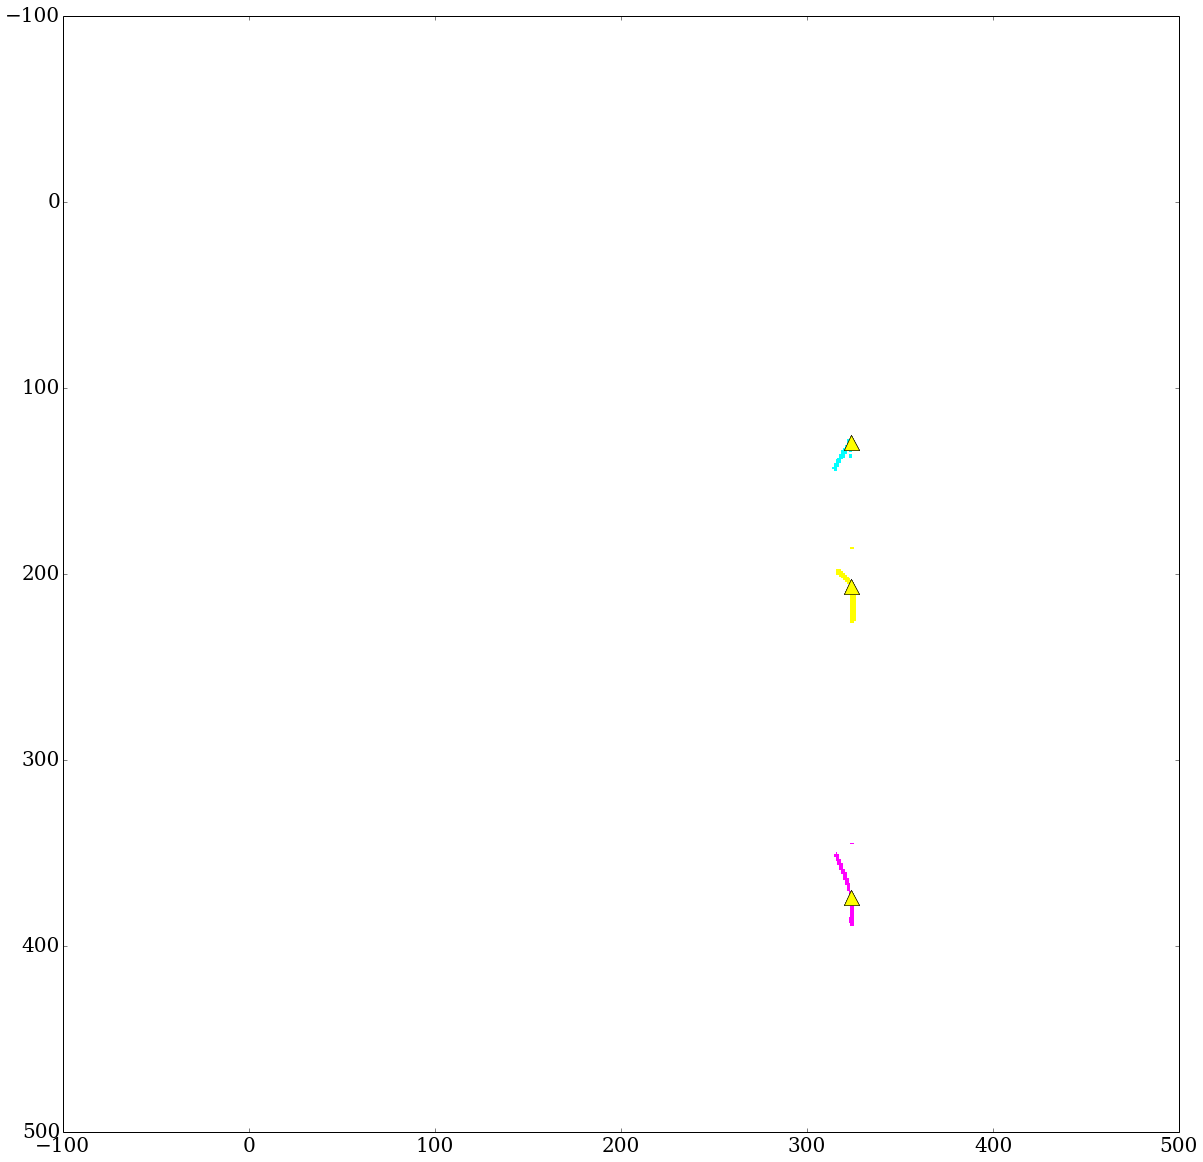

matched r/s/e  4 , 5737 , 114726 ... to  4 , 5737 , 114726
3894    0
3895    0
Name: vtx3d_type, dtype: uint32
3894    0
3895    0
Name: vtx3d_type, dtype: uint32


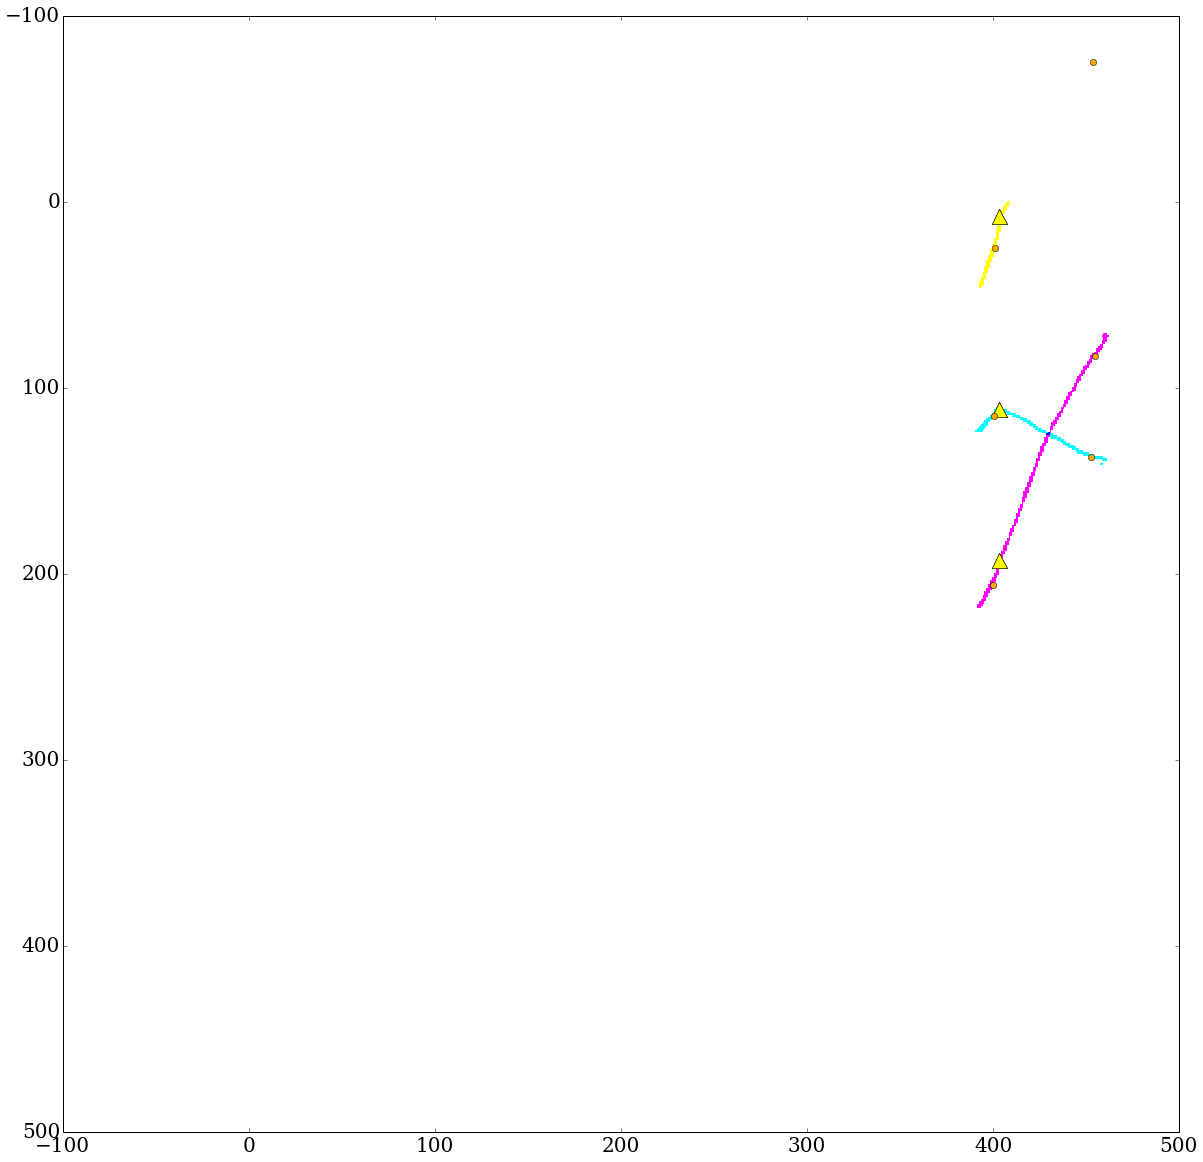

matched r/s/e  4 , 4214 , 84277 ... to  4 , 4214 , 84277


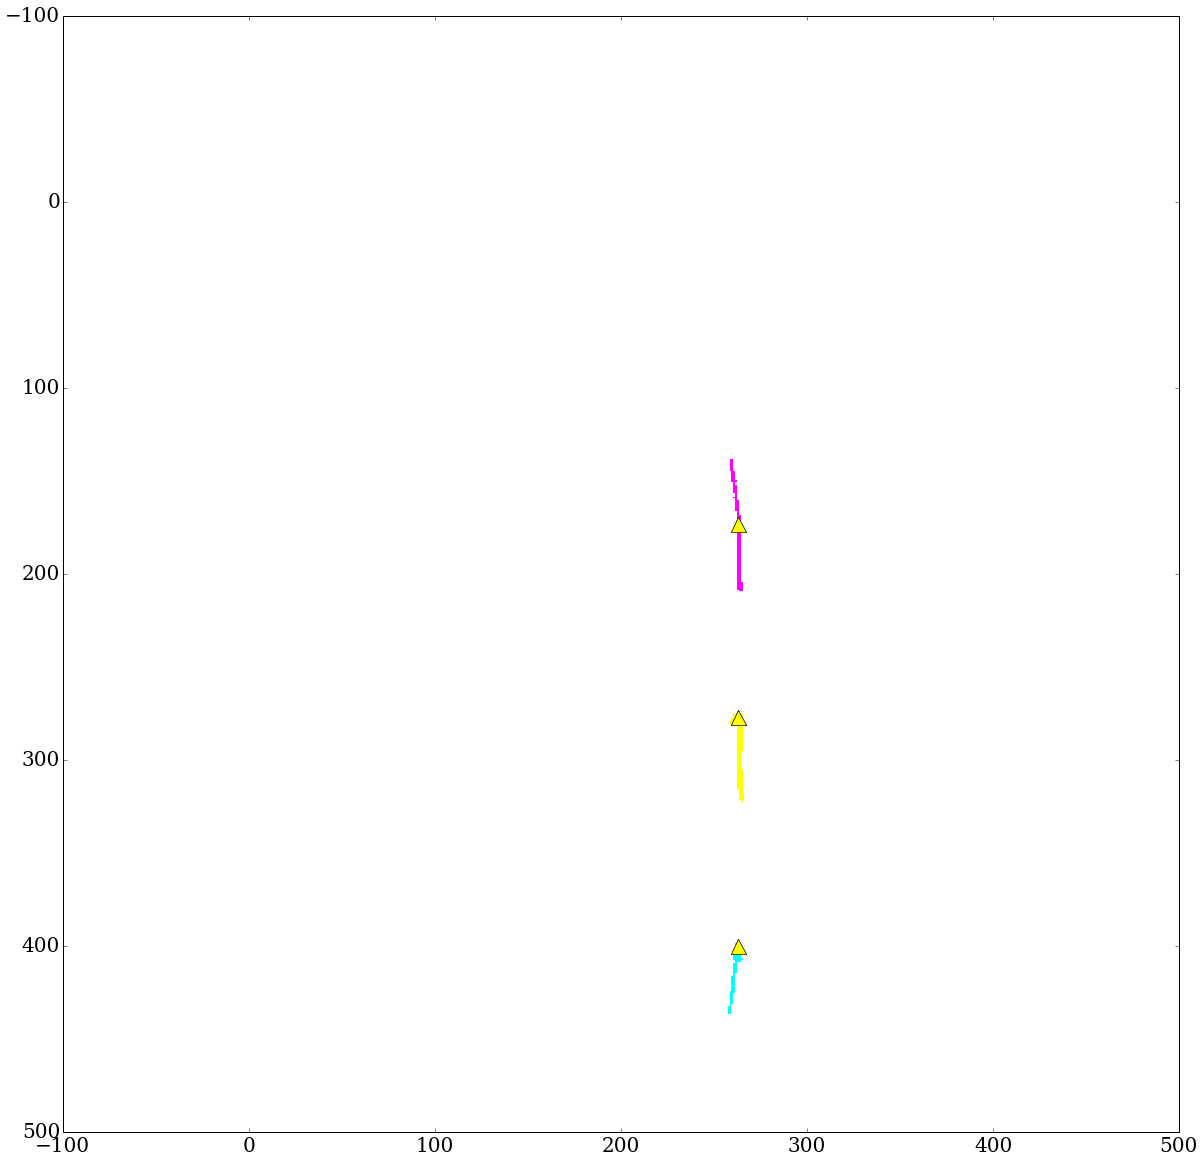

matched r/s/e  4 , 9409 , 188175 ... to  4 , 9409 , 188175
4122    0
Name: vtx3d_type, dtype: uint32


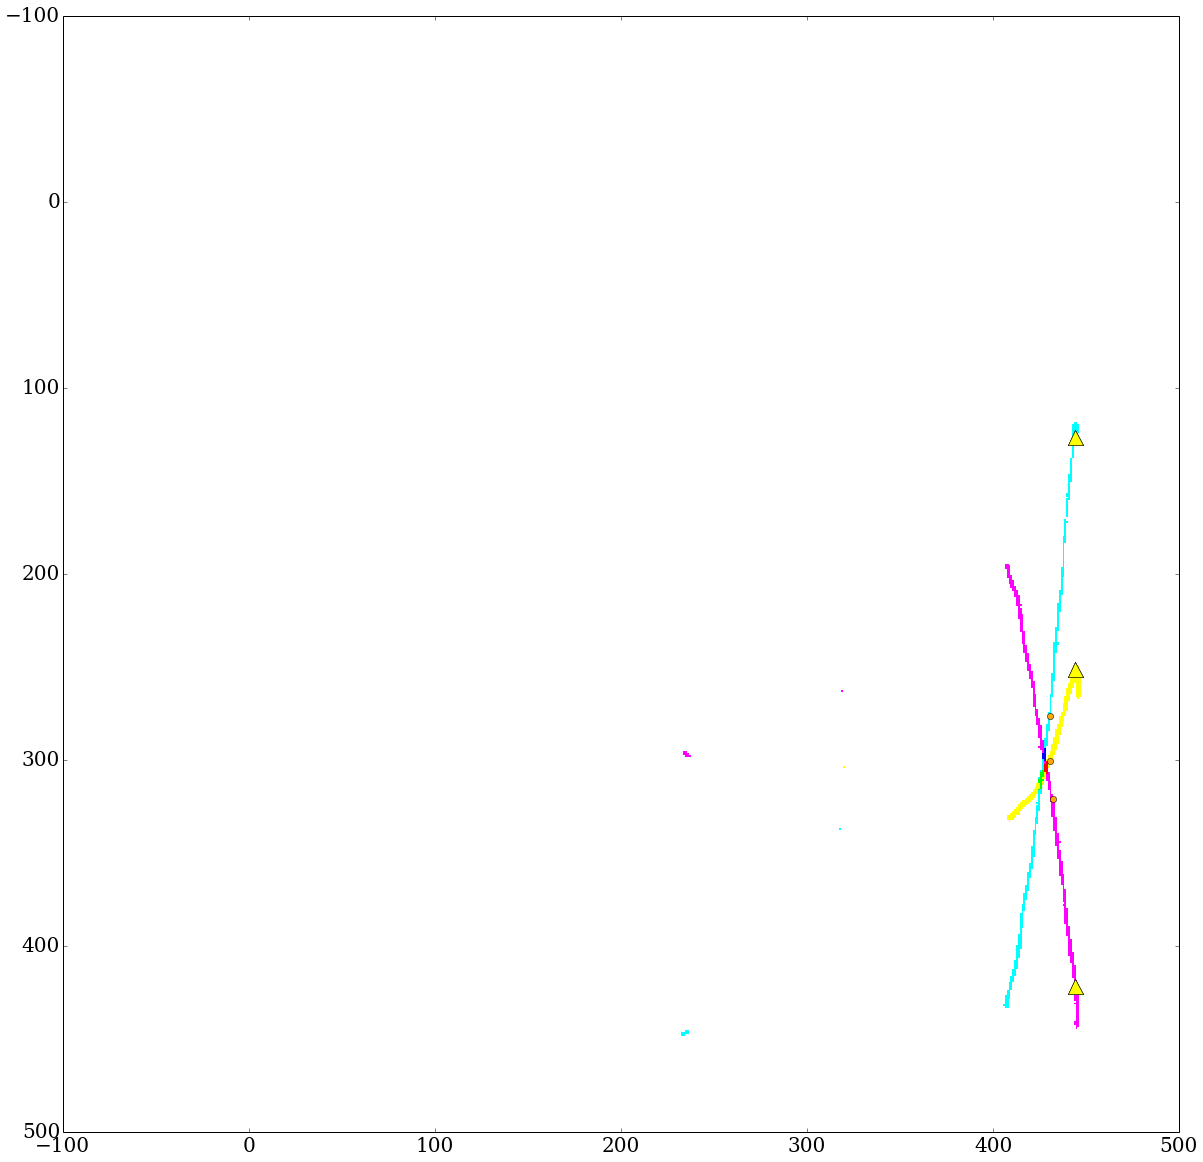

matched r/s/e  4 , 9548 , 190952 ... to  4 , 9548 , 190952


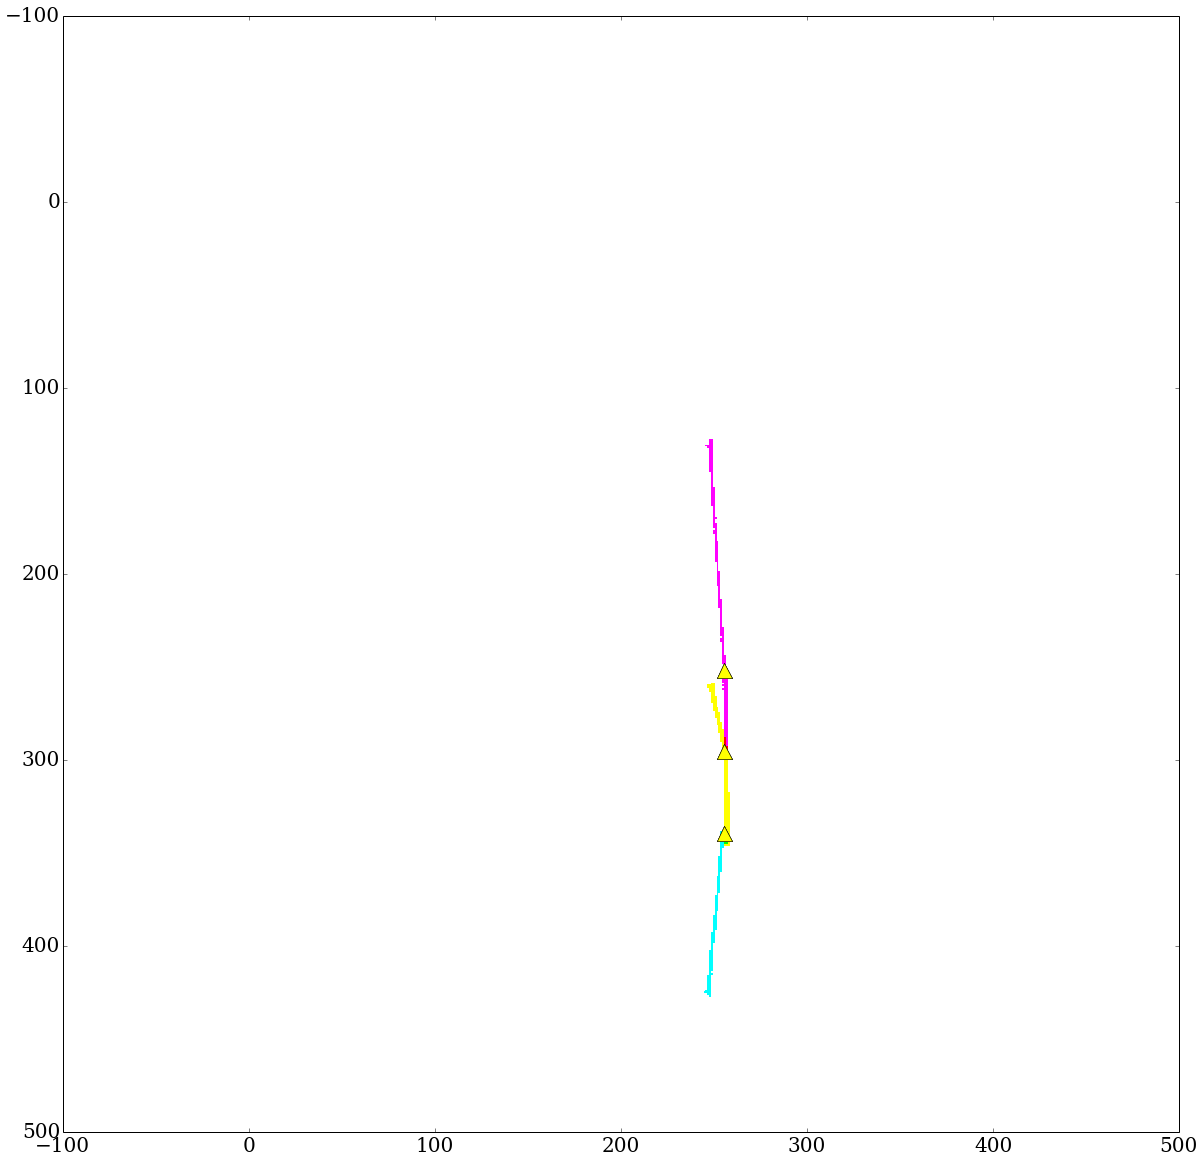

matched r/s/e  4 , 9200 , 184000 ... to  4 , 9200 , 184000
4215    0
Name: vtx3d_type, dtype: uint32


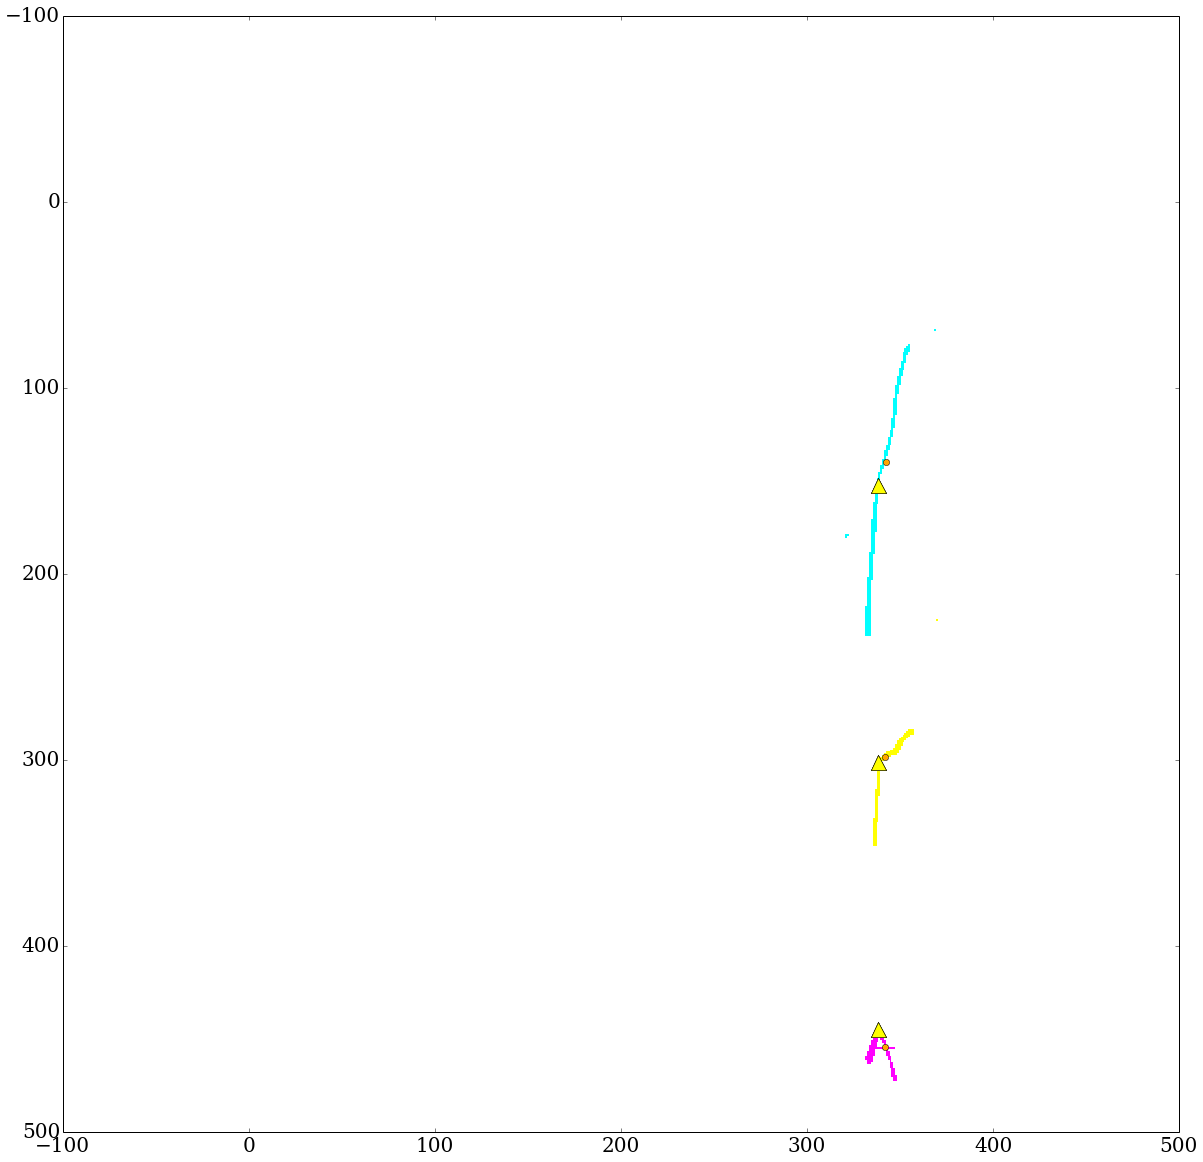

matched r/s/e  4 , 6136 , 122716 ... to  4 , 6136 , 122716


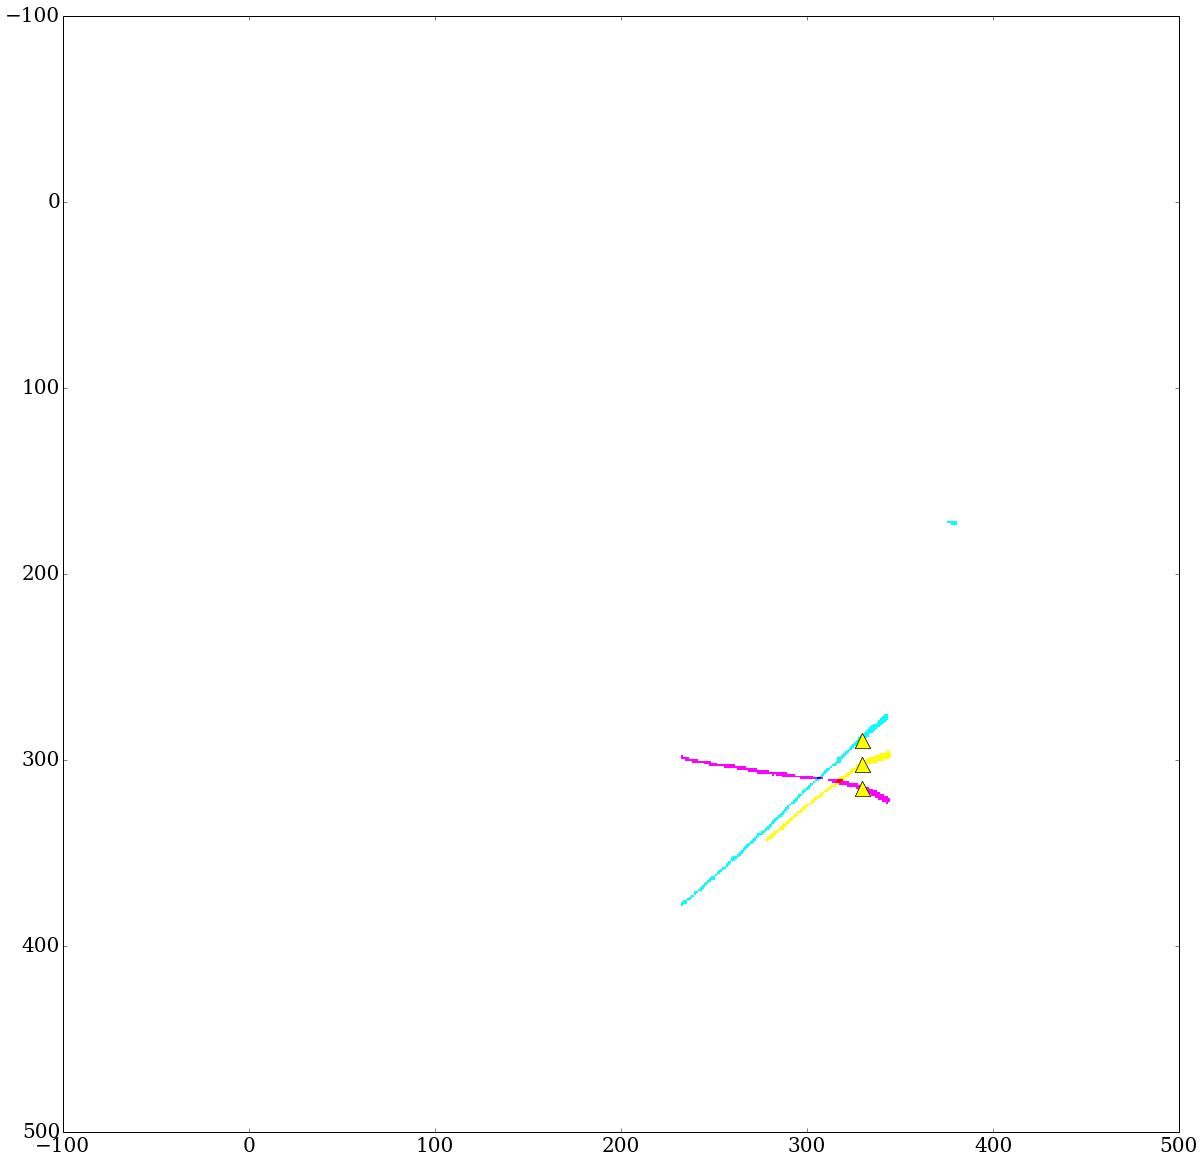

matched r/s/e  4 , 9342 , 186834 ... to  4 , 9342 , 186834
4267    0
4268    1
Name: vtx3d_type, dtype: uint32
4267    0
4268    1
Name: vtx3d_type, dtype: uint32


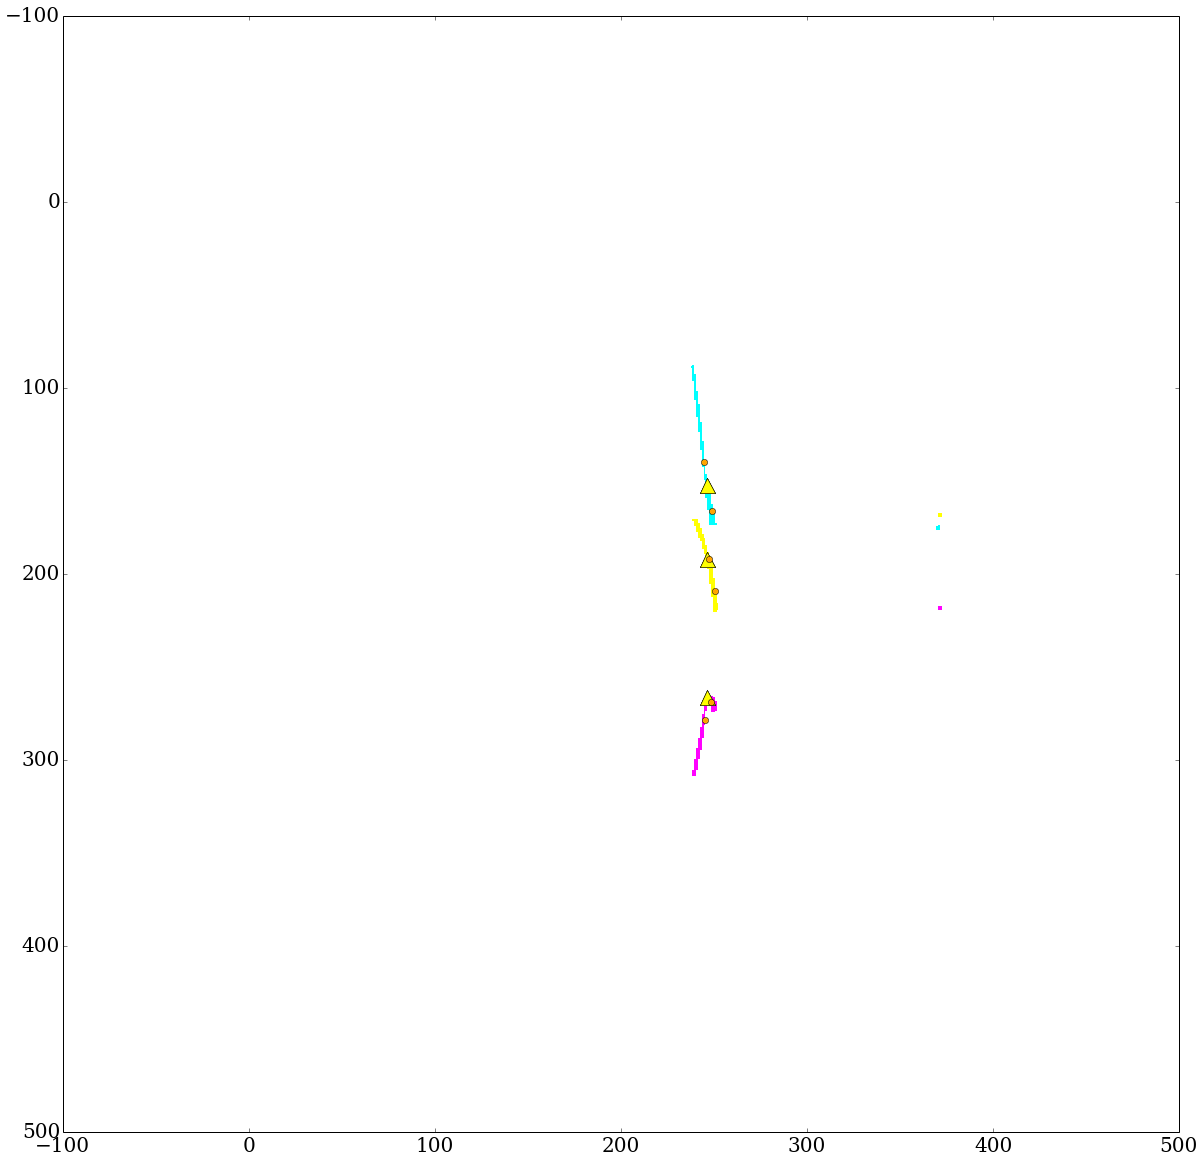

matched r/s/e  4 , 9521 , 190403 ... to  4 , 9521 , 190403
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32
4292    0
4293    0
4294    0
4295    0
4296    0
4297    1
4298    1
4299    1
Name: vtx3d_type, dtype: uint32


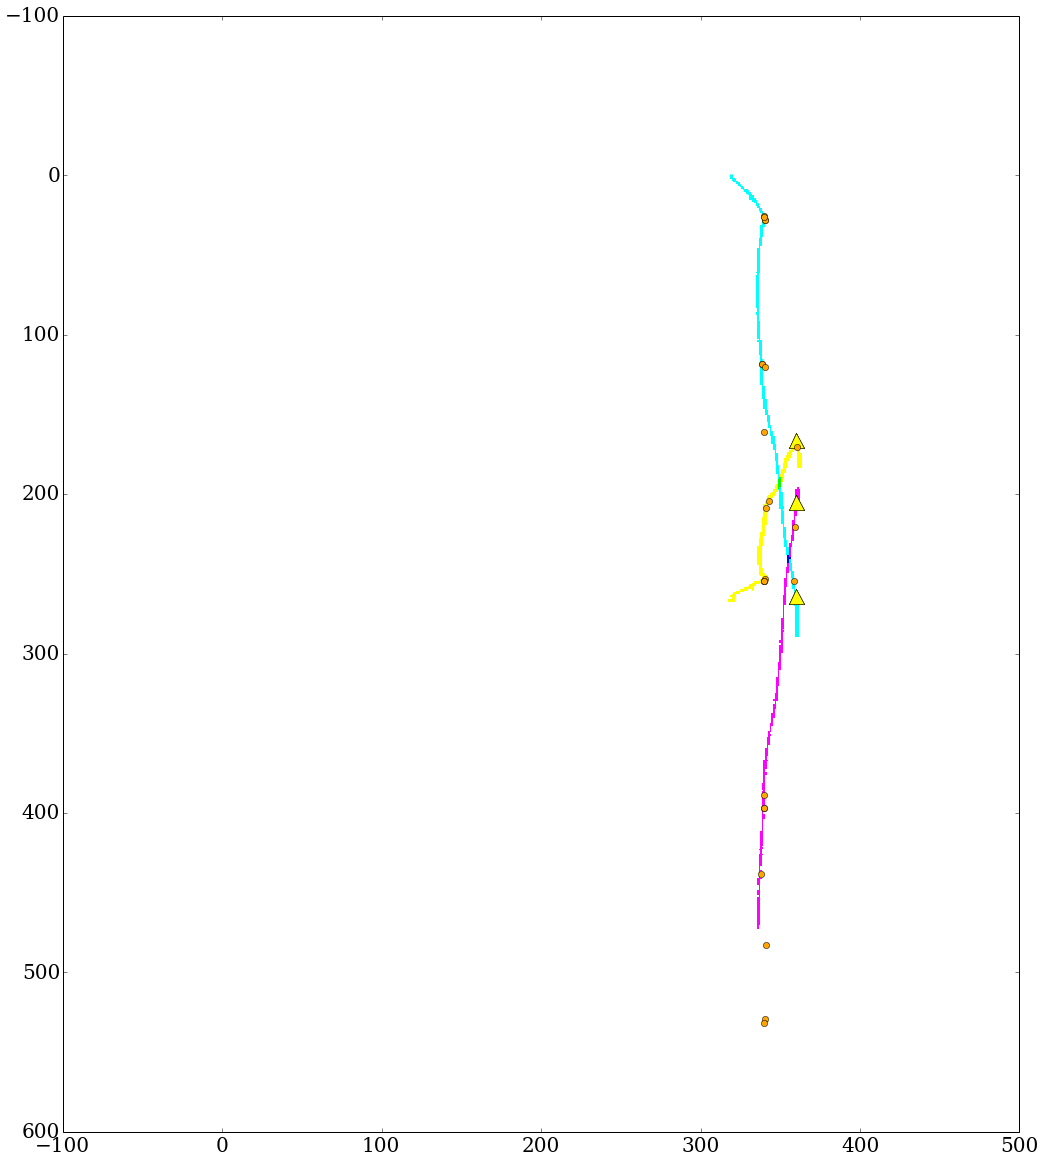

matched r/s/e  4 , 9688 , 193751 ... to  4 , 9688 , 193751
4413    0
4414    0
Name: vtx3d_type, dtype: uint32
4413    0
4414    0
Name: vtx3d_type, dtype: uint32


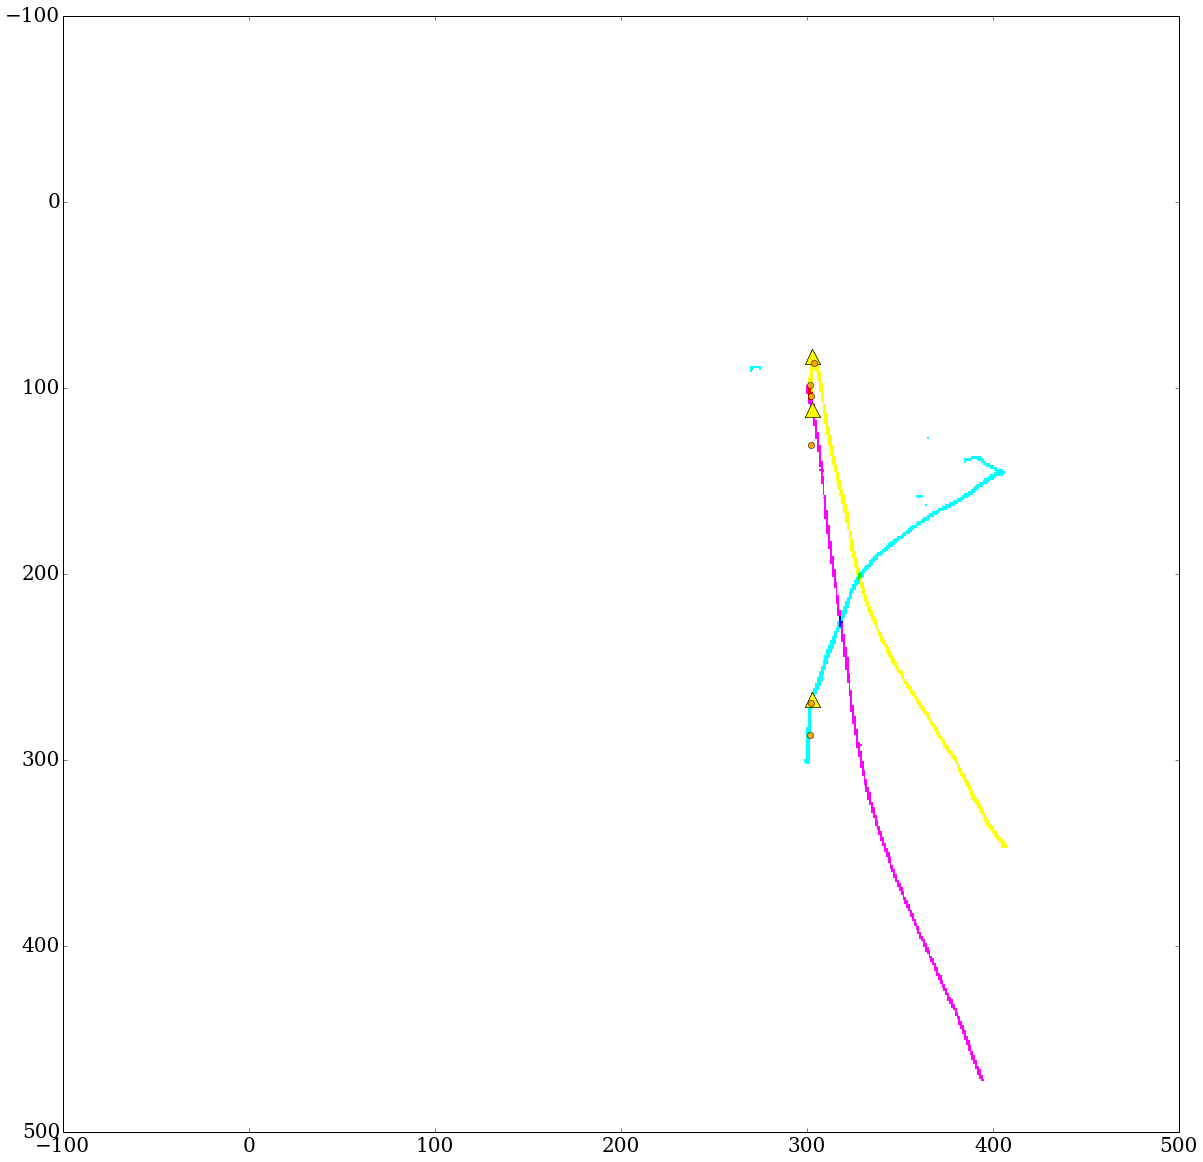

matched r/s/e  4 , 9371 , 187420 ... to  4 , 9371 , 187420
4454    0
4455    0
4456    1
Name: vtx3d_type, dtype: uint32
4454    0
4455    0
4456    1
Name: vtx3d_type, dtype: uint32
4454    0
4455    0
4456    1
Name: vtx3d_type, dtype: uint32


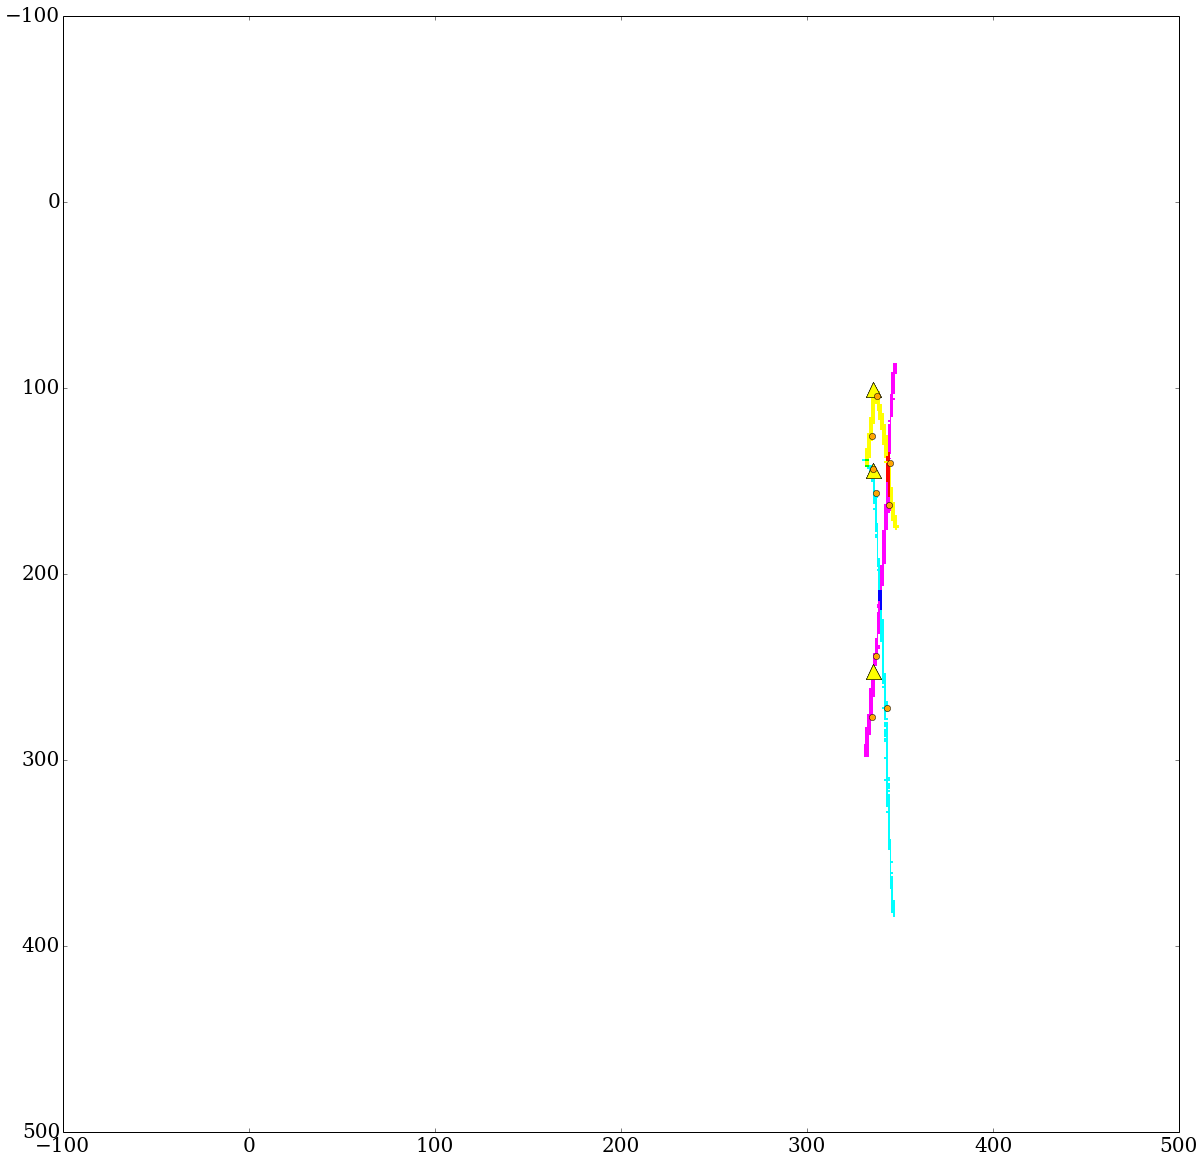

matched r/s/e  4 , 9332 , 186627 ... to  4 , 9332 , 186627


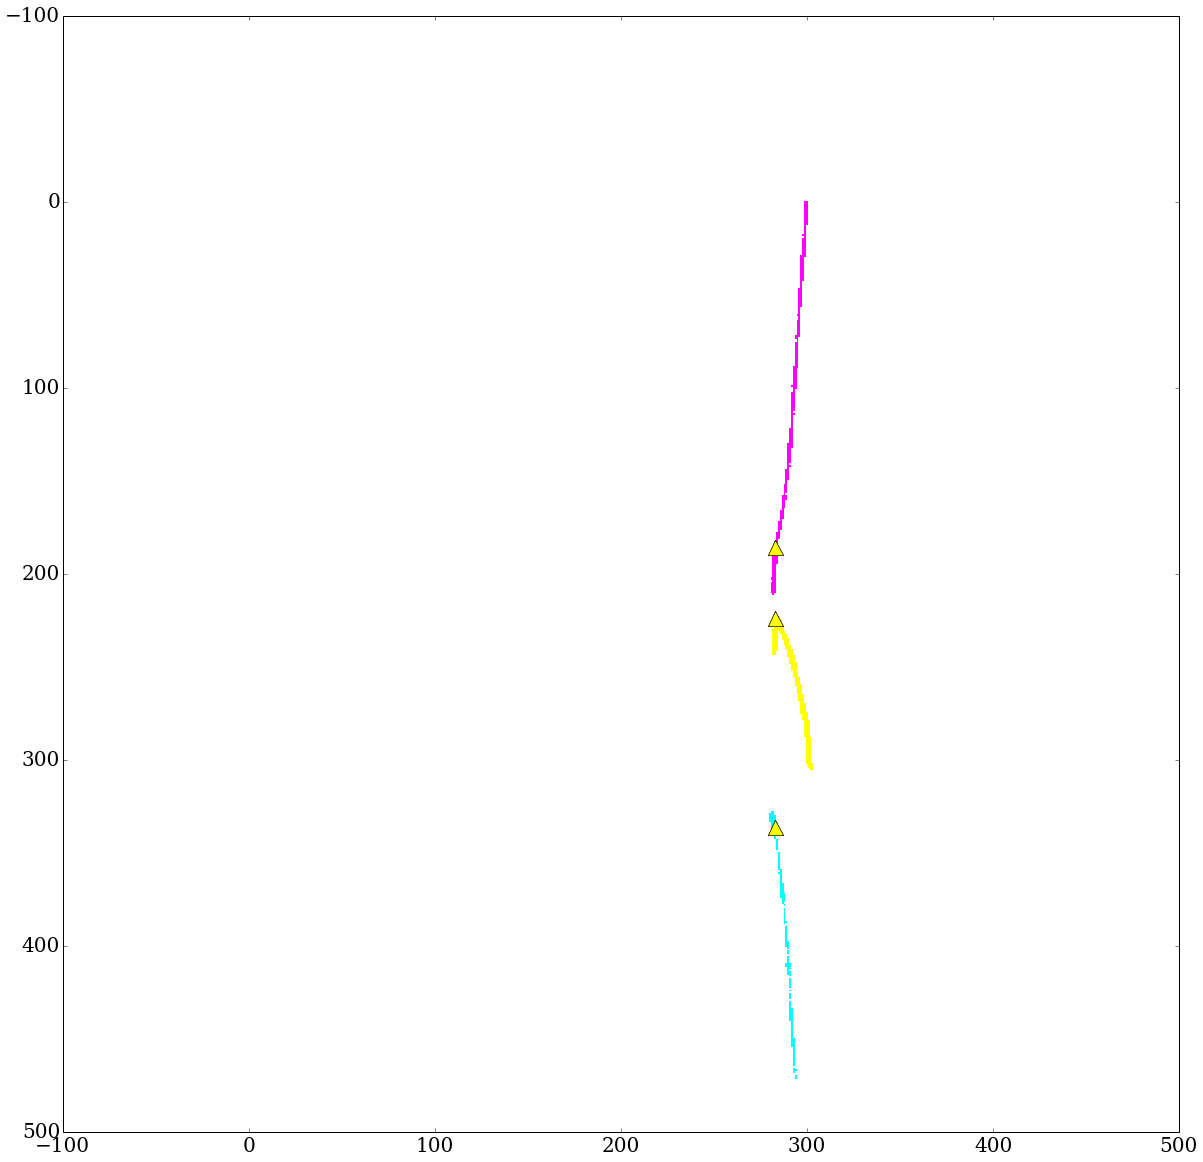

matched r/s/e  4 , 8775 , 175496 ... to  4 , 8775 , 175496


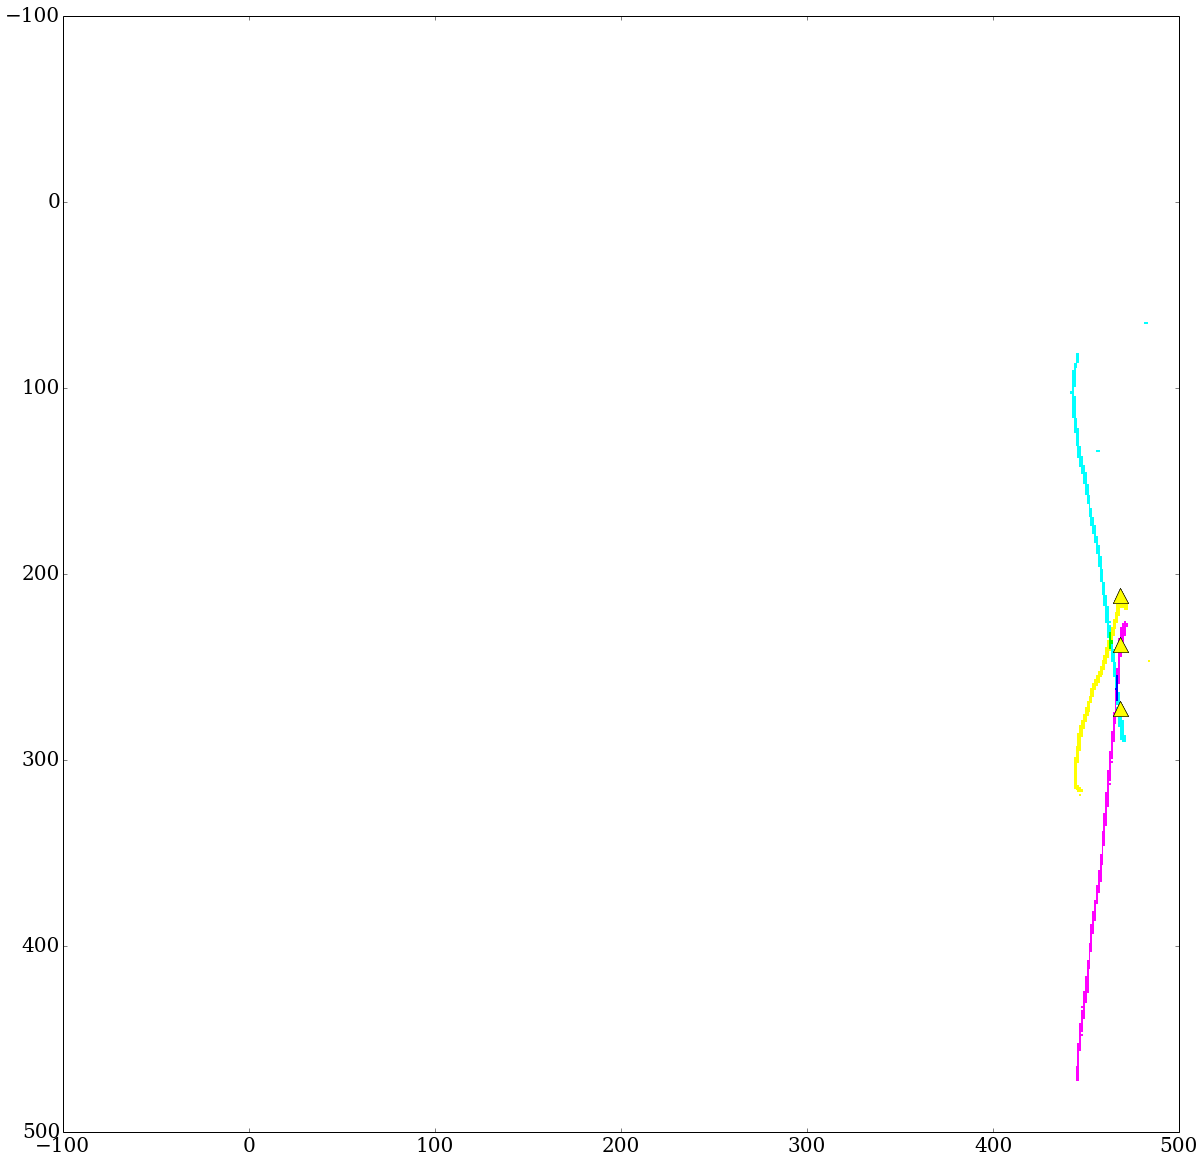

matched r/s/e  4 , 9228 , 184559 ... to  4 , 9228 , 184559
4604    0
Name: vtx3d_type, dtype: uint32


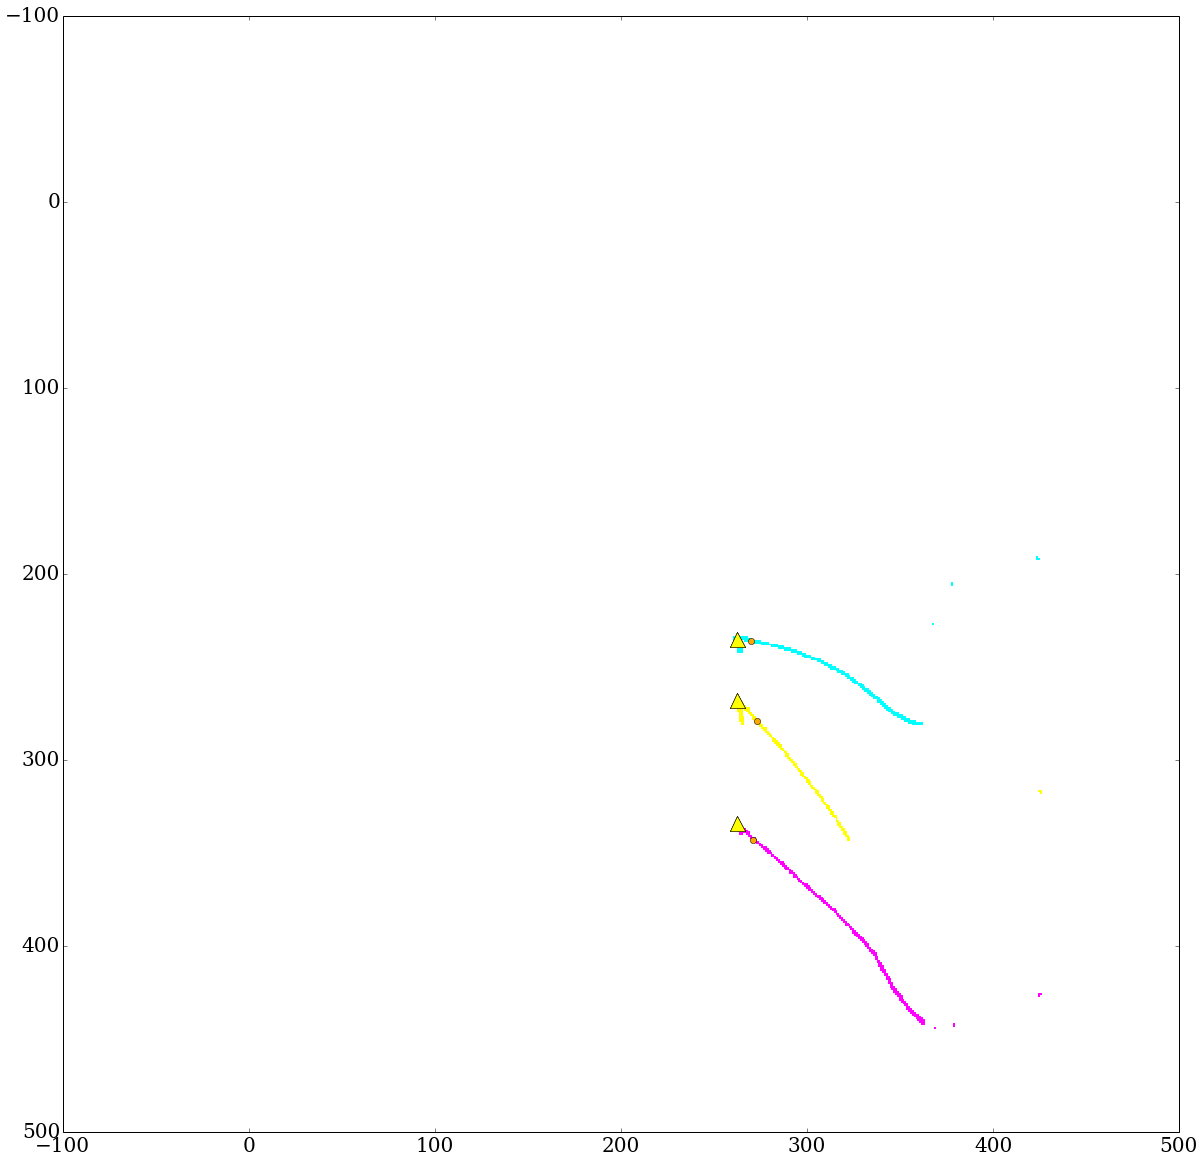

matched r/s/e  4 , 9013 , 180259 ... to  4 , 9013 , 180259
4684    0
4685    1
Name: vtx3d_type, dtype: uint32
4684    0
4685    1
Name: vtx3d_type, dtype: uint32


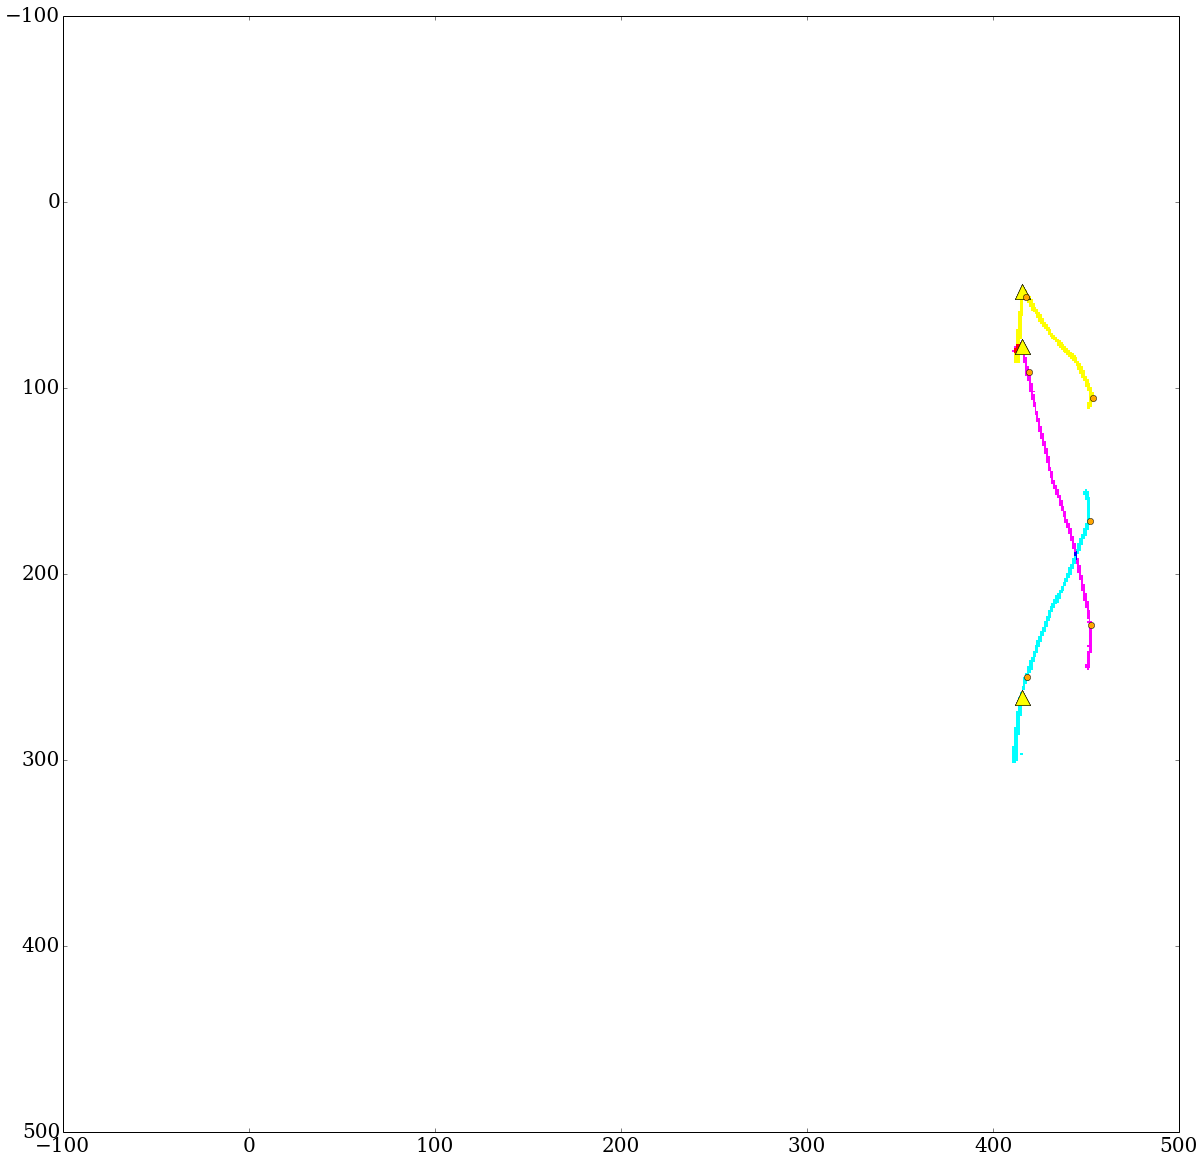

matched r/s/e  4 , 9273 , 185456 ... to  4 , 9273 , 185456
4742    0
Name: vtx3d_type, dtype: uint32


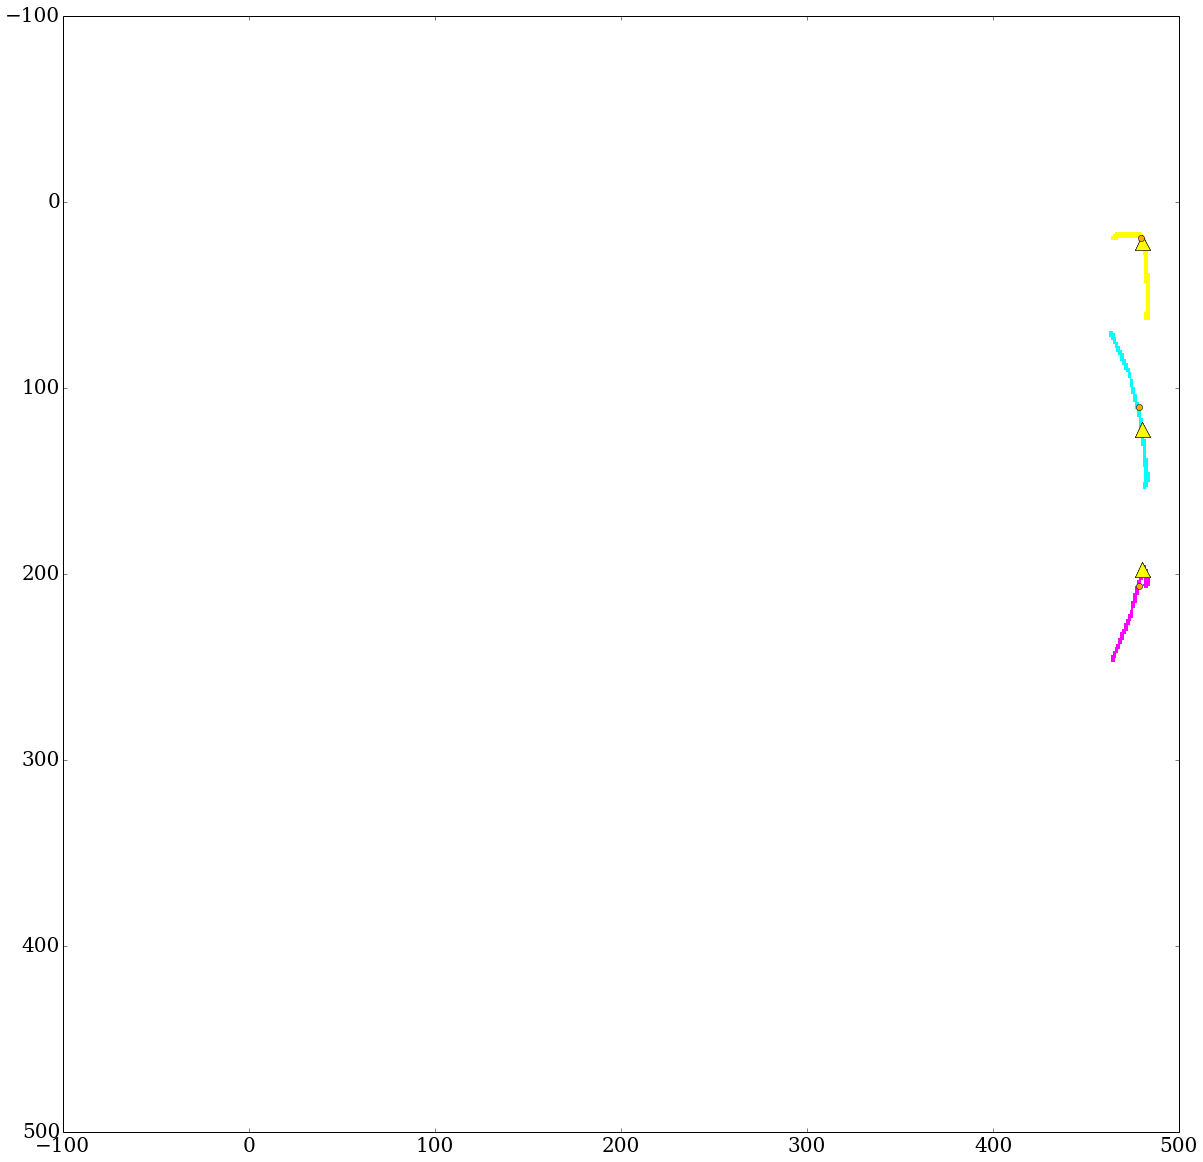

matched r/s/e  4 , 8722 , 174428 ... to  4 , 8722 , 174428


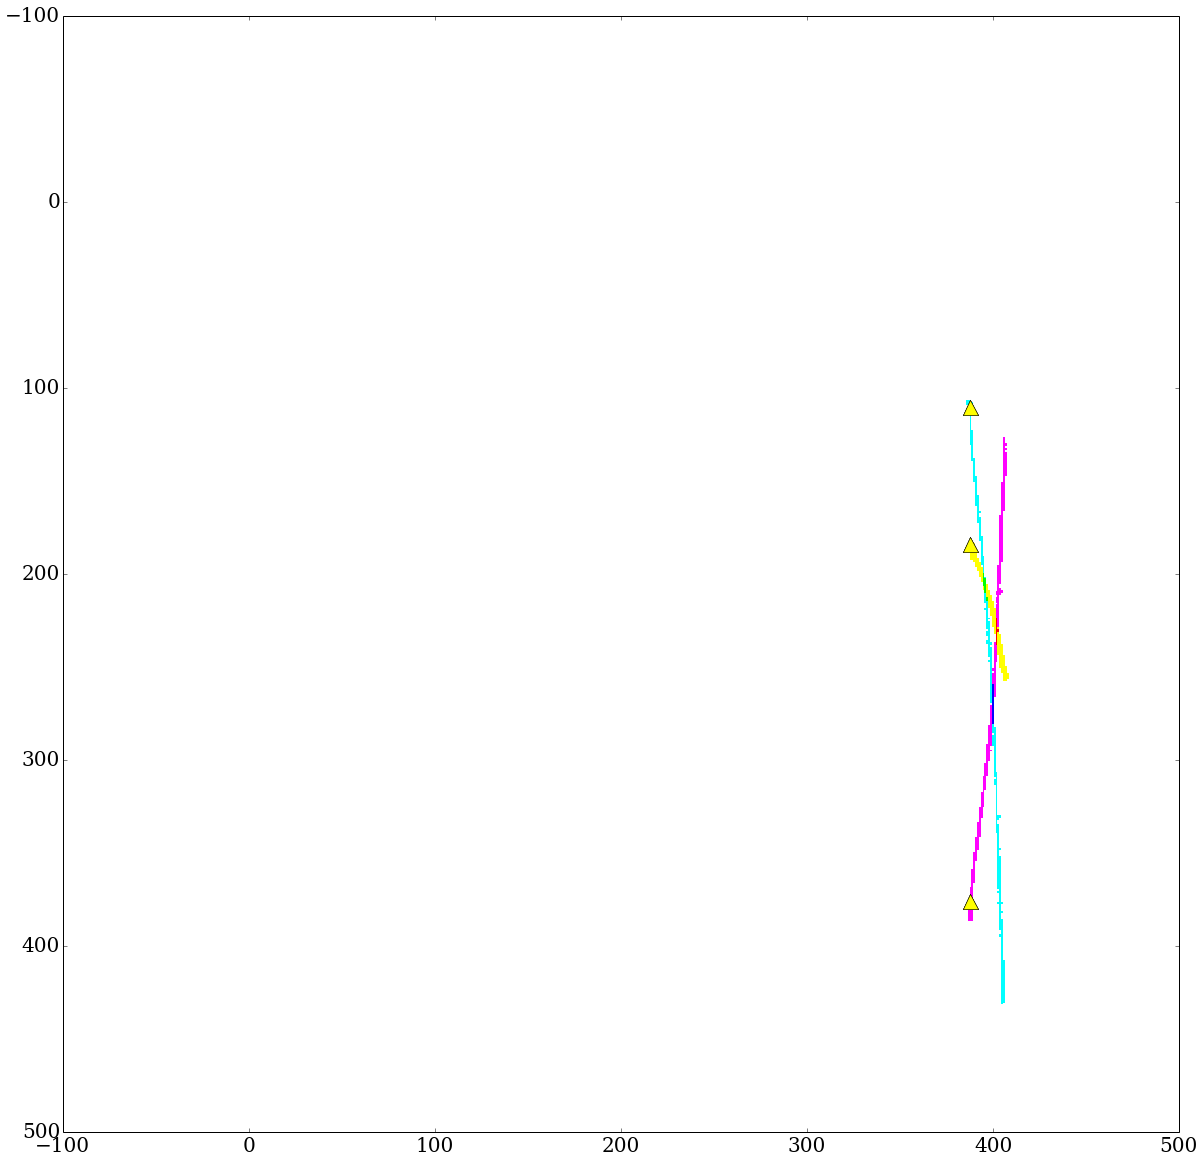

matched r/s/e  4 , 8551 , 171002 ... to  4 , 8551 , 171002


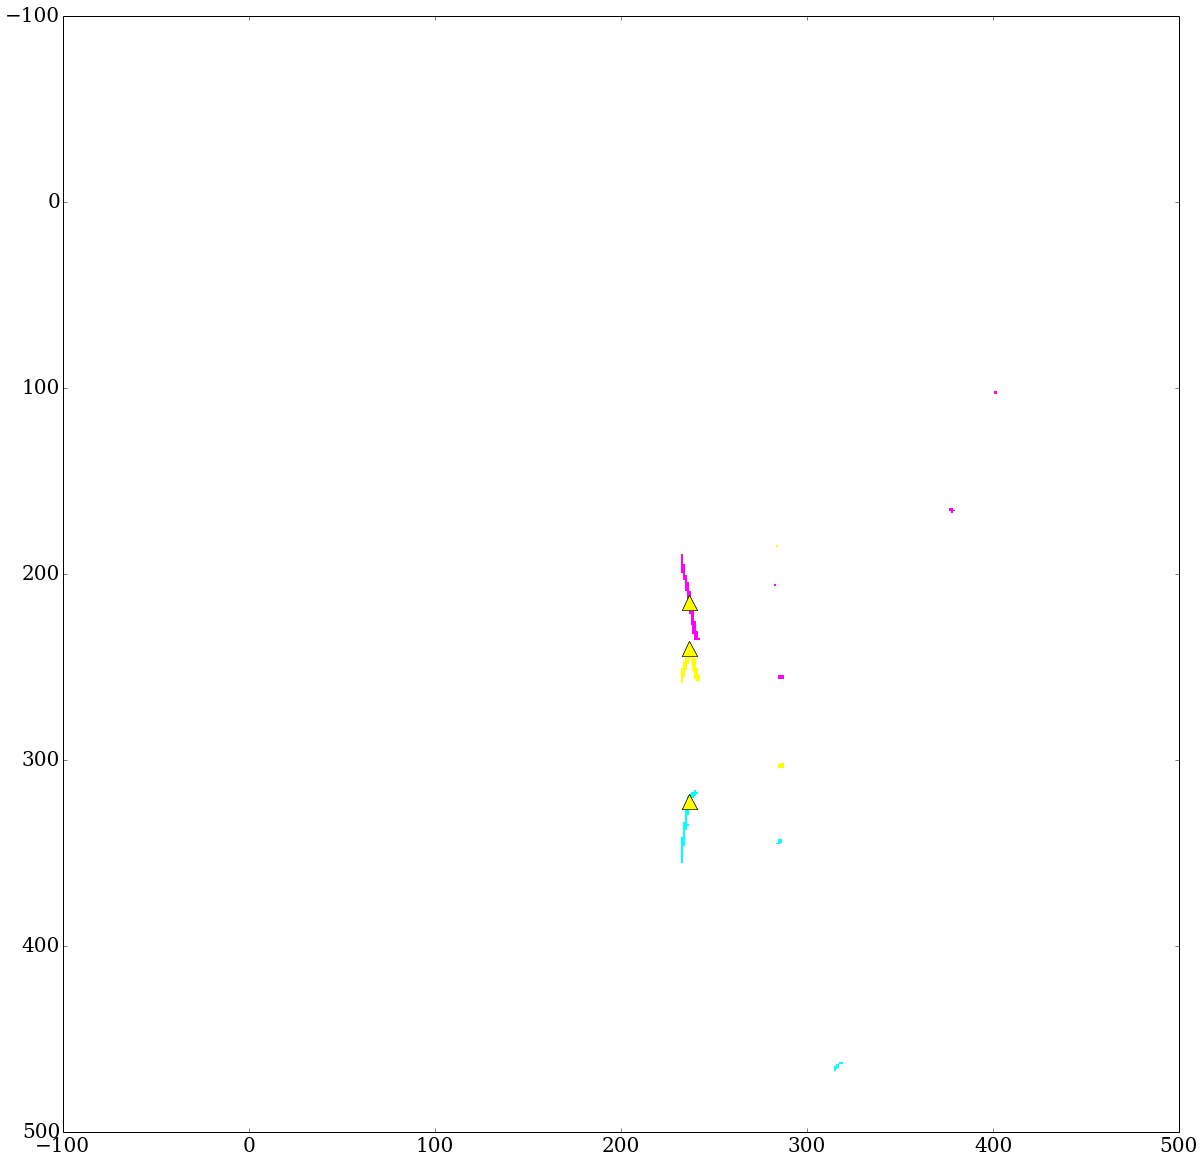

matched r/s/e  4 , 9682 , 193633 ... to  4 , 9682 , 193633


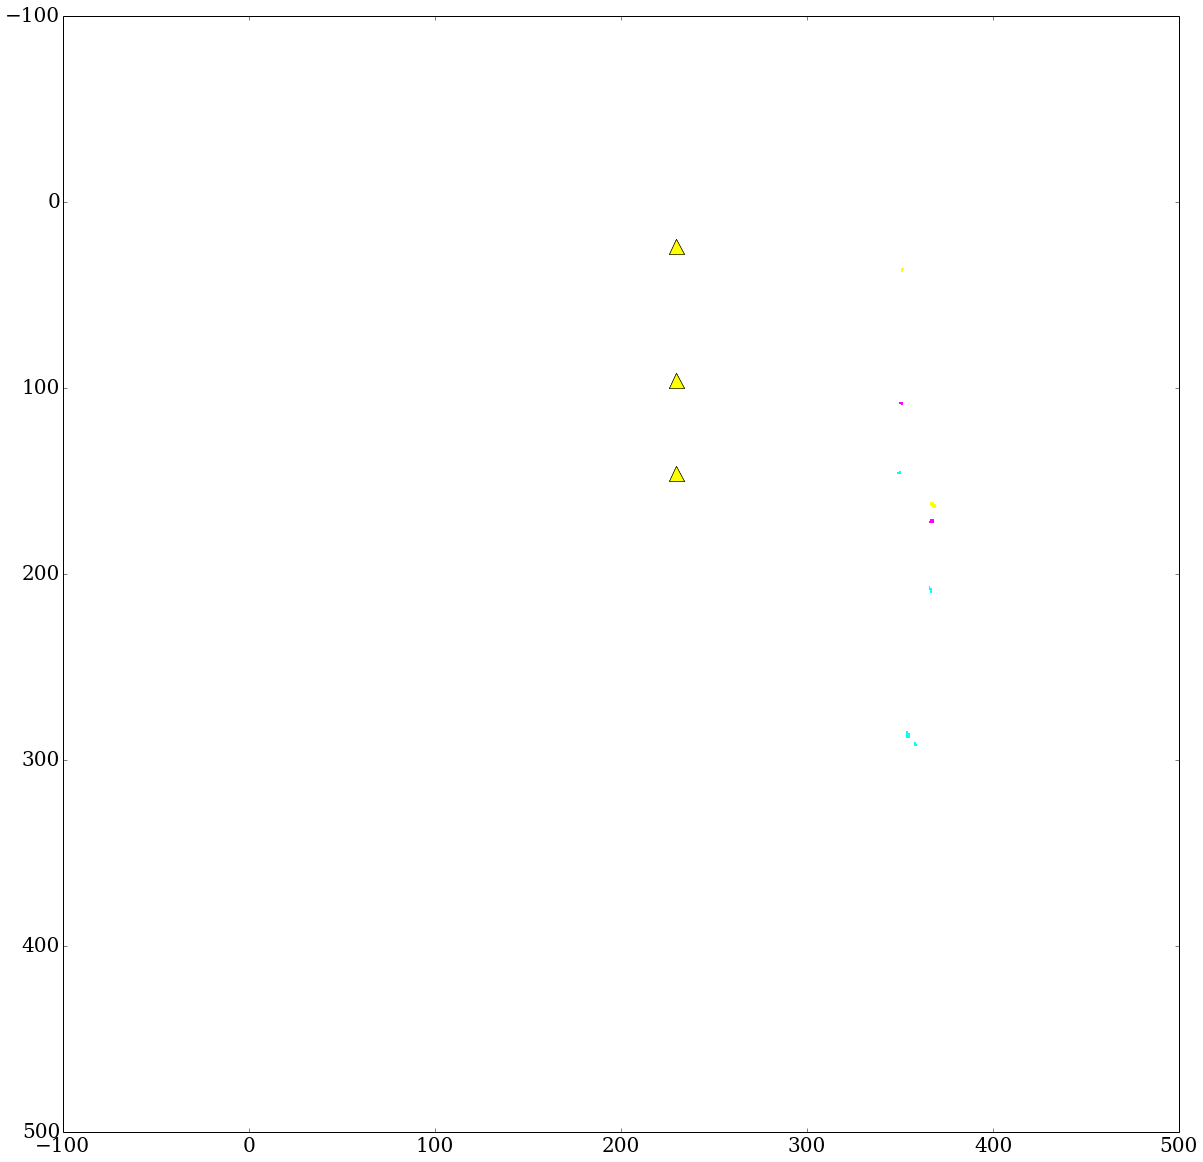

matched r/s/e  4 , 9006 , 180117 ... to  4 , 9006 , 180117


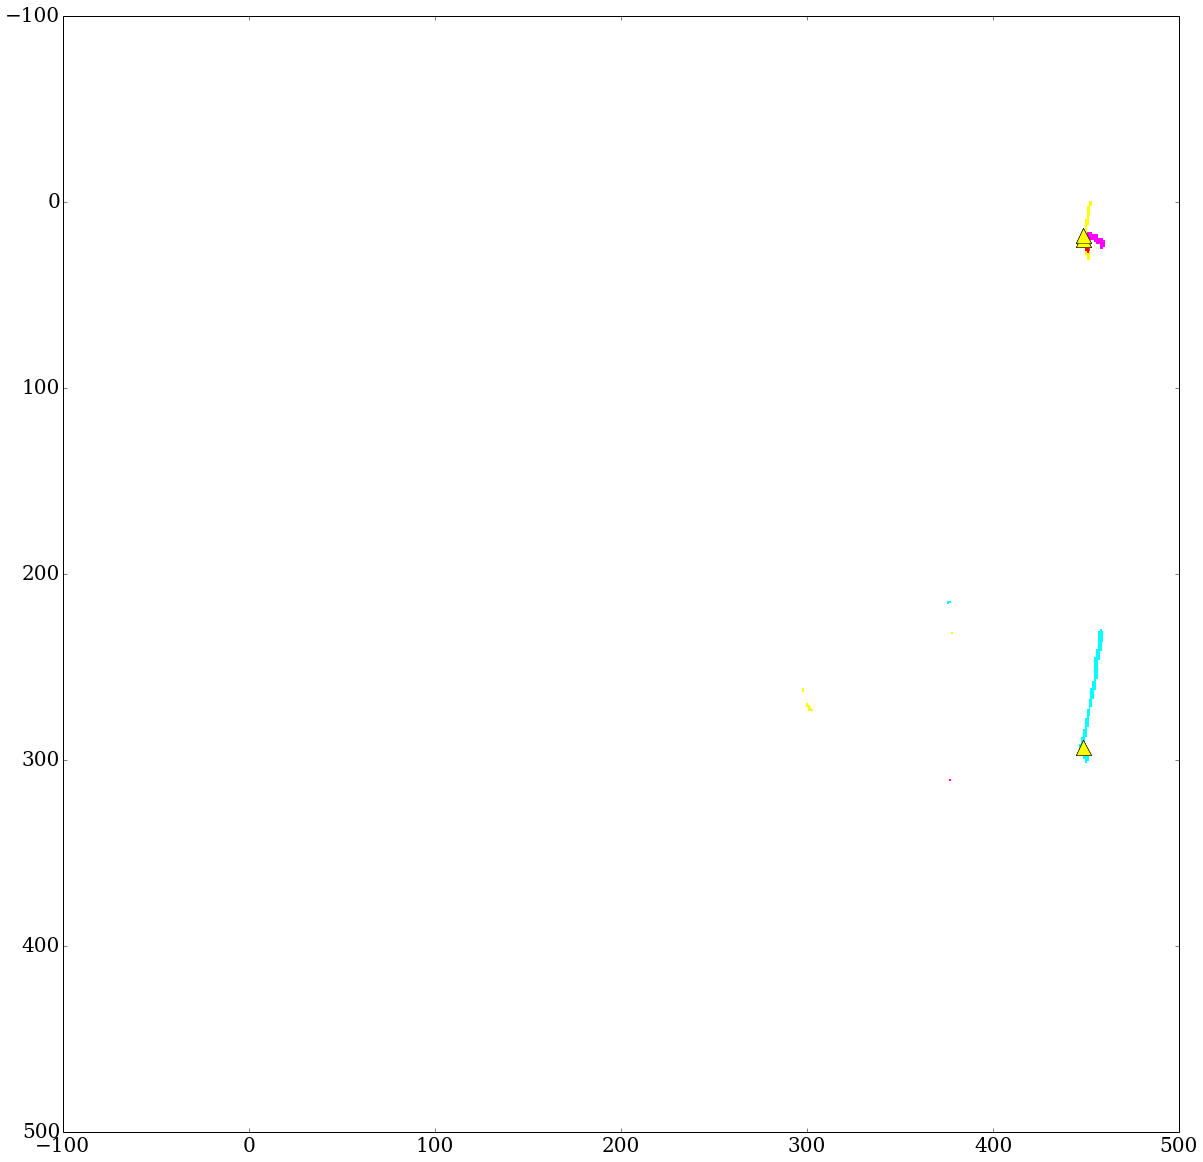

matched r/s/e  4 , 8509 , 170173 ... to  4 , 8509 , 170173


ValueError: zero-size array to reduction operation maximum which has no identity

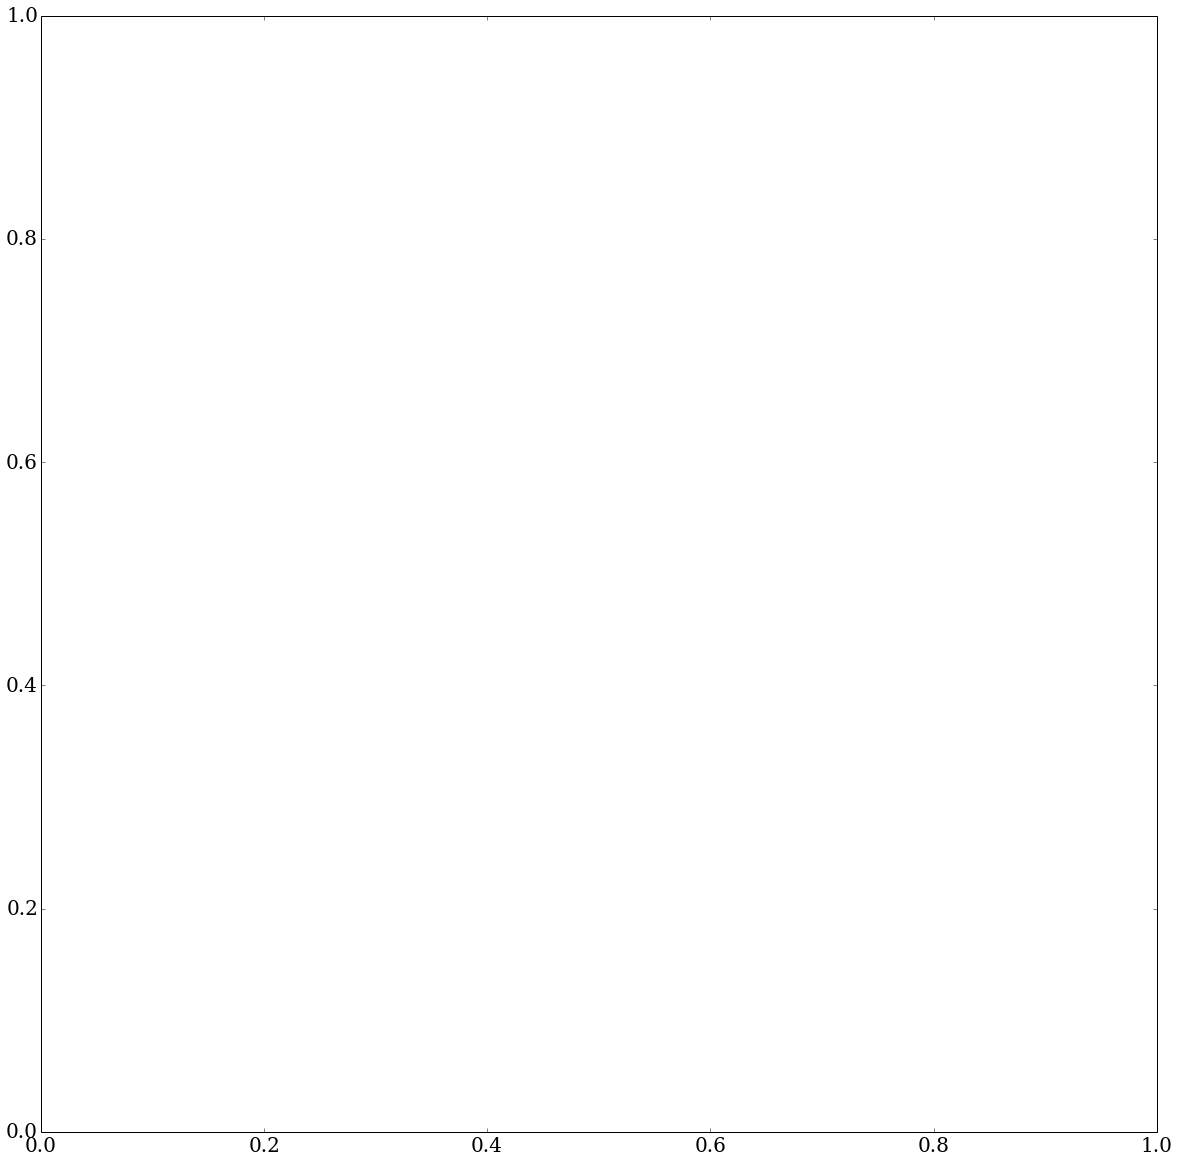

In [62]:
faillist = []
ctr = 0
colormap=['red','blue','green','orange','pink','black','red','blue','green','orange','pink','black']
ee_v=[]

for entry in dump_idx:#n_reco_v:

    thisrun    = mc_sdf.ix[entry].run
    thissubrun = mc_sdf.ix[entry].subrun
    thisevent  = mc_sdf.ix[entry].event
    
    iom.read_entry(0)
    ee=0
    evroi=iom.get_data(larcv.kProductROI,"tpc_hires_crop")
    run=-1
    subrun=-1
    event=-1
    while (True):
        iom.read_entry(ee)
        evroi=iom.get_data(larcv.kProductROI,"tpc_hires_crop")
        run   = evroi.run()
        subrun= evroi.subrun()
        event = evroi.event()
        ee+=1
        if run == thisrun and subrun==thissubrun and event==thisevent: break
        
    #print "ee: ",ee-1
    ee_v.append(ee-1)
    ctr+=1
    #if ctr==20:break
    if ee-1==6045: continue
    print "matched r/s/e ",run,",",subrun,",",event,"... to ",thisrun,",",thissubrun,",",thisevent
    larbysimg.process(iom)
    mgr=larbysimg.Manager()
    
    img_v = []
    
    fig,ax=plt.subplots(figsize=(20,20))
    maxx=0;minx=9999
    maxy=0;miny=9999
    plane=0
    caca_img=np.zeros((485, 485,3))
    cc=-1 #Add colors to different plane
    for mat in mgr.InputImages():
        cc+=1
        img_v.append(pygeo.image(mat))
        shape_img=np.where(img_v[plane]>10.5,1.0,0.0).astype(np.uint8)
        plane+=1
        nz_pixels=np.where(shape_img>0.0)
        
        maxx=np.maximum(maxx,np.max(nz_pixels[1])+100)
        minx=np.minimum(minx,np.min(nz_pixels[1])-100)

        maxy=np.maximum(maxy,np.max(nz_pixels[0])+100)
        miny=np.minimum(miny,np.min(nz_pixels[0])-100)

        caca_img[:,:,cc]=shape_img
    caca_img=np.where(caca_img>0.0,1.0,255)
    caca_img=caca_img.astype(np.uint8)
    plt.imshow(caca_img,interpolation='none')

    for iz in xrange(3):
        w_v=mc_df.loc[entry].vtx2d_w
        t_v=mc_df.loc[entry].vtx2d_t
        
        for w,t in zip(w_v,t_v):
            plt.plot(t,w,'^',color='yellow',markersize=15)
            #pass

    ctr+=1
    ee_v.append(ee-1)
    #plt.savefig("ee_%05d.png"%(ee-1))

    thisevt = reco_event_df.query("run==@thisrun&subrun==@thissubrun&event==@thisevent")
    thisvtx = reco_vtx3d_df.query("run==@thisrun&subrun==@thissubrun&event==@thisevent")
    for v in xrange(thisevt.n_vtx3d.values[0]):
        print thisvtx.vtx3d_type
        plane=-1
        for cvtx_x,cvtx_y in zip(thisvtx.iloc[v].circle_vtx_x_v,
                                thisvtx.iloc[v].circle_vtx_y_v):
    
            plane+=1
            plt.plot(cvtx_x,cvtx_y,'o',color='orange')
    
        
    plt.show()
    
    if ctr==3:break
    
#ee_v=np.array(ee_v)
#print ee_v

In [60]:
eea

array([  373,   709,   726,   835,   847,   895,  1027,  1263,  1295,
        1312,  1343,  1401,  1450,  1491,  1562,  1605,  1716,  1777,
        2051,  2135,  2440,  2442,  2467,  2821,  2897,  2973,  3119,
        3221,  3323,  3411,  3473,  3544,  3634,  3737,  3781,  3785,
        3871,  3982,  3986,  4058,  4235,  4309,  4384,  4406,  4452,
        4587,  4665,  4883,  5065,  5100,  5154,  5275,  5489,  5735,
        5779,  5833,  6045,  6206,  6375,  6467,  6981,  7028,  7350,
        7417,  7546,  7768,  7938,  8025,  8388,  8475,  8535,  8565,
        8655,  8715,  8763,  8908,  8916,  9001,  9053,  9066,  9260,
        9438,  9593,  9605,  9610,  9663,  9869, 10225, 10375, 10487,
       10514, 10640, 10730, 10955, 11059, 11144, 11371, 11543, 11708,
       11844, 11937, 12113, 12181, 12489, 12529, 12703, 12821, 12870,
       12887, 12992, 13095, 13098, 13141, 13398, 13622, 13734, 13915,
       14031, 14400, 14653, 14949, 15001, 15091, 15427, 15521, 15654,
       15867, 16043,

## Rejecting multiplicity

In [170]:
# cut on mc_df for visibility -- must be lepton with 35 MeV

#ask for atleast 1 lepton
print "Total number of events NU [200,600]: ",mc_df.index.size
mc_sdf = mc_df.query("nlepton>0")
print "Events with atleast 1 lepton: ",mc_sdf.index.size
mc_sdf = mc_sdf.query("dep_sum_lep>35")
print "Events with atleast 35 MeV lep sum: ",mc_sdf.index.size
mc_sdf = mc_sdf.query("nproton>0")
print "Events with 1 proton: ",mc_sdf.index.size
mc_sdf = mc_sdf.query("dep_sum_proton>60")
print "Events with atleast 60 MeV proton: ",mc_sdf.index.size
n_primary_df=mc_sdf.query("nprimary>2")
print "Events with more than 2 primary particles",n_primary_df.index.size
tp_df=n_primary_df.query("nproton>=2")
print "Events with 2 or more protons",tp_df.index.size
ecut=60.0
def check_proton(row):
    proton_idx=np.where(row['daughterPdg_v']==2212)[0]
    proton_ptrack=row['daughterParentTrackid_v'][proton_idx]
    proton_track =row['daughterTrackid_v'][proton_idx]
    proton_idx=proton_idx[proton_ptrack==proton_track]
    return np.where(row['daughterEnergyDep_v'][proton_idx]>=ecut)[0].size

proton_vis=tp_df.apply(check_proton,axis=1)

pp=None
for ii in xrange(10):
    print ii,"...",proton_vis[proton_vis==ii].index.size
    if ii==2:
        pp=proton_vis[proton_vis==ii].index
        

Total number of events NU [200,600]:  8891
Events with atleast 1 lepton:  8860
Events with atleast 35 MeV lep sum:  8545
Events with 1 proton:  6736
Events with atleast 60 MeV proton:  3342
Events with more than 2 primary particles 320
Events with 2 or more protons 319
0 ... 10
1 ... 255
2 ... 52
3 ... 2
4 ... 0
5 ... 0
6 ... 0
7 ... 0
8 ... 0
9 ... 0


## Recon efficiency on >2 multiplicity events

In [172]:
mc_pdf=mc_sdf.ix[pp]
pp_v = do_selection(mc_pdf,reco_event_df,reco_vtx3d_df)
print "Reco Efficiency is ", pp_v.size,"/",mc_pdf.index.size,"= ",float(pp_v.size)/float(mc_pdf.index.size)

Reco Efficiency is  50 / 52 =  0.961538461538


In [182]:
#choose the best vertex

m=[]
ctr=0
for name_,row_ in mc_pdf.ix[pp_v].iterrows():
#for name_,row_ in mc_sdf.ix[n_reco_v].iterrows():
    ctr+=1
    run,subrun,event=row_.run,row_.subrun,row_.event
    
    reco_evt_rse = reco_event_df.query("run==@run&subrun==@subrun&event==@event")
    reco_vtx_rse = reco_vtx3d_df.query("run==@run&subrun==@subrun&event==@event")
    #reco_par_rse = reco_particle_df.query("run==@run&subrun==@subrun&event==@event")
    
    #pick the best vertex
    mcx   = row_.vtx2d_t
    mcy   = row_.vtx2d_w
  
    dd=[]
    for vtx_idx in xrange(reco_evt_rse.n_vtx3d):
        recox = reco_vtx_rse.circle_vtx_x_v.values[vtx_idx]
        recoy = reco_vtx_rse.circle_vtx_y_v.values[vtx_idx]
        dist  = np.sqrt(np.power(recox-mcx,2)+np.power(recoy-mcy,2))
        dist.sort()
        dd.append(dist[0]+dist[1])

    cidx = np.argmin(dd)
    n_pars_v=reco_vtx_rse.circle_vtx_xs_v.values[cidx]
    
    #check how many twos there are
    m_=None
    
    if np.where(n_pars_v==2)[0].size>1: 
        m_=2
    else:
        m_=np.max(n_pars_v)
    
    #n_pars_v=reco_par_rse.query("vtx3d_id==@cidx").n_pars
    #print n_pars_v
    #m_=np.max(n_pars_v)
    m.append(m_)
    #if m_ == 2: 
        #print "n vertex found...: ",reco_evt_rse.n_vtx3d
        #print n_pars_v,"\n...+++... ",name_," ...+++...\n",row_
        
    #if ctr==50: break
    
m=np.array(m)

In [174]:
r_=mc_sdf.ix[n_reco_v]
iidx=r_.iloc[m>2].index
print iidx.size

81


14
36


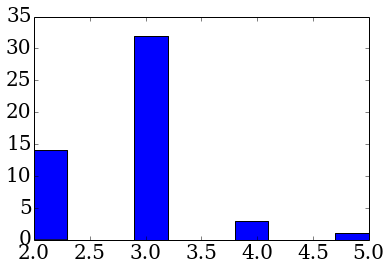

In [183]:
iidx=mc_pdf.ix[pp_v].iloc[np.where(m==2)[0]].index
print iidx.size
print np.where(m>2)[0].size
plt.hist(m)
plt.show()


In [190]:
for name_,row_ in mc_sdf.ix[n_reco_v].iterrows():

    run,subrun,event=row_.run,row_.subrun,row_.event    
    
    reco_evt_rse = reco_event_df.query("run==@run&subrun==@subrun&event==@event")
    reco_vtx_rse = reco_vtx_df.query("run==@run&subrun==@subrun&event==@event")
    

0        0
1        0
2        0
3        0
4        1
5        0
6        0
7        1
8        1
9        0
10       0
11       0
12       0
13       0
14       0
15       1
16       0
17       0
18       0
19       1
20       1
21       0
22       1
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
11268    0
11269    0
11270    0
11271    0
11272    1
11273    0
11274    1
11275    0
11276    1
11277    0
11278    1
11279    0
11280    0
11281    0
11282    0
11283    1
11284    0
11285    0
11286    1
11287    1
11288    0
11289    0
11290    0
11291    0
11292    0
11293    0
11294    0
11295    1
11296    1
11297    1
Name: vtx3d_type, dtype: uint32

In [198]:
ee_v

[41, 41]

In [248]:
mc_rdf = mc_sdf.ix[n_reco_v]
mc_zdf = mc_rdf.set_index(['run','subrun','event'])

reco_event_zdf = reco_event_df.set_index(['run','subrun','event'])
reco_vtx3d_zdf = reco_vtx3d_df.set_index(['run','subrun','event'])
reco_par_zdf   = reco_particle_df.set_index(['run','subrun','event'])

n_event_vtx3d=0
n_event_vtx3d_f=0
n_event_vtx3d_f_a=0

cc0=[]
cc1=[]

n_single_choice=0
n_single_choice_right_good=0
n_single_choice_right_bad=0
n_single_choice_wrong_good=0
n_single_choice_wrong_bad=0
n_make_a_choice=0
n_reco_chose_wrong=0
n_reco_chose_wrong_good=0
n_reco_chose_wrong_bad=0
n_reco_chose_right=0
n_reco_chose_right_good=0
n_reco_chose_right_bad=0
n_filtered=0

n_1_vtx=0
n_2_vtx=0
n_3_vtx=0
n_4more_vtx=0

n_good_reco=0
n_no_good_reco=0

groups_=mc_zdf.groupby(mc_zdf.index)
n_total=len(groups_)

cc0=[]
cc1=[]
def correct(reco_vtx3d_,group_,chosen_idx_):

    recox = reco_vtx3d_.circle_vtx_x_v.values[chosen_idx_]
    recoy = reco_vtx3d_.circle_vtx_y_v.values[chosen_idx_]
    mcx   = group_.vtx2d_t.values[0]
    mcy   = group_.vtx2d_w.values[0]

    d=np.sqrt(np.power(recox-mcx,2)+np.power(recoy-mcy,2))
    d=np.array(d)
    d.sort()
    if d[0] <= 7 and d[1] <= 7:
        return True

    return False


DEBUG=False
for name, group in groups_:
    
    b_single_choice=False
    b_single_choice_wrong=False
    b_single_choice_right=False
    b_reco_chose_wrong=False
    b_reco_chose_right=False
    b_good_reco=False
    b_no_good_reco=False
    b_make_a_choice=False
    
    query_='run=={}&subrun=={}&event=={}'.format(name[0],name[1],name[2])
    reco_event = reco_event_df.query(query_)

    if DEBUG: print "run: ",name[0],"... subrun: ",name[1],"... event: ",name[2]
    
    nvtx=reco_event['n_vtx3d'].values[0]

    if nvtx==0: 
        continue

    n_event_vtx3d+=1;
    
    #pre filtering of n_pix_frac 
    
    reco_vtx3d = reco_vtx3d_df.query(query_)
    reco_par   = reco_particle_df.query(query_)

    #type_v = reco_vtx3d.vtx3d_type.values.tolist()
    type_v = reco_vtx3d.vtx3d_type.values
    
    #print type_v,np.where(type_v==0L)[0].size
    #if nvtx==1 or (nvtx==2 and ((0 in type_v) and (1 in type_v))):
    
    if nvtx==1 or (nvtx>1 and np.where(type_v==0L)[0].size==1):
        if DEBUG: print "Single choice"
            
        b_single_choice=True
        type_v=np.array(type_v)
        if nvtx==2:
            chosen_idx = np.where(type_v==0L)[0][0]
        else:
            chosen_idx=0
        
        close = correct(reco_vtx3d,group,chosen_idx)

        if close == True: 
            b_single_choice_right=True
        else: 
            b_single_choice_wrong=True
        
    else:
        
        n_pixel_frac_v=reco_vtx3d.num_pixel_frac_v

        bad_idx=[]
        for ix,npf in enumerate(n_pixel_frac_v.values):
            if ( np.where(npf>0.8)[0].size==3 ): continue;
            bad_idx.append(ix)

        #reco_vtx3d = reco_vtx3d.query('vtx3d_id not in @bad_idx')
        #reco_par   = reco_par.query  ('vtx3d_id not in @bad_idx')

        nvtx2=reco_vtx3d.index.values.size
        
        if nvtx2 < nvtx:
            if DEBUG: 
                print "Filtered NPX frac"
        
        nvtx=nvtx2    
        
        if nvtx==0: 
            if DEBUG: print "Filtered NPX frac bad_idx: ",bad_idx
            n_event_vtx3d_f+=1;
            continue
    
        angle_vv=reco_vtx3d.circle_vtx_angle_v
        
        bad_idx=[]
        for ix,angle_v in enumerate(angle_vv.values):
            if( np.where(angle_v<170.)[0].size>1 ): continue;
            bad_idx.append(ix)
        
        #reco_vtx3d = reco_vtx3d.query('vtx3d_id not in @bad_idx')
        #reco_par   = reco_par.query  ('vtx3d_id not in @bad_idx')

        nvtx2=reco_vtx3d.index.values.size
        if nvtx2 < nvtx:
            if DEBUG: 
                print "Filtered angle_vv bad_idx: ",bad_idx
                
        nvtx=nvtx2
        if nvtx==0:
            n_event_vtx3d_f_a+=1;
            continue   
            
        b_make_a_choice=True
        
        # make your choice...
        # chosen_idx=np.argmax(np.row_stack(reco_vtx3d.circle_vtx_r_v.values).sum(axis=1))
        
        if nvtx==1:
            n_1_vtx+=1
        elif nvtx==2:
            n_2_vtx+=1
        elif nvtx==3:
            n_3_vtx+=1
        else:
            n_4more_vtx+=1
           
        sum_pix_frac_copy = reco_vtx3d.sum_pixel_frac.values.tolist()

        angle_sum_v = [0.]*len(sum_pix_frac_copy)
        
        for ix,angle_v in enumerate(reco_vtx3d.circle_vtx_angle_v.values):
            angle_sum_v[ix] = angle_v.sum()

        #angle_sum_v=np.array(angle_sum_v)
        #chosen_idx=np.argmin(angle_sum_v)
        
        #make the decision based on the length of th shortest track
            
        dec_=[]
        if DEBUG:
            print "reco vtx3d id values: ",reco_vtx3d.vtx3d_id.values
        
        for ix,vtx_id in enumerate(reco_vtx3d.vtx3d_id.values):
            
            dec_.append(0)
            
            thisvtx=reco_par.query('vtx3d_id=={}'.format(vtx_id))
    
            for plane_id in xrange(3):
                thisplane=thisvtx.query("plane_id=={}".format(plane_id))

                if (thisplane.n_pars.values[0] < 2): 
                    continue
                    
                #get the shortest track
                s_idx=np.argmin(thisplane.atom_sum_length_v.values[0])
                
                #get the direction of the shortest track
                sy=thisplane.start_y_v.values[0][s_idx]
                ey=thisplane.end_y_v  .values[0][s_idx]                    

                if (ey>sy):
                    dec_[-1]+=1
        
        
        dec_=np.array(dec_)
        
        chosen_idx=np.argmax(dec_)
        if DEBUG:
            print "chosen_idx: ", chosen_idx, "... dec_ ",dec_
            print ""
        close = correct(reco_vtx3d,group,chosen_idx)

        if close == True: 
            b_reco_chose_right=True
        else: 
            b_reco_chose_wrong=True


    #is there a reco vertex, we just chose it wrong?
    good_reco=False
    for idx_ in xrange(nvtx):
        
        if good_reco==True : continue
        good_reco = correct(reco_vtx3d,group,idx_)
        
    if good_reco==True: 
        b_good_reco=True
    else:
        b_no_good_reco=True

    if b_single_choice==True:
        n_single_choice+=1
        
    if b_single_choice_right==True and b_no_good_reco==False:
        n_single_choice_right_good+=1
         
    if b_single_choice_right==True and b_no_good_reco==True:
        n_single_choice_right_bad+=1
        
    if b_single_choice_wrong==True and b_no_good_reco==False:
        n_single_choice_wrong_good+=1
        
    if b_single_choice_wrong==True and b_no_good_reco==True:
        n_single_choice_wrong_bad+=1
        
    if b_make_a_choice==True:
        n_make_a_choice+=1
        
    if b_reco_chose_right==True:
        n_reco_chose_right+=1
        
    if b_reco_chose_right==True and b_no_good_reco==False:
        n_reco_chose_right_good+=1
        
    if b_reco_chose_right==True and b_no_good_reco==True:
        n_reco_chose_right_bad+=1
        
    if b_reco_chose_wrong==True:
        n_reco_chose_wrong+=1
  
    if b_reco_chose_wrong==True and b_no_good_reco==False:
        n_reco_chose_wrong_good+=1
       
    if b_reco_chose_wrong==True and b_no_good_reco==True:
        n_reco_chose_wrong_bad+=1
    
    if b_reco_chose_right == True and b_reco_chose_wrong == True:
        assert(False)
    
    if b_good_reco==True:
        n_good_reco+=1
        cc0.append(mc_df.query(query_).index.values[0])
        cc1.append(reco_par_zdf.query(query_).index.values[0])
        
    if b_no_good_reco==True:
        n_no_good_reco+=1


    
print "n_total:\t",n_total
print "\nn_event_vtx3d:\t\t",n_event_vtx3d
print "n_event_vtx3d_f_n_pix_frac\t",n_event_vtx3d_f
print "n_event_vtx3d_f_angle:\t",n_event_vtx3d_f_a
print "\nn_events_parsed:\t",n_event_vtx3d-n_event_vtx3d_f-n_event_vtx3d_f_a
print "n_1_vtx:\t",n_1_vtx
print "n_2_vtx:\t",n_2_vtx
print "n_3_vtx:\t",n_3_vtx
print "n_4more_vtx:\t",n_4more_vtx

print "\nn_single_choice:\t",n_single_choice
print "n_single_choice_right_good:",n_single_choice_right_good
print "n_single_choice_right_bad: ",n_single_choice_right_bad
print "n_single_choice_wrong_good:",n_single_choice_wrong_good
print "n_single_choice_wrong_bad: ",n_single_choice_wrong_bad
print "\nn_make_a_choice:       ",n_make_a_choice
print "n_reco_chose_right:      ",n_reco_chose_right
print "n_reco_chose_right_good: ",n_reco_chose_right_good
print "n_reco_chose_right_bad:  ",n_reco_chose_right_bad
print "n_reco_chose_wrong:      ",n_reco_chose_wrong
print "n_reco_chose_wrong_good: ",n_reco_chose_wrong_good
print "n_reco_chose_wrong_bad:  ",n_reco_chose_wrong_bad

print "\ngood possible vtx diagnostic"
print "total reco correct:\t",n_single_choice_right_good+n_reco_chose_right_good
print "total reco wrong:\t",n_single_choice_wrong_good+n_reco_chose_wrong_good

print "\nbest case senario"
print "n_good_reco:\t\t",n_good_reco
print "n_no_good_reco:\t\t",n_no_good_reco
print "\n\n"

n_total:	2543

n_event_vtx3d:		2543
n_event_vtx3d_f_n_pix_frac	0
n_event_vtx3d_f_angle:	0

n_events_parsed:	2543
n_1_vtx:	0
n_2_vtx:	185
n_3_vtx:	276
n_4more_vtx:	470

n_single_choice:	1612
n_single_choice_right_good: 1576
n_single_choice_right_bad:  0
n_single_choice_wrong_good: 36
n_single_choice_wrong_bad:  0

n_make_a_choice:        931
n_reco_chose_right:       603
n_reco_chose_right_good:  603
n_reco_chose_right_bad:   0
n_reco_chose_wrong:       328
n_reco_chose_wrong_good:  328
n_reco_chose_wrong_bad:   0

good possible vtx diagnostic
total reco correct:	2179
total reco wrong:	364

best case senario
n_good_reco:		2543
n_no_good_reco:		0





In [252]:
idx=mc_sdf.ix[n_reco_v].index
mc_rdf=mc_sdf.drop(idx)
mc_zdf = mc_rdf.set_index(['run','subrun','event'])

reco_event_zdf = reco_event_df.set_index(['run','subrun','event'])
reco_vtx3d_zdf = reco_vtx3d_df.set_index(['run','subrun','event'])
reco_par_zdf   = reco_particle_df.set_index(['run','subrun','event'])

n_event_vtx3d=0
n_event_vtx3d_f=0
n_event_vtx3d_f_a=0

cc0=[]
cc1=[]

n_single_choice=0
n_single_choice_right_good=0
n_single_choice_right_bad=0
n_single_choice_wrong_good=0
n_single_choice_wrong_bad=0
n_make_a_choice=0
n_reco_chose_wrong=0
n_reco_chose_wrong_good=0
n_reco_chose_wrong_bad=0
n_reco_chose_right=0
n_reco_chose_right_good=0
n_reco_chose_right_bad=0
n_filtered=0

n_1_vtx=0
n_2_vtx=0
n_3_vtx=0
n_4more_vtx=0

n_good_reco=0
n_no_good_reco=0

groups_=mc_zdf.groupby(mc_zdf.index)
n_total=len(groups_)

cc0=[]
cc1=[]
def correct(reco_vtx3d_,group_,chosen_idx_):

    recox = reco_vtx3d_.circle_vtx_x_v.values[chosen_idx_]
    recoy = reco_vtx3d_.circle_vtx_y_v.values[chosen_idx_]
    mcx   = group_.vtx2d_t.values[0]
    mcy   = group_.vtx2d_w.values[0]

    d=np.sqrt(np.power(recox-mcx,2)+np.power(recoy-mcy,2))
    d=np.array(d)
    d.sort()
    if d[0] <= 7 and d[1] <= 7:
        return True

    return False


DEBUG=False
for name, group in groups_:
    
    b_single_choice=False
    b_single_choice_wrong=False
    b_single_choice_right=False
    b_reco_chose_wrong=False
    b_reco_chose_right=False
    b_good_reco=False
    b_no_good_reco=False
    b_make_a_choice=False
    
    query_='run=={}&subrun=={}&event=={}'.format(name[0],name[1],name[2])
    reco_event = reco_event_df.query(query_)

    if DEBUG: print "run: ",name[0],"... subrun: ",name[1],"... event: ",name[2]
    
    nvtx=reco_event['n_vtx3d'].values[0]

    if nvtx==0: 
        continue

    n_event_vtx3d+=1;
    
    #pre filtering of n_pix_frac 
    
    reco_vtx3d = reco_vtx3d_df.query(query_)
    reco_par   = reco_particle_df.query(query_)

    #type_v = reco_vtx3d.vtx3d_type.values.tolist()
    type_v = reco_vtx3d.vtx3d_type.values
    #print type_v,np.where(type_v==0L)[0].size
    #if nvtx==1 or (nvtx==2 and ((0 in type_v) and (1 in type_v))):
    if nvtx==1 or (nvtx>1 and np.where(type_v==0L)[0].size==1):
        if DEBUG: print "Single choice"
            
        b_single_choice=True
        type_v=np.array(type_v)
        if nvtx==2:
            chosen_idx = np.where(type_v==0L)[0][0]
        else:
            chosen_idx=0
        
        close = correct(reco_vtx3d,group,chosen_idx)

        if close == True: 
            b_single_choice_right=True
        else: 
            b_single_choice_wrong=True
        
    else:
        
        n_pixel_frac_v=reco_vtx3d.num_pixel_frac_v

        bad_idx=[]
        for ix,npf in enumerate(n_pixel_frac_v.values):
            if ( np.where(npf>0.8)[0].size==3 ): continue;
            bad_idx.append(ix)

        reco_vtx3d = reco_vtx3d.query('vtx3d_id not in @bad_idx')
        reco_par   = reco_par.query  ('vtx3d_id not in @bad_idx')

        nvtx2=reco_vtx3d.index.values.size
        
        if nvtx2 < nvtx:
            if DEBUG: 
                print "Filtered NPX frac"
        
        nvtx=nvtx2    
        
        if nvtx==0: 
            if DEBUG: print "Filtered NPX frac bad_idx: ",bad_idx
            n_event_vtx3d_f+=1;
            continue
    
        angle_vv=reco_vtx3d.circle_vtx_angle_v
        
        bad_idx=[]
        for ix,angle_v in enumerate(angle_vv.values):
            if( np.where(angle_v<170.)[0].size>1 ): continue;
            bad_idx.append(ix)
        
        reco_vtx3d = reco_vtx3d.query('vtx3d_id not in @bad_idx')
        reco_par   = reco_par.query  ('vtx3d_id not in @bad_idx')

        nvtx2=reco_vtx3d.index.values.size
        if nvtx2 < nvtx:
            if DEBUG: 
                print "Filtered angle_vv bad_idx: ",bad_idx
                
        nvtx=nvtx2
        if nvtx==0:
            n_event_vtx3d_f_a+=1;
            continue   
            
        b_make_a_choice=True
        
        # make your choice...
        # chosen_idx=np.argmax(np.row_stack(reco_vtx3d.circle_vtx_r_v.values).sum(axis=1))
        
        if nvtx==1:
            n_1_vtx+=1
        elif nvtx==2:
            n_2_vtx+=1
        elif nvtx==3:
            n_3_vtx+=1
        else:
            n_4more_vtx+=1
           
        sum_pix_frac_copy = reco_vtx3d.sum_pixel_frac.values.tolist()

        angle_sum_v = [0.]*len(sum_pix_frac_copy)
        
        for ix,angle_v in enumerate(reco_vtx3d.circle_vtx_angle_v.values):
            angle_sum_v[ix] = angle_v.sum()

        #angle_sum_v=np.array(angle_sum_v)
        #chosen_idx=np.argmin(angle_sum_v)
    
        #make the decision based on the length of th shortest track
            
        dec_=[]
        if DEBUG:
            print "reco vtx3d id values: ",reco_vtx3d.vtx3d_id.values
        
        for ix,vtx_id in enumerate(reco_vtx3d.vtx3d_id.values):
            
            dec_.append(0)
            
            thisvtx=reco_par.query('vtx3d_id=={}'.format(vtx_id))
    
            for plane_id in xrange(3):
                thisplane=thisvtx.query("plane_id=={}".format(plane_id))

                if (thisplane.n_pars.values[0] < 2): 
                    continue
                    
                #get the shortest track
                s_idx=np.argmin(thisplane.atom_sum_length_v.values[0])
                
                #get the direction of the shortest track
                sy=thisplane.start_y_v.values[0][s_idx]
                ey=thisplane.end_y_v  .values[0][s_idx]                    

                if (ey>sy):
                    dec_[-1]+=1
        
        
        dec_=np.array(dec_)
        
        chosen_idx=np.argmax(dec_)
        if DEBUG:
            print "chosen_idx: ", chosen_idx, "... dec_ ",dec_
            print ""
        close = correct(reco_vtx3d,group,chosen_idx)

        if close == True: 
            b_reco_chose_right=True
        else: 
            b_reco_chose_wrong=True


    #is there a reco vertex, we just chose it wrong?
    good_reco=False
    for idx_ in xrange(nvtx):
        
        if good_reco==True : continue
        good_reco = correct(reco_vtx3d,group,idx_)
        
    if good_reco==True: 
        b_good_reco=True
    else:
        b_no_good_reco=True

    if b_single_choice==True:
        n_single_choice+=1
        
    if b_single_choice_right==True and b_no_good_reco==False:
        n_single_choice_right_good+=1
         
    if b_single_choice_right==True and b_no_good_reco==True:
        n_single_choice_right_bad+=1
        
    if b_single_choice_wrong==True and b_no_good_reco==False:
        n_single_choice_wrong_good+=1
        
    if b_single_choice_wrong==True and b_no_good_reco==True:
        n_single_choice_wrong_bad+=1
        
    if b_make_a_choice==True:
        n_make_a_choice+=1
        
    if b_reco_chose_right==True:
        n_reco_chose_right+=1
        
    if b_reco_chose_right==True and b_no_good_reco==False:
        n_reco_chose_right_good+=1
        
    if b_reco_chose_right==True and b_no_good_reco==True:
        n_reco_chose_right_bad+=1
        
    if b_reco_chose_wrong==True:
        n_reco_chose_wrong+=1
  
    if b_reco_chose_wrong==True and b_no_good_reco==False:
        n_reco_chose_wrong_good+=1
       
    if b_reco_chose_wrong==True and b_no_good_reco==True:
        n_reco_chose_wrong_bad+=1
    
    if b_reco_chose_right == True and b_reco_chose_wrong == True:
        assert(False)
    
    if b_good_reco==True:
        n_good_reco+=1
        cc0.append(mc_df.query(query_).index.values[0])
        cc1.append(reco_par_zdf.query(query_).index.values[0])
        
    if b_no_good_reco==True:
        n_no_good_reco+=1


    
print "n_total:\t",n_total
print "\nn_event_vtx3d:\t\t",n_event_vtx3d
print "n_event_vtx3d_f_n_pix_frac\t",n_event_vtx3d_f
print "n_event_vtx3d_f_angle:\t",n_event_vtx3d_f_a
print "\nn_events_parsed:\t",n_event_vtx3d-n_event_vtx3d_f-n_event_vtx3d_f_a
print "n_1_vtx:\t",n_1_vtx
print "n_2_vtx:\t",n_2_vtx
print "n_3_vtx:\t",n_3_vtx
print "n_4more_vtx:\t",n_4more_vtx

print "\nn_single_choice:\t",n_single_choice
print "n_single_choice_right_good:",n_single_choice_right_good
print "n_single_choice_right_bad: ",n_single_choice_right_bad
print "n_single_choice_wrong_good:",n_single_choice_wrong_good
print "n_single_choice_wrong_bad: ",n_single_choice_wrong_bad
print "\nn_make_a_choice:       ",n_make_a_choice
print "n_reco_chose_right:      ",n_reco_chose_right
print "n_reco_chose_right_good: ",n_reco_chose_right_good
print "n_reco_chose_right_bad:  ",n_reco_chose_right_bad
print "n_reco_chose_wrong:      ",n_reco_chose_wrong
print "n_reco_chose_wrong_good: ",n_reco_chose_wrong_good
print "n_reco_chose_wrong_bad:  ",n_reco_chose_wrong_bad

print "\ngood possible vtx diagnostic"
print "total reco correct:\t",n_single_choice_right_good+n_reco_chose_right_good
print "total reco wrong:\t",n_single_choice_wrong_good+n_reco_chose_wrong_good

print "\nbest case senario"
print "n_good_reco:\t\t",n_good_reco
print "n_no_good_reco:\t\t",n_no_good_reco
print "\n\n"

n_total:	745

n_event_vtx3d:		374
n_event_vtx3d_f_n_pix_frac	26
n_event_vtx3d_f_angle:	18

n_events_parsed:	330
n_1_vtx:	41
n_2_vtx:	33
n_3_vtx:	13
n_4more_vtx:	18

n_single_choice:	225
n_single_choice_right_good: 0
n_single_choice_right_bad:  0
n_single_choice_wrong_good: 0
n_single_choice_wrong_bad:  225

n_make_a_choice:        105
n_reco_chose_right:       0
n_reco_chose_right_good:  0
n_reco_chose_right_bad:   0
n_reco_chose_wrong:       105
n_reco_chose_wrong_good:  0
n_reco_chose_wrong_bad:   105

good possible vtx diagnostic
total reco correct:	0
total reco wrong:	0

best case senario
n_good_reco:		0
n_no_good_reco:		330





In [279]:
dump_idx=mc_sdf.iloc[p2_sl_][mc_sdf.iloc[p2_sl_].apply(proton_angle,axis=1).str[2]>0.975].index
#dump_idx=mc_sdf.ix[dump_idx].index.values[~np.in1d(mc_sdf.ix[dump_idx].index.values,n_reco_v)]

In [280]:
p2_sl_

array([   9,   32,   34,   53,   64,   75,  127,  132,  156,  170,  187,
        189,  207,  210,  228,  245,  247,  258,  266,  270,  286,  330,
        348,  423,  458,  466,  473,  483,  548,  562,  564,  566,  575,
        589,  616,  654,  689,  691,  693,  708,  724,  770,  771,  781,
        827,  841,  874,  879,  922,  934,  940,  963,  970,  990,  997,
        998, 1009, 1088, 1090, 1107, 1117, 1162, 1179, 1182, 1198, 1220,
       1240, 1257, 1280, 1299, 1317, 1322, 1350, 1354, 1364, 1403, 1425,
       1430, 1457, 1461, 1468, 1480, 1486, 1510, 1527, 1530, 1536, 1538,
       1582, 1604, 1616, 1648, 1650, 1672, 1686, 1753, 1764, 1769, 1826,
       1838, 1859, 1861, 1873, 1891, 1906, 1914, 1935, 1968, 2004, 2037,
       2044, 2075, 2080, 2102, 2124, 2132, 2175, 2191, 2195, 2200, 2202,
       2257, 2262, 2296, 2337, 2342, 2344, 2372, 2374, 2376, 2387, 2419,
       2432, 2468, 2526, 2572, 2588, 2616, 2618, 2619, 2628, 2646, 2661,
       2716, 2719, 2748, 2788, 2832, 2853, 2885, 29

In [259]:
np.array(ee_v)

array([  14,   45,   52,  131,  228,  243,  276,  337,  373,  383,  470,
        577,  664,  684,  695,  701,  709,  713,  726,  737,  790,  835,
        847,  895,  929,  940, 1010, 1015, 1027, 1029, 1075, 1128, 1237,
       1245, 1255, 1263, 1278, 1293, 1295, 1312, 1343, 1357, 1390, 1401,
       1450, 1480, 1491, 1562, 1605, 1623, 1644, 1666, 1716, 1725, 1740,
       1777, 1815, 1867, 1929, 1941, 2034, 2051, 2066, 2099, 2135, 2213,
       2253, 2436, 2440, 2442, 2456, 2467, 2501, 2504, 2510, 2535, 2560,
       2563, 2585, 2698, 2723, 2738, 2767, 2769, 2819, 2821, 2843, 2897,
       2947, 2973, 3045, 3109, 3119, 3148, 3152, 3155, 3175, 3198, 3221,
       3230])

In [283]:
ee_v

[57,
 252,
 274,
 388,
 560,
 982,
 1023,
 1233,
 1313,
 1408,
 1424,
 1545,
 1679,
 1810,
 1935,
 1974,
 2416,
 2555,
 3201,
 3494]

In [285]:
mc_sdf.ix[14]

run                                                                        4
subrun                                                                   879
event                                                                  17570
parentPDG                                                                 14
energyDeposit                                                        406.183
energyInit                                                           548.332
parentX                                                              243.978
parentY                                                             -69.3011
parentZ                                                              50.5183
parentT                                                              4543.93
parentPx                                                             1.92462
parentPy                                                           -0.555831
parentPz                                                             548.328

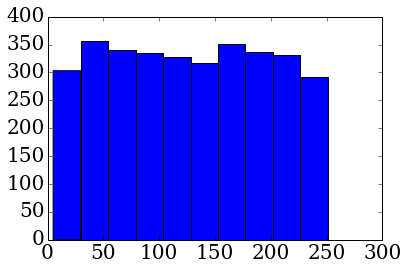

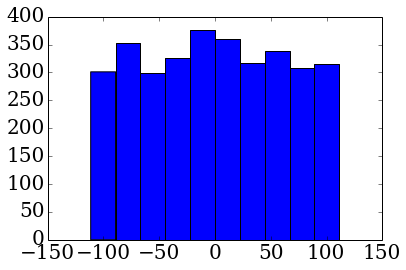

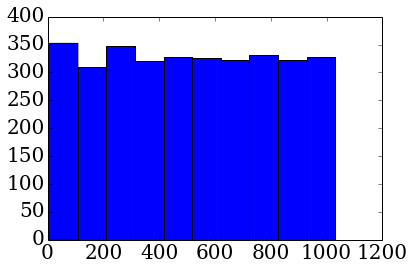

In [302]:
plt.hist(mc_sdf.daughterx_v.str[0])
plt.show()
plt.hist(mc_sdf.daughtery_v.str[0])
plt.show()
plt.hist(mc_sdf.daughterz_v.str[0])
plt.show()

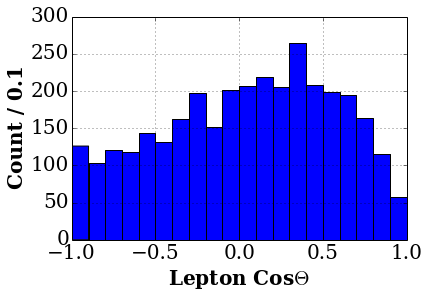

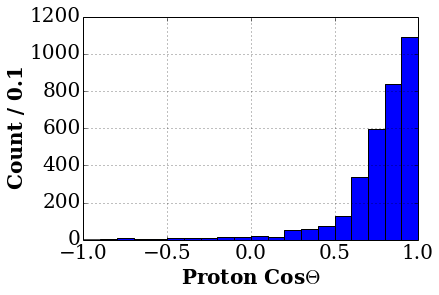

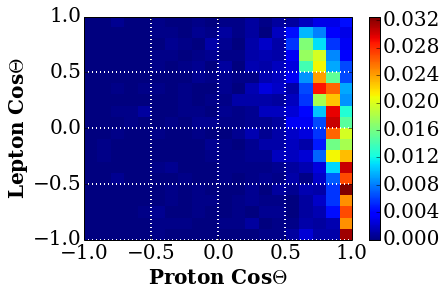

In [444]:
costz_lep=(mc_sdf.daughterPz_v.str[0])/ np.sqrt(np.power(mc_sdf.daughterPx_v.str[0],2)+
                 np.power(mc_sdf.daughterPy_v.str[0],2)+
                 np.power(mc_sdf.daughterPz_v.str[0],2))
    
plt.hist(costz_lep,bins=np.arange(-1,1.0+0.1,0.1))
ax=plt.gca()
ax.set_xlabel("Lepton Cos$\Theta$",fontweight='bold')
ax.set_ylabel("Count / 0.1",fontweight='bold')
plt.grid()
plt.show()

costz_prot=(mc_sdf.daughterPz_v.str[1])/ np.sqrt(np.power(mc_sdf.daughterPx_v.str[1],2)+
                 np.power(mc_sdf.daughterPy_v.str[1],2)+
                 np.power(mc_sdf.daughterPz_v.str[1],2))
plt.hist(costz_prot,bins=np.arange(-1,1.0+0.1,0.1))
ax=plt.gca()
ax.set_xlabel("Proton Cos$\Theta$",fontweight='bold')
ax.set_ylabel("Count / 0.1",fontweight='bold')
plt.grid()
plt.show()

im=plt.hist2d(costz_prot.values,
              costz_lep.values,bins=(np.arange(-1,1+0.1,0.1),np.arange(-1,1+0.1,0.1)),
              weights=[1/float(costz_prot.size)]*costz_prot.size)

plt.colorbar(im[3])
ax=plt.gca()
ax.set_xlabel("Proton Cos$\Theta$",fontweight='bold')
ax.set_ylabel("Lepton Cos$\Theta$",fontweight='bold')
plt.grid(color='w',lw=2)
plt.show()

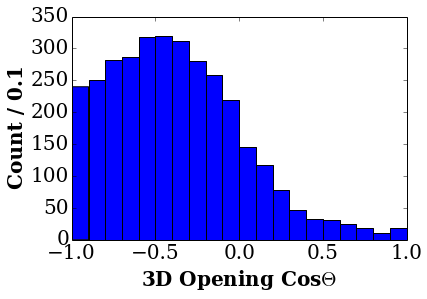

In [447]:
costz_open= ( mc_sdf.daughterPx_v.str[0]*mc_sdf.daughterPx_v.str[1]+
              mc_sdf.daughterPy_v.str[0]*mc_sdf.daughterPy_v.str[1]+
              mc_sdf.daughterPz_v.str[0]*mc_sdf.daughterPz_v.str[1] ) / (np.sqrt( np.power(mc_sdf.daughterPx_v.str[0],2) +
                      np.power(mc_sdf.daughterPy_v.str[0],2) +
                      np.power(mc_sdf.daughterPz_v.str[0],2)) *
            np.sqrt( np.power(mc_sdf.daughterPx_v.str[1],2) +
                     np.power(mc_sdf.daughterPy_v.str[1],2) +
                     np.power(mc_sdf.daughterPz_v.str[1],2)))

plt.hist(costz_open,bins=np.arange(-1.0,1.0+0.1,0.1))
ax=plt.gca()
ax.set_ylabel("Count / 0.1",fontweight='bold')
ax.set_xlabel("3D Opening Cos$\Theta$",fontweight='bold')
plt.show()

3288
3288
0.90602189781
0.845194647202


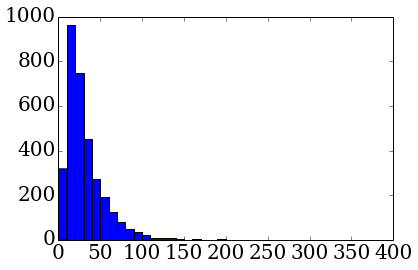

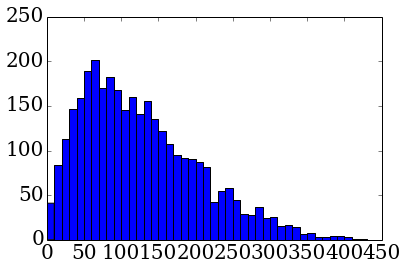

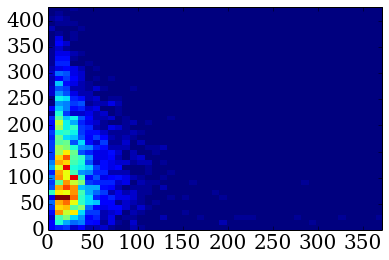

3288
3288
0.899330900243
0.83698296837


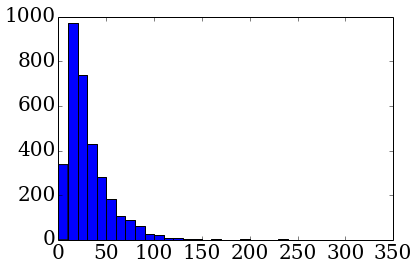

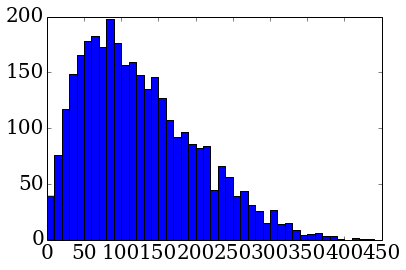

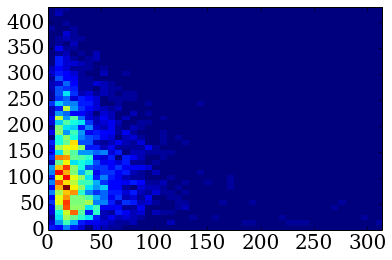

3288
3288
0.777068126521
0.979318734793


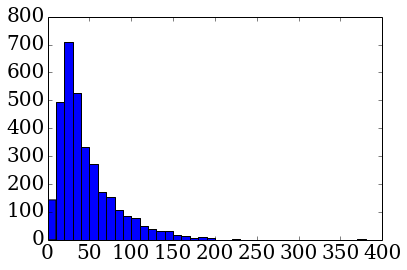

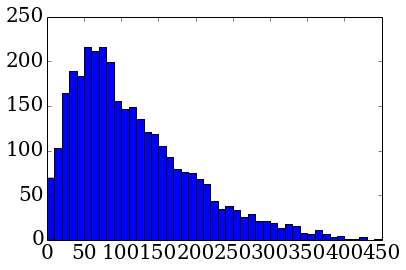

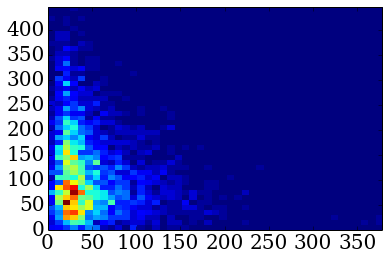

In [530]:
for plane in xrange(3):
    lep_d=mc_sdf.daughterLength_vv.str[plane].str[0].values
    pro_d=mc_sdf.daughterLength_vv.str[plane].str[1].values
    print pro_d.size
    print lep_d.size
    print (pro_d<lep_d).sum() / float(pro_d.size)
    print (cos_s[:,plane]>0).sum() / float(pro_d.size)
    
    
    plt.hist(pro_d,bins=np.arange(0,450+10,10))
    plt.show()
    plt.hist(lep_d,bins=np.arange(0,450+10,10))
    plt.show()
    plt.hist2d(pro_d,lep_d,bins=(45,45))
    plt.show()


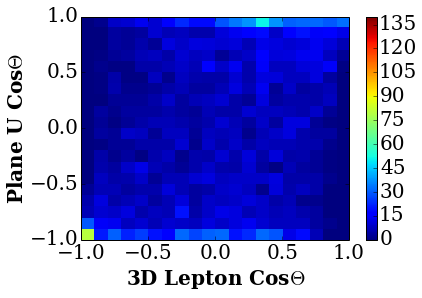

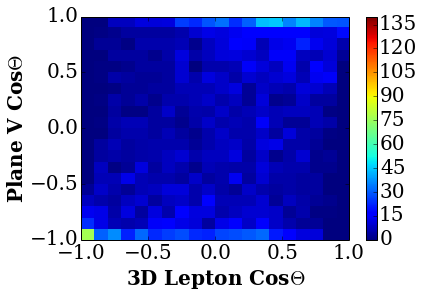

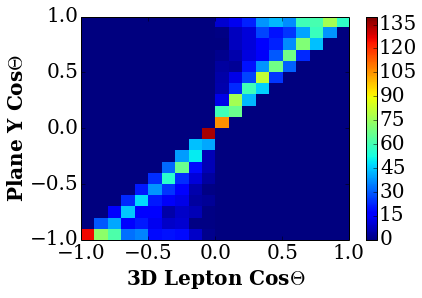

In [489]:
plane2name=["U","V","Y"]
for p in xrange(3):
    im=plt.hist2d(costz_lep.values,
               mc_sdf.daughter2DCosAngle_vv.str[p].str[0].values,
               bins=np.arange(-1.0,1.0+0.1,0.1),vmax=140)
    ax=plt.gca()
    ax.set_xlabel("3D Lepton Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Plane {} Cos$\Theta$".format(plane2name[p]),fontweight='bold')
    plt.colorbar(im[3])
    plt.show()
    
for p in xrange(3):
    im=plt.hist2d(costz_prot.values,
                  mc_sdf.daughter2DCosAngle_vv.str[p].str[1].values,
                  bins=np.arange(-1.0,1.0+0.1,0.1))#,vmax=140)
    ax=plt.gca()
    ax.set_xlabel("3D Lepton Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Plane {} Cos$\Theta$".format(plane2name[p]),fontweight='bold')
    plt.colorbar(im[3])
    plt.show()

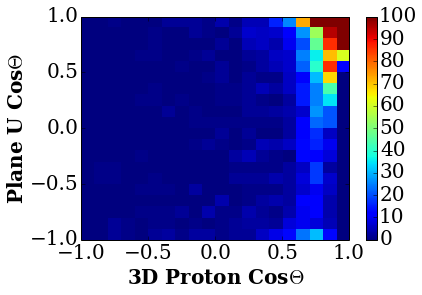

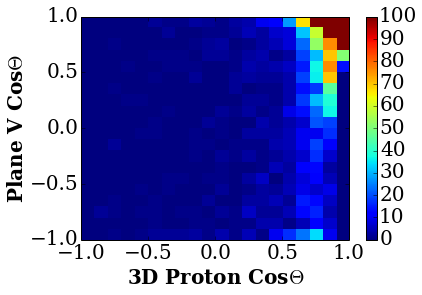

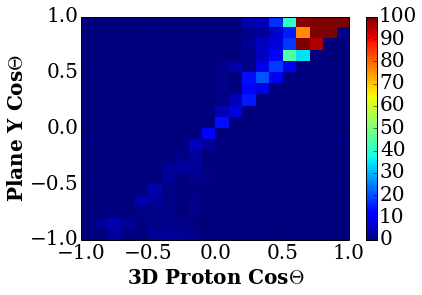

In [505]:
plane2name=["U","V","Y"]

for p in xrange(3):
    im=plt.hist2d(costz_prot.values,
                  mc_sdf.daughter2DCosAngle_vv.str[p].str[1].values,
                  bins=np.arange(-1.0,1.0+0.1,0.1),vmax=100)
    ax=plt.gca()
    ax.set_xlabel("3D Proton Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Plane {} Cos$\Theta$".format(plane2name[p]),fontweight='bold')
    plt.colorbar(im[3])
    plt.show()


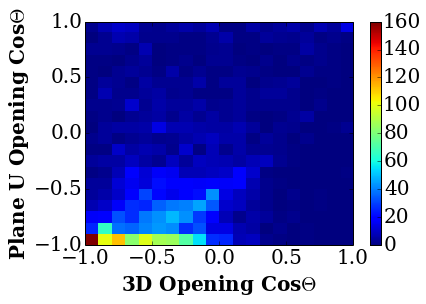

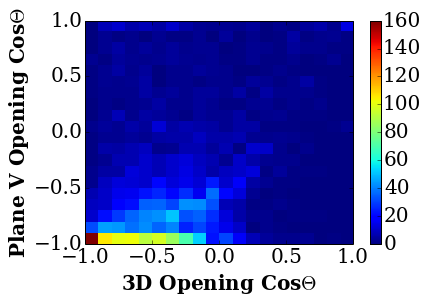

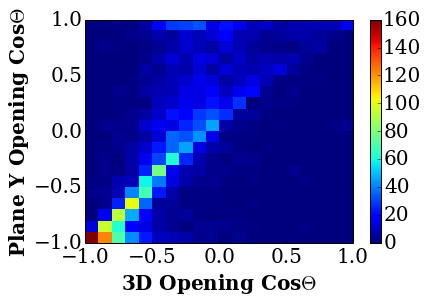

In [526]:
plane2name=["U","V","Y"]
for p in xrange(3):
    im=plt.hist2d(costz_open.values,
                  np.nan_to_num(mc_cos_s.str[p].values),
                  bins=np.arange(-1.0,1.0+0.1,0.1),vmax=160)
    ax=plt.gca()
    ax.set_xlabel("3D Opening Cos$\Theta$",fontweight='bold')
    ax.set_ylabel("Plane {} Opening Cos$\Theta$".format(plane2name[p]),fontweight='bold')
    plt.colorbar(im[3])
    plt.show()

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]]),
 array([  14.99128046,   19.16002126,   23.32876206,   27.49750287,
          31.66624367,   35.83498447,   40.00372528,   44.17246608,
          48.34120689,   52.50994769,   56.67868849,   60.8474293 ,
          65.0161701 ,   69.1849109 ,   73.35365171,   77.52239251,
          81.69113331,   85.85987412,   90.02861492,   94.19735573,
          98.36609653,  102.53483733,  106.70357814,  110.87231894,
         115.04105974,  119.20980055,  123.37854135,  127.54728216,
         131.71602296,  135.88476376,  140.05350457,  144.22224537,
         148.39098617,  152.55972698,  156.72846778,  160.89720858,
         165.06594939,  169.23469019,  173.403431  ,  177.5721718 ,
         181.7409126 ,  185.909653

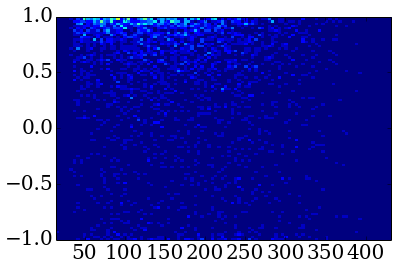

In [535]:
plt.hist2d(mc_sdf.daughterEnergyDep_v.str[0].values,
           mc_sdf.daughter2DCosAngle_vv.str[0].str[1].values,bins=(100,100))

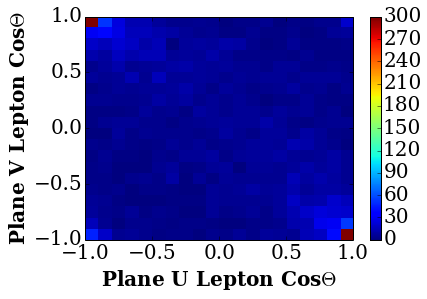

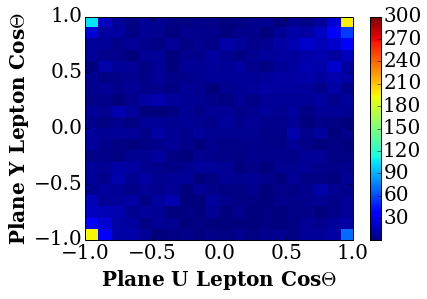

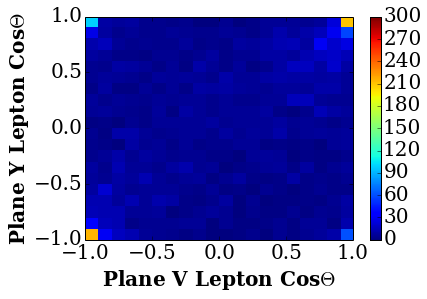

In [545]:
for p in xrange(3):
    for u in xrange(p+1,3):
        im=plt.hist2d(mc_sdf.daughter2DCosAngle_vv.str[p].str[0].values,
                      mc_sdf.daughter2DCosAngle_vv.str[u].str[0].values,
                      bins=np.arange(-1.0,1.0+0.1,0.1),vmax=300)
        ax=plt.gca()
        ax.set_xlabel("Plane {} Lepton Cos$\Theta$".format(plane2name[p]),fontweight='bold')
        ax.set_ylabel("Plane {} Lepton Cos$\Theta$".format(plane2name[u]),fontweight='bold')
        plt.colorbar(im[3])
        plt.show()

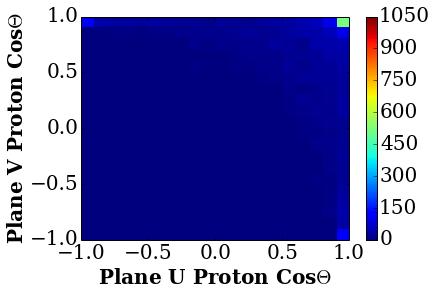

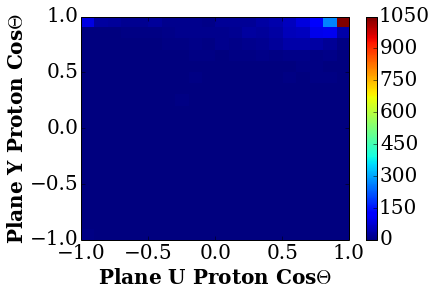

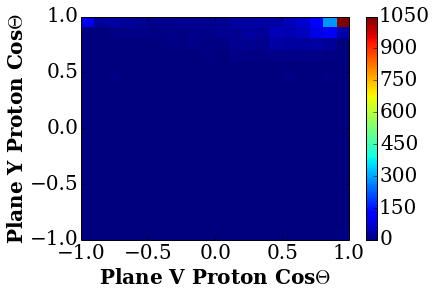

In [548]:
for p in xrange(3):
    for u in xrange(p+1,3):
        im=plt.hist2d(mc_sdf.daughter2DCosAngle_vv.str[p].str[1].values,
                      mc_sdf.daughter2DCosAngle_vv.str[u].str[1].values,
                      bins=np.arange(-1.0,1.0+0.1,0.1),vmax=1050)
        ax=plt.gca()
        ax.set_xlabel("Plane {} Proton Cos$\Theta$".format(plane2name[p]),fontweight='bold')
        ax.set_ylabel("Plane {} Proton Cos$\Theta$".format(plane2name[u]),fontweight='bold')
        plt.colorbar(im[3])
        plt.show()